In [1]:
import sys
sys.path.insert(0, '/data/schoiaj/repos/nli_explain')
import json

import pandas as pd

from explainers.archipelago.viz.text import viz_text
from utils.data_utils import get_clean_token_list
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
df = pd.read_csv('../data/e-SNLI/esnli_test_processed_1k.csv')
pd.set_option('display.max_colwidth', None)

In [3]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
def analyze_explanation(df, explanation, idx, topk=1, texts=None, gold_label=None, no_main=True):
    
    
    if texts is None:
        texts = df.iloc[idx][['Sentence1', 'Sentence2']].tolist()
    cleaned_premise = [w.lower() for w in get_clean_token_list(texts[0])]
    cleaned_hypothesis = [w.lower() for w in get_clean_token_list(texts[1])]

    tokens = cleaned_premise + ['->'] + cleaned_hypothesis
    
    exp = [eval(k) for k,v in sorted(explanation[idx]['pred_rationales'].items(), key=lambda x: x[1], reverse=True)]
    
    if gold_label is None:
        gold_label = df.iloc[idx]['gold_label']
    print("texts:", texts)
    print("gold label:", gold_label)
    print("pred label:", explanation[idx]['pred_label'])
    print("explanations:", exp)
    print("interactions_vote:", df.iloc[idx]['interactions_vote'])
    print("interactions_union:", df.iloc[idx]['interactions_union'])
    
    explanation_idx = {}

    for i, interaction in enumerate(exp):
        if len(interaction[0]) + len(interaction[1]) == 4:
            if not (len(interaction[0]) == 2 and len(interaction[1]) == 2):
                continue
        indices = []
        tok_idx = -1
        for pre_token in interaction[0]:
            if pre_token not in cleaned_premise[tok_idx + 1:]:
                continue
            tok_idx = tok_idx + 1 + cleaned_premise[tok_idx + 1:].index(pre_token)
            indices.append(tok_idx)
        tok_idx = -1
        for hyp_token in interaction[1]:
            if hyp_token not in cleaned_hypothesis[tok_idx + 1:]:
                continue
            tok_idx = tok_idx + 1 + cleaned_hypothesis[tok_idx + 1:].index(hyp_token)
            indices.append(tok_idx + len(cleaned_premise) + 1)
        if indices:
            explanation_idx[tuple(indices)] = len(explanation[idx]['pred_rationales']) - i
        if topk is not None and i + 1 >= topk:
            break
    
    for i in range(len(tokens)):
        if no_main or (i,) not in explanation_idx:
            explanation_idx[(i,)] = 0
        
    fig = viz_text(explanation_idx, tokens)
    display(fig)
    plt.close()

## On The Fly

In [4]:
from explainers.archipelago.get_explainer import ArchExplainerInterface
# from explainers.integrated_hessians.IH_explainer import IHBertExplainer
# from explainers.naive_explain.naive_explainer import NaiveExplainer
from explainers.mask_explain.mask_explainer import MaskExplainer
from explainers.lime_baseline import LimeExplainer

arch = ArchExplainerInterface('bert-base',
                        device='cuda',
                        explainer_class='arch')
cross_arch = ArchExplainerInterface('bert-base',
                        device='cuda',
                        explainer_class='cross_arch')
# naive = NaiveExplainer('bert-base',
#                     device='cuda')
# IH = IHBertExplainer('bert-base',
#                     device='cuda')
# explain_kwargs = dict(batch_size=16,
#                       num_samples=128,
#                       use_expectation=False,
#                       do_cross_merge=False,
#                       get_cross_effects=True)
mask_explain = MaskExplainer('bert-base',
                        device='cuda',
                        baseline_token='attention+[MASK]')


lime = LimeExplainer('bert-base',
                        device='cuda')
explain_kwargs = dict(batch_size=32, mask_n=5000)

In [18]:
df.iloc[109][['Sentence1', 'Sentence2']].tolist()


['A woman wearing a striped wrap is bent over in a cornfield while looking at the camera.',
 'A man wearing a bathing suit is bent over in a cornfield while looking at the camera.']

contradiction


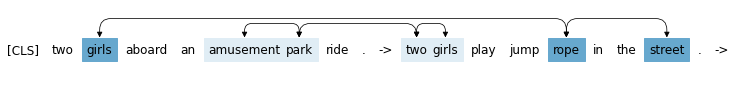

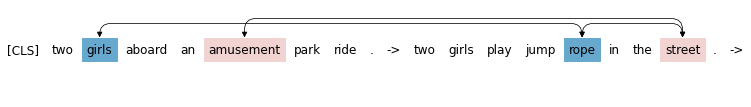

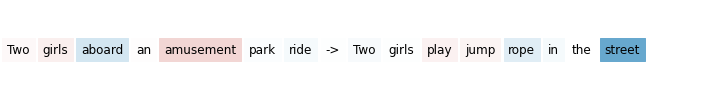

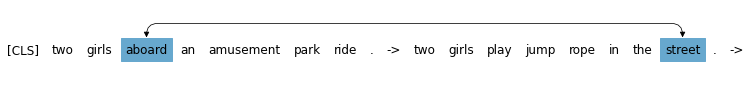

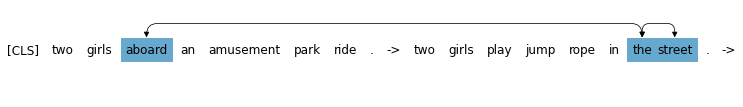

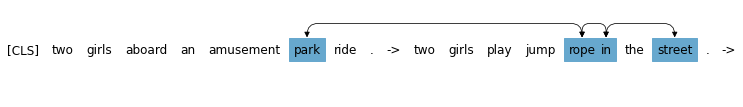

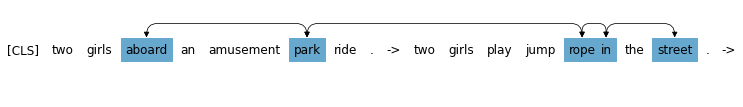

In [25]:
# sents = df.iloc[761][['Sentence1', 'Sentence2']].tolist()
sents = df.iloc[369][['Sentence1', 'Sentence2']].tolist()
# sents = ['three children hold a boy\'s arms down while another boy on a hat shoots a water gun at him.', 'there are five adults.']
# sents = ['that was an exceptionally funny movie.', "the movie was great."]
# sents = ['a policeman is sitting in a van looking out the window.', "the policeman is sitting."]
target = None
# target = arch.get_label_map()["contradiction"]
explanation, tokens, pred = arch.explain(*sents, output_indices=target)
explanation = {k: v for k, v in sorted(explanation.items(), key=lambda x: x[1], reverse=True)[:2]}
print(arch.get_label_map(inv=True)[pred])
for i in range(len(tokens)):
    explanation[(i,)] = 0
fig = viz_text(explanation, [tok if tok != '[SEP]' else '->' for tok in tokens])

explanation, tokens, pred = cross_arch.explain(*sents, do_cross_merge=True, output_indices=target)
explanation = {k: v for k, v in sorted(explanation.items(), key=lambda x: x[1], reverse=True)[:2]}
for i in range(len(tokens)):
    explanation[(i,)] = 0
fig = viz_text(explanation, [tok if tok != '[SEP]' else '->' for tok in tokens])

explanation, tokens, pred = lime.explain(*sents, mask_n=5000, output_indices=target)
explanation = {k: v for k, v in sorted(explanation.items(), key=lambda x: x[1], reverse=True)[:None]}
for i in range(len(tokens)):
    if (i,) not in explanation:
        explanation[(i,)] = 0
fig = viz_text(explanation, [tok if tok != '[SEP]' else '->' for tok in tokens])

explanation, tokens, pred = mask_explain.explain(*sents, interaction_order=(2,), 
                                                 mask_p=0.5, mask_n=5000, top_p=0.3, 
                                                 do_buildup=True, output_indices=target)
explanation = {k: v for k, v in sorted(explanation.items(), key=lambda x: x[1], reverse=True)[:1]}
for i in range(len(tokens)):
    explanation[(i,)] = 0
fig = viz_text(explanation, [tok if tok != '[SEP]' else '->' for tok in tokens])

explanation, tokens, pred = mask_explain.explain(*sents, interaction_order=(3,), 
                                                 mask_p=0.5, mask_n=5000, top_p=0.3, 
                                                 do_buildup=True, output_indices=target)
explanation = {k: v for k, v in sorted(explanation.items(), key=lambda x: x[1], reverse=True)[:1]}
for i in range(len(tokens)):
    explanation[(i,)] = 0
fig = viz_text(explanation, [tok if tok != '[SEP]' else '->' for tok in tokens])

explanation, tokens, pred = mask_explain.explain(*sents, interaction_order=(4,), 
                                                 mask_p=0.5, mask_n=5000, top_p=0.3, 
                                                 do_buildup=True, output_indices=target)
explanation = {k: v for k, v in sorted(explanation.items(), key=lambda x: x[1], reverse=True)[:1]}
for i in range(len(tokens)):
    explanation[(i,)] = 0
fig = viz_text(explanation, [tok if tok != '[SEP]' else '->' for tok in tokens])

explanation, tokens, pred = mask_explain.explain(*sents, interaction_order=(5,), 
                                                 mask_p=0.5, mask_n=5000, top_p=0.3, 
                                                 do_buildup=True, output_indices=target)
explanation = {k: v for k, v in sorted(explanation.items(), key=lambda x: x[1], reverse=True)[:1]}
for i in range(len(tokens)):
    explanation[(i,)] = 0
fig = viz_text(explanation, [tok if tok != '[SEP]' else '->' for tok in tokens])

## From test set

### Previously selected

############################ 929 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ["A man and woman look through CD's at a street vendor.", 'A man and women shopping']
gold label: entailment
pred label: entailment
explanations: [(('woman',), ()), (('vendor',), ()), ((), ('and',)), (('man',), ()), (('and',), ()), ((), ('A',)), (('look',), ()), (('through',), ()), ((), ()), (('s',), ())]
interactions_vote: [(['look'], ['shopping']), (['street', 'vendor'], ['shopping'])]
interactions_union: [(['man'], ['man']), (['man'], ['women', 'shopping']), (['woman', 'look', 'through', 'CD', 's', 'at', 'a', 'street', 'vendor'], ['man']), (['woman', 'look', 'through', 'CD', 's', 'at', 'a', 'street', 'vendor'], ['women', 'shopping'])]


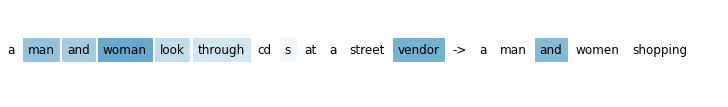


bert-base_arch-5_test_BT=[MASK].json
texts: ["A man and woman look through CD's at a street vendor.", 'A man and women shopping']
gold label: entailment
pred label: entailment
explanations: [(('man', 'and', 'woman'), ('man', 'and', 'women'))]
interactions_vote: [(['look'], ['shopping']), (['street', 'vendor'], ['shopping'])]
interactions_union: [(['man'], ['man']), (['man'], ['women', 'shopping']), (['woman', 'look', 'through', 'CD', 's', 'at', 'a', 'street', 'vendor'], ['man']), (['woman', 'look', 'through', 'CD', 's', 'at', 'a', 'street', 'vendor'], ['women', 'shopping'])]


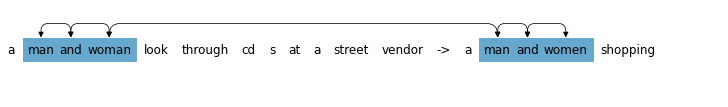


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ["A man and woman look through CD's at a street vendor.", 'A man and women shopping']
gold label: entailment
pred label: entailment
explanations: [(('man', 'woman'), ('man', 'women')), (('and',), ('and',))]
interactions_vote: [(['look'], ['shopping']), (['street', 'vendor'], ['shopping'])]
interactions_union: [(['man'], ['man']), (['man'], ['women', 'shopping']), (['woman', 'look', 'through', 'CD', 's', 'at', 'a', 'street', 'vendor'], ['man']), (['woman', 'look', 'through', 'CD', 's', 'at', 'a', 'street', 'vendor'], ['women', 'shopping'])]


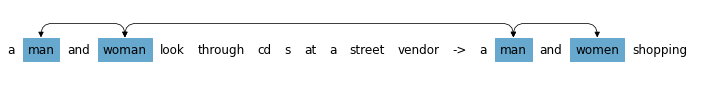


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ["A man and woman look through CD's at a street vendor.", 'A man and women shopping']
gold label: entailment
pred label: entailment
explanations: [(('woman',), ('and',)), (('woman',), ('women',)), (('and',), ('and',)), (('vendor',), ('and',)), (('man',), ('and',)), (('man',), ('man',)), (('woman',), ('a',)), (('man',), ('a',)), (('through',), ('and',)), (('vendor',), ('a',)), (('s',), ('and',)), (('and',), ('a',)), (('through',), ('a',)), (('a',), ('and',)), (('at',), ('and',)), (('cd',), ('and',)), (('street',), ('and',)), (('look',), ('and',)), (('street',), ('a',)), (('s',), ('a',))]
interactions_vote: [(['look'], ['shopping']), (['street', 'vendor'], ['shopping'])]
interactions_union: [(['man'], ['man']), (['man'], ['women', 'shopping']), (['woman', 'look', 'through', 'CD', 's', 'at', 'a', 'street', 'vendor'], ['man']), (['woman', 'look', 'through', 'CD', 's', 'at', 'a', 'street', 'vendor'], ['women', 's

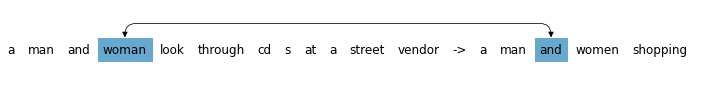


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ["A man and woman look through CD's at a street vendor.", 'A man and women shopping']
gold label: entailment
pred label: entailment
explanations: [(('man', 'woman'), ('and',)), (('woman', 'vendor'), ('and',)), (('and', 'woman'), ('and',)), (('woman',), ('and', 'women')), (('woman', 'vendor'), ('women',)), (('man', 'woman'), ('a',)), (('man', 'woman'), ('man',)), (('woman', 'through'), ('and',)), (('woman', 'through'), ('women',)), (('and', 'vendor'), ('and',))]
interactions_vote: [(['look'], ['shopping']), (['street', 'vendor'], ['shopping'])]
interactions_union: [(['man'], ['man']), (['man'], ['women', 'shopping']), (['woman', 'look', 'through', 'CD', 's', 'at', 'a', 'street', 'vendor'], ['man']), (['woman', 'look', 'through', 'CD', 's', 'at', 'a', 'street', 'vendor'], ['women', 'shopping'])]


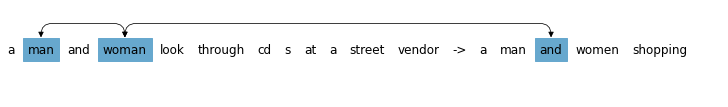


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ["A man and woman look through CD's at a street vendor.", 'A man and women shopping']
gold label: entailment
pred label: entailment
explanations: [(('man', 'woman', 'vendor'), ('and',)), (('woman', 'vendor'), ('and', 'women')), (('man', 'and', 'woman'), ('and',)), (('and', 'woman', 'vendor'), ('and',)), (('man', 'woman'), ('and', 'women')), (('and', 'woman'), ('and', 'women')), (('man', 'woman'), ('a', 'and')), (('man', 'woman', 'through'), ('and',)), (('man', 'woman'), ('man', 'women')), (('man', 'woman', 'vendor'), ('a',)), (('man', 'woman', 's'), ('and',)), (('man', 'woman', 'vendor'), ('man',)), (('a', 'man', 'woman'), ('and',)), (('man', 'woman', 'at'), ('and',)), (('man', 'woman'), ('man', 'and')), (('and', 'woman', 'through'), ('and',)), (('man', 'woman', 'look'), ('and',)), (('woman', 'through'), ('and', 'women')), (('man', 'woman', 'street'), ('and',)), (('woman', 'through', 'vendor'), ('

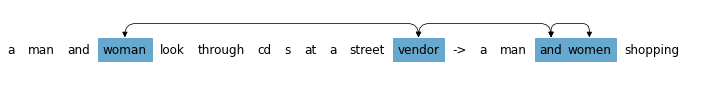

############################ 305 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['A boy watches a woman walking amidst many concrete boxes.', 'A woman is checking out the men.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('men',)), (('boy',), ()), ((), ('woman',)), (('watches',), ()), ((), ('out',)), ((), ('the',)), ((), ('A',)), (('boxes',), ()), (('a',), ()), (('many',), ()), ((), ())]
interactions_vote: [(['boy'], ['woman'])]
interactions_union: [(['boy', 'watches'], ['woman']), (['boy', 'watches'], ['checking']), (['boy', 'watches'], ['men']), (['woman'], ['woman']), (['woman'], ['checking']), (['woman'], ['men'])]


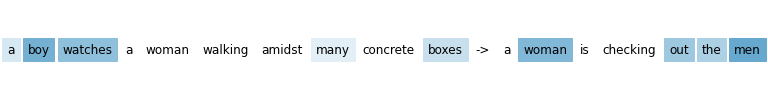


bert-base_arch-5_test_BT=[MASK].json
texts: ['A boy watches a woman walking amidst many concrete boxes.', 'A woman is checking out the men.']
gold label: contradiction
pred label: contradiction
explanations: [(('boy', 'woman'), ('woman', 'men'))]
interactions_vote: [(['boy'], ['woman'])]
interactions_union: [(['boy', 'watches'], ['woman']), (['boy', 'watches'], ['checking']), (['boy', 'watches'], ['men']), (['woman'], ['woman']), (['woman'], ['checking']), (['woman'], ['men'])]


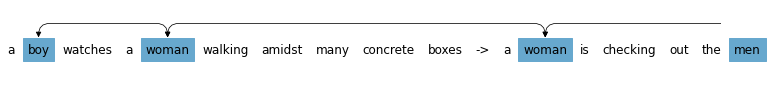


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A boy watches a woman walking amidst many concrete boxes.', 'A woman is checking out the men.']
gold label: contradiction
pred label: contradiction
explanations: [(('boy', 'woman'), ('woman', 'men')), (('watches',), ('woman',))]
interactions_vote: [(['boy'], ['woman'])]
interactions_union: [(['boy', 'watches'], ['woman']), (['boy', 'watches'], ['checking']), (['boy', 'watches'], ['men']), (['woman'], ['woman']), (['woman'], ['checking']), (['woman'], ['men'])]


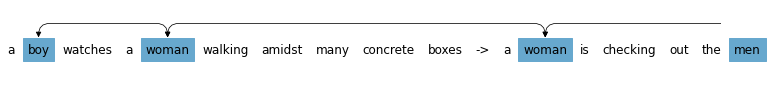


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A boy watches a woman walking amidst many concrete boxes.', 'A woman is checking out the men.']
gold label: contradiction
pred label: contradiction
explanations: [(('boy',), ('woman',)), (('boy',), ('men',)), (('woman',), ('men',)), (('boxes',), ('men',)), (('watches',), ('men',)), (('many',), ('men',)), (('amidst',), ('men',)), (('concrete',), ('men',)), (('a',), ('men',)), (('boxes',), ('woman',)), (('boy',), ('the',)), (('many',), ('woman',)), (('walking',), ('men',)), (('boy',), ('is',)), (('boy',), ('a',)), (('concrete',), ('woman',)), (('a',), ('woman',)), (('amidst',), ('woman',)), (('watches',), ('woman',))]
interactions_vote: [(['boy'], ['woman'])]
interactions_union: [(['boy', 'watches'], ['woman']), (['boy', 'watches'], ['checking']), (['boy', 'watches'], ['men']), (['woman'], ['woman']), (['woman'], ['checking']), (['woman'], ['men'])]


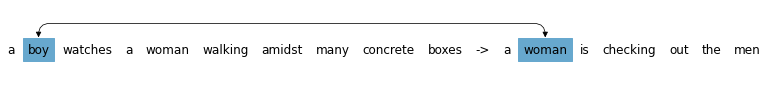


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A boy watches a woman walking amidst many concrete boxes.', 'A woman is checking out the men.']
gold label: contradiction
pred label: contradiction
explanations: [(('boy',), ('woman', 'men')), (('boy',), ('the', 'men')), (('boy',), ('woman', 'the')), (('boy', 'a'), ('woman',)), (('boy', 'boxes'), ('men',)), (('watches', 'woman'), ('men',)), (('boy', 'boxes'), ('woman',)), (('boy', 'a'), ('men',)), (('boy', 'amidst'), ('woman',)), (('boy', 'watches'), ('men',))]
interactions_vote: [(['boy'], ['woman'])]
interactions_union: [(['boy', 'watches'], ['woman']), (['boy', 'watches'], ['checking']), (['boy', 'watches'], ['men']), (['woman'], ['woman']), (['woman'], ['checking']), (['woman'], ['men'])]


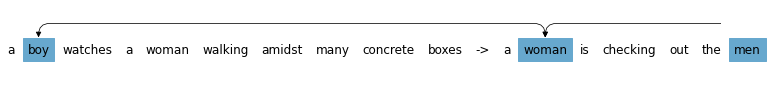


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A boy watches a woman walking amidst many concrete boxes.', 'A woman is checking out the men.']
gold label: contradiction
pred label: contradiction
explanations: [(('boy', 'a'), ('woman', 'men')), (('boy',), ('woman', 'the', 'men')), (('boy', 'boxes'), ('woman', 'men')), (('a', 'boy'), ('woman', 'men')), (('boy',), ('a', 'woman', 'men')), (('boy', 'amidst'), ('woman', 'men')), (('boy', 'many'), ('woman', 'men')), (('boy', 'watches'), ('woman', 'men')), (('boy', 'walking'), ('woman', 'men')), (('watches', 'woman'), ('the', 'men')), (('boy', 'boxes'), ('woman', 'the')), (('boy', 'boxes'), ('the', 'men')), (('a', 'boy', 'a'), ('woman',)), (('boy', 'concrete'), ('woman', 'men')), (('boy',), ('woman', 'checking', 'men')), (('boy', 'a'), ('a', 'woman')), (('boy', 'boxes'), ('a', 'woman')), (('boy', 'a', 'amidst'), ('woman',)), (('a', 'boy', 'boxes'), ('woman',)), (('boy', 'a'), ('woman', 'the'))]
inte

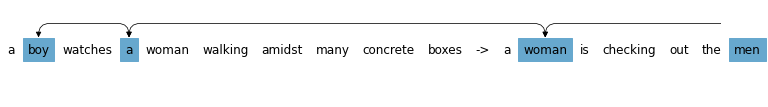

############################ 274 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['A ballerina standing on the toes of one food with one arm up in the air and one leg lifted behind her.', 'The ballerina is sleeping soundly.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('sleeping',)), ((), ('soundly',)), (('food',), ()), (('air',), ()), (('standing',), ()), (('arm',), ()), (('one',), ())]
interactions_vote: [(['standing'], ['sleeping']), (['toes'], ['sleeping'])]
interactions_union: [(['standing', 'on'], ['sleeping']), (['toes'], ['sleeping']), (['food'], ['sleeping'])]


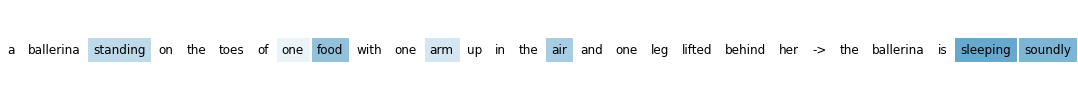


bert-base_arch-5_test_BT=[MASK].json
texts: ['A ballerina standing on the toes of one food with one arm up in the air and one leg lifted behind her.', 'The ballerina is sleeping soundly.']
gold label: contradiction
pred label: contradiction
explanations: [(('food',), ('the', 'is', 'sleeping', 'soundly'))]
interactions_vote: [(['standing'], ['sleeping']), (['toes'], ['sleeping'])]
interactions_union: [(['standing', 'on'], ['sleeping']), (['toes'], ['sleeping']), (['food'], ['sleeping'])]


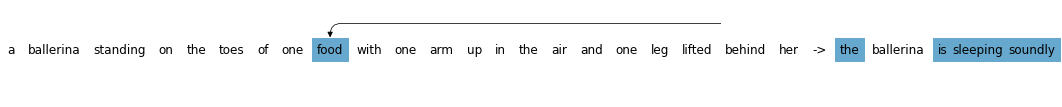


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A ballerina standing on the toes of one food with one arm up in the air and one leg lifted behind her.', 'The ballerina is sleeping soundly.']
gold label: contradiction
pred label: contradiction
explanations: [(('food',), ('sleeping',)), (('arm',), ('sleeping',))]
interactions_vote: [(['standing'], ['sleeping']), (['toes'], ['sleeping'])]
interactions_union: [(['standing', 'on'], ['sleeping']), (['toes'], ['sleeping']), (['food'], ['sleeping'])]


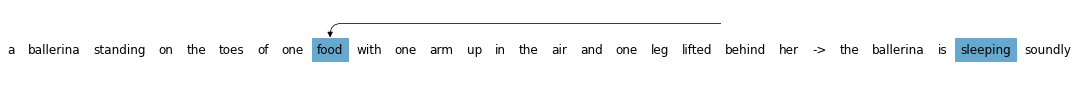


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A ballerina standing on the toes of one food with one arm up in the air and one leg lifted behind her.', 'The ballerina is sleeping soundly.']
gold label: contradiction
pred label: contradiction
explanations: [(('air',), ('sleeping',)), (('arm',), ('sleeping',)), (('up',), ('sleeping',)), (('behind',), ('sleeping',)), (('lifted',), ('sleeping',)), (('leg',), ('sleeping',)), (('in',), ('sleeping',)), (('ballerina',), ('sleeping',)), (('and',), ('sleeping',)), (('standing',), ('sleeping',)), (('food',), ('sleeping',)), (('one',), ('sleeping',)), (('with',), ('sleeping',)), (('her',), ('sleeping',)), (('of',), ('sleeping',)), (('toes',), ('sleeping',)), (('the',), ('sleeping',))]
interactions_vote: [(['standing'], ['sleeping']), (['toes'], ['sleeping'])]
interactions_union: [(['standing', 'on'], ['sleeping']), (['toes'], ['sleeping']), (['food'], ['sleeping'])]


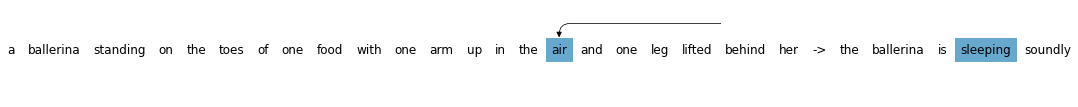


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A ballerina standing on the toes of one food with one arm up in the air and one leg lifted behind her.', 'The ballerina is sleeping soundly.']
gold label: contradiction
pred label: contradiction
explanations: [(('air',), ('sleeping', 'soundly')), (('up',), ('sleeping', 'soundly')), (('arm',), ('sleeping', 'soundly')), (('in',), ('sleeping', 'soundly')), (('lifted',), ('sleeping', 'soundly')), (('one',), ('sleeping', 'soundly')), (('leg',), ('sleeping', 'soundly')), (('the',), ('sleeping', 'soundly')), (('behind',), ('sleeping', 'soundly')), (('and',), ('sleeping', 'soundly'))]
interactions_vote: [(['standing'], ['sleeping']), (['toes'], ['sleeping'])]
interactions_union: [(['standing', 'on'], ['sleeping']), (['toes'], ['sleeping']), (['food'], ['sleeping'])]


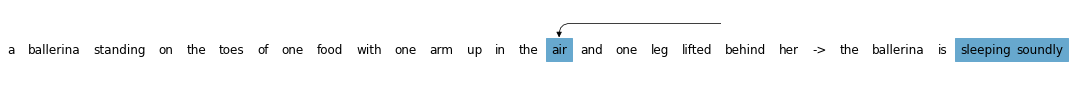


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A ballerina standing on the toes of one food with one arm up in the air and one leg lifted behind her.', 'The ballerina is sleeping soundly.']
gold label: contradiction
pred label: contradiction
explanations: [(('air',), ('sleeping', 'soundly')), (('up',), ('sleeping', 'soundly')), (('arm',), ('sleeping', 'soundly')), (('up', 'air'), ('sleeping', 'soundly')), (('the', 'air'), ('sleeping', 'soundly')), (('leg',), ('sleeping', 'soundly')), (('lifted',), ('sleeping', 'soundly')), (('in',), ('sleeping', 'soundly')), (('air', 'leg'), ('sleeping', 'soundly')), (('behind',), ('sleeping', 'soundly')), (('in', 'air'), ('sleeping', 'soundly')), (('one',), ('sleeping', 'soundly')), (('arm', 'air'), ('sleeping', 'soundly')), (('of',), ('sleeping', 'soundly')), (('the',), ('sleeping', 'soundly')), (('with',), ('sleeping', 'soundly')), (('food',), ('sleeping', 'soundly')), (('one', 'air'), ('sleeping', 'sound

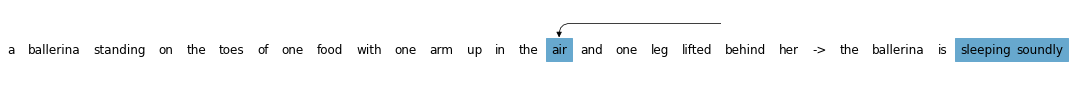

############################ 267 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['A young boy using a spatula to handle meat on a grill.', 'A young boy is using a utensil to handle meat on a grill.']
gold label: entailment
pred label: entailment
explanations: [(('grill',), ()), ((), ('utensil',)), (('boy',), ()), (('meat',), ()), (('young',), ()), (('on',), ()), ((), ('handle',)), (('a',), ())]
interactions_vote: [(['spatula'], ['utensil'])]
interactions_union: [(['spatula'], ['utensil'])]


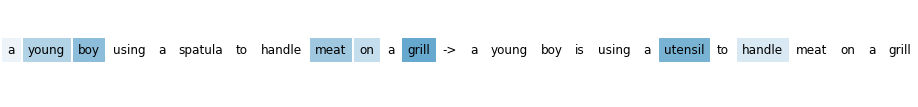


bert-base_arch-5_test_BT=[MASK].json
texts: ['A young boy using a spatula to handle meat on a grill.', 'A young boy is using a utensil to handle meat on a grill.']
gold label: entailment
pred label: entailment
explanations: [((), ('utensil',)), (('grill',), ('grill',)), (('meat',), ('meat',)), (('boy',), ('boy', 'handle'))]
interactions_vote: [(['spatula'], ['utensil'])]
interactions_union: [(['spatula'], ['utensil'])]


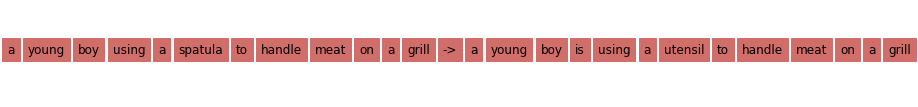


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A young boy using a spatula to handle meat on a grill.', 'A young boy is using a utensil to handle meat on a grill.']
gold label: entailment
pred label: entailment
explanations: [(('grill',), ('grill',)), (('meat',), ('meat',)), (('boy',), ('young',)), (('boy',), ('boy',)), (('to',), ('to',))]
interactions_vote: [(['spatula'], ['utensil'])]
interactions_union: [(['spatula'], ['utensil'])]


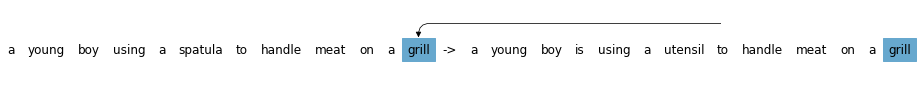


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A young boy using a spatula to handle meat on a grill.', 'A young boy is using a utensil to handle meat on a grill.']
gold label: entailment
pred label: entailment
explanations: [(('grill',), ('utensil',)), (('meat',), ('utensil',)), (('boy',), ('utensil',)), (('grill',), ('to',)), (('grill',), ('is',)), (('young',), ('utensil',)), (('grill',), ('on',)), (('grill',), ('meat',)), (('grill',), ('grill',)), (('grill',), ('a',)), (('grill',), ('handle',)), (('meat',), ('to',))]
interactions_vote: [(['spatula'], ['utensil'])]
interactions_union: [(['spatula'], ['utensil'])]


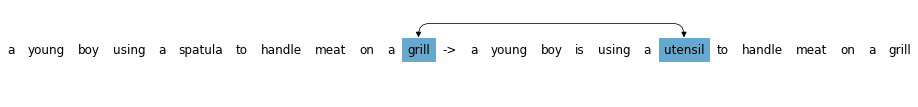


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A young boy using a spatula to handle meat on a grill.', 'A young boy is using a utensil to handle meat on a grill.']
gold label: entailment
pred label: entailment
explanations: [(('boy', 'grill'), ('utensil',)), (('grill',), ('utensil',)), (('young', 'grill'), ('utensil',)), (('boy', 'grill'), ('to',)), (('boy', 'meat'), ('utensil',)), (('boy', 'grill'), ('grill',)), (('boy',), ('utensil',))]
interactions_vote: [(['spatula'], ['utensil'])]
interactions_union: [(['spatula'], ['utensil'])]


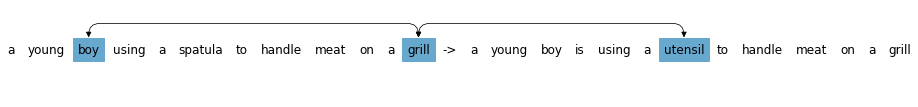


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A young boy using a spatula to handle meat on a grill.', 'A young boy is using a utensil to handle meat on a grill.']
gold label: entailment
pred label: entailment
explanations: [(('boy', 'grill'), ('utensil',)), (('boy', 'grill'), ('utensil', 'to')), (('boy', 'meat', 'grill'), ('utensil',)), (('young', 'grill'), ('utensil',)), (('grill',), ('utensil', 'to')), (('boy', 'grill'), ('utensil', 'on')), (('boy', 'spatula', 'grill'), ('utensil',)), (('boy', 'grill'), ('is', 'utensil')), (('boy', 'grill'), ('a', 'utensil')), (('boy', 'to', 'grill'), ('utensil',)), (('boy', 'meat', 'grill'), ('meat',)), (('boy', 'meat'), ('utensil',)), (('young', 'grill'), ('utensil', 'to')), (('a', 'boy', 'grill'), ('utensil',)), (('boy', 'grill'), ('utensil', 'a')), (('boy', 'a', 'grill'), ('utensil',))]
interactions_vote: [(['spatula'], ['utensil'])]
interactions_union: [(['spatula'], ['utensil'])]


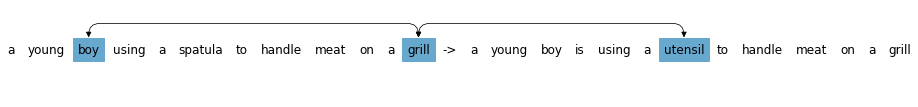

############################ 194 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['A young boy wearing a red shirt and jeans stands in the middle of a field and throws a toy plane in the air.', 'A young boy is playing in a feild.']
gold label: entailment
pred label: contradiction
explanations: [(('field',), ()), ((), ('in',)), ((), ('boy',)), (('young',), ()), (('stands',), ()), (('wearing',), ()), (('plane',), ()), (('jeans',), ()), (('a',), ()), (('the',), ())]
interactions_vote: [(['throws', 'a', 'toy', 'plane'], ['playing'])]
interactions_union: [(['throws', 'a', 'toy', 'plane'], ['playing'])]


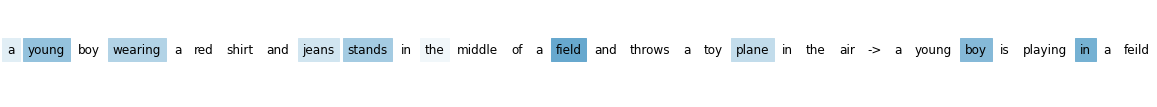


bert-base_arch-5_test_BT=[MASK].json
texts: ['A young boy wearing a red shirt and jeans stands in the middle of a field and throws a toy plane in the air.', 'A young boy is playing in a feild.']
gold label: entailment
pred label: contradiction
explanations: [(('field',), ('is', 'playing', 'in'))]
interactions_vote: [(['throws', 'a', 'toy', 'plane'], ['playing'])]
interactions_union: [(['throws', 'a', 'toy', 'plane'], ['playing'])]


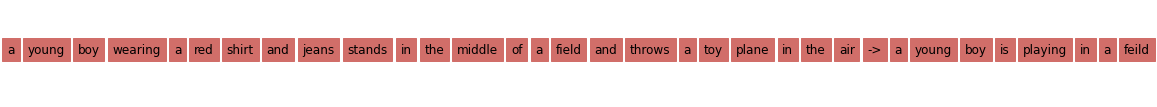


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A young boy wearing a red shirt and jeans stands in the middle of a field and throws a toy plane in the air.', 'A young boy is playing in a feild.']
gold label: entailment
pred label: contradiction
explanations: [(('field',), ('in',)), (('air',), ('in',))]
interactions_vote: [(['throws', 'a', 'toy', 'plane'], ['playing'])]
interactions_union: [(['throws', 'a', 'toy', 'plane'], ['playing'])]


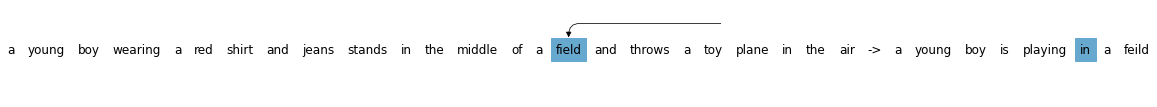


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A young boy wearing a red shirt and jeans stands in the middle of a field and throws a toy plane in the air.', 'A young boy is playing in a feild.']
gold label: entailment
pred label: contradiction
explanations: [(('field',), ('in',)), (('field',), ('feild',)), (('plane',), ('in',)), (('field',), ('boy',)), (('stands',), ('in',)), (('plane',), ('feild',)), (('field',), ('is',)), (('jeans',), ('in',)), (('jeans',), ('feild',)), (('the',), ('in',)), (('plane',), ('boy',)), (('field',), ('a',)), (('and',), ('in',)), (('wearing',), ('in',)), (('stands',), ('feild',)), (('a',), ('in',)), (('the',), ('feild',))]
interactions_vote: [(['throws', 'a', 'toy', 'plane'], ['playing'])]
interactions_union: [(['throws', 'a', 'toy', 'plane'], ['playing'])]


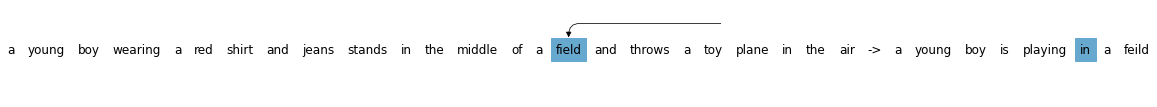


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A young boy wearing a red shirt and jeans stands in the middle of a field and throws a toy plane in the air.', 'A young boy is playing in a feild.']
gold label: entailment
pred label: contradiction
explanations: [(('field',), ('in', 'feild')), (('field',), ('boy', 'in')), (('jeans', 'field'), ('in',)), (('stands', 'field'), ('in',)), (('a', 'field'), ('in',)), (('field',), ('in', 'a')), (('jeans',), ('in', 'feild')), (('field', 'plane'), ('in',)), (('field', 'the'), ('in',)), (('stands',), ('in', 'feild'))]
interactions_vote: [(['throws', 'a', 'toy', 'plane'], ['playing'])]
interactions_union: [(['throws', 'a', 'toy', 'plane'], ['playing'])]


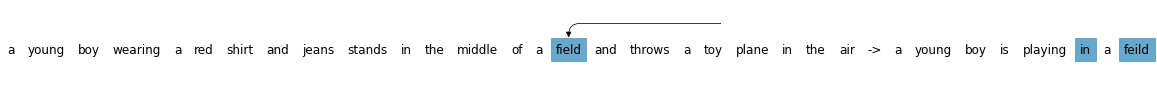


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A young boy wearing a red shirt and jeans stands in the middle of a field and throws a toy plane in the air.', 'A young boy is playing in a feild.']
gold label: entailment
pred label: contradiction
explanations: [(('jeans', 'field'), ('in', 'feild')), (('stands', 'field'), ('in', 'feild')), (('shirt', 'field'), ('in', 'feild')), (('wearing', 'field'), ('in', 'feild')), (('field',), ('boy', 'in', 'feild')), (('field', 'plane'), ('in', 'feild')), (('middle', 'field'), ('in', 'feild')), (('young', 'field'), ('in', 'feild')), (('in', 'field'), ('in', 'feild')), (('field', 'the'), ('in', 'feild')), (('field', 'in'), ('in', 'feild')), (('field',), ('a', 'in', 'feild')), (('of', 'field'), ('in', 'feild')), (('the', 'field'), ('in', 'feild')), (('field', 'a'), ('in', 'feild')), (('and', 'field'), ('in', 'feild')), (('a', 'field'), ('in', 'feild')), (('field', 'throws'), ('in', 'feild'))]
interactions_vo

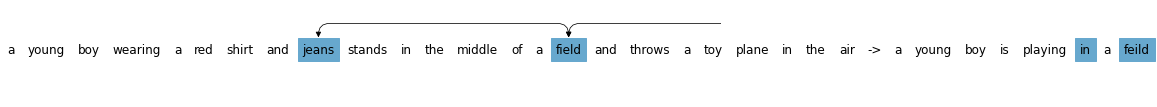

############################ 909 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ["Three children hold a boy's arms down while another boy in a hat shoots a water gun at him.", 'There are five children.']
gold label: entailment
pred label: entailment
explanations: [((), ('children',)), (('Three',), ()), ((), ('There',)), (('another',), ()), (('boy',), ()), (('children',), ()), (('arms',), ()), (('while',), ()), ((), ('are',)), (('down',), ()), (('water',), ())]
interactions_vote: [(['water', 'gun'], ['five', 'children'])]
interactions_union: [(['Three', 'children'], ['five', 'children']), (['a', 'boy', 's', 'arms'], ['five', 'children']), (['another', 'boy'], ['five', 'children']), (['shoots'], ['five', 'children']), (['water', 'gun'], ['five', 'children'])]


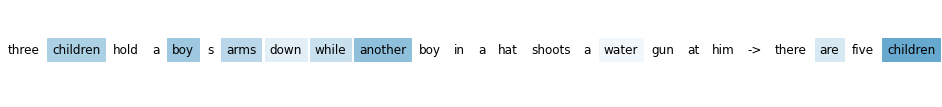


bert-base_arch-5_test_BT=[MASK].json
texts: ["Three children hold a boy's arms down while another boy in a hat shoots a water gun at him.", 'There are five children.']
gold label: entailment
pred label: entailment
explanations: [((), ('there', 'are')), (('children', 'boy', 'shoots'), ('children',))]
interactions_vote: [(['water', 'gun'], ['five', 'children'])]
interactions_union: [(['Three', 'children'], ['five', 'children']), (['a', 'boy', 's', 'arms'], ['five', 'children']), (['another', 'boy'], ['five', 'children']), (['shoots'], ['five', 'children']), (['water', 'gun'], ['five', 'children'])]


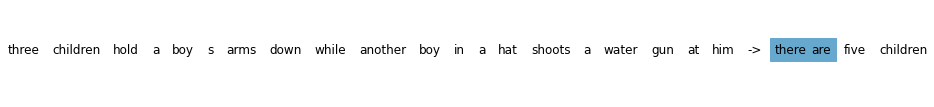


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ["Three children hold a boy's arms down while another boy in a hat shoots a water gun at him.", 'There are five children.']
gold label: entailment
pred label: entailment
explanations: [(('children', 'boy', 'boy'), ('children',))]
interactions_vote: [(['water', 'gun'], ['five', 'children'])]
interactions_union: [(['Three', 'children'], ['five', 'children']), (['a', 'boy', 's', 'arms'], ['five', 'children']), (['another', 'boy'], ['five', 'children']), (['shoots'], ['five', 'children']), (['water', 'gun'], ['five', 'children'])]


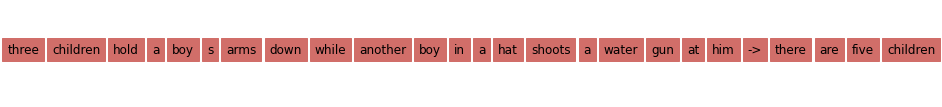


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ["Three children hold a boy's arms down while another boy in a hat shoots a water gun at him.", 'There are five children.']
gold label: entailment
pred label: entailment
explanations: [(('three',), ('children',)), (('another',), ('children',)), (('boy',), ('children',)), (('another',), ('there',)), (('children',), ('children',)), (('boy',), ('there',)), (('children',), ('there',)), (('three',), ('there',)), (('hold',), ('children',)), (('arms',), ('children',)), (('while',), ('children',)), (('a',), ('children',)), (('gun',), ('there',)), (('down',), ('children',)), (('shoots',), ('children',)), (('gun',), ('children',))]
interactions_vote: [(['water', 'gun'], ['five', 'children'])]
interactions_union: [(['Three', 'children'], ['five', 'children']), (['a', 'boy', 's', 'arms'], ['five', 'children']), (['another', 'boy'], ['five', 'children']), (['shoots'], ['five', 'children']), (['water', 'gun'], ['five', 'c

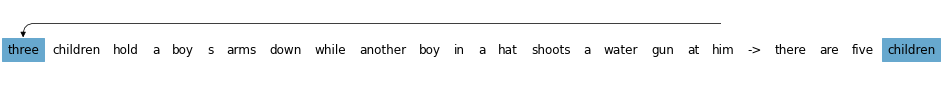


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ["Three children hold a boy's arms down while another boy in a hat shoots a water gun at him.", 'There are five children.']
gold label: entailment
pred label: entailment
explanations: [(('boy', 'another'), ('children',)), (('another', 'boy'), ('children',)), (('three', 'boy'), ('children',)), (('three', 'another'), ('children',)), (('boy',), ('there', 'children')), (('three', 'children'), ('children',)), (('boy', 'another'), ('there',)), (('another',), ('there', 'children')), (('down', 'boy'), ('children',))]
interactions_vote: [(['water', 'gun'], ['five', 'children'])]
interactions_union: [(['Three', 'children'], ['five', 'children']), (['a', 'boy', 's', 'arms'], ['five', 'children']), (['another', 'boy'], ['five', 'children']), (['shoots'], ['five', 'children']), (['water', 'gun'], ['five', 'children'])]


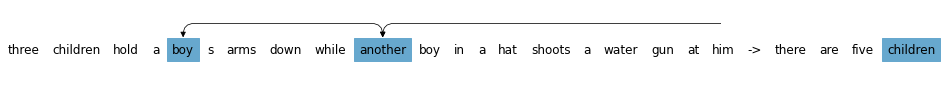


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ["Three children hold a boy's arms down while another boy in a hat shoots a water gun at him.", 'There are five children.']
gold label: entailment
pred label: entailment
explanations: [(('three', 'boy', 'another'), ('children',)), (('three', 'another', 'boy'), ('children',)), (('three', 'children', 'another'), ('children',)), (('boy', 'another'), ('there', 'children')), (('another', 'boy'), ('there', 'children')), (('three', 'boy', 'another'), ('there',)), (('children', 'another'), ('there', 'children')), (('three', 'another'), ('there', 'children')), (('three', 'arms', 'another'), ('children',)), (('three', 'another', 'boy'), ('there',)), (('three', 'boy'), ('there', 'children')), (('children', 'boy', 'another'), ('children',)), (('three', 'children', 'another'), ('there',)), (('another', 'boy', 'a'), ('children',)), (('boy', 'arms', 'another'), ('children',)), (('boy', 'another', 'a'), ('childre

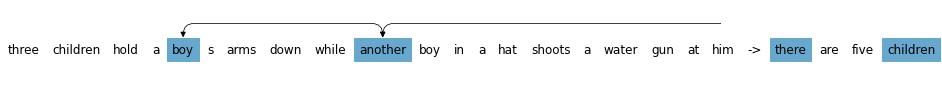

############################ 77 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['A boy is being splashed in a swimming pool.', 'A boy is splashing others at the beach.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('beach',)), (('pool',), ()), ((), ('others',)), ((), ('boy',)), (('A',), ()), ((), ()), (('a',), ())]
interactions_vote: [(['being', 'splashed'], ['splashing']), (['being', 'splashed'], ['beach']), (['swimming', 'pool'], ['splashing']), (['swimming', 'pool'], ['beach'])]
interactions_union: [(['being', 'splashed', 'in', 'a', 'swimming', 'pool'], ['splashing']), (['being', 'splashed', 'in', 'a', 'swimming', 'pool'], ['at', 'the', 'beach'])]


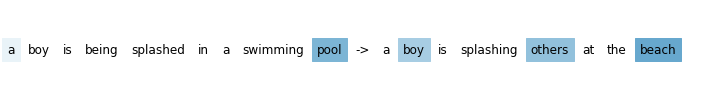


bert-base_arch-5_test_BT=[MASK].json
texts: ['A boy is being splashed in a swimming pool.', 'A boy is splashing others at the beach.']
gold label: contradiction
pred label: contradiction
explanations: [(('being', 'pool'), ('splashing', 'at', 'beach'))]
interactions_vote: [(['being', 'splashed'], ['splashing']), (['being', 'splashed'], ['beach']), (['swimming', 'pool'], ['splashing']), (['swimming', 'pool'], ['beach'])]
interactions_union: [(['being', 'splashed', 'in', 'a', 'swimming', 'pool'], ['splashing']), (['being', 'splashed', 'in', 'a', 'swimming', 'pool'], ['at', 'the', 'beach'])]


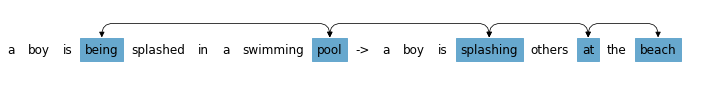


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A boy is being splashed in a swimming pool.', 'A boy is splashing others at the beach.']
gold label: contradiction
pred label: contradiction
explanations: [(('splashed', 'pool'), ('splashing', 'beach'))]
interactions_vote: [(['being', 'splashed'], ['splashing']), (['being', 'splashed'], ['beach']), (['swimming', 'pool'], ['splashing']), (['swimming', 'pool'], ['beach'])]
interactions_union: [(['being', 'splashed', 'in', 'a', 'swimming', 'pool'], ['splashing']), (['being', 'splashed', 'in', 'a', 'swimming', 'pool'], ['at', 'the', 'beach'])]


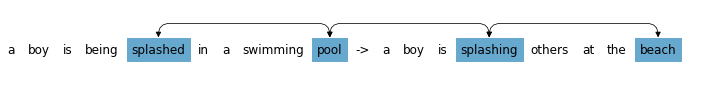


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A boy is being splashed in a swimming pool.', 'A boy is splashing others at the beach.']
gold label: contradiction
pred label: contradiction
explanations: [(('pool',), ('beach',)), (('in',), ('beach',)), (('is',), ('beach',)), (('being',), ('beach',)), (('a',), ('beach',)), (('boy',), ('beach',)), (('pool',), ('boy',)), (('pool',), ('the',)), (('pool',), ('at',)), (('splashed',), ('beach',)), (('pool',), ('others',)), (('pool',), ('is',)), (('pool',), ('a',)), (('pool',), ('splashing',)), (('swimming',), ('beach',)), (('in',), ('boy',)), (('being',), ('boy',)), (('a',), ('boy',))]
interactions_vote: [(['being', 'splashed'], ['splashing']), (['being', 'splashed'], ['beach']), (['swimming', 'pool'], ['splashing']), (['swimming', 'pool'], ['beach'])]
interactions_union: [(['being', 'splashed', 'in', 'a', 'swimming', 'pool'], ['splashing']), (['being', 'splashed', 'in', 'a', 'swimming', 'pool'], ['at', 'the', 

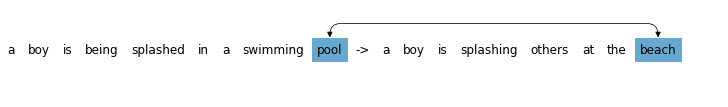


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A boy is being splashed in a swimming pool.', 'A boy is splashing others at the beach.']
gold label: contradiction
pred label: contradiction
explanations: [(('pool',), ('splashing', 'beach')), (('pool',), ('the', 'beach')), (('pool',), ('a', 'beach')), (('pool',), ('at', 'beach')), (('a', 'pool'), ('beach',)), (('is', 'pool'), ('beach',)), (('pool',), ('beach',)), (('in', 'pool'), ('beach',))]
interactions_vote: [(['being', 'splashed'], ['splashing']), (['being', 'splashed'], ['beach']), (['swimming', 'pool'], ['splashing']), (['swimming', 'pool'], ['beach'])]
interactions_union: [(['being', 'splashed', 'in', 'a', 'swimming', 'pool'], ['splashing']), (['being', 'splashed', 'in', 'a', 'swimming', 'pool'], ['at', 'the', 'beach'])]


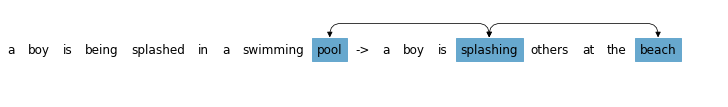


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A boy is being splashed in a swimming pool.', 'A boy is splashing others at the beach.']
gold label: contradiction
pred label: contradiction
explanations: [(('pool',), ('a', 'splashing', 'beach')), (('pool',), ('splashing', 'the', 'beach')), (('pool',), ('boy', 'splashing', 'beach')), (('a', 'pool'), ('the', 'beach')), (('a', 'pool'), ('splashing', 'beach')), (('being', 'pool'), ('the', 'beach')), (('pool',), ('at', 'the', 'beach')), (('being', 'pool'), ('splashing', 'beach')), (('pool',), ('a', 'the', 'beach')), (('is', 'pool'), ('the', 'beach')), (('is', 'pool'), ('splashing', 'beach')), (('in', 'pool'), ('the', 'beach')), (('being', 'in', 'pool'), ('beach',)), (('being', 'pool'), ('a', 'beach')), (('pool',), ('is', 'splashing', 'beach')), (('splashed', 'pool'), ('the', 'beach')), (('pool',), ('a', 'at', 'beach')), (('a', 'pool'), ('at', 'beach')), (('pool',), ('boy', 'the', 'beach'))]
interac

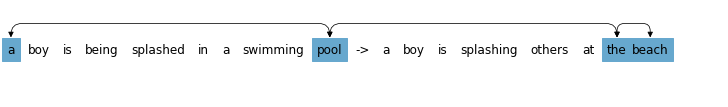

############################ 270 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['A group of people in bright green vests are purchasing food.', 'A group of people standing around waiting for a bus.']
gold label: contradiction
pred label: contradiction
explanations: [(('food',), ()), ((), ('bus',)), (('purchasing',), ()), ((), ('waiting',)), ((), ('standing',)), (('group',), ()), ((), ('around',)), (('vests',), ()), ((), ('A',)), (('people',), ()), (('in',), ()), (('bright',), ()), ((), ('for',)), (('green',), ()), ((), ('a',)), ((), ())]
interactions_vote: [(['purchasing', 'food'], ['waiting', 'for', 'a', 'bus'])]
interactions_union: [(['purchasing', 'food'], ['standing', 'around', 'waiting', 'for', 'a', 'bus'])]


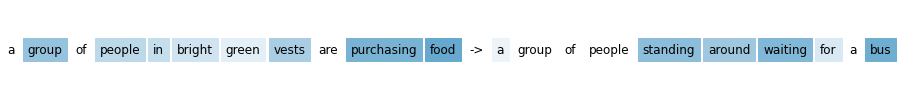


bert-base_arch-5_test_BT=[MASK].json
texts: ['A group of people in bright green vests are purchasing food.', 'A group of people standing around waiting for a bus.']
gold label: contradiction
pred label: contradiction
explanations: [(('purchasing', 'food'), ('bus',))]
interactions_vote: [(['purchasing', 'food'], ['waiting', 'for', 'a', 'bus'])]
interactions_union: [(['purchasing', 'food'], ['standing', 'around', 'waiting', 'for', 'a', 'bus'])]


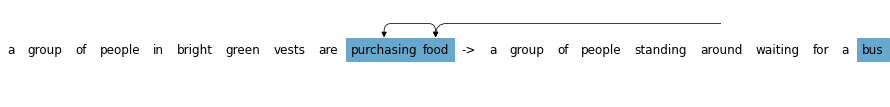


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A group of people in bright green vests are purchasing food.', 'A group of people standing around waiting for a bus.']
gold label: contradiction
pred label: contradiction
explanations: [(('food',), ('bus',)), (('purchasing',), ('bus',)), (('people',), ('bus',)), (('purchasing',), ('waiting',))]
interactions_vote: [(['purchasing', 'food'], ['waiting', 'for', 'a', 'bus'])]
interactions_union: [(['purchasing', 'food'], ['standing', 'around', 'waiting', 'for', 'a', 'bus'])]


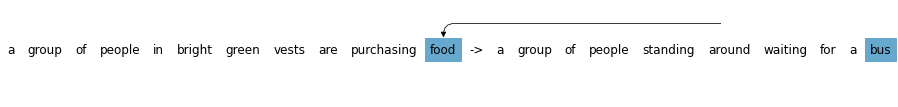


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A group of people in bright green vests are purchasing food.', 'A group of people standing around waiting for a bus.']
gold label: contradiction
pred label: contradiction
explanations: [(('food',), ('bus',)), (('purchasing',), ('bus',)), (('purchasing',), ('waiting',)), (('food',), ('waiting',)), (('group',), ('bus',)), (('food',), ('standing',)), (('vests',), ('bus',)), (('are',), ('bus',)), (('purchasing',), ('standing',)), (('purchasing',), ('around',)), (('bright',), ('bus',)), (('people',), ('bus',)), (('a',), ('bus',)), (('food',), ('around',)), (('food',), ('for',)), (('in',), ('bus',)), (('of',), ('bus',)), (('green',), ('bus',)), (('food',), ('a',))]
interactions_vote: [(['purchasing', 'food'], ['waiting', 'for', 'a', 'bus'])]
interactions_union: [(['purchasing', 'food'], ['standing', 'around', 'waiting', 'for', 'a', 'bus'])]


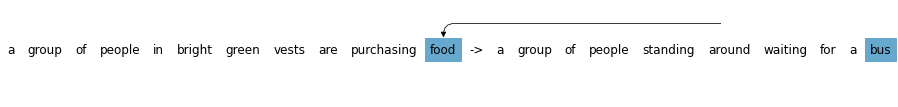


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A group of people in bright green vests are purchasing food.', 'A group of people standing around waiting for a bus.']
gold label: contradiction
pred label: contradiction
explanations: [(('food',), ('standing', 'bus')), (('food',), ('waiting', 'bus')), (('purchasing',), ('waiting', 'bus')), (('food',), ('a', 'bus')), (('food',), ('around', 'bus')), (('purchasing', 'food'), ('bus',)), (('food',), ('group', 'bus')), (('group', 'food'), ('bus',)), (('people', 'food'), ('bus',)), (('food',), ('people', 'bus'))]
interactions_vote: [(['purchasing', 'food'], ['waiting', 'for', 'a', 'bus'])]
interactions_union: [(['purchasing', 'food'], ['standing', 'around', 'waiting', 'for', 'a', 'bus'])]


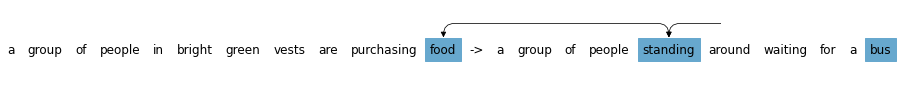


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A group of people in bright green vests are purchasing food.', 'A group of people standing around waiting for a bus.']
gold label: contradiction
pred label: contradiction
explanations: [(('food',), ('around', 'waiting', 'bus')), (('purchasing',), ('around', 'waiting', 'bus')), (('food',), ('standing', 'waiting', 'bus')), (('food',), ('standing', 'a', 'bus')), (('food',), ('standing', 'around', 'bus')), (('food',), ('people', 'standing', 'bus')), (('purchasing',), ('standing', 'waiting', 'bus')), (('of', 'food'), ('standing', 'bus')), (('green', 'food'), ('standing', 'bus')), (('food',), ('people', 'waiting', 'bus')), (('food',), ('standing', 'for', 'bus')), (('food',), ('a', 'standing', 'bus')), (('group', 'food'), ('standing', 'bus')), (('purchasing', 'food'), ('standing', 'bus')), (('food',), ('a', 'a', 'bus')), (('are', 'food'), ('standing', 'bus')), (('food',), ('group', 'waiting', 'bus')), 

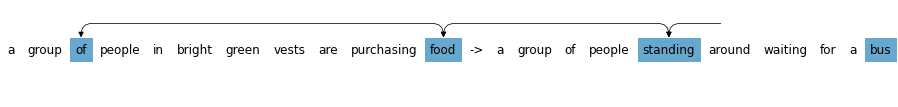

############################ 84 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['A young man holding a microphone and singing.', 'A man is performing a song.']
gold label: entailment
pred label: entailment
explanations: [(('singing',), ()), (('man',), ()), ((), ('a',)), ((), ('A',)), (('microphone',), ()), ((), ('performing',)), (('and',), ()), ((), ())]
interactions_vote: [(['man'], ['man']), (['man'], ['performing']), (['man'], ['song']), (['microphone'], ['man']), (['microphone'], ['performing']), (['microphone'], ['song']), (['singing'], ['man']), (['singing'], ['performing']), (['singing'], ['song'])]
interactions_union: [(['man'], ['man']), (['man'], ['performing', 'a', 'song']), (['microphone', 'and', 'singing'], ['man']), (['microphone', 'and', 'singing'], ['performing', 'a', 'song'])]


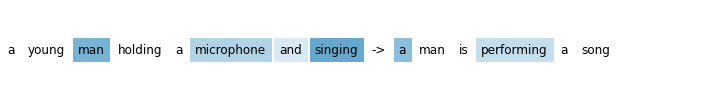


bert-base_arch-5_test_BT=[MASK].json
texts: ['A young man holding a microphone and singing.', 'A man is performing a song.']
gold label: entailment
pred label: entailment
explanations: [(('microphone', 'singing'), ('is', 'song'))]
interactions_vote: [(['man'], ['man']), (['man'], ['performing']), (['man'], ['song']), (['microphone'], ['man']), (['microphone'], ['performing']), (['microphone'], ['song']), (['singing'], ['man']), (['singing'], ['performing']), (['singing'], ['song'])]
interactions_union: [(['man'], ['man']), (['man'], ['performing', 'a', 'song']), (['microphone', 'and', 'singing'], ['man']), (['microphone', 'and', 'singing'], ['performing', 'a', 'song'])]


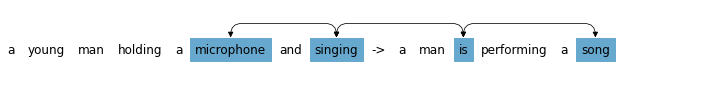


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A young man holding a microphone and singing.', 'A man is performing a song.']
gold label: entailment
pred label: entailment
explanations: [(('holding', 'singing'), ('song',)), (('man',), ('man',)), (('singing',), ('performing',))]
interactions_vote: [(['man'], ['man']), (['man'], ['performing']), (['man'], ['song']), (['microphone'], ['man']), (['microphone'], ['performing']), (['microphone'], ['song']), (['singing'], ['man']), (['singing'], ['performing']), (['singing'], ['song'])]
interactions_union: [(['man'], ['man']), (['man'], ['performing', 'a', 'song']), (['microphone', 'and', 'singing'], ['man']), (['microphone', 'and', 'singing'], ['performing', 'a', 'song'])]


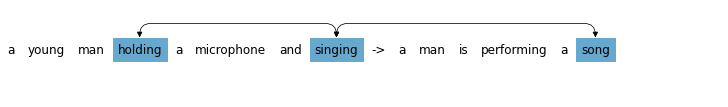


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A young man holding a microphone and singing.', 'A man is performing a song.']
gold label: entailment
pred label: entailment
explanations: [(('singing',), ('song',)), (('singing',), ('performing',)), (('singing',), ('a',)), (('singing',), ('is',)), (('singing',), ('man',)), (('man',), ('a',)), (('man',), ('song',)), (('and',), ('song',)), (('and',), ('a',)), (('man',), ('man',)), (('a',), ('a',)), (('microphone',), ('song',)), (('microphone',), ('a',)), (('a',), ('song',))]
interactions_vote: [(['man'], ['man']), (['man'], ['performing']), (['man'], ['song']), (['microphone'], ['man']), (['microphone'], ['performing']), (['microphone'], ['song']), (['singing'], ['man']), (['singing'], ['performing']), (['singing'], ['song'])]
interactions_union: [(['man'], ['man']), (['man'], ['performing', 'a', 'song']), (['microphone', 'and', 'singing'], ['man']), (['microphone', 'and', 'singing'], ['performing', 'a', 's

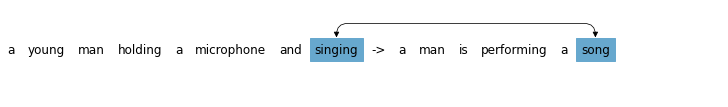


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A young man holding a microphone and singing.', 'A man is performing a song.']
gold label: entailment
pred label: entailment
explanations: [(('man', 'singing'), ('song',)), (('and', 'singing'), ('song',)), (('young', 'singing'), ('song',)), (('a', 'singing'), ('song',)), (('singing',), ('a', 'song')), (('microphone', 'singing'), ('song',)), (('man', 'singing'), ('a',)), (('singing',), ('song',))]
interactions_vote: [(['man'], ['man']), (['man'], ['performing']), (['man'], ['song']), (['microphone'], ['man']), (['microphone'], ['performing']), (['microphone'], ['song']), (['singing'], ['man']), (['singing'], ['performing']), (['singing'], ['song'])]
interactions_union: [(['man'], ['man']), (['man'], ['performing', 'a', 'song']), (['microphone', 'and', 'singing'], ['man']), (['microphone', 'and', 'singing'], ['performing', 'a', 'song'])]


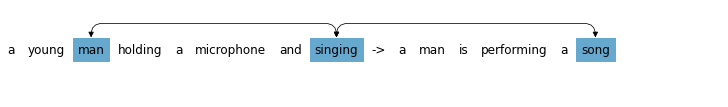


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A young man holding a microphone and singing.', 'A man is performing a song.']
gold label: entailment
pred label: entailment
explanations: [(('man', 'and', 'singing'), ('song',)), (('man', 'singing'), ('a', 'song')), (('young', 'man', 'singing'), ('song',)), (('a', 'man', 'singing'), ('song',)), (('man', 'microphone', 'singing'), ('song',)), (('man', 'a', 'singing'), ('song',)), (('man', 'singing'), ('man', 'song')), (('man', 'holding', 'singing'), ('song',)), (('man', 'singing'), ('performing', 'song')), (('man', 'singing'), ('is', 'song')), (('young', 'and', 'singing'), ('song',)), (('a', 'and', 'singing'), ('song',)), (('microphone', 'and', 'singing'), ('song',)), (('young', 'microphone', 'singing'), ('song',)), (('man', 'and', 'singing'), ('performing',)), (('and', 'singing'), ('a', 'song')), (('man', 'microphone', 'singing'), ('performing',)), (('a', 'young', 'singing'), ('song',))]
interac

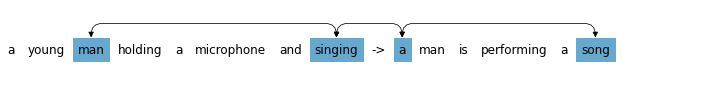

############################ 532 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['A man is celebrating his victory while smiling and shooting champagne in the air with his teammate.', 'A man is celebrating his victory while smiling and shooting champagne in the air']
gold label: entailment
pred label: entailment
explanations: [(('champagne',), ()), (('victory',), ()), (('smiling',), ()), (('celebrating',), ()), ((), ('air',)), (('shooting',), ()), (('man',), ()), (('air',), ()), ((), ('while',)), (('his',), ())]
interactions_vote: []
interactions_union: [(['man'], ['A', 'man']), (['man'], ['celebrating']), (['man'], ['victory']), (['man'], ['smiling']), (['celebrating'], ['A', 'man']), (['celebrating'], ['celebrating']), (['celebrating'], ['victory']), (['celebrating'], ['smiling']), (['victory'], ['A', 'man']), (['victory'], ['celebrating']), (['victory'], ['victory']), (['victory'], ['smiling']), (['with', 'his', 'teammate'], ['A', 'man']), (['with'

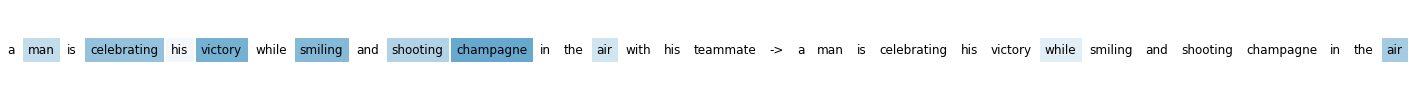


bert-base_arch-5_test_BT=[MASK].json
texts: ['A man is celebrating his victory while smiling and shooting champagne in the air with his teammate.', 'A man is celebrating his victory while smiling and shooting champagne in the air']
gold label: entailment
pred label: entailment
explanations: [(('victory', 'smiling', 'champagne'), ('victory', 'champagne'))]
interactions_vote: []
interactions_union: [(['man'], ['A', 'man']), (['man'], ['celebrating']), (['man'], ['victory']), (['man'], ['smiling']), (['celebrating'], ['A', 'man']), (['celebrating'], ['celebrating']), (['celebrating'], ['victory']), (['celebrating'], ['smiling']), (['victory'], ['A', 'man']), (['victory'], ['celebrating']), (['victory'], ['victory']), (['victory'], ['smiling']), (['with', 'his', 'teammate'], ['A', 'man']), (['with', 'his', 'teammate'], ['celebrating']), (['with', 'his', 'teammate'], ['victory']), (['with', 'his', 'teammate'], ['smiling'])]


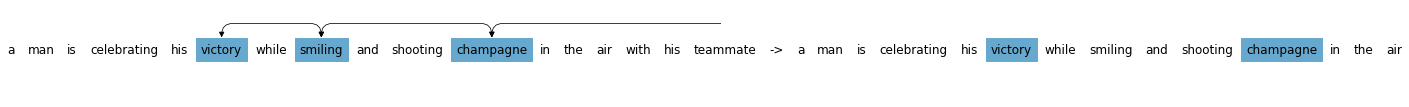


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A man is celebrating his victory while smiling and shooting champagne in the air with his teammate.', 'A man is celebrating his victory while smiling and shooting champagne in the air']
gold label: entailment
pred label: entailment
explanations: [(('shooting',), ('shooting',)), (('smiling', 'champagne'), ('victory', 'champagne')), (('victory',), ('victory',))]
interactions_vote: []
interactions_union: [(['man'], ['A', 'man']), (['man'], ['celebrating']), (['man'], ['victory']), (['man'], ['smiling']), (['celebrating'], ['A', 'man']), (['celebrating'], ['celebrating']), (['celebrating'], ['victory']), (['celebrating'], ['smiling']), (['victory'], ['A', 'man']), (['victory'], ['celebrating']), (['victory'], ['victory']), (['victory'], ['smiling']), (['with', 'his', 'teammate'], ['A', 'man']), (['with', 'his', 'teammate'], ['celebrating']), (['with', 'his', 'teammate'], ['victory']), (['with', 'his', 'teammate'], ['smiling'])]


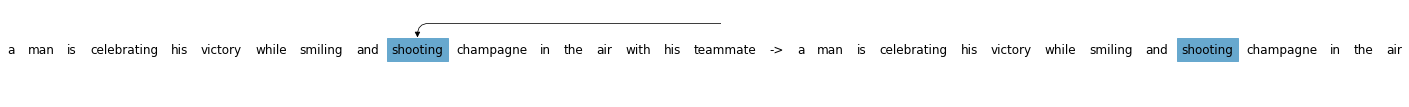


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A man is celebrating his victory while smiling and shooting champagne in the air with his teammate.', 'A man is celebrating his victory while smiling and shooting champagne in the air']
gold label: entailment
pred label: entailment
explanations: [(('champagne',), ('champagne',)), (('champagne',), ('and',)), (('champagne',), ('while',)), (('champagne',), ('air',)), (('champagne',), ('his',)), (('champagne',), ('a',)), (('champagne',), ('celebrating',)), (('champagne',), ('in',)), (('champagne',), ('is',)), (('champagne',), ('the',)), (('champagne',), ('man',)), (('victory',), ('celebrating',)), (('champagne',), ('shooting',)), (('victory',), ('air',)), (('victory',), ('and',)), (('victory',), ('his',)), (('victory',), ('a',)), (('champagne',), ('smiling',)), (('victory',), ('while',)), (('victory',), ('in',))]
interactions_vote: []
interactions_union: [(['man'], ['A', 'man']), (['man'], ['celebrating']), ([

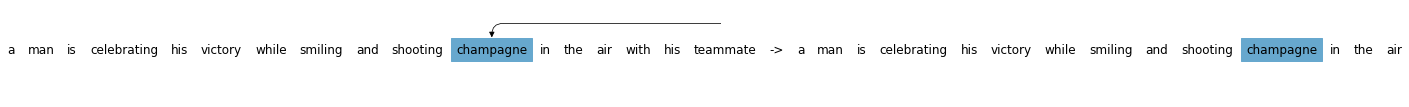


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A man is celebrating his victory while smiling and shooting champagne in the air with his teammate.', 'A man is celebrating his victory while smiling and shooting champagne in the air']
gold label: entailment
pred label: entailment
explanations: [(('victory', 'champagne'), ('champagne',)), (('victory', 'champagne'), ('celebrating',)), (('victory', 'champagne'), ('while',)), (('smiling', 'champagne'), ('champagne',)), (('victory', 'champagne'), ('and',)), (('victory', 'champagne'), ('air',)), (('celebrating', 'champagne'), ('champagne',)), (('victory', 'champagne'), ('his',)), (('victory', 'champagne'), ('in',)), (('victory', 'champagne'), ('a',))]
interactions_vote: []
interactions_union: [(['man'], ['A', 'man']), (['man'], ['celebrating']), (['man'], ['victory']), (['man'], ['smiling']), (['celebrating'], ['A', 'man']), (['celebrating'], ['celebrating']), (['celebrating'], ['victory']), (['celebrating'], 

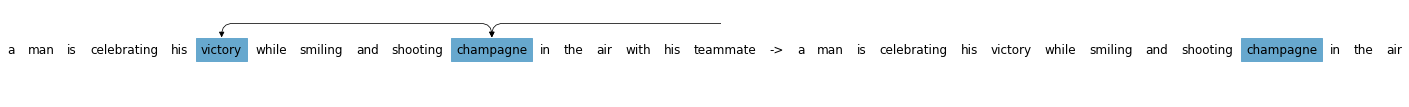


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A man is celebrating his victory while smiling and shooting champagne in the air with his teammate.', 'A man is celebrating his victory while smiling and shooting champagne in the air']
gold label: entailment
pred label: entailment
explanations: [(('victory', 'smiling', 'champagne'), ('champagne',)), (('celebrating', 'victory', 'champagne'), ('champagne',)), (('his', 'victory', 'champagne'), ('champagne',)), (('victory', 'and', 'champagne'), ('champagne',)), (('victory', 'smiling', 'champagne'), ('celebrating',)), (('man', 'victory', 'champagne'), ('champagne',)), (('victory', 'champagne'), ('celebrating', 'champagne')), (('victory', 'champagne'), ('a', 'champagne')), (('victory', 'champagne'), ('while', 'champagne')), (('victory', 'shooting', 'champagne'), ('champagne',)), (('victory', 'champagne', 'the'), ('champagne',)), (('victory', 'smiling', 'champagne'), ('air',)), (('victory', 'champagne

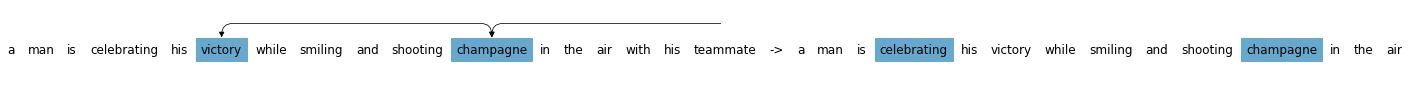

############################ 640 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['Two young girls with long brunette hair, standing in front of a stone wall playing a game.', 'Two girls playing hopscotch.']
gold label: neutral
pred label: neutral
explanations: [((), ('hopscotch',)), (('game',), ()), ((), ('playing',)), (('playing',), ()), (('Two',), ()), (('wall',), ()), (('a',), ()), ((), ('girls',)), (('in',), ()), (('girls',), ()), (('standing',), ()), (('of',), ()), (('long',), ()), (('brunette',), ()), ((), ('Two',)), (('front',), ())]
interactions_vote: []
interactions_union: []


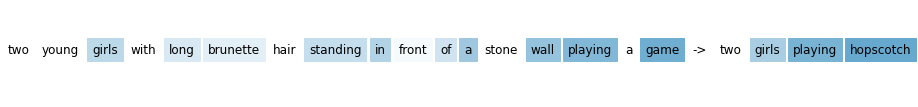


bert-base_arch-5_test_BT=[MASK].json
texts: ['Two young girls with long brunette hair, standing in front of a stone wall playing a game.', 'Two girls playing hopscotch.']
gold label: neutral
pred label: neutral
explanations: [(('playing', 'game'), ('playing', 'hopscotch')), (('two', 'girls'), ('girls',))]
interactions_vote: []
interactions_union: []


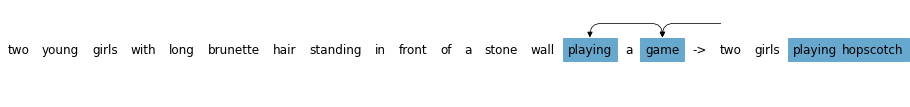


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['Two young girls with long brunette hair, standing in front of a stone wall playing a game.', 'Two girls playing hopscotch.']
gold label: neutral
pred label: neutral
explanations: [(('game',), ('playing',)), (('two',), ('girls',)), (('girls',), ('girls',)), (('two',), ('two',)), (('game',), ('hopscotch',))]
interactions_vote: []
interactions_union: []


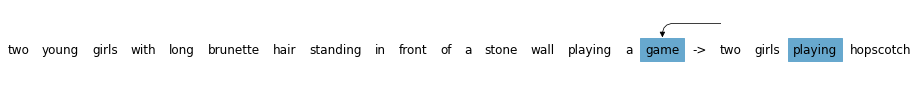


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Two young girls with long brunette hair, standing in front of a stone wall playing a game.', 'Two girls playing hopscotch.']
gold label: neutral
pred label: neutral
explanations: [(('playing',), ('playing',)), (('game',), ('playing',)), (('two',), ('playing',)), (('girls',), ('playing',)), (('in',), ('playing',)), (('of',), ('playing',)), (('a',), ('playing',)), (('brunette',), ('playing',)), (('with',), ('playing',)), (('front',), ('playing',)), (('wall',), ('playing',)), (('young',), ('playing',)), (('game',), ('hopscotch',)), (('playing',), ('hopscotch',)), (('hair',), ('playing',)), (('long',), ('playing',)), (('standing',), ('playing',)), (('two',), ('hopscotch',))]
interactions_vote: []
interactions_union: []


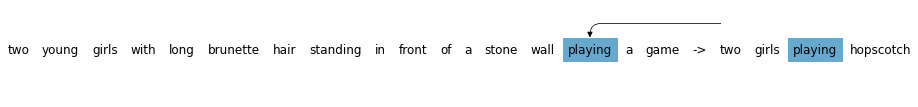


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Two young girls with long brunette hair, standing in front of a stone wall playing a game.', 'Two girls playing hopscotch.']
gold label: neutral
pred label: neutral
explanations: [(('playing',), ('playing', 'hopscotch')), (('game',), ('playing', 'hopscotch')), (('in', 'playing'), ('playing',)), (('two', 'playing'), ('playing',)), (('front', 'playing'), ('playing',)), (('two',), ('playing', 'hopscotch')), (('brunette',), ('playing', 'hopscotch')), (('girls', 'game'), ('playing',)), (('girls',), ('playing', 'hopscotch'))]
interactions_vote: []
interactions_union: []


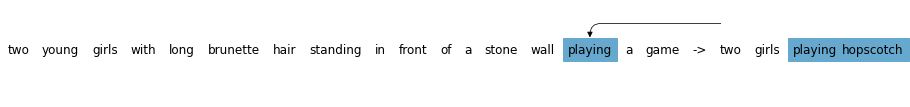


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['Two young girls with long brunette hair, standing in front of a stone wall playing a game.', 'Two girls playing hopscotch.']
gold label: neutral
pred label: neutral
explanations: [(('two', 'game'), ('playing', 'hopscotch')), (('front', 'playing'), ('playing', 'hopscotch')), (('two', 'playing'), ('playing', 'hopscotch')), (('girls', 'game'), ('playing', 'hopscotch')), (('brunette', 'game'), ('playing', 'hopscotch')), (('girls', 'playing'), ('playing', 'hopscotch')), (('in', 'playing'), ('playing', 'hopscotch')), (('in', 'game'), ('playing', 'hopscotch')), (('brunette', 'playing'), ('playing', 'hopscotch')), (('of', 'playing'), ('playing', 'hopscotch')), (('front', 'game'), ('playing', 'hopscotch')), (('playing', 'game'), ('playing', 'hopscotch')), (('game',), ('girls', 'playing', 'hopscotch')), (('a', 'game'), ('playing', 'hopscotch')), (('playing',), ('girls', 'playing', 'hopscotch')), (('playin

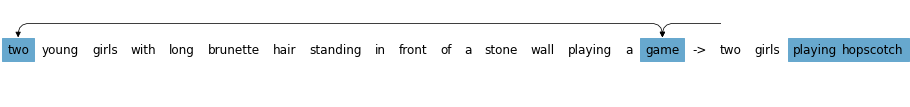

############################ 283 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['a lone snowboarder jumping in midair with a snow covered mine in the background', 'A person snowboarding in mid air']
gold label: entailment
pred label: entailment
explanations: [(('snowboarder',), ()), (('midair',), ()), (('jumping',), ()), ((), ('air',)), ((), ('person',)), (('snow',), ()), ((), ('A',)), (('mine',), ()), (('the',), ()), (('in',), ()), (('with',), ())]
interactions_vote: [(['a'], ['person', 'snowboarding']), (['snowboarder', 'jumping', 'in', 'midair'], ['person', 'snowboarding'])]
interactions_union: [(['a', 'lone', 'snowboarder', 'jumping', 'in', 'midair', 'with'], ['A', 'person', 'snowboarding']), (['a', 'lone', 'snowboarder', 'jumping', 'in', 'midair', 'with'], ['mid', 'air'])]


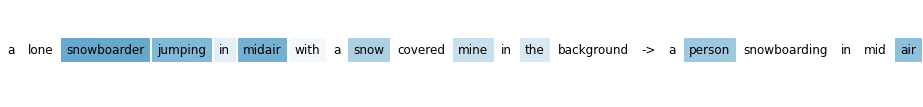


bert-base_arch-5_test_BT=[MASK].json
texts: ['a lone snowboarder jumping in midair with a snow covered mine in the background', 'A person snowboarding in mid air']
gold label: entailment
pred label: entailment
explanations: [(('snowboarder', 'snow'), ('snowboarding',))]
interactions_vote: [(['a'], ['person', 'snowboarding']), (['snowboarder', 'jumping', 'in', 'midair'], ['person', 'snowboarding'])]
interactions_union: [(['a', 'lone', 'snowboarder', 'jumping', 'in', 'midair', 'with'], ['A', 'person', 'snowboarding']), (['a', 'lone', 'snowboarder', 'jumping', 'in', 'midair', 'with'], ['mid', 'air'])]


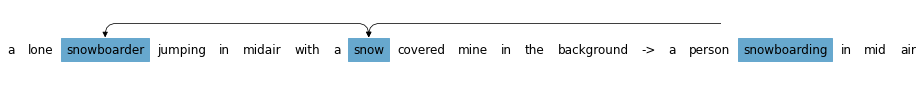


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['a lone snowboarder jumping in midair with a snow covered mine in the background', 'A person snowboarding in mid air']
gold label: entailment
pred label: entailment
explanations: [(('snowboarder',), ('snowboarding',)), (('snow',), ('snowboarding',)), (('midair',), ('mid',))]
interactions_vote: [(['a'], ['person', 'snowboarding']), (['snowboarder', 'jumping', 'in', 'midair'], ['person', 'snowboarding'])]
interactions_union: [(['a', 'lone', 'snowboarder', 'jumping', 'in', 'midair', 'with'], ['A', 'person', 'snowboarding']), (['a', 'lone', 'snowboarder', 'jumping', 'in', 'midair', 'with'], ['mid', 'air'])]


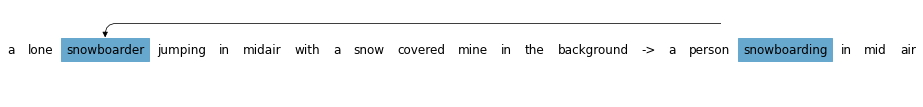


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['a lone snowboarder jumping in midair with a snow covered mine in the background', 'A person snowboarding in mid air']
gold label: entailment
pred label: entailment
explanations: [(('jumping',), ('air',)), (('snowboarder',), ('air',)), (('midair',), ('air',)), (('snowboarder',), ('snowboarding',)), (('snowboarder',), ('a',)), (('snowboarder',), ('in',)), (('snow',), ('air',)), (('snowboarder',), ('person',)), (('midair',), ('a',)), (('midair',), ('mid',)), (('snow',), ('snowboarding',)), (('midair',), ('person',)), (('snowboarder',), ('mid',)), (('jumping',), ('a',)), (('snow',), ('a',)), (('midair',), ('in',))]
interactions_vote: [(['a'], ['person', 'snowboarding']), (['snowboarder', 'jumping', 'in', 'midair'], ['person', 'snowboarding'])]
interactions_union: [(['a', 'lone', 'snowboarder', 'jumping', 'in', 'midair', 'with'], ['A', 'person', 'snowboarding']), (['a', 'lone', 'snowboarder', 'jumping', 'in', '

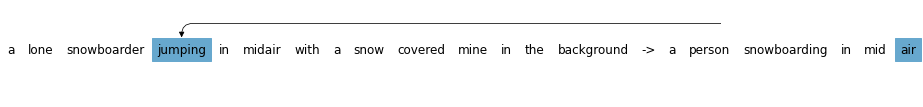


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['a lone snowboarder jumping in midair with a snow covered mine in the background', 'A person snowboarding in mid air']
gold label: entailment
pred label: entailment
explanations: [(('snowboarder', 'midair'), ('air',)), (('snowboarder', 'jumping'), ('air',)), (('snowboarder',), ('air',)), (('snowboarder', 'jumping'), ('a',)), (('midair', 'snow'), ('air',)), (('snowboarder', 'midair'), ('snowboarding',)), (('snowboarder', 'midair'), ('mid',)), (('jumping', 'snow'), ('air',))]
interactions_vote: [(['a'], ['person', 'snowboarding']), (['snowboarder', 'jumping', 'in', 'midair'], ['person', 'snowboarding'])]
interactions_union: [(['a', 'lone', 'snowboarder', 'jumping', 'in', 'midair', 'with'], ['A', 'person', 'snowboarding']), (['a', 'lone', 'snowboarder', 'jumping', 'in', 'midair', 'with'], ['mid', 'air'])]


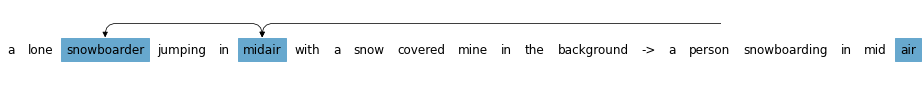


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['a lone snowboarder jumping in midair with a snow covered mine in the background', 'A person snowboarding in mid air']
gold label: entailment
pred label: entailment
explanations: [(('snowboarder', 'jumping'), ('air',)), (('snowboarder', 'jumping', 'snow'), ('air',)), (('snowboarder', 'midair'), ('air',)), (('snowboarder', 'midair', 'snow'), ('air',)), (('snowboarder', 'midair', 'snow'), ('a',)), (('snowboarder', 'midair'), ('a',)), (('snowboarder', 'midair'), ('a', 'air')), (('snowboarder', 'jumping'), ('mid', 'air')), (('snowboarder', 'midair', 'mine'), ('air',)), (('snowboarder', 'midair', 'snow'), ('mid',)), (('snowboarder', 'in', 'midair'), ('air',)), (('snowboarder', 'jumping', 'with'), ('air',)), (('snowboarder', 'midair'), ('mid',)), (('snowboarder', 'midair'), ('snowboarding',)), (('snowboarder', 'jumping', 'midair'), ('air',)), (('snowboarder', 'jumping'), ('in', 'air')), (('snowboarder'

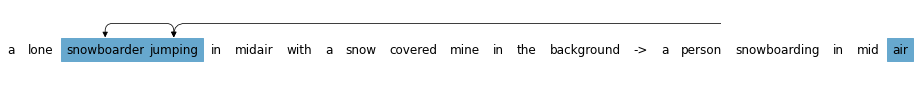

############################ 137 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['A man and woman look upward on a city block.', 'A man and woman are scuba diving.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('scuba',)), ((), ('diving',)), (('city',), ()), ((), ('man',)), (('block',), ()), (('look',), ()), ((), ('and',)), (('on',), ()), ((), ('woman',)), (('A',), ()), (('a',), ()), ((), ('are',))]
interactions_vote: [(['look'], ['scuba', 'diving']), (['city', 'block'], ['scuba', 'diving'])]
interactions_union: [(['look', 'upward'], ['scuba', 'diving']), (['city', 'block'], ['scuba', 'diving'])]


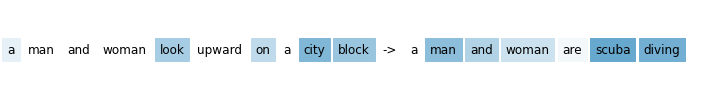


bert-base_arch-5_test_BT=[MASK].json
texts: ['A man and woman look upward on a city block.', 'A man and woman are scuba diving.']
gold label: contradiction
pred label: contradiction
explanations: [(('woman',), ('man',)), (('look', 'upward'), ('scuba', 'diving')), (('man',), ('woman',))]
interactions_vote: [(['look'], ['scuba', 'diving']), (['city', 'block'], ['scuba', 'diving'])]
interactions_union: [(['look', 'upward'], ['scuba', 'diving']), (['city', 'block'], ['scuba', 'diving'])]


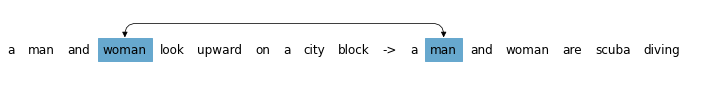


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A man and woman look upward on a city block.', 'A man and woman are scuba diving.']
gold label: contradiction
pred label: contradiction
explanations: [(('man',), ('woman',)), (('woman',), ('man', 'woman'))]
interactions_vote: [(['look'], ['scuba', 'diving']), (['city', 'block'], ['scuba', 'diving'])]
interactions_union: [(['look', 'upward'], ['scuba', 'diving']), (['city', 'block'], ['scuba', 'diving'])]


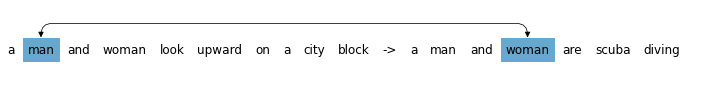


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A man and woman look upward on a city block.', 'A man and woman are scuba diving.']
gold label: contradiction
pred label: contradiction
explanations: [(('block',), ('scuba',)), (('city',), ('scuba',)), (('woman',), ('scuba',)), (('look',), ('scuba',)), (('man',), ('scuba',)), (('on',), ('scuba',)), (('and',), ('scuba',)), (('upward',), ('scuba',)), (('a',), ('scuba',)), (('block',), ('diving',)), (('city',), ('diving',)), (('woman',), ('diving',)), (('on',), ('diving',)), (('look',), ('diving',)), (('man',), ('diving',)), (('a',), ('diving',)), (('and',), ('diving',)), (('city',), ('are',))]
interactions_vote: [(['look'], ['scuba', 'diving']), (['city', 'block'], ['scuba', 'diving'])]
interactions_union: [(['look', 'upward'], ['scuba', 'diving']), (['city', 'block'], ['scuba', 'diving'])]


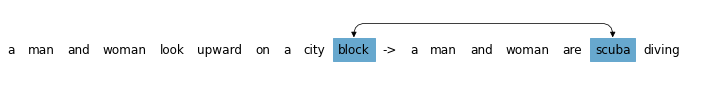


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A man and woman look upward on a city block.', 'A man and woman are scuba diving.']
gold label: contradiction
pred label: contradiction
explanations: [(('city',), ('scuba', 'diving')), (('block',), ('scuba', 'diving')), (('city',), ('and', 'scuba')), (('city',), ('woman', 'scuba')), (('block',), ('and', 'scuba')), (('block',), ('woman', 'scuba')), (('and', 'city'), ('scuba',)), (('and', 'block'), ('scuba',)), (('a', 'block'), ('scuba',)), (('man', 'block'), ('scuba',))]
interactions_vote: [(['look'], ['scuba', 'diving']), (['city', 'block'], ['scuba', 'diving'])]
interactions_union: [(['look', 'upward'], ['scuba', 'diving']), (['city', 'block'], ['scuba', 'diving'])]


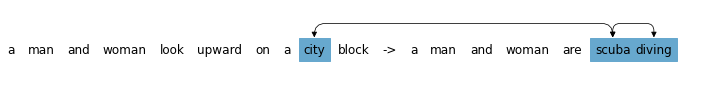


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A man and woman look upward on a city block.', 'A man and woman are scuba diving.']
gold label: contradiction
pred label: contradiction
explanations: [(('look', 'city'), ('scuba', 'diving')), (('city',), ('and', 'woman', 'scuba')), (('city',), ('woman', 'scuba', 'diving')), (('city',), ('man', 'and', 'scuba')), (('city', 'block'), ('scuba', 'diving')), (('woman', 'city'), ('scuba', 'diving')), (('man', 'city'), ('scuba', 'diving')), (('city',), ('and', 'scuba', 'diving')), (('city',), ('a', 'scuba', 'diving')), (('and', 'city'), ('scuba', 'diving')), (('city',), ('man', 'scuba', 'diving')), (('city', 'block'), ('and', 'scuba')), (('a', 'city'), ('scuba', 'diving')), (('block',), ('woman', 'scuba', 'diving')), (('look', 'city'), ('and', 'scuba')), (('a', 'city'), ('and', 'scuba')), (('man', 'city'), ('and', 'scuba')), (('and', 'city'), ('and', 'scuba')), (('woman', 'block'), ('scuba', 'diving'))]

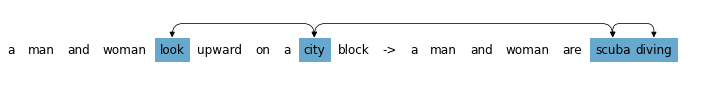

############################ 109 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['A woman wearing a striped wrap is bent over in a cornfield while looking at the camera.', 'A man wearing a bathing suit is bent over in a cornfield while looking at the camera.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('bathing',)), ((), ('suit',)), ((), ('man',)), (('woman',), ()), (('wrap',), ()), (('striped',), ()), (('is',), ()), ((), ('while',)), (('A',), ()), ((), ('over',)), ((), ('a',)), (('wearing',), ()), ((), ('A',))]
interactions_vote: [(['woman'], ['man']), (['woman'], ['bathing', 'suit']), (['striped', 'wrap'], ['man']), (['striped', 'wrap'], ['bathing', 'suit'])]
interactions_union: [(['A', 'woman'], ['A', 'man']), (['A', 'woman'], ['bathing', 'suit']), (['striped', 'wrap'], ['A', 'man']), (['striped', 'wrap'], ['bathing', 'suit'])]


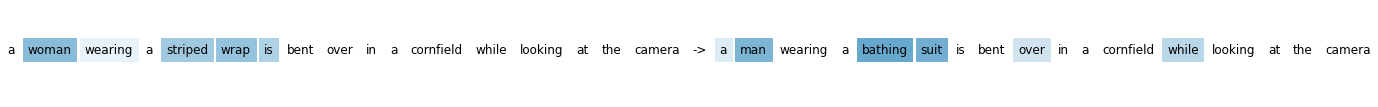


bert-base_arch-5_test_BT=[MASK].json
texts: ['A woman wearing a striped wrap is bent over in a cornfield while looking at the camera.', 'A man wearing a bathing suit is bent over in a cornfield while looking at the camera.']
gold label: contradiction
pred label: contradiction
explanations: [(('woman',), ('man',))]
interactions_vote: [(['woman'], ['man']), (['woman'], ['bathing', 'suit']), (['striped', 'wrap'], ['man']), (['striped', 'wrap'], ['bathing', 'suit'])]
interactions_union: [(['A', 'woman'], ['A', 'man']), (['A', 'woman'], ['bathing', 'suit']), (['striped', 'wrap'], ['A', 'man']), (['striped', 'wrap'], ['bathing', 'suit'])]


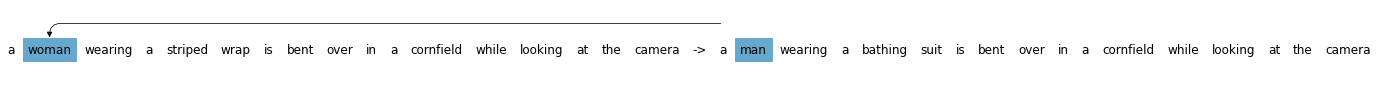


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A woman wearing a striped wrap is bent over in a cornfield while looking at the camera.', 'A man wearing a bathing suit is bent over in a cornfield while looking at the camera.']
gold label: contradiction
pred label: contradiction
explanations: [(('woman',), ('man',))]
interactions_vote: [(['woman'], ['man']), (['woman'], ['bathing', 'suit']), (['striped', 'wrap'], ['man']), (['striped', 'wrap'], ['bathing', 'suit'])]
interactions_union: [(['A', 'woman'], ['A', 'man']), (['A', 'woman'], ['bathing', 'suit']), (['striped', 'wrap'], ['A', 'man']), (['striped', 'wrap'], ['bathing', 'suit'])]


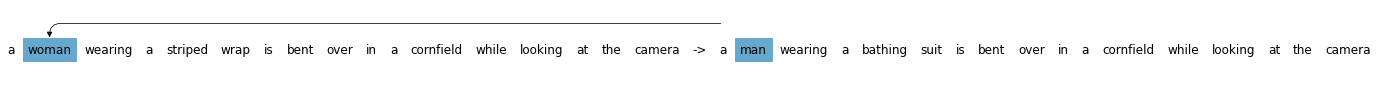


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A woman wearing a striped wrap is bent over in a cornfield while looking at the camera.', 'A man wearing a bathing suit is bent over in a cornfield while looking at the camera.']
gold label: contradiction
pred label: contradiction
explanations: [(('woman',), ('man',)), (('wrap',), ('bathing',)), (('wrap',), ('suit',)), (('woman',), ('suit',)), (('striped',), ('suit',)), (('striped',), ('bathing',)), (('woman',), ('bathing',)), (('wearing',), ('suit',)), (('wearing',), ('bathing',)), (('camera',), ('bathing',)), (('at',), ('suit',)), (('at',), ('bathing',)), (('camera',), ('suit',)), (('is',), ('suit',)), (('is',), ('bathing',)), (('wrap',), ('man',)), (('in',), ('suit',)), (('over',), ('bathing',)), (('striped',), ('man',)), (('while',), ('suit',))]
interactions_vote: [(['woman'], ['man']), (['woman'], ['bathing', 'suit']), (['striped', 'wrap'], ['man']), (['striped', 'wrap'], ['bathing', 'suit'])]
interac

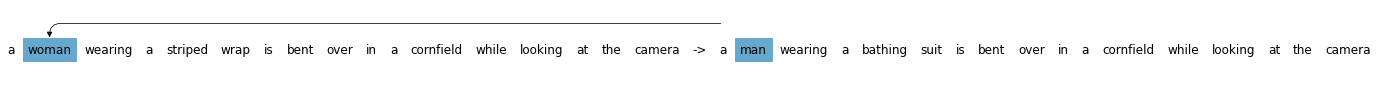


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A woman wearing a striped wrap is bent over in a cornfield while looking at the camera.', 'A man wearing a bathing suit is bent over in a cornfield while looking at the camera.']
gold label: contradiction
pred label: contradiction
explanations: [(('woman',), ('man', 'suit')), (('woman',), ('man', 'bathing')), (('woman', 'wearing'), ('man',)), (('woman',), ('a', 'man')), (('woman',), ('man', 'camera')), (('woman',), ('man', 'a')), (('woman',), ('man', 'while')), (('woman',), ('man', 'the')), (('woman',), ('man', 'looking')), (('woman',), ('man', 'over'))]
interactions_vote: [(['woman'], ['man']), (['woman'], ['bathing', 'suit']), (['striped', 'wrap'], ['man']), (['striped', 'wrap'], ['bathing', 'suit'])]
interactions_union: [(['A', 'woman'], ['A', 'man']), (['A', 'woman'], ['bathing', 'suit']), (['striped', 'wrap'], ['A', 'man']), (['striped', 'wrap'], ['bathing', 'suit'])]


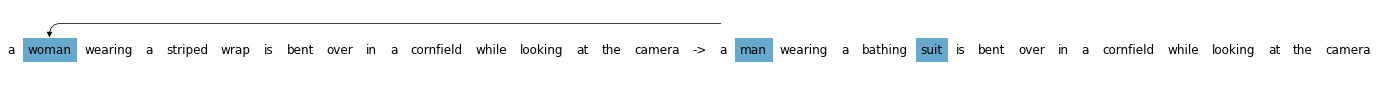


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A woman wearing a striped wrap is bent over in a cornfield while looking at the camera.', 'A man wearing a bathing suit is bent over in a cornfield while looking at the camera.']
gold label: contradiction
pred label: contradiction
explanations: [(('woman', 'wearing'), ('man', 'suit')), (('woman',), ('a', 'man', 'suit')), (('woman', 'striped'), ('man', 'suit')), (('woman', 'wrap'), ('man', 'suit')), (('woman', 'wearing'), ('man', 'bathing')), (('woman',), ('man', 'suit', 'over')), (('woman', 'camera'), ('man', 'suit')), (('woman',), ('man', 'bathing', 'suit')), (('woman', 'looking'), ('man', 'suit')), (('woman',), ('man', 'suit', 'while')), (('woman',), ('man', 'a', 'suit')), (('woman',), ('man', 'suit', 'the')), (('woman', 'bent'), ('man', 'suit')), (('woman',), ('man', 'suit', 'a')), (('woman', 'in'), ('man', 'suit')), (('woman', 'at'), ('man', 'suit')), (('woman',), ('man', 'wearing', 'suit'))

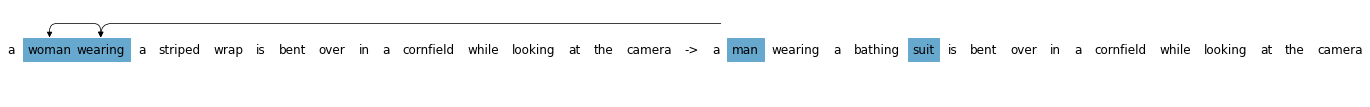

############################ 179 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['Two little boys wearing athletic jerseys are washing their hands in a public restroom.', 'The boys had unclean hands.']
gold label: entailment
pred label: neutral
explanations: [((), ('unclean',)), ((), ('The',)), (('washing',), ()), ((), ('had',)), (('jerseys',), ()), (('restroom',), ()), (('wearing',), ()), (('boys',), ()), (('little',), ()), (('Two',), ()), (('are',), ()), (('a',), ()), (('public',), ()), (('their',), ())]
interactions_vote: [(['boys'], ['boys', 'had', 'unclean', 'hands']), (['washing', 'their', 'hands'], ['boys', 'had', 'unclean', 'hands'])]
interactions_union: [(['boys'], ['boys', 'had', 'unclean', 'hands']), (['are', 'washing', 'their', 'hands'], ['boys', 'had', 'unclean', 'hands'])]


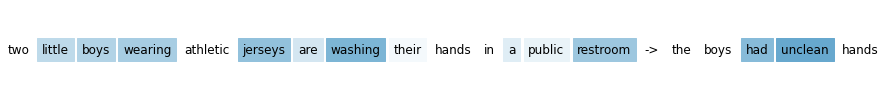


bert-base_arch-5_test_BT=[MASK].json
texts: ['Two little boys wearing athletic jerseys are washing their hands in a public restroom.', 'The boys had unclean hands.']
gold label: entailment
pred label: neutral
explanations: [(('hands',), ('the', 'boys', 'had', 'unclean'))]
interactions_vote: [(['boys'], ['boys', 'had', 'unclean', 'hands']), (['washing', 'their', 'hands'], ['boys', 'had', 'unclean', 'hands'])]
interactions_union: [(['boys'], ['boys', 'had', 'unclean', 'hands']), (['are', 'washing', 'their', 'hands'], ['boys', 'had', 'unclean', 'hands'])]


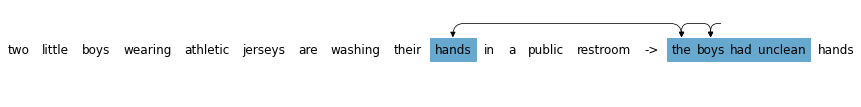


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['Two little boys wearing athletic jerseys are washing their hands in a public restroom.', 'The boys had unclean hands.']
gold label: entailment
pred label: neutral
explanations: [(('jerseys',), ('unclean',)), (('little',), ('unclean',)), (('hands',), ('unclean',)), (('washing',), ('unclean',)), (('washing',), ('had',))]
interactions_vote: [(['boys'], ['boys', 'had', 'unclean', 'hands']), (['washing', 'their', 'hands'], ['boys', 'had', 'unclean', 'hands'])]
interactions_union: [(['boys'], ['boys', 'had', 'unclean', 'hands']), (['are', 'washing', 'their', 'hands'], ['boys', 'had', 'unclean', 'hands'])]


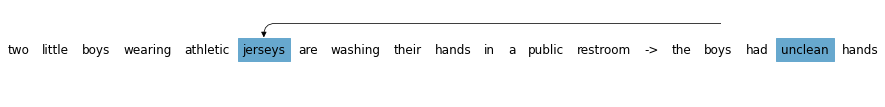


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Two little boys wearing athletic jerseys are washing their hands in a public restroom.', 'The boys had unclean hands.']
gold label: entailment
pred label: neutral
explanations: [(('washing',), ('unclean',)), (('hands',), ('unclean',)), (('washing',), ('had',)), (('two',), ('unclean',)), (('wearing',), ('unclean',)), (('jerseys',), ('unclean',)), (('washing',), ('the',)), (('boys',), ('unclean',)), (('little',), ('unclean',)), (('are',), ('unclean',)), (('a',), ('unclean',)), (('restroom',), ('unclean',)), (('their',), ('unclean',)), (('public',), ('unclean',)), (('in',), ('unclean',)), (('jerseys',), ('had',)), (('jerseys',), ('the',)), (('wearing',), ('had',)), (('two',), ('the',)), (('restroom',), ('had',))]
interactions_vote: [(['boys'], ['boys', 'had', 'unclean', 'hands']), (['washing', 'their', 'hands'], ['boys', 'had', 'unclean', 'hands'])]
interactions_union: [(['boys'], ['boys', 'had', 'unclean', '

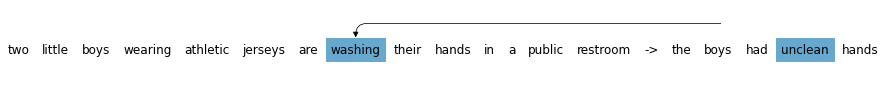


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Two little boys wearing athletic jerseys are washing their hands in a public restroom.', 'The boys had unclean hands.']
gold label: entailment
pred label: neutral
explanations: [(('washing',), ('the', 'unclean')), (('washing',), ('had', 'unclean')), (('hands',), ('the', 'unclean')), (('two',), ('the', 'unclean')), (('jerseys',), ('the', 'unclean')), (('boys',), ('boys', 'unclean')), (('wearing',), ('the', 'unclean')), (('washing',), ('boys', 'unclean')), (('a',), ('the', 'unclean')), (('restroom',), ('the', 'unclean'))]
interactions_vote: [(['boys'], ['boys', 'had', 'unclean', 'hands']), (['washing', 'their', 'hands'], ['boys', 'had', 'unclean', 'hands'])]
interactions_union: [(['boys'], ['boys', 'had', 'unclean', 'hands']), (['are', 'washing', 'their', 'hands'], ['boys', 'had', 'unclean', 'hands'])]


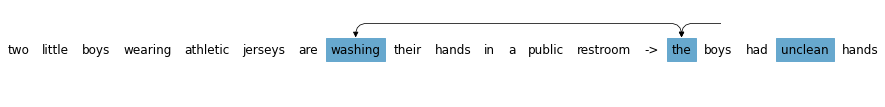


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['Two little boys wearing athletic jerseys are washing their hands in a public restroom.', 'The boys had unclean hands.']
gold label: entailment
pred label: neutral
explanations: [(('washing',), ('the', 'had', 'unclean')), (('washing',), ('the', 'boys', 'unclean')), (('boys',), ('the', 'boys', 'unclean')), (('wearing',), ('the', 'boys', 'unclean')), (('jerseys',), ('the', 'boys', 'unclean')), (('jerseys',), ('the', 'had', 'unclean')), (('wearing', 'washing'), ('the', 'unclean')), (('jerseys', 'washing'), ('the', 'unclean')), (('two',), ('the', 'boys', 'unclean')), (('little',), ('the', 'boys', 'unclean')), (('two', 'washing'), ('had', 'unclean')), (('public',), ('the', 'boys', 'unclean')), (('two', 'washing'), ('the', 'unclean')), (('jerseys', 'washing'), ('had', 'unclean')), (('two',), ('the', 'had', 'unclean')), (('washing', 'hands'), ('had', 'unclean')), (('hands',), ('the', 'boys', 'unclean'))

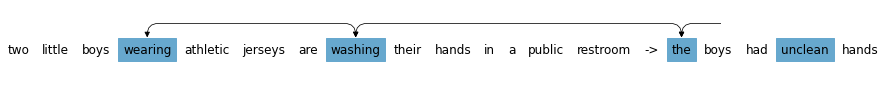

############################ 757 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['Several men at a bar watch a sports game on the television.', 'The men are at a baseball game.']
gold label: contradiction
pred label: neutral
explanations: [((), ('baseball',)), (('sports',), ()), ((), ('game',)), (('watch',), ()), ((), ('are',)), (('television',), ()), ((), ('men',)), (('Several',), ()), ((), ('The',)), ((), ()), (('a',), ()), (('game',), ())]
interactions_vote: [(['bar'], ['baseball', 'game'])]
interactions_union: [(['bar', 'watch', 'a', 'sports', 'game', 'on'], ['at', 'a', 'baseball', 'game']), (['television'], ['at', 'a', 'baseball', 'game'])]


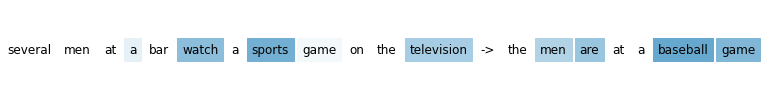


bert-base_arch-5_test_BT=[MASK].json
texts: ['Several men at a bar watch a sports game on the television.', 'The men are at a baseball game.']
gold label: contradiction
pred label: neutral
explanations: [((), ('the', 'are', 'at')), (('men', 'sports'), ('baseball', 'game'))]
interactions_vote: [(['bar'], ['baseball', 'game'])]
interactions_union: [(['bar', 'watch', 'a', 'sports', 'game', 'on'], ['at', 'a', 'baseball', 'game']), (['television'], ['at', 'a', 'baseball', 'game'])]


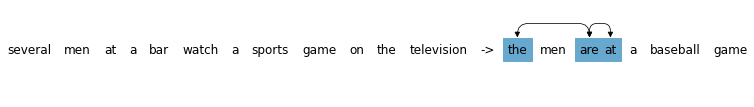


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['Several men at a bar watch a sports game on the television.', 'The men are at a baseball game.']
gold label: contradiction
pred label: neutral
explanations: [(('sports', 'game'), ('baseball',)), (('television',), ('game',)), (('men',), ('baseball',))]
interactions_vote: [(['bar'], ['baseball', 'game'])]
interactions_union: [(['bar', 'watch', 'a', 'sports', 'game', 'on'], ['at', 'a', 'baseball', 'game']), (['television'], ['at', 'a', 'baseball', 'game'])]


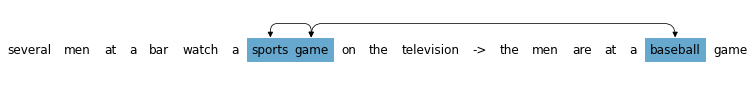


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Several men at a bar watch a sports game on the television.', 'The men are at a baseball game.']
gold label: contradiction
pred label: neutral
explanations: [(('sports',), ('baseball',)), (('sports',), ('game',)), (('game',), ('baseball',)), (('sports',), ('the',)), (('men',), ('baseball',)), (('watch',), ('baseball',)), (('television',), ('game',)), (('on',), ('baseball',)), (('sports',), ('men',)), (('a',), ('baseball',)), (('the',), ('baseball',)), (('several',), ('baseball',)), (('several',), ('game',)), (('a',), ('game',)), (('watch',), ('game',)), (('at',), ('game',)), (('sports',), ('are',)), (('men',), ('game',))]
interactions_vote: [(['bar'], ['baseball', 'game'])]
interactions_union: [(['bar', 'watch', 'a', 'sports', 'game', 'on'], ['at', 'a', 'baseball', 'game']), (['television'], ['at', 'a', 'baseball', 'game'])]


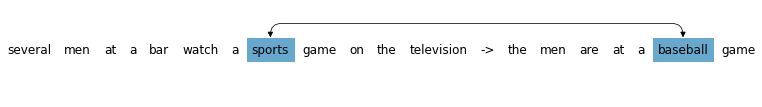


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Several men at a bar watch a sports game on the television.', 'The men are at a baseball game.']
gold label: contradiction
pred label: neutral
explanations: [(('sports',), ('baseball', 'game')), (('sports',), ('at', 'baseball')), (('watch', 'sports'), ('baseball',)), (('sports',), ('the', 'baseball')), (('sports', 'on'), ('baseball',)), (('men', 'sports'), ('baseball',)), (('a', 'sports'), ('baseball',)), (('game',), ('baseball', 'game')), (('several', 'sports'), ('baseball',)), (('sports',), ('men', 'baseball'))]
interactions_vote: [(['bar'], ['baseball', 'game'])]
interactions_union: [(['bar', 'watch', 'a', 'sports', 'game', 'on'], ['at', 'a', 'baseball', 'game']), (['television'], ['at', 'a', 'baseball', 'game'])]


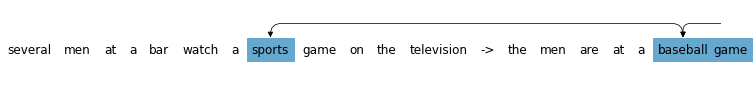


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['Several men at a bar watch a sports game on the television.', 'The men are at a baseball game.']
gold label: contradiction
pred label: neutral
explanations: [(('watch', 'sports'), ('baseball', 'game')), (('sports',), ('at', 'baseball', 'game')), (('sports',), ('the', 'baseball', 'game')), (('men', 'sports'), ('baseball', 'game')), (('several', 'sports'), ('baseball', 'game')), (('sports', 'television'), ('baseball', 'game')), (('sports',), ('a', 'baseball', 'game')), (('sports', 'game'), ('baseball', 'game')), (('sports', 'the'), ('baseball', 'game')), (('sports', 'on'), ('baseball', 'game')), (('sports',), ('men', 'baseball', 'game')), (('a', 'sports'), ('baseball', 'game')), (('at', 'sports'), ('baseball', 'game')), (('bar', 'sports'), ('baseball', 'game')), (('watch', 'sports'), ('at', 'baseball')), (('watch', 'sports'), ('the', 'baseball')), (('sports',), ('are', 'baseball', 'game')), (('men

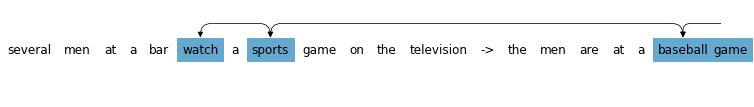

############################ 768 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['A speaker is talking with a TV in the background.', 'There is a live bear in the background.']
gold label: neutral
pred label: contradiction
explanations: [((), ('bear',)), ((), ('in',)), ((), ('the',)), ((), ('a',)), (('background',), ()), ((), ('live',)), (('a',), ()), (('the',), ()), ((), ()), (('is',), ()), (('A',), ())]
interactions_vote: []
interactions_union: []


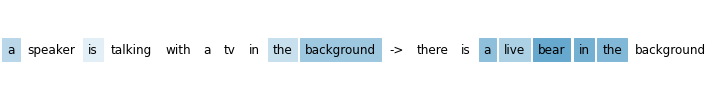


bert-base_arch-5_test_BT=[MASK].json
texts: ['A speaker is talking with a TV in the background.', 'There is a live bear in the background.']
gold label: neutral
pred label: contradiction
explanations: [((), ('is', 'a', 'bear')), (('talking',), ('live',))]
interactions_vote: []
interactions_union: []


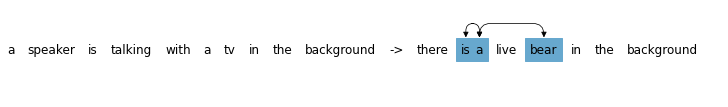


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A speaker is talking with a TV in the background.', 'There is a live bear in the background.']
gold label: neutral
pred label: contradiction
explanations: [(('speaker',), ('bear',)), (('talking',), ('live',)), (('tv',), ('in',)), (('in',), ('in',))]
interactions_vote: []
interactions_union: []


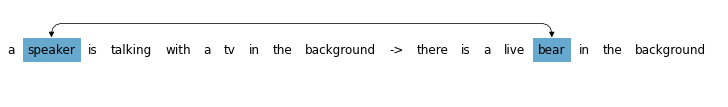


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A speaker is talking with a TV in the background.', 'There is a live bear in the background.']
gold label: neutral
pred label: contradiction
explanations: [(('talking',), ('bear',)), (('background',), ('bear',)), (('speaker',), ('bear',)), (('with',), ('bear',)), (('is',), ('bear',)), (('in',), ('bear',)), (('tv',), ('bear',)), (('a',), ('bear',)), (('the',), ('bear',)), (('talking',), ('in',)), (('talking',), ('a',)), (('speaker',), ('in',)), (('talking',), ('live',)), (('speaker',), ('a',)), (('background',), ('a',)), (('a',), ('in',)), (('a',), ('a',)), (('background',), ('in',)), (('with',), ('a',))]
interactions_vote: []
interactions_union: []


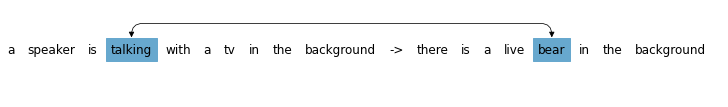


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A speaker is talking with a TV in the background.', 'There is a live bear in the background.']
gold label: neutral
pred label: contradiction
explanations: [(('speaker',), ('bear', 'in')), (('talking',), ('bear', 'in')), (('talking',), ('a', 'bear')), (('background',), ('bear', 'in')), (('tv',), ('bear', 'in')), (('talking',), ('live', 'bear')), (('in',), ('bear', 'in')), (('a',), ('bear', 'in')), (('with',), ('bear', 'in'))]
interactions_vote: []
interactions_union: []


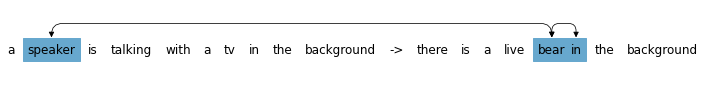


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A speaker is talking with a TV in the background.', 'There is a live bear in the background.']
gold label: neutral
pred label: contradiction
explanations: [(('speaker',), ('bear', 'in', 'the')), (('speaker',), ('a', 'bear', 'in')), (('talking',), ('bear', 'in', 'the')), (('talking',), ('live', 'bear', 'in')), (('talking',), ('a', 'bear', 'in')), (('tv',), ('a', 'bear', 'in')), (('tv',), ('bear', 'in', 'the')), (('background',), ('bear', 'in', 'the')), (('talking',), ('bear', 'in', 'background')), (('background',), ('a', 'bear', 'in')), (('in',), ('bear', 'in', 'the')), (('background',), ('live', 'bear', 'in')), (('a',), ('bear', 'in', 'the')), (('talking',), ('a', 'live', 'bear')), (('is',), ('a', 'bear', 'in')), (('a',), ('a', 'bear', 'in')), (('speaker',), ('live', 'bear', 'in')), (('in',), ('a', 'bear', 'in')), (('is',), ('bear', 'in', 'the')), (('in',), ('live', 'bear', 'in'))]
interactions_

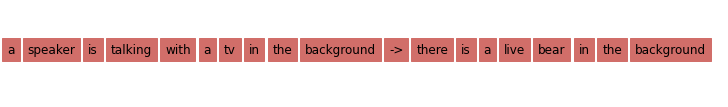

############################ 134 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['A classroom of mostly women is being shown a presentation.', 'The college class of mostly females watched a presentation.']
gold label: entailment
pred label: neutral
explanations: [((), ('college',)), ((), ('class',)), ((), ('presentation',)), ((), ('females',)), (('shown',), ()), ((), ('of',)), (('is',), ()), (('A',), ()), ((), ('The',)), (('of',), ())]
interactions_vote: []
interactions_union: [(['classroom'], ['college']), (['classroom'], ['mostly', 'females', 'watched', 'a', 'presentation']), (['women'], ['college']), (['women'], ['mostly', 'females', 'watched', 'a', 'presentation']), (['being', 'shown', 'a', 'presentation'], ['college']), (['being', 'shown', 'a', 'presentation'], ['mostly', 'females', 'watched', 'a', 'presentation'])]


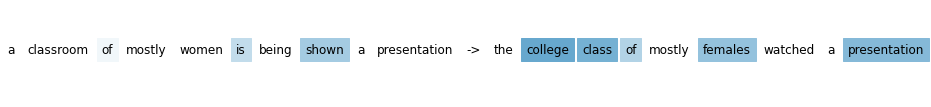


bert-base_arch-5_test_BT=[MASK].json
texts: ['A classroom of mostly women is being shown a presentation.', 'The college class of mostly females watched a presentation.']
gold label: entailment
pred label: neutral
explanations: [(('classroom', 'mostly', 'women', 'shown'), ('college', 'watched'))]
interactions_vote: []
interactions_union: [(['classroom'], ['college']), (['classroom'], ['mostly', 'females', 'watched', 'a', 'presentation']), (['women'], ['college']), (['women'], ['mostly', 'females', 'watched', 'a', 'presentation']), (['being', 'shown', 'a', 'presentation'], ['college']), (['being', 'shown', 'a', 'presentation'], ['mostly', 'females', 'watched', 'a', 'presentation'])]


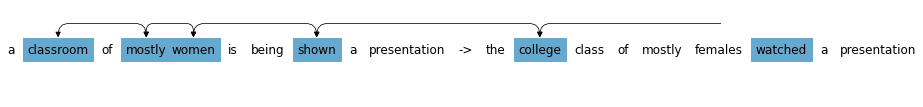


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A classroom of mostly women is being shown a presentation.', 'The college class of mostly females watched a presentation.']
gold label: entailment
pred label: neutral
explanations: [(('women',), ('college',)), (('shown',), ('watched',)), (('classroom',), ('class',))]
interactions_vote: []
interactions_union: [(['classroom'], ['college']), (['classroom'], ['mostly', 'females', 'watched', 'a', 'presentation']), (['women'], ['college']), (['women'], ['mostly', 'females', 'watched', 'a', 'presentation']), (['being', 'shown', 'a', 'presentation'], ['college']), (['being', 'shown', 'a', 'presentation'], ['mostly', 'females', 'watched', 'a', 'presentation'])]


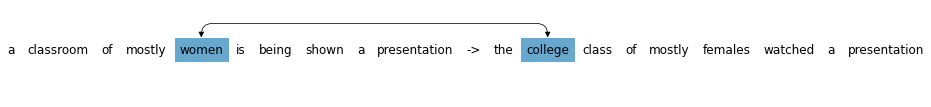


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A classroom of mostly women is being shown a presentation.', 'The college class of mostly females watched a presentation.']
gold label: entailment
pred label: neutral
explanations: [(('classroom',), ('college',)), (('shown',), ('college',)), (('mostly',), ('college',)), (('a',), ('college',)), (('is',), ('college',)), (('being',), ('college',)), (('presentation',), ('college',)), (('of',), ('college',)), (('women',), ('college',)), (('shown',), ('class',)), (('is',), ('class',)), (('shown',), ('females',)), (('a',), ('class',)), (('mostly',), ('class',)), (('being',), ('class',)), (('of',), ('class',)), (('a',), ('females',))]
interactions_vote: []
interactions_union: [(['classroom'], ['college']), (['classroom'], ['mostly', 'females', 'watched', 'a', 'presentation']), (['women'], ['college']), (['women'], ['mostly', 'females', 'watched', 'a', 'presentation']), (['being', 'shown', 'a', 'presentation'], ['c

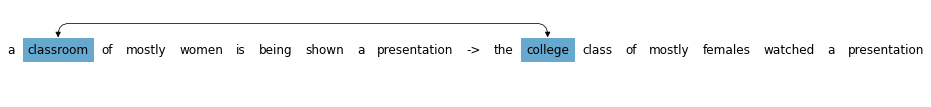


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A classroom of mostly women is being shown a presentation.', 'The college class of mostly females watched a presentation.']
gold label: entailment
pred label: neutral
explanations: [(('classroom',), ('college', 'class')), (('shown',), ('college', 'class')), (('mostly',), ('college', 'class')), (('a',), ('college', 'class')), (('being',), ('college', 'class')), (('a',), ('college', 'females')), (('shown',), ('college', 'females')), (('of',), ('college', 'class')), (('is',), ('college', 'class'))]
interactions_vote: []
interactions_union: [(['classroom'], ['college']), (['classroom'], ['mostly', 'females', 'watched', 'a', 'presentation']), (['women'], ['college']), (['women'], ['mostly', 'females', 'watched', 'a', 'presentation']), (['being', 'shown', 'a', 'presentation'], ['college']), (['being', 'shown', 'a', 'presentation'], ['mostly', 'females', 'watched', 'a', 'presentation'])]


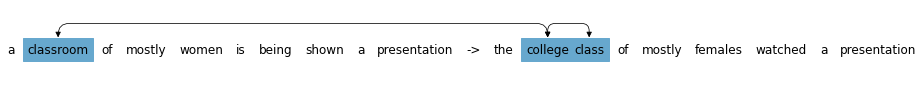


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A classroom of mostly women is being shown a presentation.', 'The college class of mostly females watched a presentation.']
gold label: entailment
pred label: neutral
explanations: [(('classroom',), ('the', 'college', 'class')), (('shown',), ('college', 'class', 'presentation')), (('classroom', 'shown'), ('college', 'class')), (('classroom',), ('college', 'class', 'females')), (('a', 'classroom'), ('college', 'class')), (('classroom', 'mostly'), ('college', 'class')), (('classroom', 'a'), ('college', 'class')), (('shown',), ('the', 'college', 'class')), (('classroom', 'is'), ('college', 'class')), (('shown',), ('college', 'class', 'females')), (('classroom', 'of'), ('college', 'class')), (('mostly',), ('college', 'class', 'presentation')), (('presentation',), ('college', 'class', 'presentation')), (('classroom', 'being'), ('college', 'class')), (('a',), ('college', 'class', 'presentation')), (('

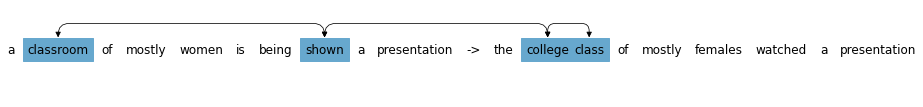

############################ 45 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['A man and woman look upward on a city block.', 'A man and woman are in a metropolitan area.']
gold label: entailment
pred label: entailment
explanations: [(('city',), ()), ((), ('area',)), (('woman',), ()), (('man',), ()), (('and',), ()), ((), ('a',)), ((), ('are',)), (('on',), ()), ((), ('A',))]
interactions_vote: [(['city', 'block'], ['metropolitan', 'area'])]
interactions_union: [(['look'], ['in', 'a', 'metropolitan', 'area']), (['on', 'a', 'city', 'block'], ['in', 'a', 'metropolitan', 'area'])]


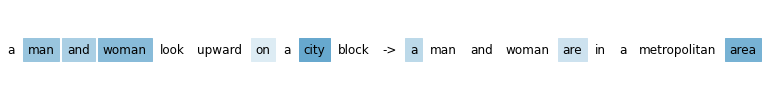


bert-base_arch-5_test_BT=[MASK].json
texts: ['A man and woman look upward on a city block.', 'A man and woman are in a metropolitan area.']
gold label: entailment
pred label: entailment
explanations: [(('city',), ('metropolitan', 'area'))]
interactions_vote: [(['city', 'block'], ['metropolitan', 'area'])]
interactions_union: [(['look'], ['in', 'a', 'metropolitan', 'area']), (['on', 'a', 'city', 'block'], ['in', 'a', 'metropolitan', 'area'])]


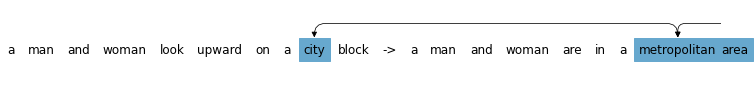


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A man and woman look upward on a city block.', 'A man and woman are in a metropolitan area.']
gold label: entailment
pred label: entailment
explanations: [(('woman',), ('woman',)), (('city',), ('metropolitan',))]
interactions_vote: [(['city', 'block'], ['metropolitan', 'area'])]
interactions_union: [(['look'], ['in', 'a', 'metropolitan', 'area']), (['on', 'a', 'city', 'block'], ['in', 'a', 'metropolitan', 'area'])]


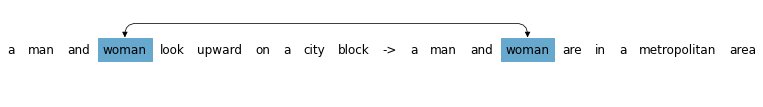


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A man and woman look upward on a city block.', 'A man and woman are in a metropolitan area.']
gold label: entailment
pred label: entailment
explanations: [(('city',), ('area',)), (('woman',), ('area',)), (('man',), ('area',)), (('city',), ('metropolitan',)), (('upward',), ('area',)), (('and',), ('area',)), (('a',), ('area',)), (('look',), ('area',)), (('on',), ('area',)), (('block',), ('area',)), (('city',), ('and',)), (('city',), ('in',)), (('city',), ('a',)), (('city',), ('are',)), (('woman',), ('woman',)), (('woman',), ('and',)), (('woman',), ('a',)), (('woman',), ('in',))]
interactions_vote: [(['city', 'block'], ['metropolitan', 'area'])]
interactions_union: [(['look'], ['in', 'a', 'metropolitan', 'area']), (['on', 'a', 'city', 'block'], ['in', 'a', 'metropolitan', 'area'])]


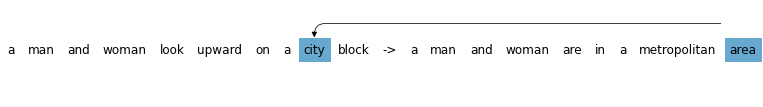


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A man and woman look upward on a city block.', 'A man and woman are in a metropolitan area.']
gold label: entailment
pred label: entailment
explanations: [(('woman', 'city'), ('area',)), (('city',), ('are', 'area')), (('man', 'city'), ('area',)), (('city',), ('a', 'area')), (('city',), ('in', 'area')), (('and', 'city'), ('area',)), (('city',), ('and', 'area')), (('upward', 'city'), ('area',)), (('a', 'city'), ('area',)), (('on', 'city'), ('area',))]
interactions_vote: [(['city', 'block'], ['metropolitan', 'area'])]
interactions_union: [(['look'], ['in', 'a', 'metropolitan', 'area']), (['on', 'a', 'city', 'block'], ['in', 'a', 'metropolitan', 'area'])]


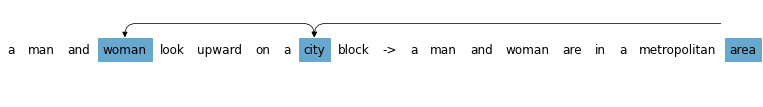


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A man and woman look upward on a city block.', 'A man and woman are in a metropolitan area.']
gold label: entailment
pred label: entailment
explanations: [(('man', 'woman', 'city'), ('area',)), (('woman', 'city'), ('in', 'area')), (('woman', 'city'), ('and', 'area')), (('and', 'woman', 'city'), ('area',)), (('woman', 'upward', 'city'), ('area',)), (('woman', 'city'), ('woman', 'area')), (('woman', 'city'), ('are', 'area')), (('city',), ('are', 'a', 'area')), (('woman', 'city', 'block'), ('area',)), (('woman', 'a', 'city'), ('area',)), (('woman', 'city'), ('metropolitan', 'area')), (('woman', 'city'), ('a', 'area')), (('man', 'woman', 'city'), ('metropolitan',)), (('woman', 'look', 'city'), ('area',)), (('a', 'woman', 'city'), ('area',)), (('man', 'city'), ('a', 'area')), (('woman', 'on', 'city'), ('area',)), (('upward', 'city'), ('are', 'area')), (('man', 'city'), ('are', 'area'))]
interactions_

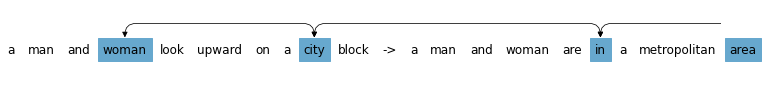

############################ 894 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['A man in a jean jacket is reaching into a bag and walking past two women.', 'boy watches movie at home']
gold label: contradiction
pred label: contradiction
explanations: [((), ('movie',)), ((), ('boy',)), ((), ('home',)), ((), ('watches',)), ((), ('at',)), (('bag',), ()), (('jacket',), ()), (('walking',), ()), (('women',), ()), (('in',), ()), (('into',), ()), (('past',), ()), (('man',), ()), (('and',), ()), (('reaching',), ()), (('a',), ())]
interactions_vote: [(['walking'], ['watches', 'movie'])]
interactions_union: [(['man'], ['boy', 'watches', 'movie', 'at', 'home']), (['walking', 'past', 'two', 'women'], ['boy', 'watches', 'movie', 'at', 'home'])]


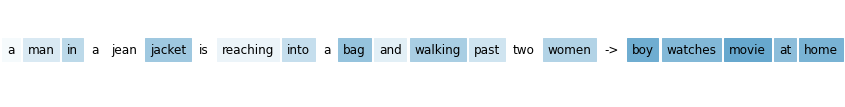


bert-base_arch-5_test_BT=[MASK].json
texts: ['A man in a jean jacket is reaching into a bag and walking past two women.', 'boy watches movie at home']
gold label: contradiction
pred label: contradiction
explanations: [(('women',), ('boy', 'watches', 'movie', 'at', 'home'))]
interactions_vote: [(['walking'], ['watches', 'movie'])]
interactions_union: [(['man'], ['boy', 'watches', 'movie', 'at', 'home']), (['walking', 'past', 'two', 'women'], ['boy', 'watches', 'movie', 'at', 'home'])]


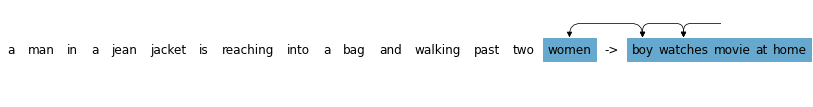


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A man in a jean jacket is reaching into a bag and walking past two women.', 'boy watches movie at home']
gold label: contradiction
pred label: contradiction
explanations: [(('women',), ('boy',)), (('man',), ('boy',)), (('past',), ('home',))]
interactions_vote: [(['walking'], ['watches', 'movie'])]
interactions_union: [(['man'], ['boy', 'watches', 'movie', 'at', 'home']), (['walking', 'past', 'two', 'women'], ['boy', 'watches', 'movie', 'at', 'home'])]


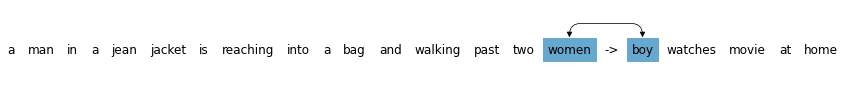


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A man in a jean jacket is reaching into a bag and walking past two women.', 'boy watches movie at home']
gold label: contradiction
pred label: contradiction
explanations: [(('bag',), ('movie',)), (('women',), ('boy',)), (('man',), ('boy',)), (('jacket',), ('movie',)), (('bag',), ('boy',)), (('reaching',), ('movie',)), (('walking',), ('movie',)), (('jean',), ('boy',)), (('women',), ('movie',)), (('jacket',), ('boy',)), (('reaching',), ('boy',)), (('and',), ('boy',)), (('walking',), ('boy',)), (('into',), ('boy',)), (('in',), ('boy',)), (('two',), ('boy',)), (('is',), ('boy',)), (('a',), ('boy',)), (('a',), ('movie',))]
interactions_vote: [(['walking'], ['watches', 'movie'])]
interactions_union: [(['man'], ['boy', 'watches', 'movie', 'at', 'home']), (['walking', 'past', 'two', 'women'], ['boy', 'watches', 'movie', 'at', 'home'])]


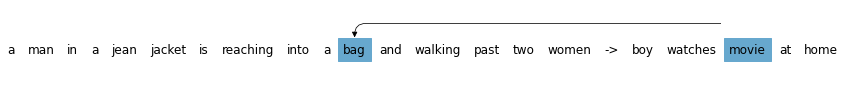


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A man in a jean jacket is reaching into a bag and walking past two women.', 'boy watches movie at home']
gold label: contradiction
pred label: contradiction
explanations: [(('bag',), ('movie', 'at')), (('reaching',), ('watches', 'movie')), (('women',), ('boy', 'home')), (('bag',), ('watches', 'movie')), (('reaching',), ('movie', 'at')), (('walking',), ('movie', 'at')), (('walking',), ('watches', 'movie')), (('bag',), ('boy', 'movie')), (('bag',), ('at', 'home')), (('women',), ('boy', 'movie'))]
interactions_vote: [(['walking'], ['watches', 'movie'])]
interactions_union: [(['man'], ['boy', 'watches', 'movie', 'at', 'home']), (['walking', 'past', 'two', 'women'], ['boy', 'watches', 'movie', 'at', 'home'])]


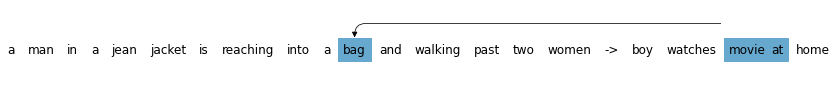


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A man in a jean jacket is reaching into a bag and walking past two women.', 'boy watches movie at home']
gold label: contradiction
pred label: contradiction
explanations: [(('women',), ('boy', 'watches', 'movie')), (('bag',), ('boy', 'watches', 'movie')), (('reaching',), ('boy', 'watches', 'movie')), (('women',), ('boy', 'movie', 'at')), (('reaching',), ('watches', 'movie', 'at')), (('bag',), ('boy', 'movie', 'at')), (('bag',), ('movie', 'at', 'home')), (('jacket',), ('boy', 'watches', 'movie')), (('reaching',), ('movie', 'at', 'home')), (('walking',), ('boy', 'watches', 'movie')), (('bag',), ('watches', 'movie', 'at')), (('into',), ('boy', 'watches', 'movie')), (('reaching',), ('boy', 'movie', 'at')), (('jean',), ('boy', 'watches', 'movie')), (('a',), ('boy', 'watches', 'movie')), (('jacket',), ('movie', 'at', 'home')), (('man',), ('boy', 'watches', 'movie')), (('walking',), ('movie', 'at', 'ho

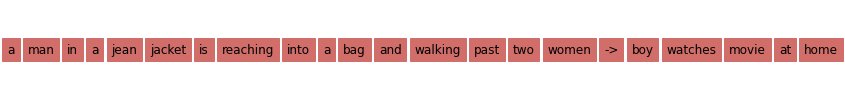

############################ 779 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['A man wearing a hat and carrying a bag', 'A man is walking empty handed.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('empty',)), ((), ('handed',)), ((), ('man',)), (('a',), ()), ((), ('walking',)), (('and',), ())]
interactions_vote: [(['carrying', 'a', 'bag'], ['empty', 'handed'])]
interactions_union: [(['carrying', 'a', 'bag'], ['walking', 'empty', 'handed'])]


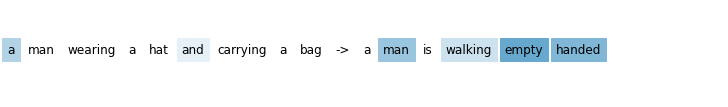


bert-base_arch-5_test_BT=[MASK].json
texts: ['A man wearing a hat and carrying a bag', 'A man is walking empty handed.']
gold label: contradiction
pred label: contradiction
explanations: [(('wearing', 'carrying'), ('empty', 'handed'))]
interactions_vote: [(['carrying', 'a', 'bag'], ['empty', 'handed'])]
interactions_union: [(['carrying', 'a', 'bag'], ['walking', 'empty', 'handed'])]


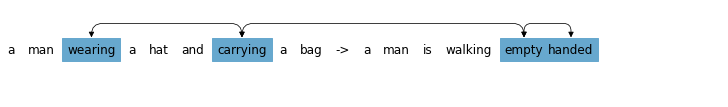


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A man wearing a hat and carrying a bag', 'A man is walking empty handed.']
gold label: contradiction
pred label: contradiction
explanations: [(('carrying', 'bag'), ('empty', 'handed')), (('wearing',), ('handed',))]
interactions_vote: [(['carrying', 'a', 'bag'], ['empty', 'handed'])]
interactions_union: [(['carrying', 'a', 'bag'], ['walking', 'empty', 'handed'])]


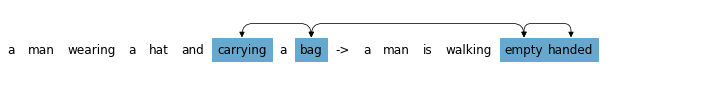


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A man wearing a hat and carrying a bag', 'A man is walking empty handed.']
gold label: contradiction
pred label: contradiction
explanations: [(('and',), ('empty',)), (('carrying',), ('empty',)), (('hat',), ('empty',)), (('wearing',), ('empty',)), (('a',), ('empty',)), (('man',), ('empty',)), (('bag',), ('empty',)), (('wearing',), ('man',)), (('hat',), ('is',)), (('and',), ('is',)), (('wearing',), ('handed',)), (('a',), ('man',)), (('wearing',), ('is',)), (('and',), ('man',)), (('a',), ('a',)), (('a',), ('is',)), (('hat',), ('a',))]
interactions_vote: [(['carrying', 'a', 'bag'], ['empty', 'handed'])]
interactions_union: [(['carrying', 'a', 'bag'], ['walking', 'empty', 'handed'])]


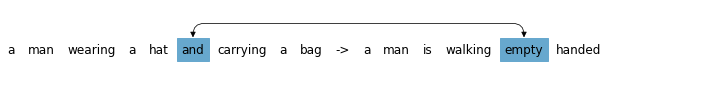


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A man wearing a hat and carrying a bag', 'A man is walking empty handed.']
gold label: contradiction
pred label: contradiction
explanations: [(('hat',), ('empty', 'handed')), (('wearing',), ('empty', 'handed')), (('and',), ('empty', 'handed')), (('carrying',), ('empty', 'handed')), (('bag',), ('empty', 'handed')), (('man',), ('empty', 'handed')), (('a',), ('empty', 'handed')), (('and',), ('walking', 'empty'))]
interactions_vote: [(['carrying', 'a', 'bag'], ['empty', 'handed'])]
interactions_union: [(['carrying', 'a', 'bag'], ['walking', 'empty', 'handed'])]


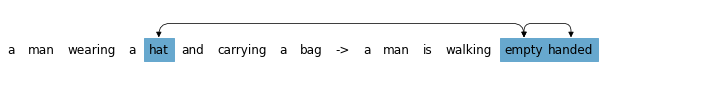


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A man wearing a hat and carrying a bag', 'A man is walking empty handed.']
gold label: contradiction
pred label: contradiction
explanations: [(('wearing', 'hat'), ('empty', 'handed')), (('hat', 'and'), ('empty', 'handed')), (('and', 'a'), ('empty', 'handed')), (('wearing', 'a'), ('empty', 'handed')), (('wearing',), ('a', 'empty', 'handed')), (('a', 'and'), ('empty', 'handed')), (('and',), ('a', 'empty', 'handed')), (('hat',), ('is', 'empty', 'handed')), (('hat',), ('a', 'empty', 'handed')), (('wearing',), ('is', 'empty', 'handed')), (('wearing', 'and'), ('empty', 'handed')), (('hat', 'a'), ('empty', 'handed')), (('wearing', 'bag'), ('empty', 'handed')), (('man', 'hat'), ('empty', 'handed')), (('a', 'hat'), ('empty', 'handed')), (('hat', 'carrying'), ('empty', 'handed')), (('hat',), ('man', 'empty', 'handed')), (('wearing',), ('man', 'empty', 'handed'))]
interactions_vote: [(['carrying', 'a', 'ba

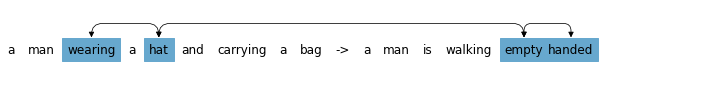

############################ 986 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['Four young men stare up at a basketball hoop with no net, in an outdoor, urban basketball court.', 'A group of women playing basketball in a gym.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('gym',)), ((), ('women',)), (('men',), ()), (('outdoor',), ()), (('urban',), ()), ((), ('in',)), (('stare',), ()), (('Four',), ()), (('at',), ()), (('net',), ())]
interactions_vote: [(['young', 'men'], ['women'])]
interactions_union: [(['young', 'men'], ['women']), (['young', 'men'], ['gym']), (['outdoor'], ['women']), (['outdoor'], ['gym'])]


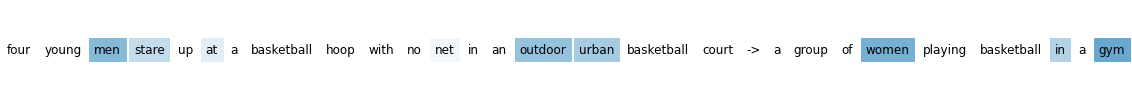


bert-base_arch-5_test_BT=[MASK].json
texts: ['Four young men stare up at a basketball hoop with no net, in an outdoor, urban basketball court.', 'A group of women playing basketball in a gym.']
gold label: contradiction
pred label: contradiction
explanations: [(('men', 'outdoor'), ('women', 'gym'))]
interactions_vote: [(['young', 'men'], ['women'])]
interactions_union: [(['young', 'men'], ['women']), (['young', 'men'], ['gym']), (['outdoor'], ['women']), (['outdoor'], ['gym'])]


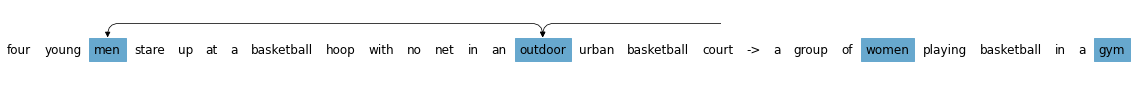


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['Four young men stare up at a basketball hoop with no net, in an outdoor, urban basketball court.', 'A group of women playing basketball in a gym.']
gold label: contradiction
pred label: contradiction
explanations: [(('men',), ('women', 'gym'))]
interactions_vote: [(['young', 'men'], ['women'])]
interactions_union: [(['young', 'men'], ['women']), (['young', 'men'], ['gym']), (['outdoor'], ['women']), (['outdoor'], ['gym'])]


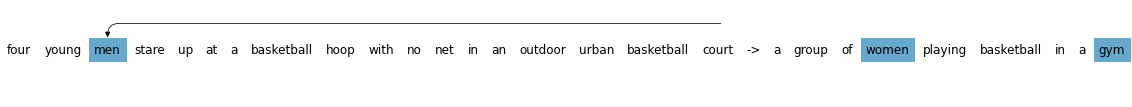


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Four young men stare up at a basketball hoop with no net, in an outdoor, urban basketball court.', 'A group of women playing basketball in a gym.']
gold label: contradiction
pred label: contradiction
explanations: [(('men',), ('women',)), (('outdoor',), ('gym',)), (('urban',), ('gym',)), (('men',), ('gym',)), (('outdoor',), ('women',)), (('stare',), ('gym',)), (('young',), ('women',)), (('urban',), ('women',)), (('stare',), ('women',)), (('four',), ('women',)), (('four',), ('gym',)), (('net',), ('gym',)), (('in',), ('women',)), (('an',), ('women',)), (('in',), ('gym',)), (('an',), ('gym',)), (('a',), ('women',)), (('young',), ('gym',)), (('up',), ('women',)), (('at',), ('women',))]
interactions_vote: [(['young', 'men'], ['women'])]
interactions_union: [(['young', 'men'], ['women']), (['young', 'men'], ['gym']), (['outdoor'], ['women']), (['outdoor'], ['gym'])]


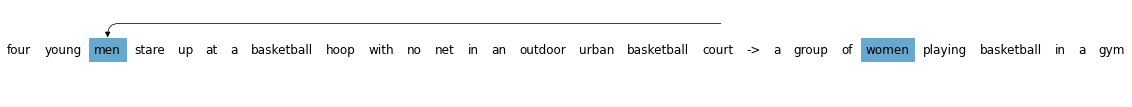


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Four young men stare up at a basketball hoop with no net, in an outdoor, urban basketball court.', 'A group of women playing basketball in a gym.']
gold label: contradiction
pred label: contradiction
explanations: [(('men',), ('group', 'women')), (('men',), ('women', 'gym')), (('men',), ('women', 'a')), (('four', 'men'), ('women',)), (('men',), ('a', 'women')), (('men', 'outdoor'), ('women',)), (('men',), ('women', 'in')), (('young', 'men'), ('women',)), (('men', 'at'), ('women',)), (('men', 'in'), ('women',))]
interactions_vote: [(['young', 'men'], ['women'])]
interactions_union: [(['young', 'men'], ['women']), (['young', 'men'], ['gym']), (['outdoor'], ['women']), (['outdoor'], ['gym'])]


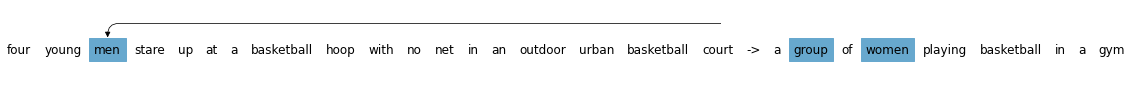


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['Four young men stare up at a basketball hoop with no net, in an outdoor, urban basketball court.', 'A group of women playing basketball in a gym.']
gold label: contradiction
pred label: contradiction
explanations: [(('men',), ('group', 'women', 'gym')), (('men',), ('group', 'women', 'a')), (('men',), ('women', 'in', 'gym')), (('men', 'outdoor'), ('women', 'gym')), (('four', 'men'), ('women', 'gym')), (('men',), ('women', 'a', 'gym')), (('four', 'men'), ('group', 'women')), (('men',), ('a', 'women', 'gym')), (('men',), ('group', 'of', 'women')), (('men',), ('women', 'in', 'a')), (('men',), ('a', 'women', 'a')), (('men', 'outdoor'), ('women', 'a')), (('men', 'outdoor'), ('group', 'women')), (('men', 'urban'), ('women', 'gym')), (('four', 'men'), ('women', 'a')), (('men', 'court'), ('women', 'gym')), (('men', 'up'), ('women', 'gym')), (('men',), ('a', 'group', 'women')), (('young', 'men'), ('group'

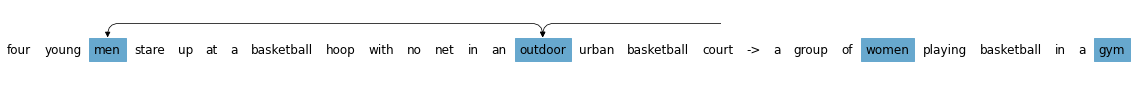

############################ 129 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['A small, pale bird bends down to examine a crumb.', 'The bird is on the ground.']
gold label: entailment
pred label: neutral
explanations: [(('bird',), ()), ((), ('is',)), ((), ('on',)), ((), ('ground',)), ((), ('bird',)), (('pale',), ()), ((), ('The',)), (('to',), ())]
interactions_vote: [(['bends', 'down'], ['ground']), (['crumb'], ['ground'])]
interactions_union: [(['bird', 'bends', 'down', 'to', 'examine', 'a', 'crumb'], ['bird']), (['bird', 'bends', 'down', 'to', 'examine', 'a', 'crumb'], ['on', 'the', 'ground'])]


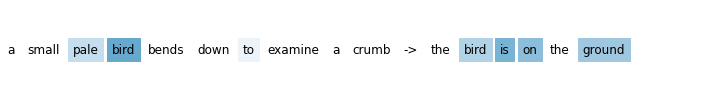


bert-base_arch-5_test_BT=[MASK].json
texts: ['A small, pale bird bends down to examine a crumb.', 'The bird is on the ground.']
gold label: entailment
pred label: neutral
explanations: [((), ('the', 'is', 'on', 'the'))]
interactions_vote: [(['bends', 'down'], ['ground']), (['crumb'], ['ground'])]
interactions_union: [(['bird', 'bends', 'down', 'to', 'examine', 'a', 'crumb'], ['bird']), (['bird', 'bends', 'down', 'to', 'examine', 'a', 'crumb'], ['on', 'the', 'ground'])]


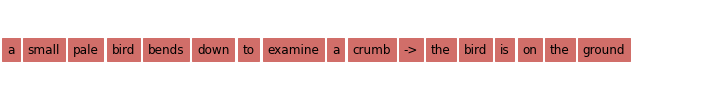


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A small, pale bird bends down to examine a crumb.', 'The bird is on the ground.']
gold label: entailment
pred label: neutral
explanations: [(('bird',), ('on',))]
interactions_vote: [(['bends', 'down'], ['ground']), (['crumb'], ['ground'])]
interactions_union: [(['bird', 'bends', 'down', 'to', 'examine', 'a', 'crumb'], ['bird']), (['bird', 'bends', 'down', 'to', 'examine', 'a', 'crumb'], ['on', 'the', 'ground'])]


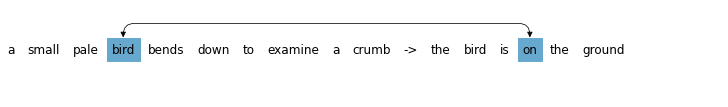


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A small, pale bird bends down to examine a crumb.', 'The bird is on the ground.']
gold label: entailment
pred label: neutral
explanations: [(('bird',), ('ground',)), (('bird',), ('bird',)), (('bird',), ('on',)), (('bird',), ('is',)), (('bird',), ('the',)), (('pale',), ('on',)), (('pale',), ('ground',)), (('small',), ('ground',)), (('small',), ('on',)), (('pale',), ('the',)), (('to',), ('ground',)), (('pale',), ('is',)), (('small',), ('is',)), (('crumb',), ('on',)), (('to',), ('on',)), (('small',), ('the',)), (('crumb',), ('ground',)), (('crumb',), ('the',)), (('a',), ('ground',))]
interactions_vote: [(['bends', 'down'], ['ground']), (['crumb'], ['ground'])]
interactions_union: [(['bird', 'bends', 'down', 'to', 'examine', 'a', 'crumb'], ['bird']), (['bird', 'bends', 'down', 'to', 'examine', 'a', 'crumb'], ['on', 'the', 'ground'])]


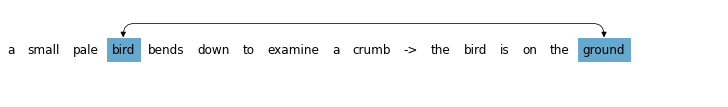


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A small, pale bird bends down to examine a crumb.', 'The bird is on the ground.']
gold label: entailment
pred label: neutral
explanations: [(('bird',), ('on', 'ground')), (('bird',), ('bird', 'ground')), (('bird',), ('the', 'is')), (('bird',), ('is', 'the')), (('bird',), ('on', 'the')), (('bird',), ('the', 'bird')), (('bird',), ('bird', 'on')), (('pale', 'bird'), ('ground',)), (('small', 'bird'), ('ground',)), (('bird', 'to'), ('ground',))]
interactions_vote: [(['bends', 'down'], ['ground']), (['crumb'], ['ground'])]
interactions_union: [(['bird', 'bends', 'down', 'to', 'examine', 'a', 'crumb'], ['bird']), (['bird', 'bends', 'down', 'to', 'examine', 'a', 'crumb'], ['on', 'the', 'ground'])]


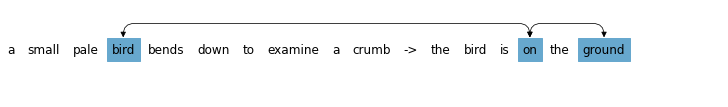


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A small, pale bird bends down to examine a crumb.', 'The bird is on the ground.']
gold label: entailment
pred label: neutral
explanations: [(('bird',), ('bird', 'on', 'ground')), (('bird',), ('on', 'the', 'ground')), (('pale', 'bird'), ('bird', 'ground')), (('pale', 'bird'), ('on', 'ground')), (('bird', 'to'), ('on', 'ground')), (('bird', 'to'), ('bird', 'ground')), (('bird',), ('the', 'is', 'the')), (('bird',), ('the', 'bird', 'is')), (('small', 'bird'), ('bird', 'ground')), (('bird',), ('the', 'bird', 'ground')), (('bird',), ('is', 'on', 'ground')), (('bird', 'a'), ('on', 'ground')), (('bird',), ('is', 'on', 'the')), (('pale',), ('on', 'the', 'ground')), (('to',), ('on', 'the', 'ground')), (('bird',), ('bird', 'is', 'ground')), (('small', 'bird'), ('on', 'ground')), (('a', 'bird'), ('bird', 'ground')), (('bird',), ('bird', 'on', 'the')), (('bird',), ('bird', 'the', 'ground'))]
interactions_vot

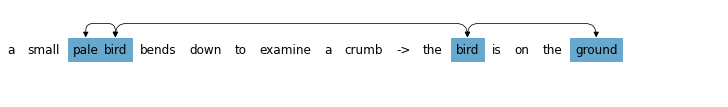

In [6]:
# failure
# idx = 929  # entail
# idx = 305  # contradict
# idx = 274  # contra
# idx = 267  # entail
# idx = 194  # contra  model is wrong, and the explanations are weird
# idx = 909  # contra  (counting)
# idx = 77  # voice (passive active)

# all success
# idx = 270  # contradict
# idx = 84  # entail
# idx = 532  # entail, copy paste
# idx = 640  # neutral, more or less copy paste

# my success
# idx = 283  # entail  (good example)
# idx = 137  # contra  (not rlly success, just difference)
# idx = 109  # contra  (kinda?)
# idx = 179  # entail  (kinda?)  (but the model was wrong)
# idx = 757  # contra  (the model was wrong, but the rationale make the most sense)
# idx = 768  # neutral (less noisy)
# my fail
# idx = 134 # entail
# idx = 45  # entail

# lime vs mask
idx = 894
idx = 779
idx = 986
# try later: with different label
# idx = 129  # pred:neutral gold:entail


for idx in [929, 305, 274, 267, 194, 909, 77,
            270, 84, 532, 640,
            283, 137, 109, 179, 757, 768,
            134, 45,
            894, 779, 986, 129
            ]:
    print(f'############################ {idx} #################################')
    exp_files = ['bert-base_lime-5000_test_BT=[MASK].json',
                'bert-base_arch-5_test_BT=[MASK].json',
                'bert-base_cross_arch-5_test_BT=[MASK]_X.json',
                'bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json',
                'bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json',
                'bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json',
                ]
    for exp_file in exp_files:
        print()
        print(exp_file)
        with open(f'../explanations/{exp_file}', 'r') as f:
            explanations = json.load(f)

        analyze_explanation(df, explanations, idx, topk=None if 'lime' in exp_file else 1, no_main='lime' not in exp_file)

### New Random

############################ 769 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['A woman in an apron is looking for bread.', 'A woman is looking for bread in her kitchen cupboards.']
gold label: neutral
pred label: neutral
explanations: [((), ('for',)), ((), ('looking',)), (('looking',), ()), (('bread',), ()), ((), ('bread',)), ((), ('kitchen',)), (('woman',), ()), (('is',), ()), (('A',), ()), ((), ('woman',))]
interactions_vote: []
interactions_union: []


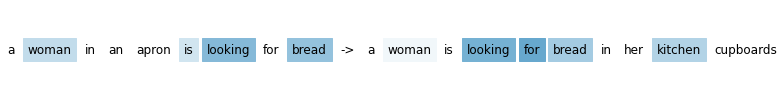


bert-base_arch-5_test_BT=[MASK].json
texts: ['A woman in an apron is looking for bread.', 'A woman is looking for bread in her kitchen cupboards.']
gold label: neutral
pred label: neutral
explanations: [(('apron', 'bread'), ('looking', 'bread')), ((), ('in', 'her'))]
interactions_vote: []
interactions_union: []


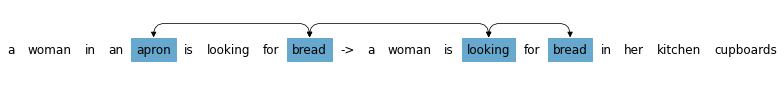


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A woman in an apron is looking for bread.', 'A woman is looking for bread in her kitchen cupboards.']
gold label: neutral
pred label: neutral
explanations: [(('apron', 'bread'), ('looking', 'bread'))]
interactions_vote: []
interactions_union: []


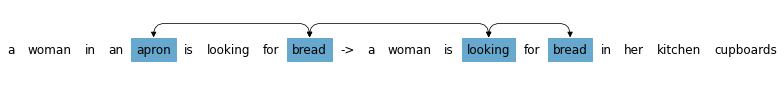


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A woman in an apron is looking for bread.', 'A woman is looking for bread in her kitchen cupboards.']
gold label: neutral
pred label: neutral
explanations: [(('looking',), ('looking',)), (('bread',), ('bread',)), (('looking',), ('for',)), (('bread',), ('kitchen',)), (('woman',), ('looking',)), (('looking',), ('kitchen',)), (('is',), ('looking',)), (('a',), ('looking',)), (('looking',), ('cupboards',)), (('apron',), ('kitchen',)), (('in',), ('looking',)), (('woman',), ('kitchen',)), (('looking',), ('woman',)), (('an',), ('looking',)), (('bread',), ('woman',)), (('apron',), ('bread',)), (('apron',), ('looking',)), (('bread',), ('cupboards',)), (('is',), ('kitchen',)), (('looking',), ('bread',))]
interactions_vote: []
interactions_union: []


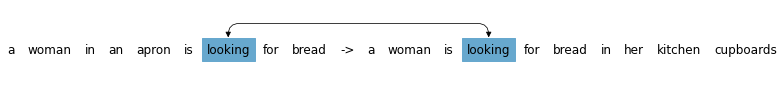


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A woman in an apron is looking for bread.', 'A woman is looking for bread in her kitchen cupboards.']
gold label: neutral
pred label: neutral
explanations: [(('looking',), ('looking', 'kitchen')), (('looking',), ('looking', 'cupboards')), (('looking',), ('looking', 'for')), (('looking',), ('looking', 'bread')), (('looking',), ('woman', 'looking')), (('looking',), ('looking', 'her')), (('looking',), ('is', 'looking')), (('a', 'looking'), ('looking',)), (('looking',), ('looking',))]
interactions_vote: []
interactions_union: []


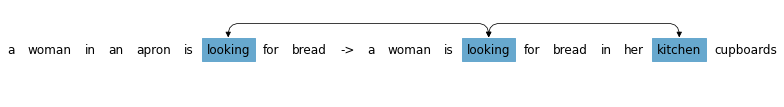


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A woman in an apron is looking for bread.', 'A woman is looking for bread in her kitchen cupboards.']
gold label: neutral
pred label: neutral
explanations: [(('looking',), ('looking', 'for', 'kitchen')), (('looking',), ('looking', 'for', 'cupboards')), (('looking',), ('looking', 'for', 'bread')), (('looking',), ('woman', 'looking', 'kitchen')), (('looking',), ('woman', 'looking', 'cupboards')), (('looking',), ('looking', 'her', 'kitchen')), (('woman', 'looking'), ('looking', 'cupboards')), (('looking',), ('looking', 'bread', 'kitchen')), (('looking',), ('woman', 'looking', 'for')), (('looking',), ('woman', 'looking', 'bread')), (('looking',), ('looking', 'bread', 'cupboards')), (('is', 'looking'), ('looking', 'kitchen')), (('woman', 'looking'), ('looking', 'kitchen')), (('looking',), ('looking', 'kitchen', 'cupboards')), (('looking',), ('looking', 'for', 'her')), (('bread',), ('for', 'bread', 'k

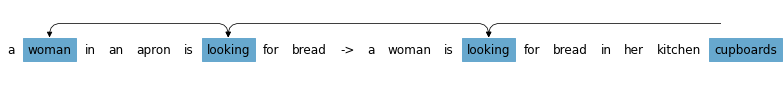

############################ 644 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['A woman wearing a ball cap squats down to touch the cracked earth.', 'A squatting woman wearing a hat touching the ground.']
gold label: entailment
pred label: entailment
explanations: [(('cap',), ()), (('woman',), ()), (('squats',), ()), ((), ('touching',)), ((), ('ground',)), ((), ('wearing',)), (('down',), ()), (('wearing',), ()), (('to',), ())]
interactions_vote: [(['ball', 'cap'], ['squatting']), (['ball', 'cap'], ['hat']), (['ball', 'cap'], ['ground']), (['cracked', 'earth'], ['squatting']), (['cracked', 'earth'], ['hat']), (['cracked', 'earth'], ['ground'])]
interactions_union: [(['woman'], ['squatting', 'woman']), (['woman'], ['hat']), (['woman'], ['ground']), (['ball', 'cap', 'squats'], ['squatting', 'woman']), (['ball', 'cap', 'squats'], ['hat']), (['ball', 'cap', 'squats'], ['ground']), (['cracked', 'earth'], ['squatting', 'woman']), (['cracked', 'earth'], ['h

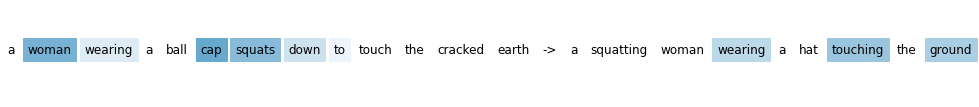


bert-base_arch-5_test_BT=[MASK].json
texts: ['A woman wearing a ball cap squats down to touch the cracked earth.', 'A squatting woman wearing a hat touching the ground.']
gold label: entailment
pred label: entailment
explanations: [(('woman', 'ball', 'cap'), ('woman', 'a', 'hat'))]
interactions_vote: [(['ball', 'cap'], ['squatting']), (['ball', 'cap'], ['hat']), (['ball', 'cap'], ['ground']), (['cracked', 'earth'], ['squatting']), (['cracked', 'earth'], ['hat']), (['cracked', 'earth'], ['ground'])]
interactions_union: [(['woman'], ['squatting', 'woman']), (['woman'], ['hat']), (['woman'], ['ground']), (['ball', 'cap', 'squats'], ['squatting', 'woman']), (['ball', 'cap', 'squats'], ['hat']), (['ball', 'cap', 'squats'], ['ground']), (['cracked', 'earth'], ['squatting', 'woman']), (['cracked', 'earth'], ['hat']), (['cracked', 'earth'], ['ground'])]


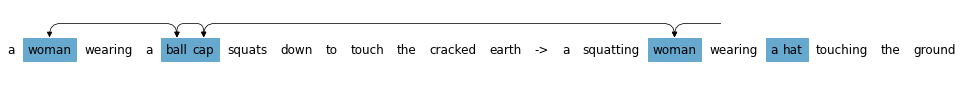


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A woman wearing a ball cap squats down to touch the cracked earth.', 'A squatting woman wearing a hat touching the ground.']
gold label: entailment
pred label: entailment
explanations: [(('earth',), ('ground',)), (('cap',), ('a', 'hat')), (('woman',), ('woman',))]
interactions_vote: [(['ball', 'cap'], ['squatting']), (['ball', 'cap'], ['hat']), (['ball', 'cap'], ['ground']), (['cracked', 'earth'], ['squatting']), (['cracked', 'earth'], ['hat']), (['cracked', 'earth'], ['ground'])]
interactions_union: [(['woman'], ['squatting', 'woman']), (['woman'], ['hat']), (['woman'], ['ground']), (['ball', 'cap', 'squats'], ['squatting', 'woman']), (['ball', 'cap', 'squats'], ['hat']), (['ball', 'cap', 'squats'], ['ground']), (['cracked', 'earth'], ['squatting', 'woman']), (['cracked', 'earth'], ['hat']), (['cracked', 'earth'], ['ground'])]


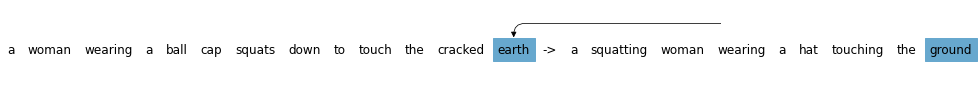


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A woman wearing a ball cap squats down to touch the cracked earth.', 'A squatting woman wearing a hat touching the ground.']
gold label: entailment
pred label: entailment
explanations: [(('cap',), ('touching',)), (('cap',), ('ground',)), (('woman',), ('touching',)), (('cap',), ('hat',)), (('cap',), ('a',)), (('cap',), ('squatting',)), (('cap',), ('the',)), (('cap',), ('wearing',)), (('woman',), ('ground',)), (('woman',), ('squatting',)), (('woman',), ('woman',)), (('squats',), ('touching',)), (('woman',), ('a',)), (('woman',), ('the',)), (('squats',), ('ground',)), (('woman',), ('wearing',)), (('squats',), ('a',))]
interactions_vote: [(['ball', 'cap'], ['squatting']), (['ball', 'cap'], ['hat']), (['ball', 'cap'], ['ground']), (['cracked', 'earth'], ['squatting']), (['cracked', 'earth'], ['hat']), (['cracked', 'earth'], ['ground'])]
interactions_union: [(['woman'], ['squatting', 'woman']), (['woman'], ['hat

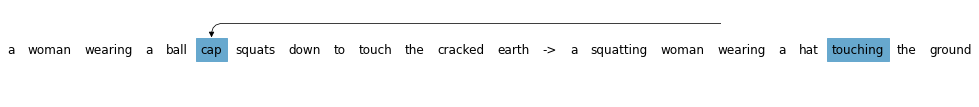


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A woman wearing a ball cap squats down to touch the cracked earth.', 'A squatting woman wearing a hat touching the ground.']
gold label: entailment
pred label: entailment
explanations: [(('woman', 'cap'), ('touching',)), (('woman', 'cap'), ('ground',)), (('woman', 'cap'), ('hat',)), (('cap', 'squats'), ('touching',)), (('woman', 'cap'), ('squatting',)), (('woman', 'cap'), ('woman',)), (('woman', 'cap'), ('the',)), (('woman', 'cap'), ('wearing',)), (('woman', 'cap'), ('a',))]
interactions_vote: [(['ball', 'cap'], ['squatting']), (['ball', 'cap'], ['hat']), (['ball', 'cap'], ['ground']), (['cracked', 'earth'], ['squatting']), (['cracked', 'earth'], ['hat']), (['cracked', 'earth'], ['ground'])]
interactions_union: [(['woman'], ['squatting', 'woman']), (['woman'], ['hat']), (['woman'], ['ground']), (['ball', 'cap', 'squats'], ['squatting', 'woman']), (['ball', 'cap', 'squats'], ['hat']), (['ball', 'cap', 'squa

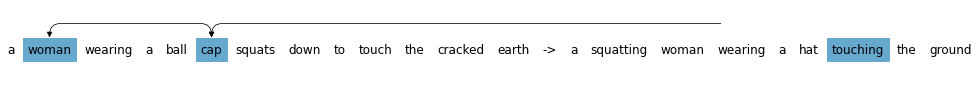


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A woman wearing a ball cap squats down to touch the cracked earth.', 'A squatting woman wearing a hat touching the ground.']
gold label: entailment
pred label: entailment
explanations: [(('woman', 'cap', 'squats'), ('touching',)), (('woman', 'cap', 'squats'), ('hat',)), (('woman', 'cap'), ('touching', 'ground')), (('woman', 'cap', 'squats'), ('ground',)), (('woman', 'cap', 'squats'), ('squatting',)), (('woman', 'cap', 'squats'), ('a',)), (('woman', 'cap', 'squats'), ('woman',)), (('woman', 'cap', 'squats'), ('the',)), (('woman', 'cap'), ('hat', 'touching')), (('woman', 'cap'), ('a', 'touching')), (('woman', 'cap', 'down'), ('touching',)), (('woman', 'cap'), ('squatting', 'touching')), (('woman', 'cap', 'squats'), ('wearing',)), (('woman', 'cap'), ('touching', 'the')), (('woman', 'cap', 'the'), ('touching',)), (('woman', 'cap'), ('wearing', 'touching')), (('woman', 'cap', 'earth'), ('touching',))

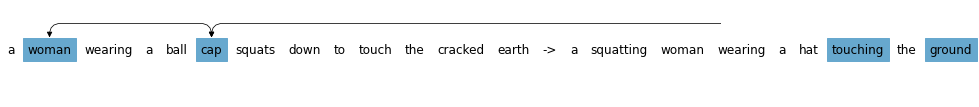

############################ 862 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['Two girls pass two boys by a tree in a neon lit street.', 'Some kids pass their friends on a street.']
gold label: neutral
pred label: neutral
explanations: [((), ('friends',)), ((), ('Some',)), (('neon',), ()), (('two',), ()), (('by',), ()), ((), ('kids',)), (('girls',), ()), ((), ('a',)), ((), ('on',)), ((), ())]
interactions_vote: []
interactions_union: []


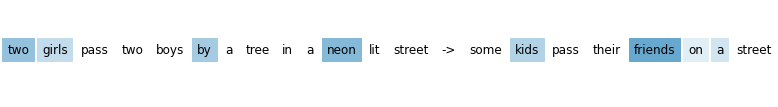


bert-base_arch-5_test_BT=[MASK].json
texts: ['Two girls pass two boys by a tree in a neon lit street.', 'Some kids pass their friends on a street.']
gold label: neutral
pred label: neutral
explanations: [(('tree',), ('some', 'pass', 'friends')), (('neon', 'street'), ('street',))]
interactions_vote: []
interactions_union: []


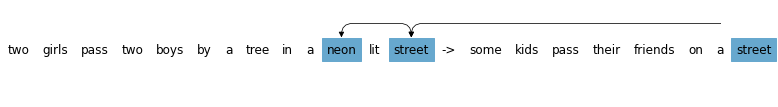


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['Two girls pass two boys by a tree in a neon lit street.', 'Some kids pass their friends on a street.']
gold label: neutral
pred label: neutral
explanations: [(('street',), ('friends',)), (('in',), ('street',))]
interactions_vote: []
interactions_union: []


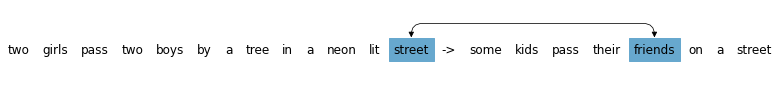


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Two girls pass two boys by a tree in a neon lit street.', 'Some kids pass their friends on a street.']
gold label: neutral
pred label: neutral
explanations: [(('street',), ('friends',)), (('neon',), ('friends',)), (('pass',), ('friends',)), (('girls',), ('friends',)), (('boys',), ('friends',)), (('a',), ('friends',)), (('by',), ('friends',)), (('in',), ('friends',)), (('lit',), ('friends',)), (('two',), ('friends',)), (('tree',), ('friends',)), (('neon',), ('some',)), (('neon',), ('their',)), (('neon',), ('street',)), (('street',), ('some',)), (('two',), ('some',)), (('in',), ('some',)), (('girls',), ('their',))]
interactions_vote: []
interactions_union: []


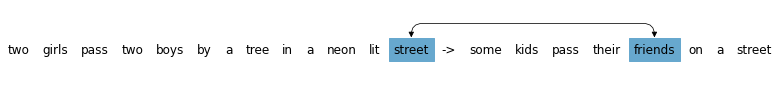


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Two girls pass two boys by a tree in a neon lit street.', 'Some kids pass their friends on a street.']
gold label: neutral
pred label: neutral
explanations: [(('girls', 'street'), ('friends',)), (('girls', 'neon'), ('friends',)), (('pass', 'street'), ('friends',)), (('street',), ('friends', 'street')), (('pass', 'neon'), ('friends',)), (('boys', 'street'), ('friends',)), (('tree', 'street'), ('friends',)), (('neon', 'street'), ('friends',)), (('street',), ('their', 'friends')), (('boys', 'neon'), ('friends',))]
interactions_vote: []
interactions_union: []


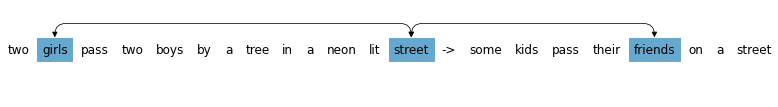


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['Two girls pass two boys by a tree in a neon lit street.', 'Some kids pass their friends on a street.']
gold label: neutral
pred label: neutral
explanations: [(('girls', 'street'), ('their', 'friends')), (('girls', 'tree', 'street'), ('friends',)), (('girls', 'neon'), ('their', 'friends')), (('girls', 'pass', 'street'), ('friends',)), (('girls', 'a', 'street'), ('friends',)), (('girls', 'pass', 'neon'), ('friends',)), (('tree', 'street'), ('friends', 'street')), (('pass', 'tree', 'street'), ('friends',)), (('boys', 'neon'), ('their', 'friends')), (('girls', 'neon', 'street'), ('friends',)), (('boys', 'street'), ('their', 'friends')), (('pass', 'street'), ('their', 'friends')), (('pass', 'neon'), ('friends', 'street')), (('girls', 'a', 'neon'), ('friends',)), (('pass', 'a', 'street'), ('friends',)), (('pass', 'a', 'neon'), ('friends',)), (('boys', 'tree', 'street'), ('friends',)), (('girls', 'neon

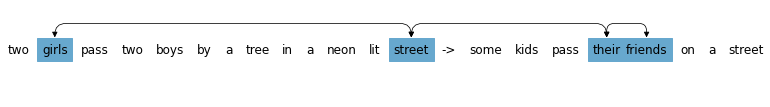

############################ 797 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['A man stands on a dock near several boats, while 2 other men are on one of the boats.', 'A man is sitting on a dock.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('sitting',)), (('stands',), ()), (('2',), ()), ((), ('man',)), (('are',), ()), (('men',), ()), ((), ('on',)), (('the',), ()), (('of',), ())]
interactions_vote: [(['stands'], ['sitting'])]
interactions_union: [(['stands', 'on'], ['sitting', 'on']), (['stands', 'on'], ['dock']), (['dock'], ['sitting', 'on']), (['dock'], ['dock']), (['2', 'other', 'men'], ['sitting', 'on']), (['2', 'other', 'men'], ['dock'])]


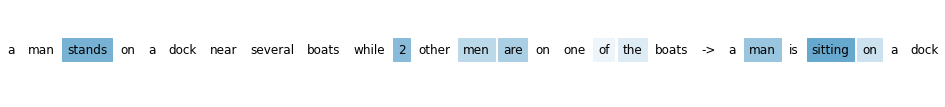


bert-base_arch-5_test_BT=[MASK].json
texts: ['A man stands on a dock near several boats, while 2 other men are on one of the boats.', 'A man is sitting on a dock.']
gold label: contradiction
pred label: contradiction
explanations: [(('stands', 'dock'), ('man', 'sitting', 'dock'))]
interactions_vote: [(['stands'], ['sitting'])]
interactions_union: [(['stands', 'on'], ['sitting', 'on']), (['stands', 'on'], ['dock']), (['dock'], ['sitting', 'on']), (['dock'], ['dock']), (['2', 'other', 'men'], ['sitting', 'on']), (['2', 'other', 'men'], ['dock'])]


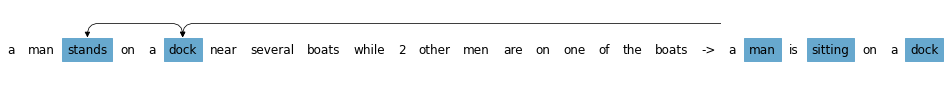


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A man stands on a dock near several boats, while 2 other men are on one of the boats.', 'A man is sitting on a dock.']
gold label: contradiction
pred label: contradiction
explanations: [(('stands', 'dock'), ('sitting', 'dock')), (('on',), ('dock',))]
interactions_vote: [(['stands'], ['sitting'])]
interactions_union: [(['stands', 'on'], ['sitting', 'on']), (['stands', 'on'], ['dock']), (['dock'], ['sitting', 'on']), (['dock'], ['dock']), (['2', 'other', 'men'], ['sitting', 'on']), (['2', 'other', 'men'], ['dock'])]


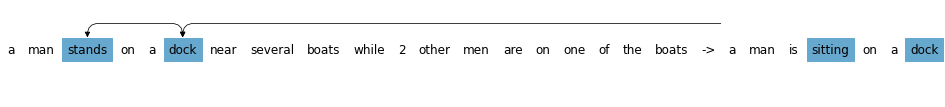


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A man stands on a dock near several boats, while 2 other men are on one of the boats.', 'A man is sitting on a dock.']
gold label: contradiction
pred label: contradiction
explanations: [(('stands',), ('sitting',)), (('2',), ('sitting',)), (('men',), ('sitting',)), (('while',), ('sitting',)), (('other',), ('sitting',)), (('several',), ('sitting',)), (('boats',), ('sitting',)), (('are',), ('sitting',)), (('of',), ('sitting',)), (('the',), ('sitting',)), (('one',), ('sitting',)), (('dock',), ('sitting',)), (('a',), ('sitting',)), (('man',), ('sitting',)), (('near',), ('sitting',)), (('on',), ('sitting',)), (('stands',), ('man',))]
interactions_vote: [(['stands'], ['sitting'])]
interactions_union: [(['stands', 'on'], ['sitting', 'on']), (['stands', 'on'], ['dock']), (['dock'], ['sitting', 'on']), (['dock'], ['dock']), (['2', 'other', 'men'], ['sitting', 'on']), (['2', 'other', 'men'], ['dock'])]


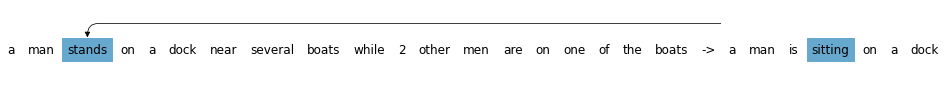


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A man stands on a dock near several boats, while 2 other men are on one of the boats.', 'A man is sitting on a dock.']
gold label: contradiction
pred label: contradiction
explanations: [(('stands',), ('sitting', 'a')), (('stands',), ('a', 'sitting')), (('stands',), ('sitting', 'on')), (('stands', 'on'), ('sitting',)), (('man', 'stands'), ('sitting',)), (('stands',), ('man', 'sitting')), (('stands', 'other'), ('sitting',)), (('stands', 'while'), ('sitting',)), (('stands',), ('sitting',)), (('stands', '2'), ('sitting',))]
interactions_vote: [(['stands'], ['sitting'])]
interactions_union: [(['stands', 'on'], ['sitting', 'on']), (['stands', 'on'], ['dock']), (['dock'], ['sitting', 'on']), (['dock'], ['dock']), (['2', 'other', 'men'], ['sitting', 'on']), (['2', 'other', 'men'], ['dock'])]


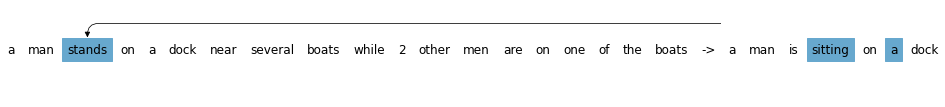


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A man stands on a dock near several boats, while 2 other men are on one of the boats.', 'A man is sitting on a dock.']
gold label: contradiction
pred label: contradiction
explanations: [(('stands',), ('a', 'sitting', 'a')), (('stands', 'while'), ('sitting', 'a')), (('stands',), ('a', 'sitting', 'on')), (('stands',), ('sitting', 'on', 'a')), (('stands', 'boats'), ('sitting', 'a')), (('stands', 'of'), ('sitting', 'a')), (('stands', 'while'), ('sitting', 'on')), (('stands',), ('man', 'sitting', 'a')), (('stands', 'on'), ('sitting', 'a')), (('stands', 'other'), ('sitting', 'a')), (('stands', 'while'), ('a', 'sitting')), (('stands',), ('is', 'sitting', 'on')), (('stands',), ('is', 'sitting', 'a')), (('stands', 'the'), ('sitting', 'a')), (('stands',), ('man', 'sitting', 'on')), (('stands', 'men'), ('sitting', 'a')), (('man', 'stands'), ('sitting', 'a')), (('man', 'stands'), ('sitting', 'on')), (('stan

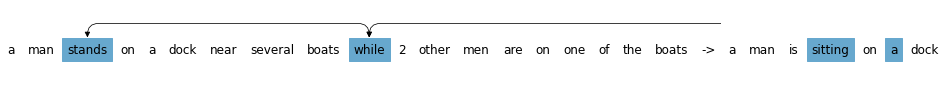

############################ 342 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['People landscaping and gardening the areas around the walkway.', 'People are caring for their lawns']
gold label: entailment
pred label: entailment
explanations: [((), ('caring',)), (('gardening',), ()), ((), ('lawns',)), (('landscaping',), ()), (('People',), ()), (('the',), ()), ((), ('People',)), ((), ())]
interactions_vote: [(['landscaping'], ['caring', 'for', 'their', 'lawns']), (['gardening'], ['caring', 'for', 'their', 'lawns'])]
interactions_union: [(['landscaping', 'and', 'gardening'], ['caring', 'for', 'their', 'lawns']), (['areas'], ['caring', 'for', 'their', 'lawns'])]


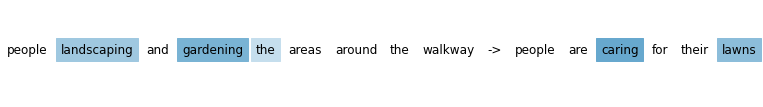


bert-base_arch-5_test_BT=[MASK].json
texts: ['People landscaping and gardening the areas around the walkway.', 'People are caring for their lawns']
gold label: entailment
pred label: entailment
explanations: [(('landscaping', 'gardening'), ('people', 'lawns')), ((), ('caring', 'for', 'their'))]
interactions_vote: [(['landscaping'], ['caring', 'for', 'their', 'lawns']), (['gardening'], ['caring', 'for', 'their', 'lawns'])]
interactions_union: [(['landscaping', 'and', 'gardening'], ['caring', 'for', 'their', 'lawns']), (['areas'], ['caring', 'for', 'their', 'lawns'])]


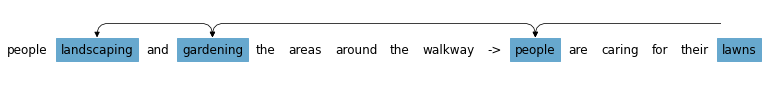


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['People landscaping and gardening the areas around the walkway.', 'People are caring for their lawns']
gold label: entailment
pred label: entailment
explanations: [(('landscaping', 'gardening'), ('lawns',)), (('walkway',), ('caring',))]
interactions_vote: [(['landscaping'], ['caring', 'for', 'their', 'lawns']), (['gardening'], ['caring', 'for', 'their', 'lawns'])]
interactions_union: [(['landscaping', 'and', 'gardening'], ['caring', 'for', 'their', 'lawns']), (['areas'], ['caring', 'for', 'their', 'lawns'])]


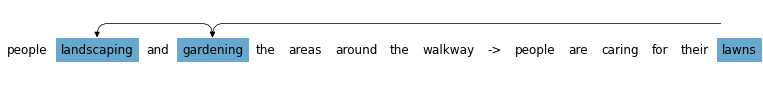


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['People landscaping and gardening the areas around the walkway.', 'People are caring for their lawns']
gold label: entailment
pred label: entailment
explanations: [(('gardening',), ('caring',)), (('gardening',), ('lawns',)), (('gardening',), ('for',)), (('landscaping',), ('lawns',)), (('gardening',), ('people',)), (('people',), ('caring',)), (('people',), ('lawns',)), (('gardening',), ('are',)), (('people',), ('for',)), (('landscaping',), ('caring',)), (('the',), ('lawns',)), (('the',), ('caring',)), (('landscaping',), ('for',)), (('walkway',), ('caring',)), (('people',), ('people',)), (('around',), ('caring',)), (('and',), ('caring',))]
interactions_vote: [(['landscaping'], ['caring', 'for', 'their', 'lawns']), (['gardening'], ['caring', 'for', 'their', 'lawns'])]
interactions_union: [(['landscaping', 'and', 'gardening'], ['caring', 'for', 'their', 'lawns']), (['areas'], ['caring', 'for', 'their', 'lawns']

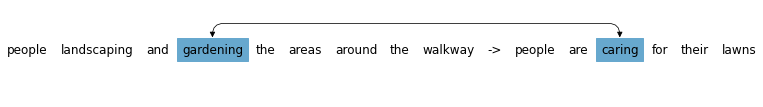


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['People landscaping and gardening the areas around the walkway.', 'People are caring for their lawns']
gold label: entailment
pred label: entailment
explanations: [(('gardening',), ('caring', 'for')), (('gardening',), ('caring', 'lawns')), (('gardening', 'the'), ('caring',)), (('gardening',), ('lawns',)), (('gardening',), ('are', 'caring')), (('gardening',), ('caring', 'their')), (('gardening',), ('for', 'lawns')), (('gardening', 'walkway'), ('caring',)), (('people', 'gardening'), ('caring',))]
interactions_vote: [(['landscaping'], ['caring', 'for', 'their', 'lawns']), (['gardening'], ['caring', 'for', 'their', 'lawns'])]
interactions_union: [(['landscaping', 'and', 'gardening'], ['caring', 'for', 'their', 'lawns']), (['areas'], ['caring', 'for', 'their', 'lawns'])]


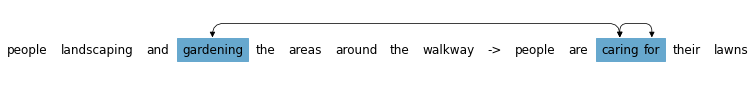


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['People landscaping and gardening the areas around the walkway.', 'People are caring for their lawns']
gold label: entailment
pred label: entailment
explanations: [(('gardening',), ('caring', 'for', 'lawns')), (('people', 'gardening'), ('caring', 'for')), (('gardening', 'walkway'), ('caring', 'for')), (('gardening',), ('caring', 'lawns')), (('gardening', 'around'), ('caring', 'for')), (('gardening',), ('are', 'caring', 'for')), (('gardening', 'the'), ('caring', 'for')), (('gardening',), ('people', 'caring', 'lawns')), (('and', 'gardening'), ('caring', 'for')), (('gardening',), ('people', 'caring', 'for')), (('people', 'gardening'), ('caring', 'lawns')), (('gardening', 'the'), ('caring', 'lawns')), (('gardening',), ('caring', 'for', 'their')), (('gardening', 'walkway'), ('caring', 'lawns')), (('landscaping',), ('caring', 'for', 'lawns')), (('gardening',), ('are', 'caring', 'lawns')), (('and', 'gar

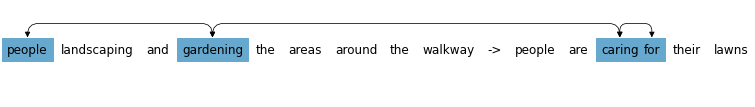

############################ 170 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['Girls giving a presentation for a school class.', 'The girls are watching a presentation in a classroom.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('watching',)), (('giving',), ()), ((), ('girls',)), (('presentation',), ()), (('for',), ()), ((), ('in',)), ((), ('a',)), ((), ('The',)), ((), ()), (('a',), ())]
interactions_vote: [(['giving'], ['watching']), (['giving'], ['presentation']), (['presentation'], ['watching']), (['presentation'], ['presentation'])]
interactions_union: [(['giving', 'a', 'presentation'], ['watching', 'a', 'presentation'])]


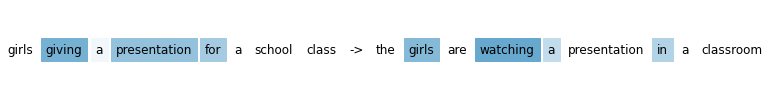


bert-base_arch-5_test_BT=[MASK].json
texts: ['Girls giving a presentation for a school class.', 'The girls are watching a presentation in a classroom.']
gold label: contradiction
pred label: contradiction
explanations: [(('giving', 'presentation'), ('girls', 'watching', 'presentation'))]
interactions_vote: [(['giving'], ['watching']), (['giving'], ['presentation']), (['presentation'], ['watching']), (['presentation'], ['presentation'])]
interactions_union: [(['giving', 'a', 'presentation'], ['watching', 'a', 'presentation'])]


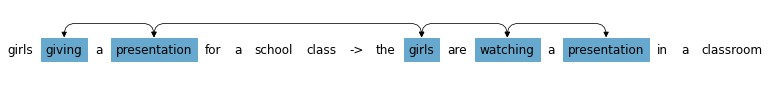


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['Girls giving a presentation for a school class.', 'The girls are watching a presentation in a classroom.']
gold label: contradiction
pred label: contradiction
explanations: [(('giving', 'presentation'), ('watching', 'presentation'))]
interactions_vote: [(['giving'], ['watching']), (['giving'], ['presentation']), (['presentation'], ['watching']), (['presentation'], ['presentation'])]
interactions_union: [(['giving', 'a', 'presentation'], ['watching', 'a', 'presentation'])]


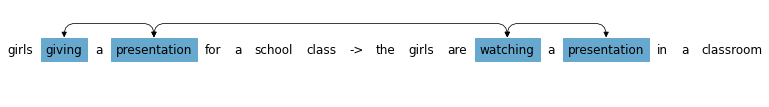


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Girls giving a presentation for a school class.', 'The girls are watching a presentation in a classroom.']
gold label: contradiction
pred label: contradiction
explanations: [(('giving',), ('watching',)), (('presentation',), ('watching',)), (('for',), ('watching',)), (('girls',), ('watching',)), (('school',), ('watching',)), (('a',), ('watching',)), (('class',), ('watching',)), (('giving',), ('girls',)), (('giving',), ('in',)), (('giving',), ('classroom',)), (('giving',), ('are',)), (('giving',), ('presentation',)), (('giving',), ('the',)), (('giving',), ('a',)), (('for',), ('in',)), (('presentation',), ('girls',)), (('for',), ('girls',)), (('for',), ('classroom',))]
interactions_vote: [(['giving'], ['watching']), (['giving'], ['presentation']), (['presentation'], ['watching']), (['presentation'], ['presentation'])]
interactions_union: [(['giving', 'a', 'presentation'], ['watching', 'a', 'presentation'])]


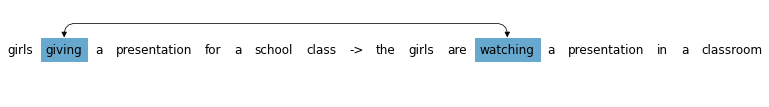


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Girls giving a presentation for a school class.', 'The girls are watching a presentation in a classroom.']
gold label: contradiction
pred label: contradiction
explanations: [(('giving',), ('watching', 'presentation')), (('giving',), ('girls', 'watching')), (('giving',), ('watching', 'classroom')), (('giving',), ('watching', 'in')), (('giving', 'presentation'), ('watching',)), (('giving', 'for'), ('watching',)), (('giving',), ('watching', 'a')), (('giving', 'school'), ('watching',)), (('giving',), ('watching',)), (('giving', 'a'), ('watching',))]
interactions_vote: [(['giving'], ['watching']), (['giving'], ['presentation']), (['presentation'], ['watching']), (['presentation'], ['presentation'])]
interactions_union: [(['giving', 'a', 'presentation'], ['watching', 'a', 'presentation'])]


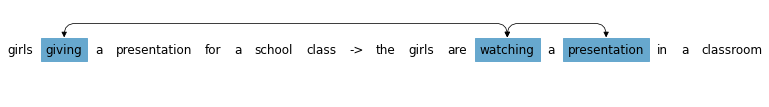


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['Girls giving a presentation for a school class.', 'The girls are watching a presentation in a classroom.']
gold label: contradiction
pred label: contradiction
explanations: [(('giving',), ('watching', 'presentation', 'in')), (('giving',), ('girls', 'watching', 'presentation')), (('giving', 'for'), ('girls', 'watching')), (('giving', 'for'), ('watching', 'presentation')), (('giving', 'presentation'), ('girls', 'watching')), (('giving',), ('the', 'girls', 'watching')), (('giving',), ('girls', 'watching', 'classroom')), (('giving',), ('girls', 'watching', 'in')), (('girls', 'giving'), ('girls', 'watching')), (('giving',), ('watching', 'presentation', 'classroom')), (('giving', 'a'), ('girls', 'watching')), (('giving',), ('the', 'watching', 'presentation')), (('giving', 'school'), ('watching', 'presentation')), (('giving', 'a'), ('watching', 'presentation')), (('giving',), ('watching', 'presentation

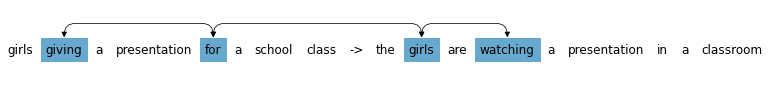

############################ 991 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['Navy men stand along a red carpet and salute as their superior walks by.', 'Some men are saluting their superior out of respect.']
gold label: neutral
pred label: neutral
explanations: [((), ('respect',)), ((), ('superior',)), ((), ('out',)), ((), ('saluting',)), ((), ('Some',)), (('walks',), ()), ((), ('are',)), ((), ('of',)), (('by',), ()), ((), ('their',)), ((), ('men',)), (('red',), ()), (('as',), ()), (('a',), ())]
interactions_vote: []
interactions_union: []


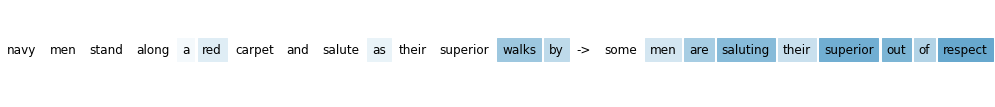


bert-base_arch-5_test_BT=[MASK].json
texts: ['Navy men stand along a red carpet and salute as their superior walks by.', 'Some men are saluting their superior out of respect.']
gold label: neutral
pred label: neutral
explanations: [(('superior',), ('superior', 'out', 'of', 'respect'))]
interactions_vote: []
interactions_union: []


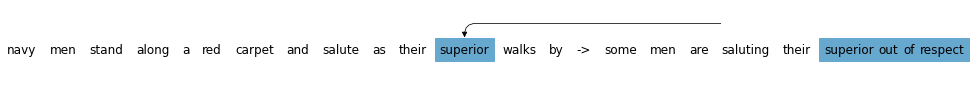


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['Navy men stand along a red carpet and salute as their superior walks by.', 'Some men are saluting their superior out of respect.']
gold label: neutral
pred label: neutral
explanations: [(('red',), ('superior',)), (('salute', 'superior'), ('superior', 'respect'))]
interactions_vote: []
interactions_union: []


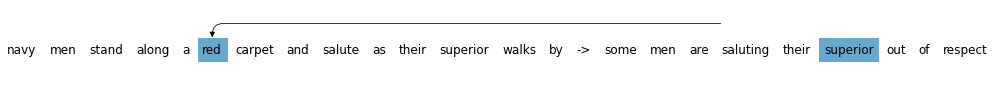


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Navy men stand along a red carpet and salute as their superior walks by.', 'Some men are saluting their superior out of respect.']
gold label: neutral
pred label: neutral
explanations: [(('by',), ('respect',)), (('walks',), ('respect',)), (('navy',), ('respect',)), (('their',), ('respect',)), (('red',), ('respect',)), (('a',), ('respect',)), (('men',), ('respect',)), (('carpet',), ('respect',)), (('as',), ('respect',)), (('stand',), ('respect',)), (('along',), ('respect',)), (('and',), ('respect',)), (('stand',), ('superior',)), (('by',), ('superior',)), (('stand',), ('saluting',)), (('men',), ('superior',)), (('a',), ('superior',)), (('red',), ('superior',)), (('salute',), ('respect',)), (('red',), ('saluting',))]
interactions_vote: []
interactions_union: []


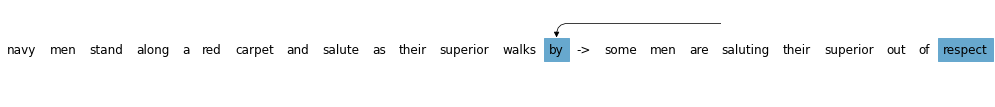


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Navy men stand along a red carpet and salute as their superior walks by.', 'Some men are saluting their superior out of respect.']
gold label: neutral
pred label: neutral
explanations: [(('by',), ('superior', 'respect')), (('men',), ('superior', 'respect')), (('walks',), ('superior', 'respect')), (('red',), ('superior', 'respect')), (('by',), ('out', 'respect')), (('a',), ('superior', 'respect')), (('a',), ('out', 'respect')), (('walks',), ('out', 'respect')), (('navy',), ('superior', 'respect')), (('their',), ('superior', 'respect'))]
interactions_vote: []
interactions_union: []


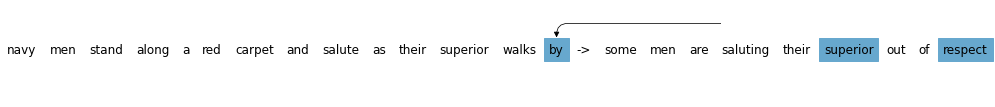


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['Navy men stand along a red carpet and salute as their superior walks by.', 'Some men are saluting their superior out of respect.']
gold label: neutral
pred label: neutral
explanations: [(('men',), ('superior', 'out', 'respect')), (('navy',), ('superior', 'out', 'respect')), (('salute',), ('superior', 'out', 'respect')), (('stand',), ('superior', 'out', 'respect')), (('red',), ('superior', 'out', 'respect')), (('their',), ('superior', 'out', 'respect')), (('and',), ('superior', 'out', 'respect')), (('superior',), ('superior', 'out', 'respect')), (('a',), ('superior', 'out', 'respect')), (('by',), ('superior', 'out', 'respect')), (('their',), ('saluting', 'superior', 'respect')), (('as',), ('superior', 'out', 'respect')), (('along',), ('superior', 'out', 'respect')), (('men',), ('their', 'superior', 'respect')), (('carpet',), ('superior', 'out', 'respect')), (('walks',), ('superior', 'out', 'respe

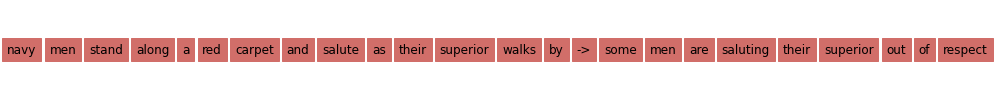

############################ 701 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['A man wearing a brightly green camouflage patterned denim jacket and boots walks by a building labeled Lottery Ticket Centre.', 'A man in a red jacket is near a building labeled Lottery Ticket Centre.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('red',)), (('green',), ()), ((), ('jacket',)), ((), ('in',)), (('denim',), ()), (('brightly',), ()), (('wearing',), ()), (('jacket',), ()), (('and',), ()), ((), ('A',)), (('a',), ())]
interactions_vote: [(['green'], ['red'])]
interactions_union: [(['green', 'camouflage'], ['red', 'jacket'])]


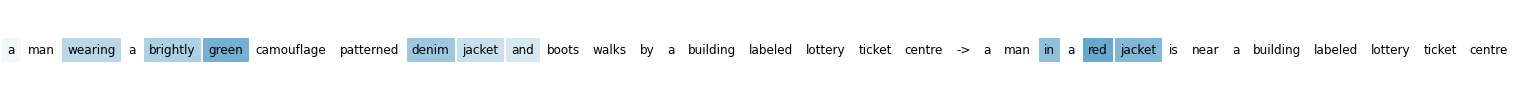


bert-base_arch-5_test_BT=[MASK].json
texts: ['A man wearing a brightly green camouflage patterned denim jacket and boots walks by a building labeled Lottery Ticket Centre.', 'A man in a red jacket is near a building labeled Lottery Ticket Centre.']
gold label: contradiction
pred label: contradiction
explanations: [(('green', 'denim'), ('in', 'red', 'jacket'))]
interactions_vote: [(['green'], ['red'])]
interactions_union: [(['green', 'camouflage'], ['red', 'jacket'])]


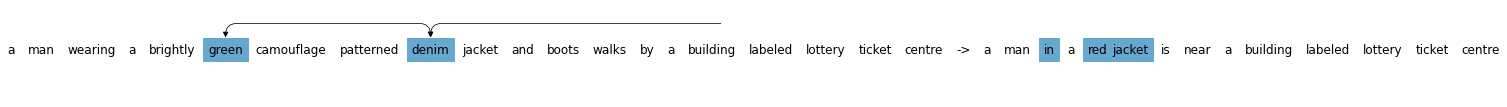


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A man wearing a brightly green camouflage patterned denim jacket and boots walks by a building labeled Lottery Ticket Centre.', 'A man in a red jacket is near a building labeled Lottery Ticket Centre.']
gold label: contradiction
pred label: contradiction
explanations: [(('green', 'jacket'), ('red',))]
interactions_vote: [(['green'], ['red'])]
interactions_union: [(['green', 'camouflage'], ['red', 'jacket'])]


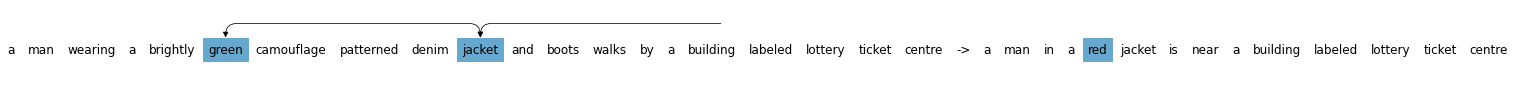


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A man wearing a brightly green camouflage patterned denim jacket and boots walks by a building labeled Lottery Ticket Centre.', 'A man in a red jacket is near a building labeled Lottery Ticket Centre.']
gold label: contradiction
pred label: contradiction
explanations: [(('green',), ('red',)), (('denim',), ('red',)), (('brightly',), ('red',)), (('patterned',), ('red',)), (('wearing',), ('red',)), (('and',), ('red',)), (('by',), ('red',)), (('camouflage',), ('red',)), (('walks',), ('red',)), (('centre',), ('red',)), (('man',), ('red',)), (('labeled',), ('red',)), (('a',), ('red',)), (('building',), ('red',)), (('jacket',), ('red',)), (('boots',), ('red',)), (('lottery',), ('red',)), (('ticket',), ('red',))]
interactions_vote: [(['green'], ['red'])]
interactions_union: [(['green', 'camouflage'], ['red', 'jacket'])]


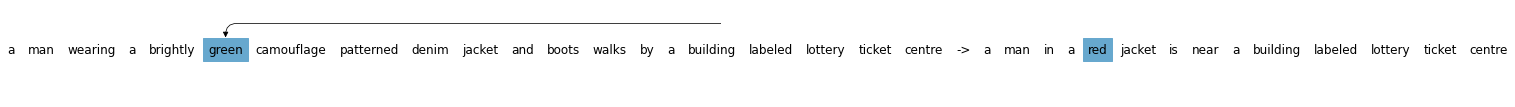


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A man wearing a brightly green camouflage patterned denim jacket and boots walks by a building labeled Lottery Ticket Centre.', 'A man in a red jacket is near a building labeled Lottery Ticket Centre.']
gold label: contradiction
pred label: contradiction
explanations: [(('green',), ('in', 'red')), (('green',), ('red', 'jacket')), (('green',), ('red', 'a')), (('a', 'green'), ('red',)), (('green', 'patterned'), ('red',)), (('green',), ('man', 'red')), (('green',), ('a', 'red')), (('brightly', 'green'), ('red',)), (('green',), ('red', 'building'))]
interactions_vote: [(['green'], ['red'])]
interactions_union: [(['green', 'camouflage'], ['red', 'jacket'])]


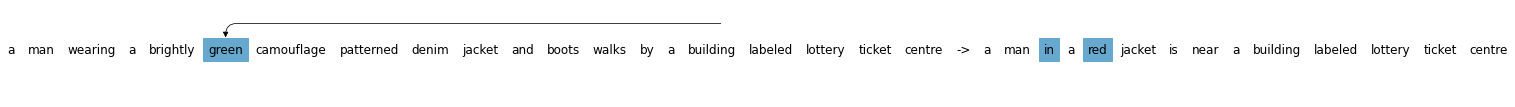


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A man wearing a brightly green camouflage patterned denim jacket and boots walks by a building labeled Lottery Ticket Centre.', 'A man in a red jacket is near a building labeled Lottery Ticket Centre.']
gold label: contradiction
pred label: contradiction
explanations: [(('wearing', 'green'), ('in', 'red')), (('green',), ('in', 'red', 'a')), (('green',), ('a', 'in', 'red')), (('brightly', 'green'), ('in', 'red')), (('a', 'green'), ('in', 'red')), (('green', 'jacket'), ('in', 'red')), (('green',), ('man', 'in', 'red')), (('green', 'and'), ('in', 'red')), (('green', 'by'), ('in', 'red')), (('green', 'a'), ('in', 'red')), (('green', 'walks'), ('in', 'red')), (('green',), ('in', 'red', 'jacket')), (('green',), ('in', 'red', 'lottery')), (('green', 'patterned'), ('in', 'red')), (('man', 'green'), ('in', 'red')), (('green',), ('in', 'red', 'building')), (('green', 'centre'), ('in', 'red')), (('green', 

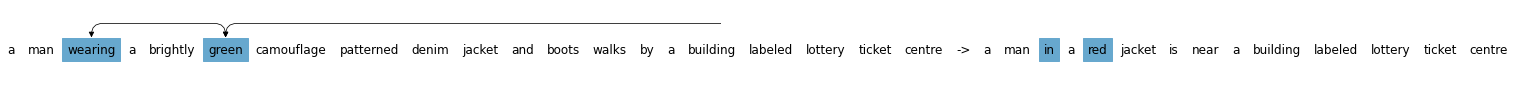

############################ 791 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['Two scuba divers inspecting a large metal object in the water.', 'Two scuba divers are running a marathon.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('marathon',)), ((), ('running',)), (('inspecting',), ()), (('object',), ()), (('scuba',), ()), (('a',), ()), (('divers',), ()), (('the',), ()), (('in',), ()), ((), ('Two',)), (('Two',), ()), (('large',), ()), ((), ()), (('metal',), ())]
interactions_vote: [(['inspecting'], ['running']), (['inspecting'], ['marathon']), (['in', 'the', 'water'], ['running']), (['in', 'the', 'water'], ['marathon'])]
interactions_union: [(['inspecting'], ['running', 'a', 'marathon']), (['object', 'in', 'the', 'water'], ['running', 'a', 'marathon'])]


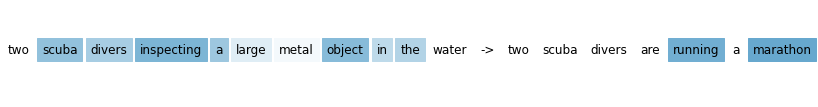


bert-base_arch-5_test_BT=[MASK].json
texts: ['Two scuba divers inspecting a large metal object in the water.', 'Two scuba divers are running a marathon.']
gold label: contradiction
pred label: contradiction
explanations: [(('scuba', 'divers', 'inspecting'), ('scuba', 'a', 'marathon'))]
interactions_vote: [(['inspecting'], ['running']), (['inspecting'], ['marathon']), (['in', 'the', 'water'], ['running']), (['in', 'the', 'water'], ['marathon'])]
interactions_union: [(['inspecting'], ['running', 'a', 'marathon']), (['object', 'in', 'the', 'water'], ['running', 'a', 'marathon'])]


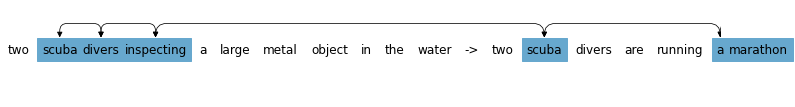


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['Two scuba divers inspecting a large metal object in the water.', 'Two scuba divers are running a marathon.']
gold label: contradiction
pred label: contradiction
explanations: [(('inspecting',), ('marathon',)), (('scuba',), ('scuba', 'marathon')), (('water',), ('scuba',))]
interactions_vote: [(['inspecting'], ['running']), (['inspecting'], ['marathon']), (['in', 'the', 'water'], ['running']), (['in', 'the', 'water'], ['marathon'])]
interactions_union: [(['inspecting'], ['running', 'a', 'marathon']), (['object', 'in', 'the', 'water'], ['running', 'a', 'marathon'])]


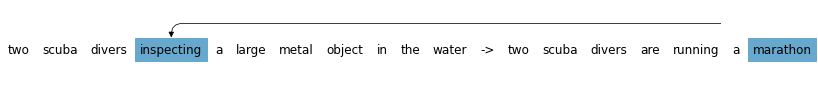


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Two scuba divers inspecting a large metal object in the water.', 'Two scuba divers are running a marathon.']
gold label: contradiction
pred label: contradiction
explanations: [(('inspecting',), ('marathon',)), (('object',), ('marathon',)), (('scuba',), ('marathon',)), (('divers',), ('marathon',)), (('large',), ('marathon',)), (('metal',), ('marathon',)), (('in',), ('marathon',)), (('the',), ('marathon',)), (('water',), ('marathon',)), (('two',), ('marathon',)), (('a',), ('marathon',)), (('inspecting',), ('running',)), (('scuba',), ('running',)), (('object',), ('running',)), (('divers',), ('running',)), (('in',), ('running',)), (('metal',), ('running',)), (('two',), ('running',)), (('large',), ('running',)), (('a',), ('running',))]
interactions_vote: [(['inspecting'], ['running']), (['inspecting'], ['marathon']), (['in', 'the', 'water'], ['running']), (['in', 'the', 'water'], ['marathon'])]
interactions_uni

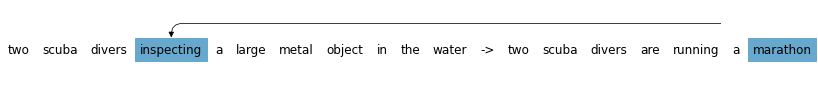


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Two scuba divers inspecting a large metal object in the water.', 'Two scuba divers are running a marathon.']
gold label: contradiction
pred label: contradiction
explanations: [(('scuba',), ('running', 'marathon')), (('inspecting',), ('running', 'marathon')), (('divers',), ('running', 'marathon')), (('object',), ('running', 'marathon')), (('scuba',), ('a', 'marathon')), (('inspecting',), ('a', 'marathon')), (('metal',), ('running', 'marathon')), (('inspecting', 'object'), ('marathon',)), (('scuba', 'object'), ('marathon',)), (('water',), ('running', 'marathon'))]
interactions_vote: [(['inspecting'], ['running']), (['inspecting'], ['marathon']), (['in', 'the', 'water'], ['running']), (['in', 'the', 'water'], ['marathon'])]
interactions_union: [(['inspecting'], ['running', 'a', 'marathon']), (['object', 'in', 'the', 'water'], ['running', 'a', 'marathon'])]


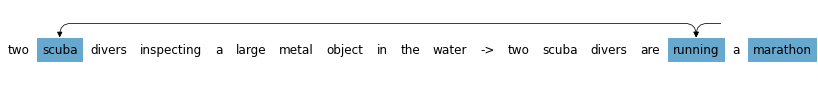


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['Two scuba divers inspecting a large metal object in the water.', 'Two scuba divers are running a marathon.']
gold label: contradiction
pred label: contradiction
explanations: [(('scuba',), ('divers', 'running', 'marathon')), (('scuba', 'object'), ('running', 'marathon')), (('scuba',), ('running', 'a', 'marathon')), (('scuba', 'inspecting'), ('running', 'marathon')), (('scuba', 'in'), ('running', 'marathon')), (('scuba',), ('are', 'running', 'marathon')), (('inspecting',), ('running', 'a', 'marathon')), (('scuba', 'the'), ('running', 'marathon')), (('scuba', 'divers'), ('running', 'marathon')), (('scuba', 'large'), ('running', 'marathon')), (('scuba',), ('two', 'running', 'marathon')), (('scuba', 'a'), ('running', 'marathon')), (('divers', 'inspecting'), ('running', 'marathon')), (('scuba', 'metal'), ('running', 'marathon')), (('two', 'scuba'), ('running', 'marathon')), (('scuba', 'water'), ('run

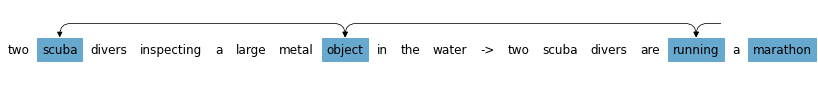

############################ 687 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['Two men walking in summer attire.', 'Two men are walking.']
gold label: entailment
pred label: entailment
explanations: [(('walking',), ()), (('men',), ()), (('Two',), ()), (('attire',), ())]
interactions_vote: [(['walking', 'in', 'summer', 'attire'], ['are', 'walking'])]
interactions_union: [(['walking', 'in', 'summer', 'attire'], ['Two', 'men', 'are', 'walking'])]


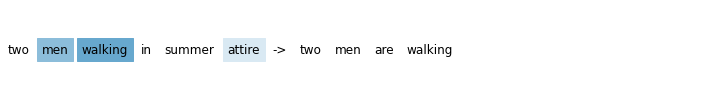


bert-base_arch-5_test_BT=[MASK].json
texts: ['Two men walking in summer attire.', 'Two men are walking.']
gold label: entailment
pred label: entailment
explanations: [(('men', 'walking'), ('men', 'walking'))]
interactions_vote: [(['walking', 'in', 'summer', 'attire'], ['are', 'walking'])]
interactions_union: [(['walking', 'in', 'summer', 'attire'], ['Two', 'men', 'are', 'walking'])]


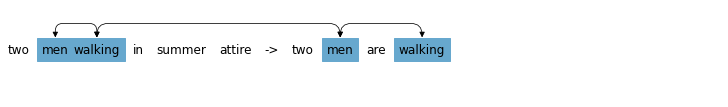


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['Two men walking in summer attire.', 'Two men are walking.']
gold label: entailment
pred label: entailment
explanations: [(('men', 'walking'), ('men', 'walking')), (('men',), ('two',))]
interactions_vote: [(['walking', 'in', 'summer', 'attire'], ['are', 'walking'])]
interactions_union: [(['walking', 'in', 'summer', 'attire'], ['Two', 'men', 'are', 'walking'])]


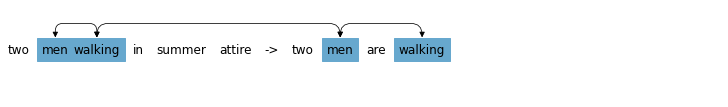


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Two men walking in summer attire.', 'Two men are walking.']
gold label: entailment
pred label: entailment
explanations: [(('walking',), ('walking',)), (('men',), ('walking',)), (('walking',), ('two',)), (('men',), ('men',)), (('men',), ('two',)), (('two',), ('walking',)), (('walking',), ('men',)), (('attire',), ('walking',)), (('in',), ('walking',)), (('summer',), ('walking',)), (('walking',), ('are',)), (('two',), ('two',)), (('attire',), ('two',)), (('two',), ('men',)), (('attire',), ('men',)), (('summer',), ('two',)), (('in',), ('two',)), (('in',), ('men',)), (('men',), ('are',)), (('summer',), ('men',))]
interactions_vote: [(['walking', 'in', 'summer', 'attire'], ['are', 'walking'])]
interactions_union: [(['walking', 'in', 'summer', 'attire'], ['Two', 'men', 'are', 'walking'])]


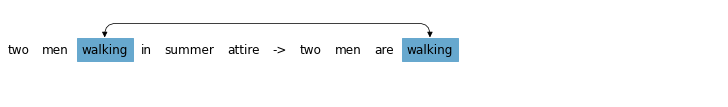


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Two men walking in summer attire.', 'Two men are walking.']
gold label: entailment
pred label: entailment
explanations: [(('men', 'walking'), ('walking',)), (('two', 'walking'), ('walking',)), (('walking', 'in'), ('walking',)), (('walking',), ('are', 'walking')), (('walking', 'attire'), ('walking',)), (('walking',), ('walking',)), (('walking', 'summer'), ('walking',)), (('walking',), ('two', 'walking')), (('men', 'walking'), ('men',)), (('men', 'walking'), ('two',))]
interactions_vote: [(['walking', 'in', 'summer', 'attire'], ['are', 'walking'])]
interactions_union: [(['walking', 'in', 'summer', 'attire'], ['Two', 'men', 'are', 'walking'])]


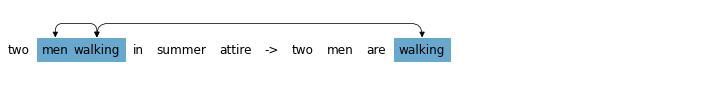


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['Two men walking in summer attire.', 'Two men are walking.']
gold label: entailment
pred label: entailment
explanations: [(('two', 'men', 'walking'), ('walking',)), (('men', 'walking'), ('are', 'walking')), (('men', 'walking'), ('men', 'walking')), (('men', 'walking', 'in'), ('walking',)), (('men', 'walking', 'attire'), ('walking',)), (('men', 'walking', 'summer'), ('walking',)), (('men', 'walking'), ('two', 'walking')), (('two', 'walking'), ('are', 'walking')), (('two', 'walking', 'attire'), ('walking',)), (('walking', 'attire'), ('are', 'walking')), (('two', 'walking', 'in'), ('walking',)), (('two', 'walking', 'summer'), ('walking',)), (('walking', 'in', 'attire'), ('walking',)), (('walking', 'in'), ('are', 'walking')), (('walking', 'summer'), ('are', 'walking')), (('two', 'men', 'walking'), ('men',)), (('walking', 'summer', 'attire'), ('walking',)), (('two', 'walking'), ('two', 'walking')), ((

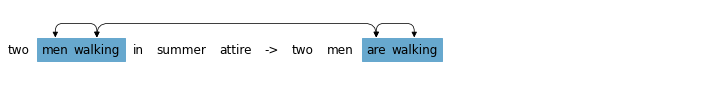

############################ 956 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['A man cooking over high flames.', 'A man is raking the yard.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('raking',)), (('cooking',), ()), ((), ('yard',)), ((), ('the',)), (('flames',), ()), ((), ('man',)), (('high',), ()), ((), ())]
interactions_vote: [(['cooking'], ['raking']), (['cooking'], ['yard'])]
interactions_union: [(['man', 'cooking'], ['man', 'is', 'raking', 'the', 'yard'])]


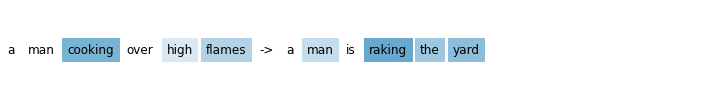


bert-base_arch-5_test_BT=[MASK].json
texts: ['A man cooking over high flames.', 'A man is raking the yard.']
gold label: contradiction
pred label: contradiction
explanations: [(('cooking', 'flames'), ('man', 'raking', 'yard'))]
interactions_vote: [(['cooking'], ['raking']), (['cooking'], ['yard'])]
interactions_union: [(['man', 'cooking'], ['man', 'is', 'raking', 'the', 'yard'])]


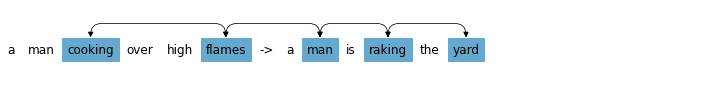


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A man cooking over high flames.', 'A man is raking the yard.']
gold label: contradiction
pred label: contradiction
explanations: [(('cooking', 'flames'), ('man', 'yard')), (('high',), ('man',)), (('a',), ('man',))]
interactions_vote: [(['cooking'], ['raking']), (['cooking'], ['yard'])]
interactions_union: [(['man', 'cooking'], ['man', 'is', 'raking', 'the', 'yard'])]


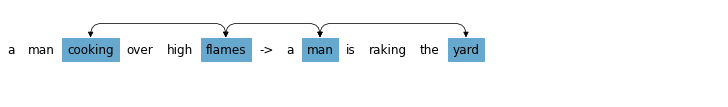


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A man cooking over high flames.', 'A man is raking the yard.']
gold label: contradiction
pred label: contradiction
explanations: [(('cooking',), ('raking',)), (('cooking',), ('yard',)), (('flames',), ('yard',)), (('cooking',), ('man',)), (('over',), ('raking',)), (('flames',), ('raking',)), (('high',), ('raking',)), (('cooking',), ('the',)), (('cooking',), ('is',)), (('a',), ('raking',)), (('over',), ('yard',)), (('high',), ('yard',)), (('flames',), ('man',)), (('cooking',), ('a',)), (('man',), ('raking',)), (('high',), ('man',))]
interactions_vote: [(['cooking'], ['raking']), (['cooking'], ['yard'])]
interactions_union: [(['man', 'cooking'], ['man', 'is', 'raking', 'the', 'yard'])]


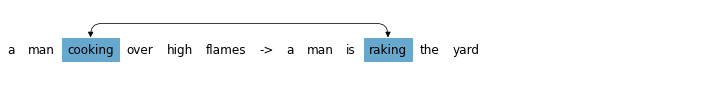


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A man cooking over high flames.', 'A man is raking the yard.']
gold label: contradiction
pred label: contradiction
explanations: [(('cooking',), ('raking',)), (('cooking',), ('raking', 'yard')), (('over',), ('raking',)), (('high',), ('raking',)), (('flames',), ('raking',)), (('a',), ('raking',)), (('man',), ('raking',)), (('cooking',), ('raking', 'the')), (('cooking',), ('man', 'raking')), (('cooking', 'over'), ('raking',))]
interactions_vote: [(['cooking'], ['raking']), (['cooking'], ['yard'])]
interactions_union: [(['man', 'cooking'], ['man', 'is', 'raking', 'the', 'yard'])]


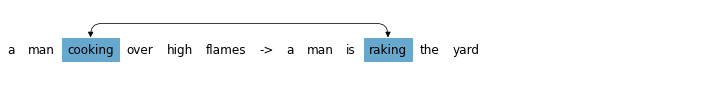


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A man cooking over high flames.', 'A man is raking the yard.']
gold label: contradiction
pred label: contradiction
explanations: [(('cooking',), ('raking', 'yard')), (('cooking',), ('raking', 'the')), (('cooking',), ('man', 'raking')), (('cooking',), ('a', 'raking')), (('cooking',), ('is', 'raking')), (('a', 'cooking'), ('raking',)), (('cooking', 'high'), ('raking',)), (('cooking', 'over'), ('raking',)), (('cooking', 'flames'), ('raking',)), (('man', 'cooking'), ('raking',)), (('cooking',), ('a', 'raking', 'yard')), (('over', 'flames'), ('raking',)), (('cooking',), ('raking', 'the', 'yard')), (('cooking', 'over'), ('raking', 'yard')), (('a', 'cooking'), ('raking', 'yard')), (('cooking', 'high'), ('raking', 'yard')), (('cooking',), ('man', 'raking', 'yard')), (('flames',), ('raking', 'yard')), (('cooking',), ('is', 'raking', 'yard')), (('man', 'cooking'), ('raking', 'yard'))]
interactions_vote: [

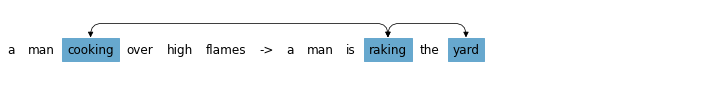

############################ 43 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['People are on an escalator waiting to get to their destination while looking outside of the glass that makes up the wall.', 'People are riding on the escalator.']
gold label: entailment
pred label: entailment
explanations: [(('escalator',), ()), ((), ('escalator',)), (('on',), ()), ((), ('are',)), ((), ('People',)), ((), ('on',)), (('looking',), ()), (('to',), ()), (('of',), ()), (('while',), ()), (('up',), ())]
interactions_vote: [(['on'], ['riding']), (['on'], ['escalator']), (['escalator'], ['riding']), (['escalator'], ['escalator'])]
interactions_union: [(['People', 'are', 'on', 'an', 'escalator', 'waiting', 'to', 'get', 'to', 'their', 'destination'], ['riding', 'on', 'the', 'escalator']), (['looking', 'outside'], ['riding', 'on', 'the', 'escalator'])]


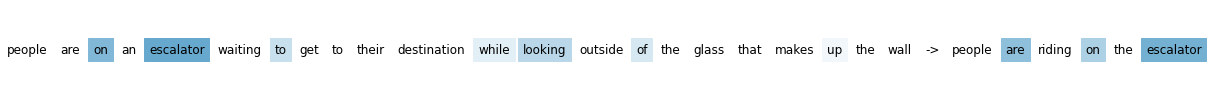


bert-base_arch-5_test_BT=[MASK].json
texts: ['People are on an escalator waiting to get to their destination while looking outside of the glass that makes up the wall.', 'People are riding on the escalator.']
gold label: entailment
pred label: entailment
explanations: [(('escalator',), ('escalator',))]
interactions_vote: [(['on'], ['riding']), (['on'], ['escalator']), (['escalator'], ['riding']), (['escalator'], ['escalator'])]
interactions_union: [(['People', 'are', 'on', 'an', 'escalator', 'waiting', 'to', 'get', 'to', 'their', 'destination'], ['riding', 'on', 'the', 'escalator']), (['looking', 'outside'], ['riding', 'on', 'the', 'escalator'])]


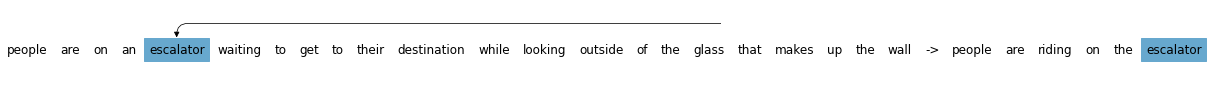


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['People are on an escalator waiting to get to their destination while looking outside of the glass that makes up the wall.', 'People are riding on the escalator.']
gold label: entailment
pred label: entailment
explanations: [(('escalator',), ('escalator',))]
interactions_vote: [(['on'], ['riding']), (['on'], ['escalator']), (['escalator'], ['riding']), (['escalator'], ['escalator'])]
interactions_union: [(['People', 'are', 'on', 'an', 'escalator', 'waiting', 'to', 'get', 'to', 'their', 'destination'], ['riding', 'on', 'the', 'escalator']), (['looking', 'outside'], ['riding', 'on', 'the', 'escalator'])]


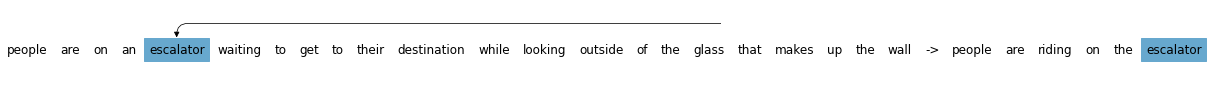


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['People are on an escalator waiting to get to their destination while looking outside of the glass that makes up the wall.', 'People are riding on the escalator.']
gold label: entailment
pred label: entailment
explanations: [(('escalator',), ('escalator',)), (('on',), ('escalator',)), (('on',), ('on',)), (('escalator',), ('on',)), (('are',), ('escalator',)), (('on',), ('people',)), (('looking',), ('escalator',)), (('their',), ('escalator',)), (('to',), ('escalator',)), (('while',), ('escalator',)), (('escalator',), ('people',))]
interactions_vote: [(['on'], ['riding']), (['on'], ['escalator']), (['escalator'], ['riding']), (['escalator'], ['escalator'])]
interactions_union: [(['People', 'are', 'on', 'an', 'escalator', 'waiting', 'to', 'get', 'to', 'their', 'destination'], ['riding', 'on', 'the', 'escalator']), (['looking', 'outside'], ['riding', 'on', 'the', 'escalator'])]


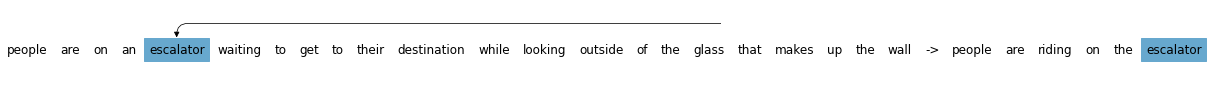


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['People are on an escalator waiting to get to their destination while looking outside of the glass that makes up the wall.', 'People are riding on the escalator.']
gold label: entailment
pred label: entailment
explanations: [(('on', 'escalator'), ('escalator',)), (('escalator',), ('escalator',)), (('people', 'escalator'), ('escalator',)), (('are', 'escalator'), ('escalator',)), (('escalator', 'their'), ('escalator',)), (('escalator', 'the'), ('escalator',)), (('escalator', 'while'), ('escalator',))]
interactions_vote: [(['on'], ['riding']), (['on'], ['escalator']), (['escalator'], ['riding']), (['escalator'], ['escalator'])]
interactions_union: [(['People', 'are', 'on', 'an', 'escalator', 'waiting', 'to', 'get', 'to', 'their', 'destination'], ['riding', 'on', 'the', 'escalator']), (['looking', 'outside'], ['riding', 'on', 'the', 'escalator'])]


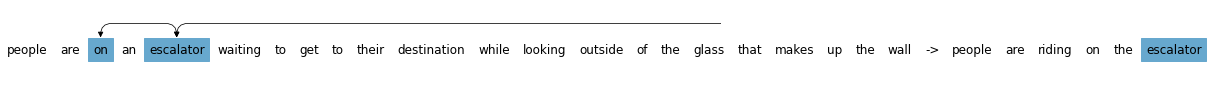


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['People are on an escalator waiting to get to their destination while looking outside of the glass that makes up the wall.', 'People are riding on the escalator.']
gold label: entailment
pred label: entailment
explanations: [(('on', 'escalator'), ('on', 'escalator')), (('on', 'escalator'), ('escalator',)), (('people', 'on', 'escalator'), ('escalator',)), (('are', 'on', 'escalator'), ('escalator',)), (('on', 'escalator', 'to'), ('escalator',)), (('on', 'escalator', 'up'), ('escalator',)), (('on', 'escalator'), ('riding', 'escalator')), (('on', 'escalator'), ('people', 'escalator')), (('on', 'escalator', 'destination'), ('escalator',)), (('on', 'escalator', 'the'), ('escalator',)), (('on', 'escalator', 'wall'), ('escalator',)), (('on', 'escalator', 'looking'), ('escalator',)), (('on', 'escalator', 'that'), ('escalator',)), (('on', 'escalator', 'makes'), ('escalator',)), (('on', 'escalator', 'their'

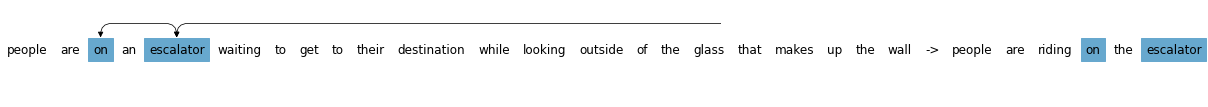

############################ 488 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['A man wearing a blue jacket fishing in a river having a conversation with his friend with no shirt.', 'A man is having a conversation with his friend while fishing.']
gold label: entailment
pred label: entailment
explanations: [(('fishing',), ()), (('friend',), ()), (('conversation',), ()), (('having',), ()), (('his',), ()), ((), ('with',)), ((), ('conversation',)), (('with',), ()), (('man',), ()), ((), ('A',)), (('wearing',), ())]
interactions_vote: [(['fishing'], ['fishing'])]
interactions_union: [(['man'], ['man']), (['man'], ['conversation']), (['man'], ['friend']), (['man'], ['fishing']), (['fishing', 'in', 'a', 'river'], ['man']), (['fishing', 'in', 'a', 'river'], ['conversation']), (['fishing', 'in', 'a', 'river'], ['friend']), (['fishing', 'in', 'a', 'river'], ['fishing']), (['conversation'], ['man']), (['conversation'], ['conversation']), (['conversation'], ['fr

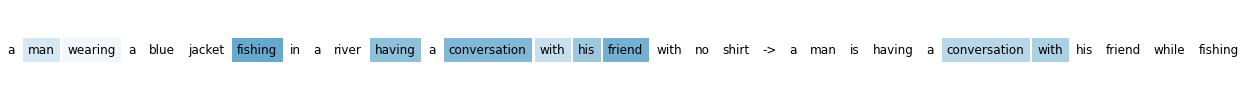


bert-base_arch-5_test_BT=[MASK].json
texts: ['A man wearing a blue jacket fishing in a river having a conversation with his friend with no shirt.', 'A man is having a conversation with his friend while fishing.']
gold label: entailment
pred label: entailment
explanations: [(('friend',), ('friend',)), (('fishing', 'river', 'having', 'conversation'), ('fishing',))]
interactions_vote: [(['fishing'], ['fishing'])]
interactions_union: [(['man'], ['man']), (['man'], ['conversation']), (['man'], ['friend']), (['man'], ['fishing']), (['fishing', 'in', 'a', 'river'], ['man']), (['fishing', 'in', 'a', 'river'], ['conversation']), (['fishing', 'in', 'a', 'river'], ['friend']), (['fishing', 'in', 'a', 'river'], ['fishing']), (['conversation'], ['man']), (['conversation'], ['conversation']), (['conversation'], ['friend']), (['conversation'], ['fishing']), (['friend'], ['man']), (['friend'], ['conversation']), (['friend'], ['friend']), (['friend'], ['fishing'])]


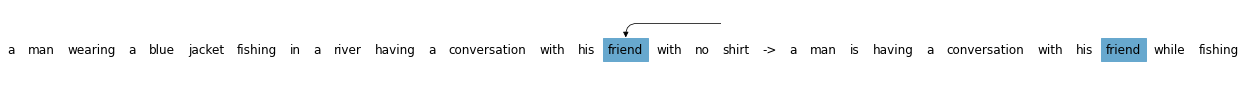


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A man wearing a blue jacket fishing in a river having a conversation with his friend with no shirt.', 'A man is having a conversation with his friend while fishing.']
gold label: entailment
pred label: entailment
explanations: [(('friend',), ('friend',)), (('fishing',), ('fishing',)), (('conversation',), ('conversation',)), (('man',), ('man',)), (('river',), ('fishing',))]
interactions_vote: [(['fishing'], ['fishing'])]
interactions_union: [(['man'], ['man']), (['man'], ['conversation']), (['man'], ['friend']), (['man'], ['fishing']), (['fishing', 'in', 'a', 'river'], ['man']), (['fishing', 'in', 'a', 'river'], ['conversation']), (['fishing', 'in', 'a', 'river'], ['friend']), (['fishing', 'in', 'a', 'river'], ['fishing']), (['conversation'], ['man']), (['conversation'], ['conversation']), (['conversation'], ['friend']), (['conversation'], ['fishing']), (['friend'], ['man']), (['friend'], ['conversation']), (['friend'], ['friend']),

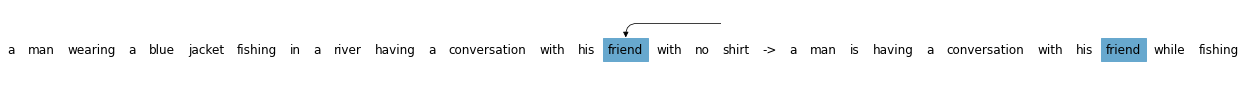


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A man wearing a blue jacket fishing in a river having a conversation with his friend with no shirt.', 'A man is having a conversation with his friend while fishing.']
gold label: entailment
pred label: entailment
explanations: [(('fishing',), ('fishing',)), (('conversation',), ('conversation',)), (('friend',), ('with',)), (('fishing',), ('with',)), (('conversation',), ('with',)), (('friend',), ('friend',)), (('fishing',), ('a',)), (('conversation',), ('having',)), (('friend',), ('a',)), (('conversation',), ('a',)), (('fishing',), ('having',)), (('fishing',), ('while',)), (('conversation',), ('while',)), (('friend',), ('having',)), (('fishing',), ('is',)), (('fishing',), ('his',)), (('fishing',), ('man',))]
interactions_vote: [(['fishing'], ['fishing'])]
interactions_union: [(['man'], ['man']), (['man'], ['conversation']), (['man'], ['friend']), (['man'], ['fishing']), (['fishing', 'in', 'a', 'river'], ['ma

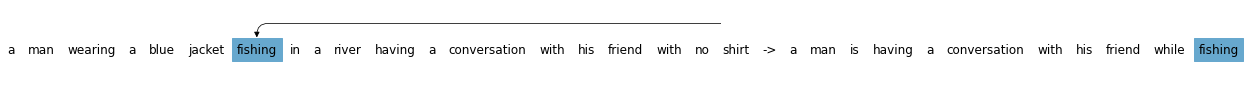


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A man wearing a blue jacket fishing in a river having a conversation with his friend with no shirt.', 'A man is having a conversation with his friend while fishing.']
gold label: entailment
pred label: entailment
explanations: [(('fishing', 'friend'), ('fishing',)), (('fishing', 'conversation'), ('conversation',)), (('fishing', 'friend'), ('with',)), (('fishing', 'conversation'), ('having',)), (('fishing', 'conversation'), ('fishing',)), (('fishing', 'friend'), ('friend',)), (('fishing', 'conversation'), ('with',)), (('fishing', 'friend'), ('a',)), (('fishing', 'friend'), ('having',))]
interactions_vote: [(['fishing'], ['fishing'])]
interactions_union: [(['man'], ['man']), (['man'], ['conversation']), (['man'], ['friend']), (['man'], ['fishing']), (['fishing', 'in', 'a', 'river'], ['man']), (['fishing', 'in', 'a', 'river'], ['conversation']), (['fishing', 'in', 'a', 'river'], ['friend']), (['fishing', 'in'

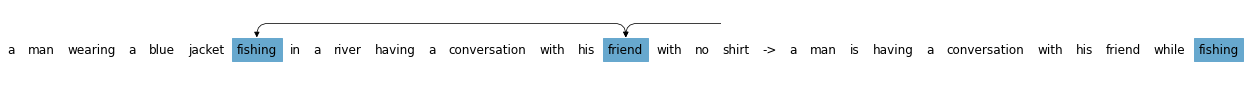


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A man wearing a blue jacket fishing in a river having a conversation with his friend with no shirt.', 'A man is having a conversation with his friend while fishing.']
gold label: entailment
pred label: entailment
explanations: [(('fishing', 'conversation', 'friend'), ('conversation',)), (('fishing', 'conversation', 'friend'), ('with',)), (('fishing', 'conversation', 'friend'), ('having',)), (('fishing', 'conversation', 'friend'), ('friend',)), (('fishing', 'conversation', 'friend'), ('fishing',)), (('fishing', 'conversation', 'friend'), ('a',)), (('fishing', 'conversation', 'friend'), ('while',)), (('fishing', 'conversation', 'friend'), ('is',)), (('fishing', 'conversation', 'friend'), ('his',)), (('fishing', 'conversation', 'friend'), ('man',)), (('fishing', 'his', 'friend'), ('fishing',)), (('fishing', 'conversation', 'his'), ('fishing',)), (('fishing', 'conversation', 'with'), ('conversation'

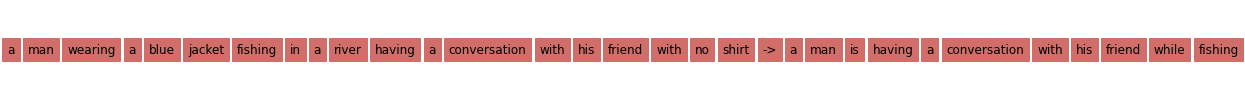

############################ 69 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['A little kid in a blue helmet is riding a bike with training wheels on it down a pebbled grassy trail.', 'A kid in a helmet sleds down a hill.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('sleds',)), (('bike',), ()), (('training',), ()), (('in',), ()), (('riding',), ()), ((), ('in',)), (('blue',), ()), (('wheels',), ()), (('helmet',), ())]
interactions_vote: [(['riding', 'a', 'bike'], ['sleds'])]
interactions_union: [(['riding', 'a', 'bike'], ['sleds'])]


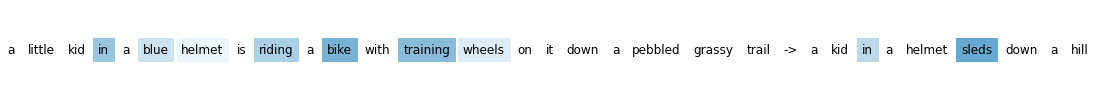


bert-base_arch-5_test_BT=[MASK].json
texts: ['A little kid in a blue helmet is riding a bike with training wheels on it down a pebbled grassy trail.', 'A kid in a helmet sleds down a hill.']
gold label: contradiction
pred label: contradiction
explanations: [(('bike',), ('sleds',)), (('grassy', 'trail'), ('in',))]
interactions_vote: [(['riding', 'a', 'bike'], ['sleds'])]
interactions_union: [(['riding', 'a', 'bike'], ['sleds'])]


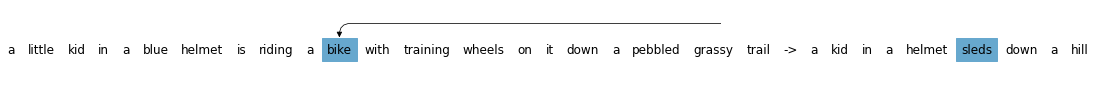


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A little kid in a blue helmet is riding a bike with training wheels on it down a pebbled grassy trail.', 'A kid in a helmet sleds down a hill.']
gold label: contradiction
pred label: contradiction
explanations: [(('bike',), ('sleds',)), (('trail',), ('in',)), (('grassy',), ('in',))]
interactions_vote: [(['riding', 'a', 'bike'], ['sleds'])]
interactions_union: [(['riding', 'a', 'bike'], ['sleds'])]


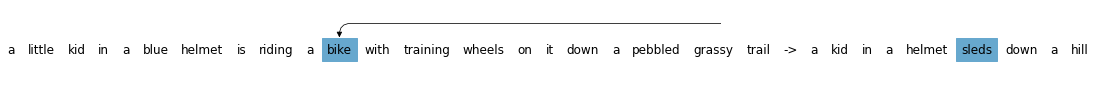


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A little kid in a blue helmet is riding a bike with training wheels on it down a pebbled grassy trail.', 'A kid in a helmet sleds down a hill.']
gold label: contradiction
pred label: contradiction
explanations: [(('bike',), ('sleds',)), (('training',), ('sleds',)), (('grassy',), ('sleds',)), (('riding',), ('sleds',)), (('wheels',), ('sleds',)), (('trail',), ('sleds',)), (('in',), ('sleds',)), (('on',), ('sleds',)), (('blue',), ('sleds',)), (('pebbled',), ('sleds',)), (('it',), ('sleds',)), (('helmet',), ('sleds',)), (('a',), ('sleds',)), (('kid',), ('sleds',)), (('with',), ('sleds',)), (('little',), ('sleds',)), (('is',), ('sleds',))]
interactions_vote: [(['riding', 'a', 'bike'], ['sleds'])]
interactions_union: [(['riding', 'a', 'bike'], ['sleds'])]


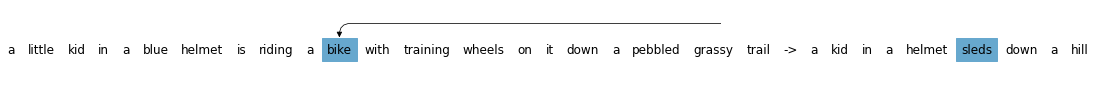


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A little kid in a blue helmet is riding a bike with training wheels on it down a pebbled grassy trail.', 'A kid in a helmet sleds down a hill.']
gold label: contradiction
pred label: contradiction
explanations: [(('bike',), ('sleds',)), (('bike',), ('sleds', 'hill')), (('bike', 'grassy'), ('sleds',)), (('bike', 'training'), ('sleds',)), (('in', 'bike'), ('sleds',)), (('bike',), ('sleds', 'a')), (('bike',), ('sleds', 'down')), (('bike', 'on'), ('sleds',)), (('bike', 'trail'), ('sleds',))]
interactions_vote: [(['riding', 'a', 'bike'], ['sleds'])]
interactions_union: [(['riding', 'a', 'bike'], ['sleds'])]


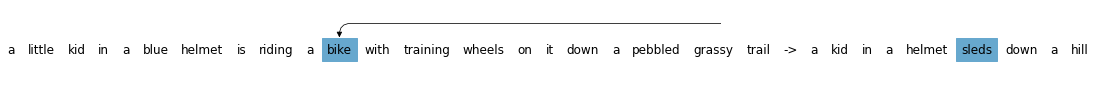


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A little kid in a blue helmet is riding a bike with training wheels on it down a pebbled grassy trail.', 'A kid in a helmet sleds down a hill.']
gold label: contradiction
pred label: contradiction
explanations: [(('bike',), ('sleds',)), (('bike',), ('sleds', 'hill')), (('bike', 'grassy'), ('sleds',)), (('bike', 'training'), ('sleds',)), (('bike', 'trail'), ('sleds',)), (('bike', 'pebbled'), ('sleds',)), (('bike', 'on'), ('sleds',)), (('bike', 'it'), ('sleds',)), (('is', 'bike'), ('sleds',)), (('bike',), ('a', 'sleds')), (('bike',), ('kid', 'sleds')), (('in', 'bike'), ('sleds',)), (('bike', 'with'), ('sleds',)), (('helmet', 'bike'), ('sleds',)), (('riding', 'bike'), ('sleds',)), (('a', 'bike'), ('sleds',)), (('blue', 'bike'), ('sleds',)), (('bike', 'a'), ('sleds',))]
interactions_vote: [(['riding', 'a', 'bike'], ['sleds'])]
interactions_union: [(['riding', 'a', 'bike'], ['sleds'])]


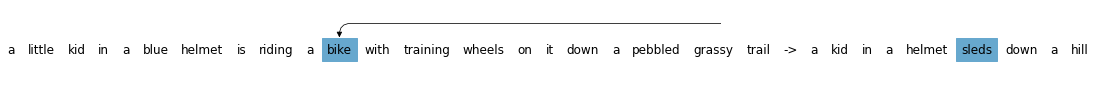

############################ 916 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['Man in puffy yellow jacket on skis on a mountain.', 'The man is sitting on a chair in his house.']
gold label: contradiction
pred label: contradiction
explanations: [(('mountain',), ()), (('skis',), ()), ((), ('house',)), ((), ('sitting',)), ((), ('chair',)), ((), ('in',)), (('puffy',), ()), (('on',), ()), (('jacket',), ()), (('yellow',), ()), ((), ('The',)), ((), ()), ((), ('his',)), (('a',), ())]
interactions_vote: []
interactions_union: [(['on', 'skis', 'on'], ['man']), (['on', 'skis', 'on'], ['sitting']), (['on', 'skis', 'on'], ['chair', 'in']), (['on', 'skis', 'on'], ['house']), (['mountain'], ['man']), (['mountain'], ['sitting']), (['mountain'], ['chair', 'in']), (['mountain'], ['house'])]


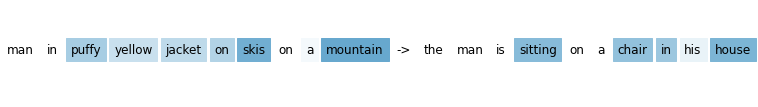


bert-base_arch-5_test_BT=[MASK].json
texts: ['Man in puffy yellow jacket on skis on a mountain.', 'The man is sitting on a chair in his house.']
gold label: contradiction
pred label: contradiction
explanations: [(('skis', 'mountain'), ('sitting', 'house'))]
interactions_vote: []
interactions_union: [(['on', 'skis', 'on'], ['man']), (['on', 'skis', 'on'], ['sitting']), (['on', 'skis', 'on'], ['chair', 'in']), (['on', 'skis', 'on'], ['house']), (['mountain'], ['man']), (['mountain'], ['sitting']), (['mountain'], ['chair', 'in']), (['mountain'], ['house'])]


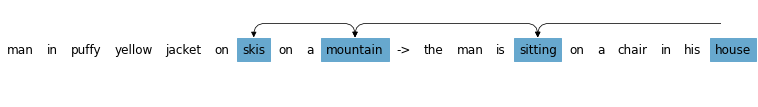


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['Man in puffy yellow jacket on skis on a mountain.', 'The man is sitting on a chair in his house.']
gold label: contradiction
pred label: contradiction
explanations: [(('mountain',), ('house',)), (('skis',), ('house',)), (('skis',), ('sitting',))]
interactions_vote: []
interactions_union: [(['on', 'skis', 'on'], ['man']), (['on', 'skis', 'on'], ['sitting']), (['on', 'skis', 'on'], ['chair', 'in']), (['on', 'skis', 'on'], ['house']), (['mountain'], ['man']), (['mountain'], ['sitting']), (['mountain'], ['chair', 'in']), (['mountain'], ['house'])]


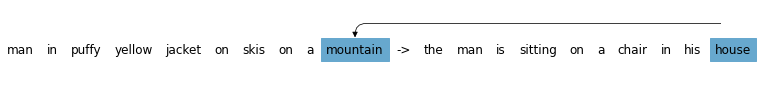


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Man in puffy yellow jacket on skis on a mountain.', 'The man is sitting on a chair in his house.']
gold label: contradiction
pred label: contradiction
explanations: [(('mountain',), ('house',)), (('skis',), ('house',)), (('skis',), ('chair',)), (('skis',), ('sitting',)), (('mountain',), ('chair',)), (('mountain',), ('sitting',)), (('puffy',), ('chair',)), (('puffy',), ('sitting',)), (('puffy',), ('house',)), (('jacket',), ('sitting',)), (('jacket',), ('chair',)), (('on',), ('house',)), (('on',), ('sitting',)), (('jacket',), ('house',)), (('on',), ('chair',))]
interactions_vote: []
interactions_union: [(['on', 'skis', 'on'], ['man']), (['on', 'skis', 'on'], ['sitting']), (['on', 'skis', 'on'], ['chair', 'in']), (['on', 'skis', 'on'], ['house']), (['mountain'], ['man']), (['mountain'], ['sitting']), (['mountain'], ['chair', 'in']), (['mountain'], ['house'])]


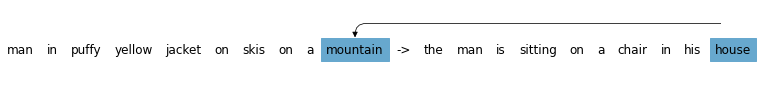


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Man in puffy yellow jacket on skis on a mountain.', 'The man is sitting on a chair in his house.']
gold label: contradiction
pred label: contradiction
explanations: [(('mountain',), ('sitting', 'house')), (('skis',), ('sitting', 'house')), (('mountain',), ('in', 'house')), (('mountain',), ('chair', 'house')), (('skis',), ('chair', 'house')), (('skis',), ('in', 'house')), (('a', 'mountain'), ('house',)), (('mountain',), ('the', 'house')), (('on', 'mountain'), ('house',)), (('jacket', 'mountain'), ('house',))]
interactions_vote: []
interactions_union: [(['on', 'skis', 'on'], ['man']), (['on', 'skis', 'on'], ['sitting']), (['on', 'skis', 'on'], ['chair', 'in']), (['on', 'skis', 'on'], ['house']), (['mountain'], ['man']), (['mountain'], ['sitting']), (['mountain'], ['chair', 'in']), (['mountain'], ['house'])]


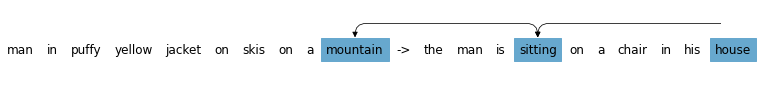


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['Man in puffy yellow jacket on skis on a mountain.', 'The man is sitting on a chair in his house.']
gold label: contradiction
pred label: contradiction
explanations: [(('mountain',), ('sitting', 'in', 'house')), (('mountain',), ('chair', 'in', 'house')), (('skis', 'mountain'), ('sitting', 'house')), (('skis',), ('sitting', 'in', 'house')), (('skis', 'mountain'), ('in', 'house')), (('skis',), ('chair', 'in', 'house')), (('skis',), ('sitting', 'chair', 'house')), (('mountain',), ('the', 'in', 'house')), (('on', 'mountain'), ('in', 'house')), (('mountain',), ('sitting', 'chair', 'house')), (('on', 'mountain'), ('sitting', 'house')), (('mountain',), ('sitting', 'a', 'house')), (('a', 'mountain'), ('in', 'house')), (('mountain',), ('a', 'in', 'house')), (('puffy', 'mountain'), ('in', 'house')), (('mountain',), ('on', 'in', 'house')), (('mountain',), ('the', 'sitting', 'house')), (('a', 'mountain'), ('

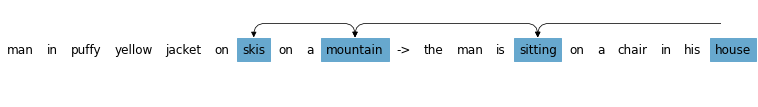

############################ 158 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['There is a Victorian style building in the background, and in the foreground is a lake where a tiny paddle boat sits with three people in it.', 'The owners of a house enjoy their pond.']
gold label: neutral
pred label: neutral
explanations: [((), ('owners',)), ((), ('enjoy',)), (('Victorian',), ()), ((), ('their',)), (('paddle',), ()), (('boat',), ()), ((), ('of',)), (('tiny',), ()), (('building',), ()), (('sits',), ()), ((), ('pond',)), (('is',), ()), (('style',), ()), (('it',), ()), (('lake',), ()), ((), ('The',))]
interactions_vote: []
interactions_union: []


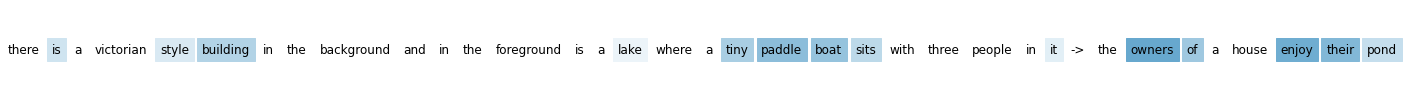


bert-base_arch-5_test_BT=[MASK].json
texts: ['There is a Victorian style building in the background, and in the foreground is a lake where a tiny paddle boat sits with three people in it.', 'The owners of a house enjoy their pond.']
gold label: neutral
pred label: neutral
explanations: [(('building',), ('the', 'owners', 'of', 'enjoy', 'their'))]
interactions_vote: []
interactions_union: []


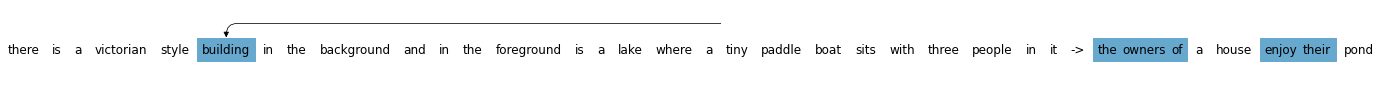


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['There is a Victorian style building in the background, and in the foreground is a lake where a tiny paddle boat sits with three people in it.', 'The owners of a house enjoy their pond.']
gold label: neutral
pred label: neutral
explanations: [(('paddle',), ('pond',)), (('building',), ('owners',)), (('lake',), ('pond',)), (('building',), ('house',))]
interactions_vote: []
interactions_union: []


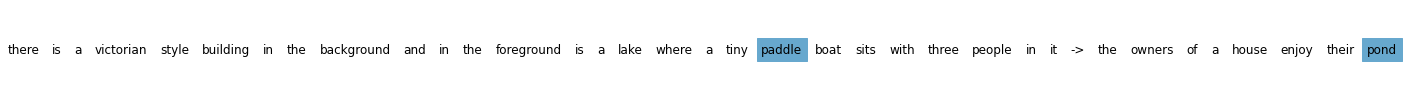


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['There is a Victorian style building in the background, and in the foreground is a lake where a tiny paddle boat sits with three people in it.', 'The owners of a house enjoy their pond.']
gold label: neutral
pred label: neutral
explanations: [(('victorian',), ('owners',)), (('building',), ('owners',)), (('paddle',), ('owners',)), (('sits',), ('owners',)), (('tiny',), ('owners',)), (('style',), ('owners',)), (('lake',), ('owners',)), (('is',), ('owners',)), (('in',), ('owners',)), (('boat',), ('owners',)), (('three',), ('owners',)), (('and',), ('owners',)), (('foreground',), ('owners',)), (('background',), ('owners',)), (('the',), ('owners',)), (('with',), ('owners',)), (('a',), ('owners',))]
interactions_vote: []
interactions_union: []


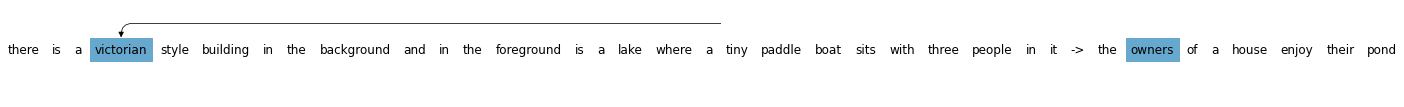


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['There is a Victorian style building in the background, and in the foreground is a lake where a tiny paddle boat sits with three people in it.', 'The owners of a house enjoy their pond.']
gold label: neutral
pred label: neutral
explanations: [(('victorian', 'paddle'), ('owners',)), (('paddle',), ('owners', 'pond')), (('victorian', 'lake'), ('owners',)), (('victorian',), ('owners', 'house')), (('victorian', 'boat'), ('owners',)), (('victorian',), ('owners', 'of')), (('victorian', 'style'), ('owners',)), (('victorian', 'sits'), ('owners',)), (('victorian', 'foreground'), ('owners',)), (('victorian', 'the'), ('owners',))]
interactions_vote: []
interactions_union: []


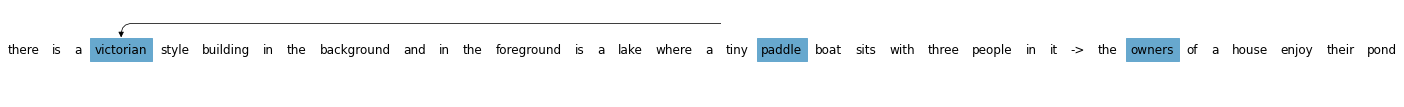


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['There is a Victorian style building in the background, and in the foreground is a lake where a tiny paddle boat sits with three people in it.', 'The owners of a house enjoy their pond.']
gold label: neutral
pred label: neutral
explanations: [(('victorian', 'paddle'), ('owners', 'pond')), (('victorian', 'lake'), ('owners', 'pond')), (('victorian', 'paddle'), ('owners', 'house')), (('victorian', 'paddle'), ('the', 'owners')), (('paddle',), ('owners', 'of', 'pond')), (('victorian', 'background', 'paddle'), ('owners',)), (('paddle',), ('owners', 'enjoy', 'pond')), (('building', 'paddle'), ('owners', 'pond')), (('victorian',), ('owners', 'of', 'house')), (('victorian', 'lake'), ('owners', 'house')), (('victorian', 'lake'), ('the', 'owners')), (('victorian', 'building'), ('owners', 'house')), (('victorian', 'building', 'paddle'), ('owners',)), (('victorian', 'lake'), ('owners', 'enjoy')), (('victorian

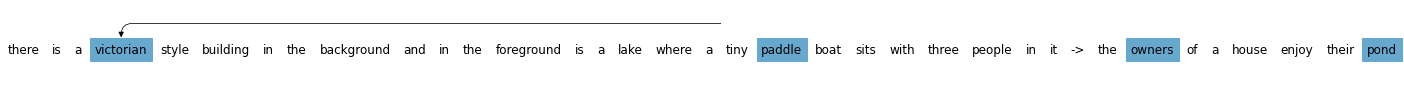

############################ 235 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['A group of women observing an event while one in military attire takes a photograph', 'A group of people got ran over by a bus.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('ran',)), ((), ('bus',)), (('photograph',), ()), ((), ('over',)), ((), ('got',)), (('military',), ()), (('event',), ()), (('in',), ()), ((), ('of',)), (('attire',), ()), (('observing',), ()), (('A',), ()), (('of',), ())]
interactions_vote: [(['observing', 'an', 'event'], ['got', 'ran', 'over', 'by', 'a', 'bus']), (['takes', 'a', 'photograph'], ['got', 'ran', 'over', 'by', 'a', 'bus'])]
interactions_union: [(['observing', 'an', 'event'], ['got', 'ran', 'over', 'by', 'a', 'bus']), (['takes', 'a', 'photograph'], ['got', 'ran', 'over', 'by', 'a', 'bus'])]


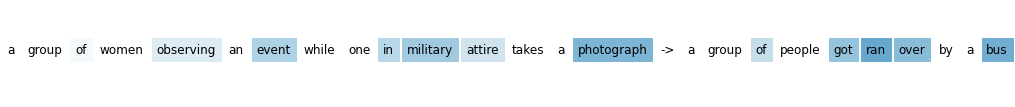


bert-base_arch-5_test_BT=[MASK].json
texts: ['A group of women observing an event while one in military attire takes a photograph', 'A group of people got ran over by a bus.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('ran', 'bus'))]
interactions_vote: [(['observing', 'an', 'event'], ['got', 'ran', 'over', 'by', 'a', 'bus']), (['takes', 'a', 'photograph'], ['got', 'ran', 'over', 'by', 'a', 'bus'])]
interactions_union: [(['observing', 'an', 'event'], ['got', 'ran', 'over', 'by', 'a', 'bus']), (['takes', 'a', 'photograph'], ['got', 'ran', 'over', 'by', 'a', 'bus'])]


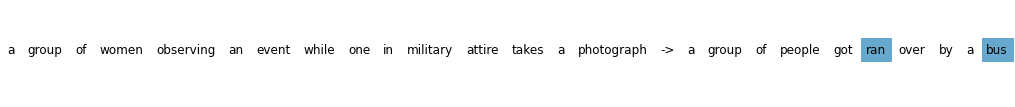


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A group of women observing an event while one in military attire takes a photograph', 'A group of people got ran over by a bus.']
gold label: contradiction
pred label: contradiction
explanations: [(('event', 'photograph'), ('ran', 'bus')), (('observing',), ('ran',))]
interactions_vote: [(['observing', 'an', 'event'], ['got', 'ran', 'over', 'by', 'a', 'bus']), (['takes', 'a', 'photograph'], ['got', 'ran', 'over', 'by', 'a', 'bus'])]
interactions_union: [(['observing', 'an', 'event'], ['got', 'ran', 'over', 'by', 'a', 'bus']), (['takes', 'a', 'photograph'], ['got', 'ran', 'over', 'by', 'a', 'bus'])]


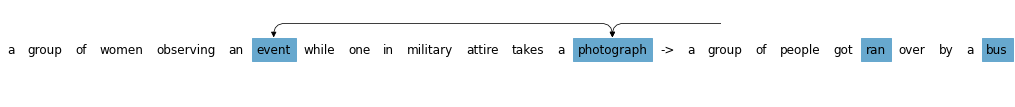


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A group of women observing an event while one in military attire takes a photograph', 'A group of people got ran over by a bus.']
gold label: contradiction
pred label: contradiction
explanations: [(('event',), ('bus',)), (('photograph',), ('bus',)), (('military',), ('bus',)), (('photograph',), ('ran',)), (('attire',), ('bus',)), (('observing',), ('bus',)), (('observing',), ('ran',)), (('attire',), ('ran',)), (('women',), ('ran',)), (('in',), ('bus',)), (('group',), ('bus',)), (('military',), ('ran',)), (('women',), ('bus',)), (('an',), ('bus',)), (('a',), ('bus',)), (('a',), ('ran',)), (('an',), ('ran',)), (('of',), ('bus',)), (('group',), ('ran',))]
interactions_vote: [(['observing', 'an', 'event'], ['got', 'ran', 'over', 'by', 'a', 'bus']), (['takes', 'a', 'photograph'], ['got', 'ran', 'over', 'by', 'a', 'bus'])]
interactions_union: [(['observing', 'an', 'event'], ['got', 'ran', 'over', 'by', 'a', 'bus']

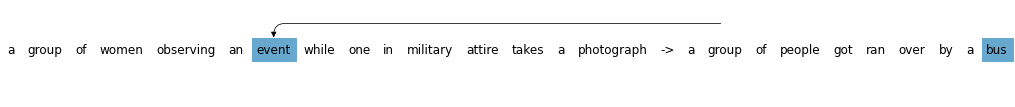


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A group of women observing an event while one in military attire takes a photograph', 'A group of people got ran over by a bus.']
gold label: contradiction
pred label: contradiction
explanations: [(('photograph',), ('ran', 'by')), (('photograph',), ('ran', 'bus')), (('observing',), ('ran', 'by')), (('photograph',), ('ran', 'over')), (('attire',), ('ran', 'bus')), (('event',), ('ran', 'bus')), (('observing',), ('ran', 'bus')), (('military',), ('ran', 'bus')), (('observing',), ('ran', 'over')), (('women',), ('ran', 'bus'))]
interactions_vote: [(['observing', 'an', 'event'], ['got', 'ran', 'over', 'by', 'a', 'bus']), (['takes', 'a', 'photograph'], ['got', 'ran', 'over', 'by', 'a', 'bus'])]
interactions_union: [(['observing', 'an', 'event'], ['got', 'ran', 'over', 'by', 'a', 'bus']), (['takes', 'a', 'photograph'], ['got', 'ran', 'over', 'by', 'a', 'bus'])]


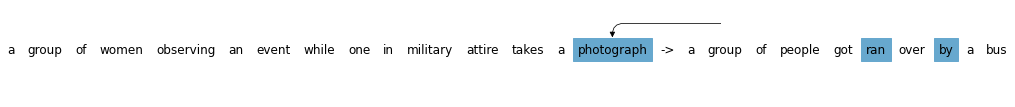


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A group of women observing an event while one in military attire takes a photograph', 'A group of people got ran over by a bus.']
gold label: contradiction
pred label: contradiction
explanations: [(('photograph',), ('ran', 'by', 'bus')), (('photograph',), ('ran', 'over', 'bus')), (('attire',), ('ran', 'over', 'bus')), (('attire',), ('ran', 'by', 'bus')), (('event',), ('ran', 'by', 'bus')), (('women',), ('ran', 'by', 'bus')), (('observing',), ('ran', 'by', 'bus')), (('women',), ('ran', 'over', 'bus')), (('observing',), ('ran', 'over', 'bus')), (('photograph',), ('people', 'ran', 'bus')), (('event',), ('ran', 'over', 'bus')), (('photograph',), ('ran', 'over', 'by')), (('military',), ('ran', 'over', 'bus')), (('observing',), ('people', 'ran', 'bus')), (('military',), ('ran', 'by', 'bus')), (('photograph',), ('group', 'ran', 'bus')), (('observing', 'photograph'), ('ran', 'by')), (('observing', 'phot

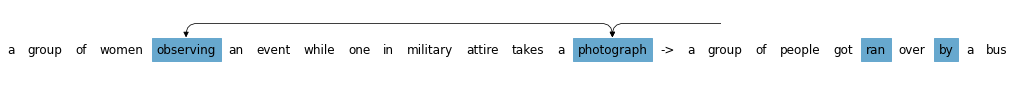

############################ 757 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['Several men at a bar watch a sports game on the television.', 'The men are at a baseball game.']
gold label: contradiction
pred label: neutral
explanations: [((), ('baseball',)), (('sports',), ()), ((), ('game',)), (('watch',), ()), ((), ('are',)), (('television',), ()), ((), ('men',)), (('Several',), ()), ((), ('The',)), ((), ()), (('a',), ()), (('game',), ())]
interactions_vote: [(['bar'], ['baseball', 'game'])]
interactions_union: [(['bar', 'watch', 'a', 'sports', 'game', 'on'], ['at', 'a', 'baseball', 'game']), (['television'], ['at', 'a', 'baseball', 'game'])]


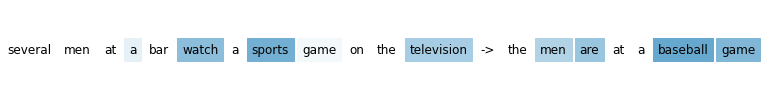


bert-base_arch-5_test_BT=[MASK].json
texts: ['Several men at a bar watch a sports game on the television.', 'The men are at a baseball game.']
gold label: contradiction
pred label: neutral
explanations: [((), ('the', 'are', 'at')), (('men', 'sports'), ('baseball', 'game'))]
interactions_vote: [(['bar'], ['baseball', 'game'])]
interactions_union: [(['bar', 'watch', 'a', 'sports', 'game', 'on'], ['at', 'a', 'baseball', 'game']), (['television'], ['at', 'a', 'baseball', 'game'])]


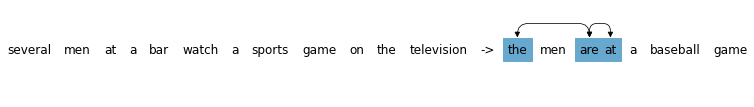


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['Several men at a bar watch a sports game on the television.', 'The men are at a baseball game.']
gold label: contradiction
pred label: neutral
explanations: [(('sports', 'game'), ('baseball',)), (('television',), ('game',)), (('men',), ('baseball',))]
interactions_vote: [(['bar'], ['baseball', 'game'])]
interactions_union: [(['bar', 'watch', 'a', 'sports', 'game', 'on'], ['at', 'a', 'baseball', 'game']), (['television'], ['at', 'a', 'baseball', 'game'])]


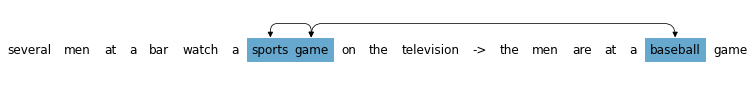


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Several men at a bar watch a sports game on the television.', 'The men are at a baseball game.']
gold label: contradiction
pred label: neutral
explanations: [(('sports',), ('baseball',)), (('sports',), ('game',)), (('game',), ('baseball',)), (('sports',), ('the',)), (('men',), ('baseball',)), (('watch',), ('baseball',)), (('television',), ('game',)), (('on',), ('baseball',)), (('sports',), ('men',)), (('a',), ('baseball',)), (('the',), ('baseball',)), (('several',), ('baseball',)), (('several',), ('game',)), (('a',), ('game',)), (('watch',), ('game',)), (('at',), ('game',)), (('sports',), ('are',)), (('men',), ('game',))]
interactions_vote: [(['bar'], ['baseball', 'game'])]
interactions_union: [(['bar', 'watch', 'a', 'sports', 'game', 'on'], ['at', 'a', 'baseball', 'game']), (['television'], ['at', 'a', 'baseball', 'game'])]


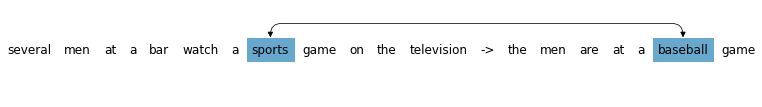


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Several men at a bar watch a sports game on the television.', 'The men are at a baseball game.']
gold label: contradiction
pred label: neutral
explanations: [(('sports',), ('baseball', 'game')), (('sports',), ('at', 'baseball')), (('watch', 'sports'), ('baseball',)), (('sports',), ('the', 'baseball')), (('sports', 'on'), ('baseball',)), (('men', 'sports'), ('baseball',)), (('a', 'sports'), ('baseball',)), (('game',), ('baseball', 'game')), (('several', 'sports'), ('baseball',)), (('sports',), ('men', 'baseball'))]
interactions_vote: [(['bar'], ['baseball', 'game'])]
interactions_union: [(['bar', 'watch', 'a', 'sports', 'game', 'on'], ['at', 'a', 'baseball', 'game']), (['television'], ['at', 'a', 'baseball', 'game'])]


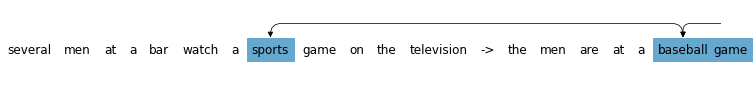


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['Several men at a bar watch a sports game on the television.', 'The men are at a baseball game.']
gold label: contradiction
pred label: neutral
explanations: [(('watch', 'sports'), ('baseball', 'game')), (('sports',), ('at', 'baseball', 'game')), (('sports',), ('the', 'baseball', 'game')), (('men', 'sports'), ('baseball', 'game')), (('several', 'sports'), ('baseball', 'game')), (('sports', 'television'), ('baseball', 'game')), (('sports',), ('a', 'baseball', 'game')), (('sports', 'game'), ('baseball', 'game')), (('sports', 'the'), ('baseball', 'game')), (('sports', 'on'), ('baseball', 'game')), (('sports',), ('men', 'baseball', 'game')), (('a', 'sports'), ('baseball', 'game')), (('at', 'sports'), ('baseball', 'game')), (('bar', 'sports'), ('baseball', 'game')), (('watch', 'sports'), ('at', 'baseball')), (('watch', 'sports'), ('the', 'baseball')), (('sports',), ('are', 'baseball', 'game')), (('men

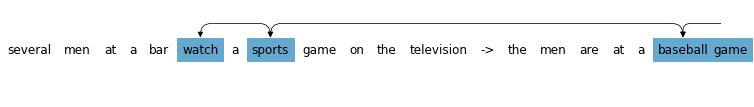

############################ 891 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['An older women looking off into the distance with three older women walking towards her from behind.', 'An older woman is trying to see a billboard that is far away']
gold label: neutral
pred label: neutral
explanations: [((), ('see',)), ((), ('trying',)), (('distance',), ()), ((), ('that',)), (('looking',), ()), ((), ('to',)), ((), ('woman',)), ((), ('billboard',)), (('An',), ()), (('with',), ()), ((), ('is',)), ((), ('a',)), (('older',), ())]
interactions_vote: []
interactions_union: []


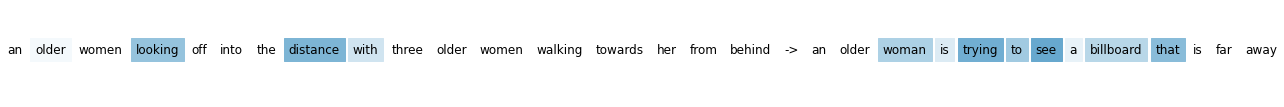


bert-base_arch-5_test_BT=[MASK].json
texts: ['An older women looking off into the distance with three older women walking towards her from behind.', 'An older woman is trying to see a billboard that is far away']
gold label: neutral
pred label: neutral
explanations: [((), ('woman', 'to', 'see', 'billboard'))]
interactions_vote: []
interactions_union: []


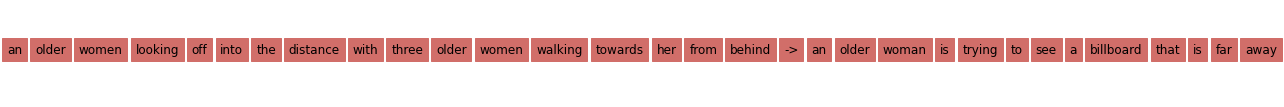


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['An older women looking off into the distance with three older women walking towards her from behind.', 'An older woman is trying to see a billboard that is far away']
gold label: neutral
pred label: neutral
explanations: [(('behind',), ('billboard',))]
interactions_vote: []
interactions_union: []


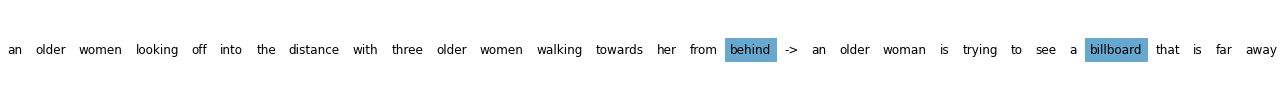


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['An older women looking off into the distance with three older women walking towards her from behind.', 'An older woman is trying to see a billboard that is far away']
gold label: neutral
pred label: neutral
explanations: [(('distance',), ('see',)), (('looking',), ('see',)), (('distance',), ('trying',)), (('an',), ('see',)), (('older',), ('see',)), (('off',), ('see',)), (('distance',), ('to',)), (('walking',), ('see',)), (('behind',), ('see',)), (('from',), ('see',)), (('into',), ('see',)), (('with',), ('see',)), (('the',), ('see',)), (('towards',), ('see',)), (('women',), ('see',)), (('an',), ('trying',)), (('her',), ('see',)), (('looking',), ('trying',)), (('older',), ('to',))]
interactions_vote: []
interactions_union: []


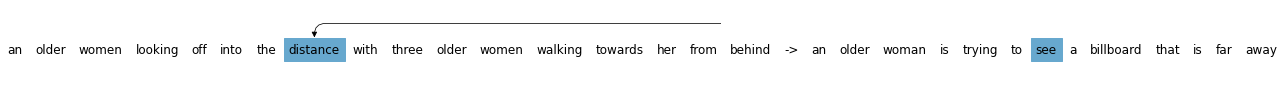


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['An older women looking off into the distance with three older women walking towards her from behind.', 'An older woman is trying to see a billboard that is far away']
gold label: neutral
pred label: neutral
explanations: [(('distance',), ('trying', 'see')), (('distance',), ('to', 'see')), (('distance',), ('see', 'billboard')), (('looking',), ('trying', 'see')), (('looking',), ('see', 'billboard')), (('looking',), ('to', 'see')), (('off',), ('to', 'see')), (('older',), ('to', 'see')), (('older',), ('trying', 'see'))]
interactions_vote: []
interactions_union: []


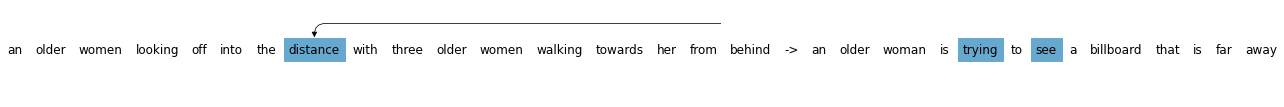


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['An older women looking off into the distance with three older women walking towards her from behind.', 'An older woman is trying to see a billboard that is far away']
gold label: neutral
pred label: neutral
explanations: [(('looking', 'distance'), ('see', 'billboard')), (('looking',), ('trying', 'see', 'billboard')), (('distance',), ('to', 'see', 'billboard')), (('distance',), ('trying', 'see', 'billboard')), (('older', 'looking'), ('see', 'billboard')), (('distance',), ('see', 'a', 'billboard')), (('looking', 'walking'), ('see', 'billboard')), (('distance', 'older'), ('see', 'billboard')), (('older', 'distance'), ('see', 'billboard')), (('looking', 'older'), ('see', 'billboard')), (('looking',), ('to', 'see', 'billboard')), (('older', 'distance'), ('to', 'see')), (('looking',), ('see', 'a', 'billboard')), (('distance',), ('see', 'billboard', 'away')), (('distance',), ('trying', 'see', 'that')),

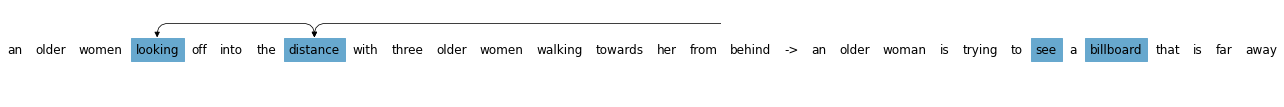

############################ 963 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['People stand along a train track and take pictures.', 'Some people are walking to the train station.']
gold label: neutral
pred label: contradiction
explanations: [((), ('walking',)), (('pictures',), ()), (('stand',), ()), ((), ('the',)), (('take',), ()), ((), ('people',)), (('track',), ()), ((), ('station',)), (('and',), ()), (('People',), ()), ((), ('to',))]
interactions_vote: []
interactions_union: []


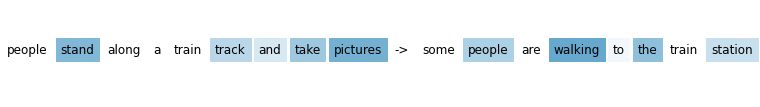


bert-base_arch-5_test_BT=[MASK].json
texts: ['People stand along a train track and take pictures.', 'Some people are walking to the train station.']
gold label: neutral
pred label: contradiction
explanations: [(('stand', 'train', 'pictures'), ('walking',))]
interactions_vote: []
interactions_union: []


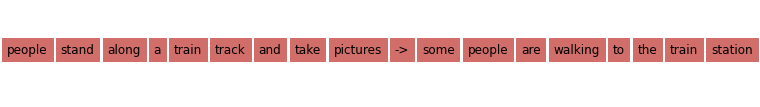


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['People stand along a train track and take pictures.', 'Some people are walking to the train station.']
gold label: neutral
pred label: contradiction
explanations: [(('pictures',), ('walking',)), (('stand', 'train'), ('walking',))]
interactions_vote: []
interactions_union: []


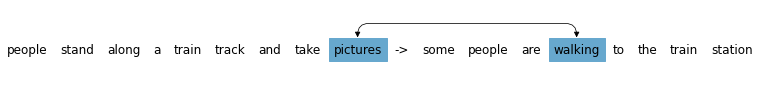


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['People stand along a train track and take pictures.', 'Some people are walking to the train station.']
gold label: neutral
pred label: contradiction
explanations: [(('pictures',), ('walking',)), (('stand',), ('walking',)), (('track',), ('walking',)), (('take',), ('walking',)), (('people',), ('walking',)), (('train',), ('walking',)), (('a',), ('walking',)), (('and',), ('walking',)), (('along',), ('walking',)), (('pictures',), ('the',)), (('pictures',), ('people',)), (('pictures',), ('to',)), (('pictures',), ('are',)), (('pictures',), ('train',)), (('pictures',), ('station',)), (('stand',), ('the',)), (('track',), ('the',)), (('take',), ('the',)), (('people',), ('the',)), (('track',), ('people',))]
interactions_vote: []
interactions_union: []


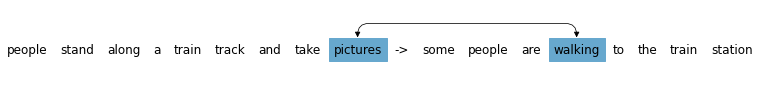


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['People stand along a train track and take pictures.', 'Some people are walking to the train station.']
gold label: neutral
pred label: contradiction
explanations: [(('pictures',), ('walking', 'the')), (('take', 'pictures'), ('walking',)), (('stand', 'pictures'), ('walking',)), (('pictures',), ('walking', 'to')), (('pictures',), ('walking', 'station')), (('stand',), ('walking', 'the')), (('a', 'pictures'), ('walking',)), (('pictures',), ('people', 'walking')), (('track', 'pictures'), ('walking',)), (('pictures',), ('walking',))]
interactions_vote: []
interactions_union: []


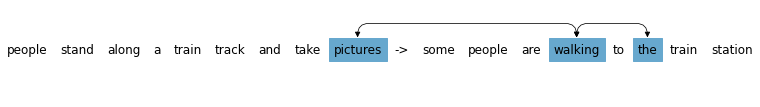


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['People stand along a train track and take pictures.', 'Some people are walking to the train station.']
gold label: neutral
pred label: contradiction
explanations: [(('take', 'pictures'), ('walking', 'to')), (('stand', 'pictures'), ('walking', 'the')), (('take', 'pictures'), ('walking', 'the')), (('take', 'pictures'), ('walking', 'station')), (('pictures',), ('walking', 'to', 'the')), (('stand', 'pictures'), ('walking', 'to')), (('pictures',), ('walking', 'the', 'station')), (('track', 'take', 'pictures'), ('walking',)), (('stand', 'take', 'pictures'), ('walking',)), (('stand', 'pictures'), ('walking', 'station')), (('pictures',), ('walking', 'to', 'station')), (('track', 'pictures'), ('walking', 'the')), (('people', 'pictures'), ('walking', 'the')), (('people', 'pictures'), ('walking', 'to')), (('a', 'pictures'), ('walking', 'the')), (('stand', 'track', 'pictures'), ('walking',)), (('people', 't

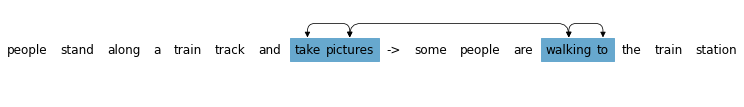

############################ 620 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['Two boys in front of a soda machine.', 'Two boys are at a machine.']
gold label: entailment
pred label: entailment
explanations: [(('boys',), ()), ((), ('machine',)), (('soda',), ()), ((), ('a',)), ((), ('at',)), ((), ('Two',)), (('Two',), ()), (('machine',), ()), ((), ('are',))]
interactions_vote: [(['front', 'of'], ['at']), (['front', 'of'], ['machine']), (['soda', 'machine'], ['at']), (['soda', 'machine'], ['machine'])]
interactions_union: [(['boys', 'in', 'front', 'of', 'a', 'soda', 'machine'], ['boys', 'are', 'at', 'a', 'machine'])]


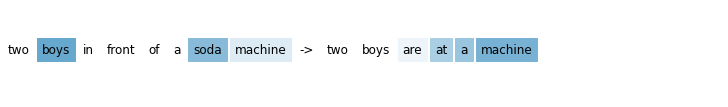


bert-base_arch-5_test_BT=[MASK].json
texts: ['Two boys in front of a soda machine.', 'Two boys are at a machine.']
gold label: entailment
pred label: entailment
explanations: [(('soda', 'machine'), ('machine',)), (('boys',), ('boys',))]
interactions_vote: [(['front', 'of'], ['at']), (['front', 'of'], ['machine']), (['soda', 'machine'], ['at']), (['soda', 'machine'], ['machine'])]
interactions_union: [(['boys', 'in', 'front', 'of', 'a', 'soda', 'machine'], ['boys', 'are', 'at', 'a', 'machine'])]


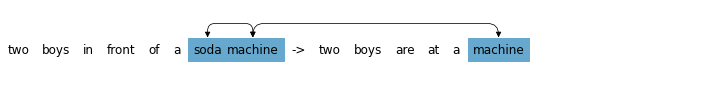


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['Two boys in front of a soda machine.', 'Two boys are at a machine.']
gold label: entailment
pred label: entailment
explanations: [(('boys', 'soda'), ('boys', 'machine')), (('machine',), ('machine',))]
interactions_vote: [(['front', 'of'], ['at']), (['front', 'of'], ['machine']), (['soda', 'machine'], ['at']), (['soda', 'machine'], ['machine'])]
interactions_union: [(['boys', 'in', 'front', 'of', 'a', 'soda', 'machine'], ['boys', 'are', 'at', 'a', 'machine'])]


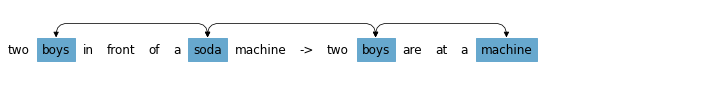


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Two boys in front of a soda machine.', 'Two boys are at a machine.']
gold label: entailment
pred label: entailment
explanations: [(('boys',), ('at',)), (('boys',), ('a',)), (('boys',), ('two',)), (('soda',), ('machine',)), (('machine',), ('machine',)), (('soda',), ('at',)), (('boys',), ('boys',)), (('machine',), ('at',)), (('soda',), ('a',)), (('front',), ('at',)), (('a',), ('at',)), (('boys',), ('machine',)), (('two',), ('at',)), (('in',), ('at',)), (('machine',), ('a',)), (('a',), ('a',)), (('two',), ('a',)), (('of',), ('at',)), (('soda',), ('two',)), (('two',), ('two',))]
interactions_vote: [(['front', 'of'], ['at']), (['front', 'of'], ['machine']), (['soda', 'machine'], ['at']), (['soda', 'machine'], ['machine'])]
interactions_union: [(['boys', 'in', 'front', 'of', 'a', 'soda', 'machine'], ['boys', 'are', 'at', 'a', 'machine'])]


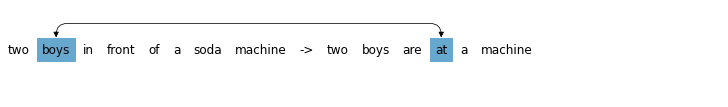


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Two boys in front of a soda machine.', 'Two boys are at a machine.']
gold label: entailment
pred label: entailment
explanations: [(('boys', 'machine'), ('machine',)), (('boys', 'machine'), ('at',)), (('boys', 'soda'), ('machine',)), (('boys', 'soda'), ('at',)), (('boys', 'machine'), ('a',)), (('boys', 'soda'), ('a',)), (('boys', 'a'), ('at',)), (('boys', 'front'), ('at',)), (('two', 'boys'), ('at',)), (('boys', 'of'), ('at',))]
interactions_vote: [(['front', 'of'], ['at']), (['front', 'of'], ['machine']), (['soda', 'machine'], ['at']), (['soda', 'machine'], ['machine'])]
interactions_union: [(['boys', 'in', 'front', 'of', 'a', 'soda', 'machine'], ['boys', 'are', 'at', 'a', 'machine'])]


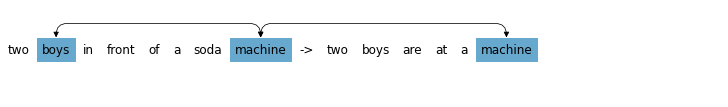


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['Two boys in front of a soda machine.', 'Two boys are at a machine.']
gold label: entailment
pred label: entailment
explanations: [(('boys', 'machine'), ('at', 'machine')), (('boys', 'soda'), ('at', 'machine')), (('boys', 'front', 'soda'), ('at',)), (('boys', 'soda'), ('a', 'machine')), (('boys', 'front', 'machine'), ('at',)), (('boys', 'soda', 'machine'), ('machine',)), (('boys', 'of', 'machine'), ('at',)), (('boys', 'soda', 'machine'), ('at',)), (('two', 'boys', 'machine'), ('at',)), (('boys', 'machine'), ('a', 'machine')), (('boys', 'a', 'soda'), ('machine',)), (('two', 'boys', 'soda'), ('at',)), (('boys', 'machine'), ('are', 'at')), (('boys', 'soda', 'machine'), ('a',)), (('boys', 'machine'), ('at', 'a')), (('boys', 'in', 'machine'), ('at',)), (('boys', 'in', 'soda'), ('at',)), (('two', 'boys', 'machine'), ('machine',)), (('boys', 'a', 'soda'), ('at',)), (('two', 'boys', 'soda'), ('machine',)

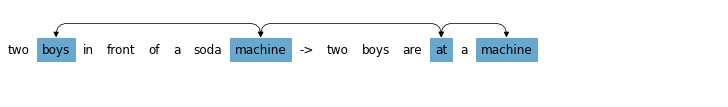

############################ 558 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['Fans are dressed in green and yellow for a major sporting event.', 'The fans are wearing blue and red for a sporting event.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('blue',)), ((), ('red',)), (('yellow',), ()), (('green',), ()), (('in',), ()), (('dressed',), ()), (('and',), ()), ((), ('The',)), (('a',), ()), ((), ('and',)), (('for',), ()), (('event',), ()), (('major',), ())]
interactions_vote: [(['green', 'and', 'yellow'], ['blue', 'and', 'red'])]
interactions_union: [(['green', 'and', 'yellow'], ['blue', 'and', 'red'])]


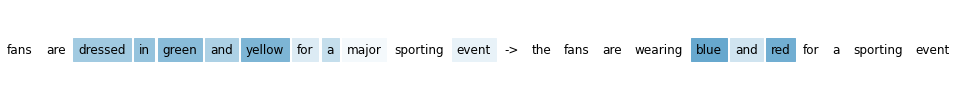


bert-base_arch-5_test_BT=[MASK].json
texts: ['Fans are dressed in green and yellow for a major sporting event.', 'The fans are wearing blue and red for a sporting event.']
gold label: contradiction
pred label: contradiction
explanations: [(('green', 'yellow'), ('blue', 'red'))]
interactions_vote: [(['green', 'and', 'yellow'], ['blue', 'and', 'red'])]
interactions_union: [(['green', 'and', 'yellow'], ['blue', 'and', 'red'])]


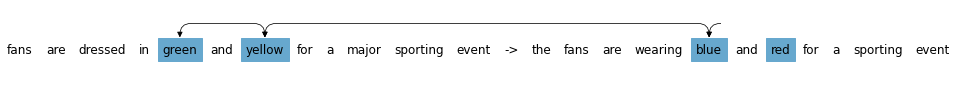


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['Fans are dressed in green and yellow for a major sporting event.', 'The fans are wearing blue and red for a sporting event.']
gold label: contradiction
pred label: contradiction
explanations: [(('fans', 'green', 'yellow'), ('blue', 'red'))]
interactions_vote: [(['green', 'and', 'yellow'], ['blue', 'and', 'red'])]
interactions_union: [(['green', 'and', 'yellow'], ['blue', 'and', 'red'])]


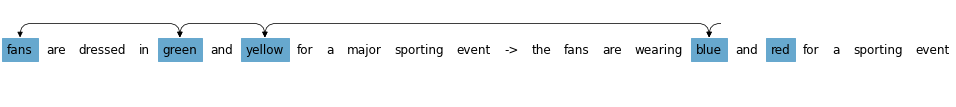


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Fans are dressed in green and yellow for a major sporting event.', 'The fans are wearing blue and red for a sporting event.']
gold label: contradiction
pred label: contradiction
explanations: [(('yellow',), ('blue',)), (('yellow',), ('red',)), (('green',), ('blue',)), (('green',), ('red',)), (('yellow',), ('event',)), (('a',), ('red',)), (('in',), ('red',)), (('a',), ('blue',)), (('for',), ('blue',)), (('yellow',), ('are',)), (('yellow',), ('fans',)), (('in',), ('blue',)), (('yellow',), ('the',)), (('yellow',), ('and',)), (('are',), ('red',)), (('fans',), ('blue',)), (('are',), ('blue',)), (('for',), ('red',)), (('green',), ('and',)), (('yellow',), ('for',))]
interactions_vote: [(['green', 'and', 'yellow'], ['blue', 'and', 'red'])]
interactions_union: [(['green', 'and', 'yellow'], ['blue', 'and', 'red'])]


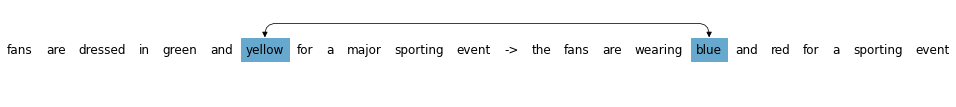


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Fans are dressed in green and yellow for a major sporting event.', 'The fans are wearing blue and red for a sporting event.']
gold label: contradiction
pred label: contradiction
explanations: [(('dressed', 'yellow'), ('blue',)), (('in', 'yellow'), ('blue',)), (('yellow', 'for'), ('blue',)), (('fans', 'yellow'), ('blue',)), (('yellow',), ('blue', 'and')), (('yellow',), ('wearing', 'blue')), (('yellow', 'a'), ('blue',)), (('dressed', 'green'), ('blue',)), (('yellow',), ('the', 'blue')), (('dressed', 'yellow'), ('red',))]
interactions_vote: [(['green', 'and', 'yellow'], ['blue', 'and', 'red'])]
interactions_union: [(['green', 'and', 'yellow'], ['blue', 'and', 'red'])]


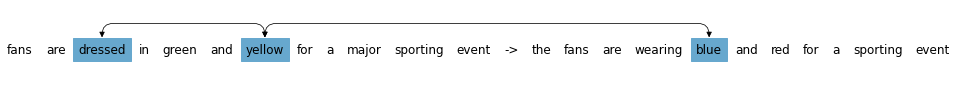


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['Fans are dressed in green and yellow for a major sporting event.', 'The fans are wearing blue and red for a sporting event.']
gold label: contradiction
pred label: contradiction
explanations: [(('dressed', 'yellow'), ('wearing', 'blue')), (('in', 'yellow'), ('wearing', 'blue')), (('dressed', 'green'), ('wearing', 'blue')), (('in', 'green'), ('wearing', 'blue')), (('yellow', 'for'), ('blue', 'for')), (('dressed', 'yellow', 'for'), ('blue',)), (('and', 'yellow'), ('blue', 'and')), (('in', 'yellow'), ('blue', 'for')), (('dressed', 'yellow'), ('blue', 'for')), (('yellow',), ('blue', 'and', 'for')), (('dressed', 'yellow', 'a'), ('blue',)), (('fans', 'yellow', 'for'), ('blue',)), (('fans', 'dressed', 'yellow'), ('blue',)), (('yellow',), ('the', 'blue', 'and')), (('dressed', 'yellow'), ('the', 'blue')), (('yellow', 'for'), ('blue', 'and')), (('yellow',), ('are', 'blue', 'and')), (('in', 'yellow', 'a'),

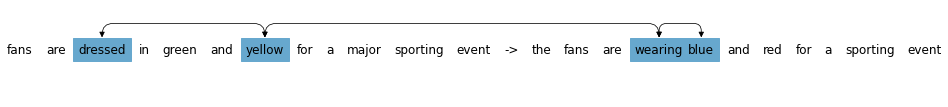

############################ 655 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['Xylophonists play in a dark setting.', 'xylophone is played by someone']
gold label: entailment
pred label: entailment
explanations: [(('Xylophonists',), ()), (('play',), ()), ((), ('played',))]
interactions_vote: [(['Xylophonists'], ['xylophone']), (['Xylophonists'], ['someone'])]
interactions_union: [(['Xylophonists', 'play'], ['xylophone', 'is', 'played', 'by', 'someone']), (['dark', 'setting'], ['xylophone', 'is', 'played', 'by', 'someone'])]


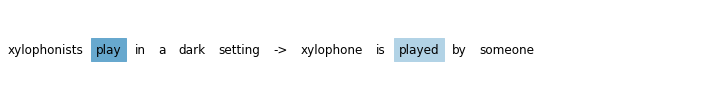


bert-base_arch-5_test_BT=[MASK].json
texts: ['Xylophonists play in a dark setting.', 'xylophone is played by someone']
gold label: entailment
pred label: entailment
explanations: [(('xylophonists',), ('xylophone',))]
interactions_vote: [(['Xylophonists'], ['xylophone']), (['Xylophonists'], ['someone'])]
interactions_union: [(['Xylophonists', 'play'], ['xylophone', 'is', 'played', 'by', 'someone']), (['dark', 'setting'], ['xylophone', 'is', 'played', 'by', 'someone'])]


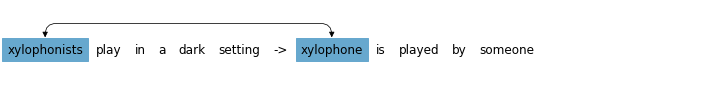


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['Xylophonists play in a dark setting.', 'xylophone is played by someone']
gold label: entailment
pred label: entailment
explanations: [(('xylophonists', 'play'), ('is', 'played')), (('xylophonists',), ('xylophone',))]
interactions_vote: [(['Xylophonists'], ['xylophone']), (['Xylophonists'], ['someone'])]
interactions_union: [(['Xylophonists', 'play'], ['xylophone', 'is', 'played', 'by', 'someone']), (['dark', 'setting'], ['xylophone', 'is', 'played', 'by', 'someone'])]


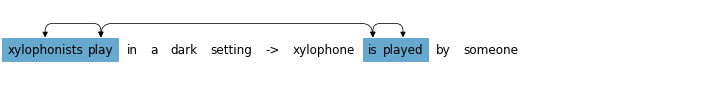


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Xylophonists play in a dark setting.', 'xylophone is played by someone']
gold label: entailment
pred label: entailment
explanations: [(('xylophonists',), ('xylophone',)), (('play',), ('xylophone',)), (('play',), ('someone',)), (('xylophonists',), ('someone',)), (('xylophonists',), ('is',)), (('play',), ('played',)), (('play',), ('is',)), (('xylophonists',), ('by',)), (('in',), ('xylophone',)), (('play',), ('by',)), (('a',), ('xylophone',))]
interactions_vote: [(['Xylophonists'], ['xylophone']), (['Xylophonists'], ['someone'])]
interactions_union: [(['Xylophonists', 'play'], ['xylophone', 'is', 'played', 'by', 'someone']), (['dark', 'setting'], ['xylophone', 'is', 'played', 'by', 'someone'])]


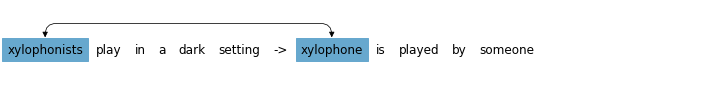


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Xylophonists play in a dark setting.', 'xylophone is played by someone']
gold label: entailment
pred label: entailment
explanations: [(('xylophonists', 'play'), ('xylophone',)), (('xylophonists',), ('xylophone',)), (('xylophonists', 'a'), ('xylophone',)), (('xylophonists', 'dark'), ('xylophone',)), (('xylophonists', 'in'), ('xylophone',))]
interactions_vote: [(['Xylophonists'], ['xylophone']), (['Xylophonists'], ['someone'])]
interactions_union: [(['Xylophonists', 'play'], ['xylophone', 'is', 'played', 'by', 'someone']), (['dark', 'setting'], ['xylophone', 'is', 'played', 'by', 'someone'])]


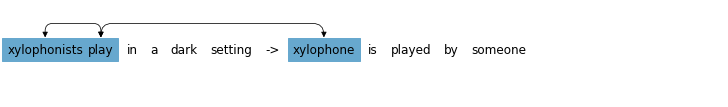


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['Xylophonists play in a dark setting.', 'xylophone is played by someone']
gold label: entailment
pred label: entailment
explanations: [(('xylophonists', 'play'), ('xylophone',)), (('xylophonists', 'play'), ('xylophone', 'by')), (('xylophonists', 'play', 'a'), ('xylophone',)), (('xylophonists',), ('xylophone',)), (('xylophonists', 'play'), ('xylophone', 'played')), (('xylophonists', 'play', 'dark'), ('xylophone',)), (('xylophonists', 'play', 'setting'), ('xylophone',)), (('xylophonists', 'play'), ('xylophone', 'is')), (('xylophonists', 'play'), ('xylophone', 'someone')), (('xylophonists', 'play', 'in'), ('xylophone',)), (('xylophonists', 'a'), ('xylophone',)), (('xylophonists', 'setting'), ('xylophone',)), (('xylophonists',), ('xylophone', 'someone'))]
interactions_vote: [(['Xylophonists'], ['xylophone']), (['Xylophonists'], ['someone'])]
interactions_union: [(['Xylophonists', 'play'], ['xylophone

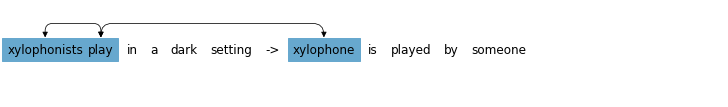

############################ 715 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['A woman in a black top and blue skirt is pushing a carriage or cart down a long empty tree-lined road.', 'A woman is outdoors']
gold label: entailment
pred label: entailment
explanations: [((), ('outdoors',)), (('woman',), ()), (('road',), ()), ((), ('A',)), (('empty',), ()), (('tree',), ()), (('skirt',), ()), (('carriage',), ()), (('pushing',), ()), (('or',), ()), ((), ()), (('a',), ())]
interactions_vote: [(['road'], ['outdoors'])]
interactions_union: [(['woman'], ['woman']), (['woman'], ['outdoors']), (['black'], ['woman']), (['black'], ['outdoors']), (['skirt'], ['woman']), (['skirt'], ['outdoors']), (['pushing', 'a', 'carriage', 'or', 'cart'], ['woman']), (['pushing', 'a', 'carriage', 'or', 'cart'], ['outdoors']), (['road'], ['woman']), (['road'], ['outdoors'])]


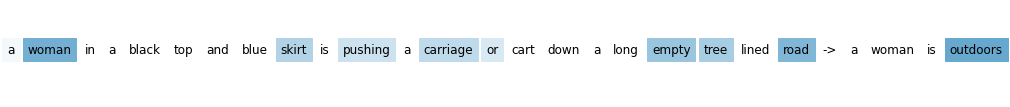


bert-base_arch-5_test_BT=[MASK].json
texts: ['A woman in a black top and blue skirt is pushing a carriage or cart down a long empty tree-lined road.', 'A woman is outdoors']
gold label: entailment
pred label: entailment
explanations: [(('carriage', 'tree', 'road'), ('is', 'outdoors')), (('woman',), ('woman',))]
interactions_vote: [(['road'], ['outdoors'])]
interactions_union: [(['woman'], ['woman']), (['woman'], ['outdoors']), (['black'], ['woman']), (['black'], ['outdoors']), (['skirt'], ['woman']), (['skirt'], ['outdoors']), (['pushing', 'a', 'carriage', 'or', 'cart'], ['woman']), (['pushing', 'a', 'carriage', 'or', 'cart'], ['outdoors']), (['road'], ['woman']), (['road'], ['outdoors'])]


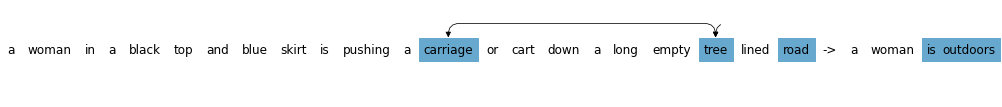


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A woman in a black top and blue skirt is pushing a carriage or cart down a long empty tree-lined road.', 'A woman is outdoors']
gold label: entailment
pred label: entailment
explanations: [(('carriage', 'tree', 'road'), ('outdoors',)), (('woman',), ('woman',)), (('cart',), ('outdoors',))]
interactions_vote: [(['road'], ['outdoors'])]
interactions_union: [(['woman'], ['woman']), (['woman'], ['outdoors']), (['black'], ['woman']), (['black'], ['outdoors']), (['skirt'], ['woman']), (['skirt'], ['outdoors']), (['pushing', 'a', 'carriage', 'or', 'cart'], ['woman']), (['pushing', 'a', 'carriage', 'or', 'cart'], ['outdoors']), (['road'], ['woman']), (['road'], ['outdoors'])]


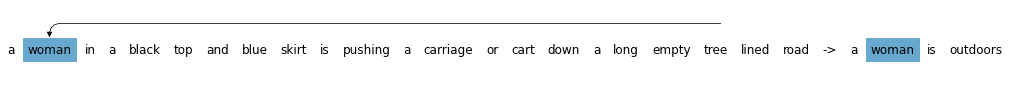


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A woman in a black top and blue skirt is pushing a carriage or cart down a long empty tree-lined road.', 'A woman is outdoors']
gold label: entailment
pred label: entailment
explanations: [(('woman',), ('outdoors',)), (('road',), ('outdoors',)), (('skirt',), ('outdoors',)), (('carriage',), ('outdoors',)), (('tree',), ('outdoors',)), (('cart',), ('outdoors',)), (('empty',), ('outdoors',)), (('pushing',), ('outdoors',)), (('is',), ('outdoors',)), (('top',), ('outdoors',)), (('down',), ('outdoors',)), (('black',), ('outdoors',)), (('and',), ('outdoors',)), (('long',), ('outdoors',)), (('a',), ('outdoors',)), (('lined',), ('outdoors',)), (('in',), ('outdoors',))]
interactions_vote: [(['road'], ['outdoors'])]
interactions_union: [(['woman'], ['woman']), (['woman'], ['outdoors']), (['black'], ['woman']), (['black'], ['outdoors']), (['skirt'], ['woman']), (['skirt'], ['outdoors']), (['pushing', 'a', 'carriage', '

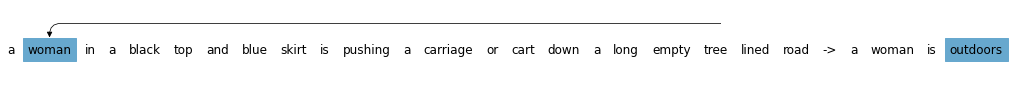


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A woman in a black top and blue skirt is pushing a carriage or cart down a long empty tree-lined road.', 'A woman is outdoors']
gold label: entailment
pred label: entailment
explanations: [(('woman', 'road'), ('outdoors',)), (('woman', 'tree'), ('outdoors',)), (('woman', 'carriage'), ('outdoors',)), (('road',), ('is', 'outdoors')), (('skirt', 'road'), ('outdoors',)), (('woman', 'cart'), ('outdoors',)), (('woman', 'down'), ('outdoors',)), (('woman',), ('a', 'outdoors')), (('woman', 'long'), ('outdoors',)), (('woman', 'top'), ('outdoors',))]
interactions_vote: [(['road'], ['outdoors'])]
interactions_union: [(['woman'], ['woman']), (['woman'], ['outdoors']), (['black'], ['woman']), (['black'], ['outdoors']), (['skirt'], ['woman']), (['skirt'], ['outdoors']), (['pushing', 'a', 'carriage', 'or', 'cart'], ['woman']), (['pushing', 'a', 'carriage', 'or', 'cart'], ['outdoors']), (['road'], ['woman']), (['road'], ['

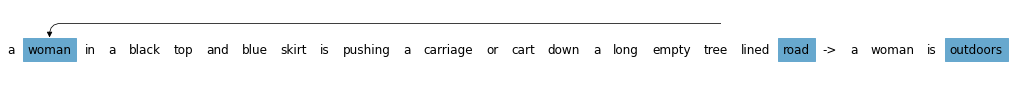


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A woman in a black top and blue skirt is pushing a carriage or cart down a long empty tree-lined road.', 'A woman is outdoors']
gold label: entailment
pred label: entailment
explanations: [(('woman', 'empty', 'road'), ('outdoors',)), (('woman', 'down', 'road'), ('outdoors',)), (('woman', 'lined', 'road'), ('outdoors',)), (('woman', 'carriage', 'road'), ('outdoors',)), (('woman', 'road'), ('a', 'outdoors')), (('woman', 'road'), ('is', 'outdoors')), (('woman', 'skirt', 'road'), ('outdoors',)), (('woman', 'pushing', 'road'), ('outdoors',)), (('woman', 'cart', 'road'), ('outdoors',)), (('woman', 'and', 'road'), ('outdoors',)), (('woman', 'top', 'road'), ('outdoors',)), (('woman', 'in', 'road'), ('outdoors',)), (('woman', 'is', 'road'), ('outdoors',)), (('woman', 'black', 'road'), ('outdoors',)), (('a', 'woman', 'road'), ('outdoors',)), (('woman', 'blue', 'road'), ('outdoors',)), (('woman', 'long', '

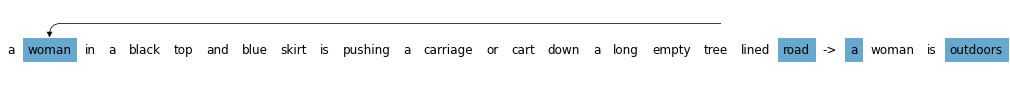

############################ 693 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['A woman finishing a marathon race.', 'The woman is not going to finish the race.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('not',)), (('finishing',), ()), (('woman',), ()), (('race',), ()), (('marathon',), ()), ((), ('to',)), ((), ('The',)), ((), ('race',))]
interactions_vote: [(['finishing'], ['not', 'going', 'to', 'finish'])]
interactions_union: [(['finishing', 'a', 'marathon', 'race'], ['not', 'going', 'to', 'finish', 'the', 'race'])]


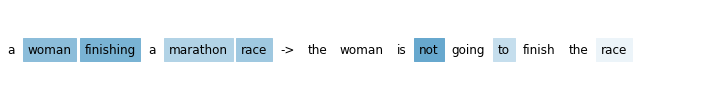


bert-base_arch-5_test_BT=[MASK].json
texts: ['A woman finishing a marathon race.', 'The woman is not going to finish the race.']
gold label: contradiction
pred label: contradiction
explanations: [(('finishing',), ('not', 'finish'))]
interactions_vote: [(['finishing'], ['not', 'going', 'to', 'finish'])]
interactions_union: [(['finishing', 'a', 'marathon', 'race'], ['not', 'going', 'to', 'finish', 'the', 'race'])]


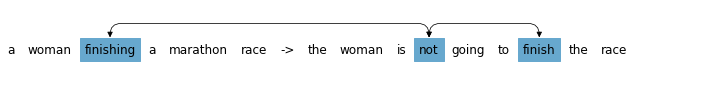


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A woman finishing a marathon race.', 'The woman is not going to finish the race.']
gold label: contradiction
pred label: contradiction
explanations: [(('marathon',), ('not',)), (('race',), ('not',)), (('woman',), ('race',))]
interactions_vote: [(['finishing'], ['not', 'going', 'to', 'finish'])]
interactions_union: [(['finishing', 'a', 'marathon', 'race'], ['not', 'going', 'to', 'finish', 'the', 'race'])]


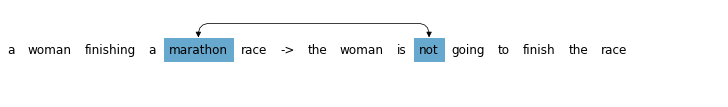


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A woman finishing a marathon race.', 'The woman is not going to finish the race.']
gold label: contradiction
pred label: contradiction
explanations: [(('finishing',), ('not',)), (('race',), ('not',)), (('woman',), ('not',)), (('marathon',), ('not',)), (('a',), ('not',)), (('finishing',), ('to',)), (('finishing',), ('going',)), (('finishing',), ('race',)), (('finishing',), ('the',)), (('finishing',), ('woman',)), (('finishing',), ('is',)), (('race',), ('to',)), (('woman',), ('to',)), (('finishing',), ('finish',)), (('marathon',), ('to',)), (('a',), ('to',)), (('woman',), ('is',))]
interactions_vote: [(['finishing'], ['not', 'going', 'to', 'finish'])]
interactions_union: [(['finishing', 'a', 'marathon', 'race'], ['not', 'going', 'to', 'finish', 'the', 'race'])]


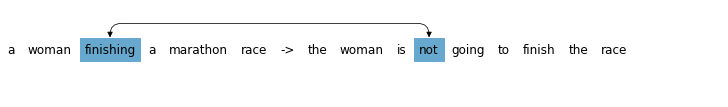


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A woman finishing a marathon race.', 'The woman is not going to finish the race.']
gold label: contradiction
pred label: contradiction
explanations: [(('finishing',), ('not', 'to')), (('woman', 'finishing'), ('not',)), (('finishing', 'marathon'), ('not',)), (('finishing',), ('not', 'finish')), (('finishing', 'a'), ('not',)), (('finishing',), ('the', 'not')), (('finishing', 'race'), ('not',)), (('finishing',), ('not', 'going')), (('finishing',), ('not',)), (('finishing',), ('not', 'race'))]
interactions_vote: [(['finishing'], ['not', 'going', 'to', 'finish'])]
interactions_union: [(['finishing', 'a', 'marathon', 'race'], ['not', 'going', 'to', 'finish', 'the', 'race'])]


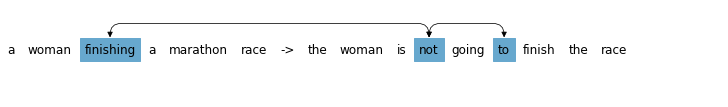


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A woman finishing a marathon race.', 'The woman is not going to finish the race.']
gold label: contradiction
pred label: contradiction
explanations: [(('woman', 'finishing'), ('not', 'finish')), (('woman', 'finishing', 'marathon'), ('not',)), (('finishing', 'marathon'), ('not', 'to')), (('woman', 'finishing'), ('not', 'to')), (('woman', 'finishing', 'race'), ('not',)), (('finishing', 'a'), ('not', 'to')), (('woman', 'finishing'), ('not', 'race')), (('woman', 'finishing', 'a'), ('not',)), (('woman', 'finishing'), ('woman', 'not')), (('finishing', 'a'), ('not', 'finish')), (('finishing',), ('the', 'not', 'finish')), (('a', 'woman', 'finishing'), ('not',)), (('finishing',), ('the', 'not', 'to')), (('finishing', 'race'), ('not', 'to')), (('finishing', 'marathon'), ('not', 'going')), (('finishing', 'marathon'), ('the', 'not')), (('woman', 'finishing'), ('the', 'not')), (('finishing', 'a', 'marathon')

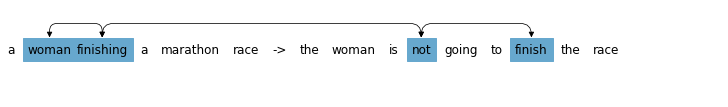

############################ 187 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['A small girl with braids blowing bubbles.', 'A young girl enjoys her day outside.']
gold label: neutral
pred label: neutral
explanations: [((), ('enjoys',)), ((), ('day',)), ((), ('outside',)), ((), ('girl',)), ((), ('her',)), ((), ('young',)), (('braids',), ()), (('with',), ()), (('small',), ()), (('bubbles',), ()), ((), ()), ((), ('A',))]
interactions_vote: []
interactions_union: []


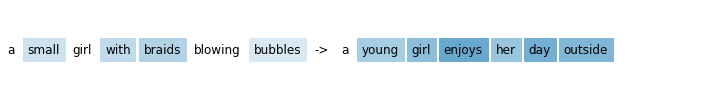


bert-base_arch-5_test_BT=[MASK].json
texts: ['A small girl with braids blowing bubbles.', 'A young girl enjoys her day outside.']
gold label: neutral
pred label: neutral
explanations: [((), ('enjoys', 'her', 'day', 'outside')), ((), ('a', 'young'))]
interactions_vote: []
interactions_union: []


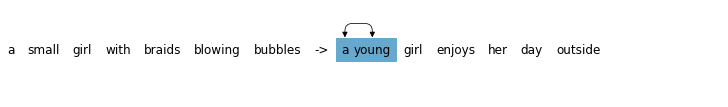


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A small girl with braids blowing bubbles.', 'A young girl enjoys her day outside.']
gold label: neutral
pred label: neutral
explanations: [(('bubbles',), ('enjoys',)), (('braids',), ('day',)), (('bubbles',), ('young',)), (('braids',), ('girl',)), (('girl',), ('young',))]
interactions_vote: []
interactions_union: []


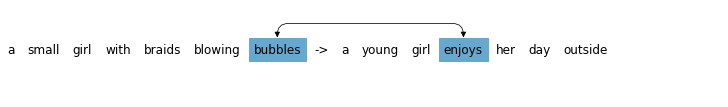


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A small girl with braids blowing bubbles.', 'A young girl enjoys her day outside.']
gold label: neutral
pred label: neutral
explanations: [(('braids',), ('enjoys',)), (('with',), ('enjoys',)), (('bubbles',), ('enjoys',)), (('a',), ('enjoys',)), (('blowing',), ('enjoys',)), (('small',), ('enjoys',)), (('braids',), ('outside',)), (('braids',), ('day',)), (('braids',), ('her',)), (('bubbles',), ('day',)), (('girl',), ('enjoys',)), (('with',), ('outside',)), (('a',), ('day',)), (('with',), ('day',)), (('bubbles',), ('her',)), (('with',), ('her',)), (('small',), ('day',)), (('bubbles',), ('outside',))]
interactions_vote: []
interactions_union: []


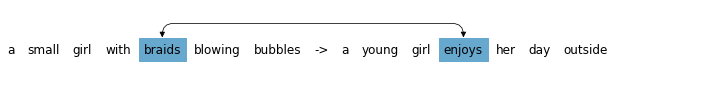


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A small girl with braids blowing bubbles.', 'A young girl enjoys her day outside.']
gold label: neutral
pred label: neutral
explanations: [(('braids',), ('her', 'day')), (('bubbles',), ('her', 'day')), (('braids',), ('enjoys', 'her')), (('small',), ('her', 'day')), (('with',), ('her', 'day')), (('a',), ('her', 'day')), (('with',), ('enjoys', 'her')), (('braids',), ('her', 'outside')), (('bubbles',), ('enjoys', 'her'))]
interactions_vote: []
interactions_union: []


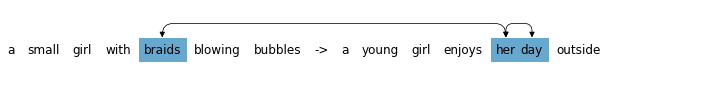


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A small girl with braids blowing bubbles.', 'A young girl enjoys her day outside.']
gold label: neutral
pred label: neutral
explanations: [(('braids',), ('enjoys', 'her', 'outside')), (('with',), ('enjoys', 'her', 'outside')), (('braids',), ('enjoys', 'her', 'day')), (('with',), ('enjoys', 'her', 'day')), (('small',), ('enjoys', 'her', 'outside')), (('a',), ('enjoys', 'her', 'day')), (('braids',), ('her', 'day', 'outside')), (('small',), ('enjoys', 'her', 'day')), (('a',), ('enjoys', 'her', 'outside')), (('bubbles',), ('enjoys', 'her', 'day')), (('with', 'braids'), ('her', 'day')), (('blowing',), ('enjoys', 'her', 'day')), (('blowing',), ('enjoys', 'her', 'outside')), (('braids',), ('her', 'day')), (('with', 'bubbles'), ('her', 'day')), (('a', 'braids'), ('her', 'day')), (('bubbles',), ('enjoys', 'her', 'outside')), (('braids',), ('girl', 'her', 'day'))]
interactions_vote: []
interactions_union:

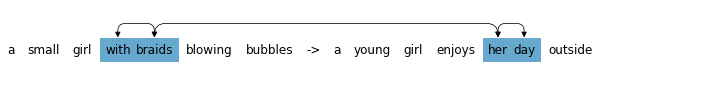

############################ 780 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['A man is spinning a little girl in the air above his head.', 'A man is carrying his daughter above his head.']
gold label: neutral
pred label: neutral
explanations: [((), ('daughter',)), (('girl',), ()), ((), ('above',)), (('head',), ()), (('above',), ()), (('little',), ()), (('in',), ()), (('is',), ()), ((), ('his',))]
interactions_vote: []
interactions_union: []


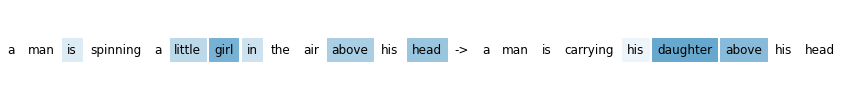


bert-base_arch-5_test_BT=[MASK].json
texts: ['A man is spinning a little girl in the air above his head.', 'A man is carrying his daughter above his head.']
gold label: neutral
pred label: neutral
explanations: [(('spinning', 'girl'), ('carrying', 'daughter'))]
interactions_vote: []
interactions_union: []


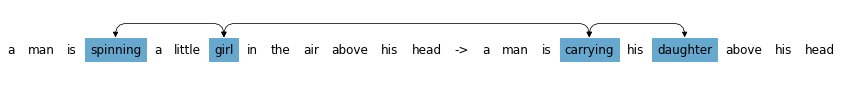


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A man is spinning a little girl in the air above his head.', 'A man is carrying his daughter above his head.']
gold label: neutral
pred label: neutral
explanations: [(('girl',), ('daughter',)), (('girl',), ('carrying',))]
interactions_vote: []
interactions_union: []


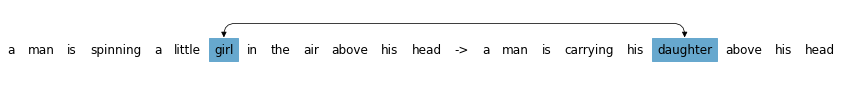


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A man is spinning a little girl in the air above his head.', 'A man is carrying his daughter above his head.']
gold label: neutral
pred label: neutral
explanations: [(('girl',), ('daughter',)), (('head',), ('daughter',)), (('above',), ('daughter',)), (('little',), ('daughter',)), (('the',), ('daughter',)), (('air',), ('daughter',)), (('in',), ('daughter',)), (('a',), ('daughter',)), (('his',), ('daughter',)), (('man',), ('daughter',)), (('is',), ('daughter',)), (('above',), ('above',)), (('spinning',), ('daughter',)), (('head',), ('his',)), (('girl',), ('his',)), (('above',), ('his',))]
interactions_vote: []
interactions_union: []


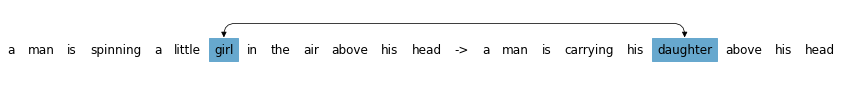


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A man is spinning a little girl in the air above his head.', 'A man is carrying his daughter above his head.']
gold label: neutral
pred label: neutral
explanations: [(('girl', 'head'), ('daughter',)), (('girl', 'above'), ('daughter',)), (('girl',), ('his', 'daughter')), (('girl',), ('daughter', 'his')), (('man', 'girl'), ('daughter',)), (('girl', 'air'), ('daughter',)), (('above',), ('daughter', 'above')), (('girl',), ('daughter', 'above')), (('girl', 'in'), ('daughter',)), (('little', 'girl'), ('daughter',))]
interactions_vote: []
interactions_union: []


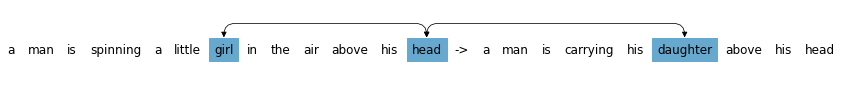


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A man is spinning a little girl in the air above his head.', 'A man is carrying his daughter above his head.']
gold label: neutral
pred label: neutral
explanations: [(('girl', 'above'), ('daughter', 'above')), (('girl', 'above', 'head'), ('daughter',)), (('girl', 'head'), ('his', 'daughter')), (('girl', 'above'), ('his', 'daughter')), (('little', 'girl'), ('his', 'daughter')), (('girl', 'head'), ('daughter', 'head')), (('man', 'girl', 'head'), ('daughter',)), (('above',), ('his', 'daughter', 'above')), (('man', 'girl', 'above'), ('daughter',)), (('above', 'head'), ('daughter', 'above')), (('man', 'girl'), ('his', 'daughter')), (('girl',), ('his', 'daughter', 'above')), (('little', 'girl', 'head'), ('daughter',)), (('girl', 'head'), ('daughter', 'his')), (('girl', 'above', 'his'), ('daughter',)), (('girl', 'above'), ('daughter', 'his')), (('girl', 'in'), ('his', 'daughter')), (('little', 'girl', 

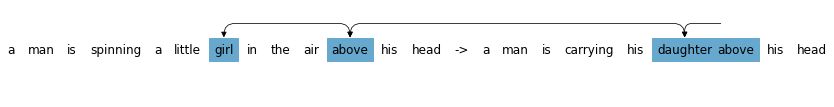

############################ 316 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['Two performers, one man playing a guitar, and one woman with a mic raised to her mouth are sitting on chairs performing.', 'A man and woman are kissing in a car.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('car',)), ((), ('kissing',)), ((), ('man',)), (('mic',), ()), ((), ('in',)), (('playing',), ()), (('guitar',), ()), (('performing',), ()), ((), ('woman',))]
interactions_vote: [(['performing'], ['kissing', 'in', 'a', 'car'])]
interactions_union: [(['mic', 'raised', 'to', 'her', 'mouth'], ['kissing', 'in', 'a', 'car']), (['chairs', 'performing'], ['kissing', 'in', 'a', 'car'])]


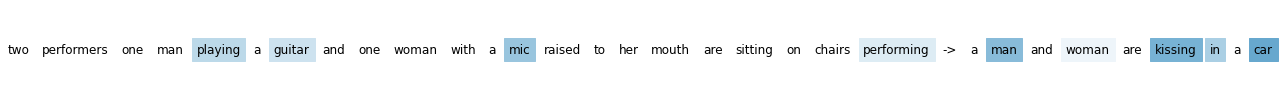


bert-base_arch-5_test_BT=[MASK].json
texts: ['Two performers, one man playing a guitar, and one woman with a mic raised to her mouth are sitting on chairs performing.', 'A man and woman are kissing in a car.']
gold label: contradiction
pred label: contradiction
explanations: [(('chairs',), ('kissing', 'car')), (('woman', 'her'), ('man',)), (('man',), ('woman',))]
interactions_vote: [(['performing'], ['kissing', 'in', 'a', 'car'])]
interactions_union: [(['mic', 'raised', 'to', 'her', 'mouth'], ['kissing', 'in', 'a', 'car']), (['chairs', 'performing'], ['kissing', 'in', 'a', 'car'])]


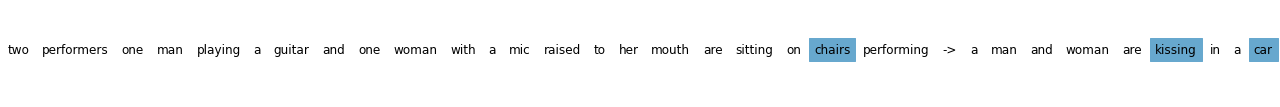


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['Two performers, one man playing a guitar, and one woman with a mic raised to her mouth are sitting on chairs performing.', 'A man and woman are kissing in a car.']
gold label: contradiction
pred label: contradiction
explanations: [(('chairs',), ('car',)), (('woman',), ('man',)), (('man',), ('woman',))]
interactions_vote: [(['performing'], ['kissing', 'in', 'a', 'car'])]
interactions_union: [(['mic', 'raised', 'to', 'her', 'mouth'], ['kissing', 'in', 'a', 'car']), (['chairs', 'performing'], ['kissing', 'in', 'a', 'car'])]


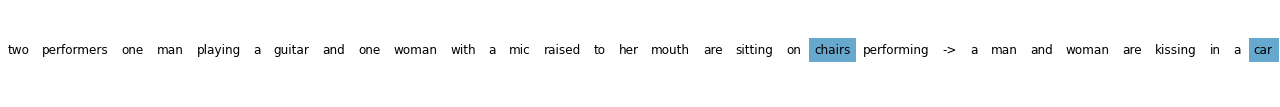


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Two performers, one man playing a guitar, and one woman with a mic raised to her mouth are sitting on chairs performing.', 'A man and woman are kissing in a car.']
gold label: contradiction
pred label: contradiction
explanations: [(('chairs',), ('car',)), (('performers',), ('car',)), (('mic',), ('kissing',)), (('guitar',), ('car',)), (('playing',), ('car',)), (('performing',), ('car',)), (('mic',), ('car',)), (('raised',), ('car',)), (('sitting',), ('car',)), (('and',), ('car',)), (('to',), ('car',)), (('a',), ('car',)), (('woman',), ('car',)), (('are',), ('car',)), (('one',), ('car',)), (('with',), ('car',)), (('mouth',), ('car',)), (('her',), ('car',)), (('two',), ('car',))]
interactions_vote: [(['performing'], ['kissing', 'in', 'a', 'car'])]
interactions_union: [(['mic', 'raised', 'to', 'her', 'mouth'], ['kissing', 'in', 'a', 'car']), (['chairs', 'performing'], ['kissing', 'in', 'a', 'car'])]


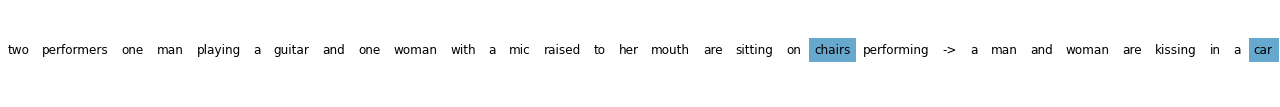


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Two performers, one man playing a guitar, and one woman with a mic raised to her mouth are sitting on chairs performing.', 'A man and woman are kissing in a car.']
gold label: contradiction
pred label: contradiction
explanations: [(('chairs',), ('in', 'car')), (('mic',), ('kissing', 'car')), (('chairs',), ('kissing', 'car')), (('performers',), ('kissing', 'car')), (('guitar',), ('kissing', 'car')), (('performing',), ('kissing', 'car')), (('playing',), ('kissing', 'car')), (('raised',), ('kissing', 'car')), (('sitting',), ('kissing', 'car')), (('performers',), ('in', 'car'))]
interactions_vote: [(['performing'], ['kissing', 'in', 'a', 'car'])]
interactions_union: [(['mic', 'raised', 'to', 'her', 'mouth'], ['kissing', 'in', 'a', 'car']), (['chairs', 'performing'], ['kissing', 'in', 'a', 'car'])]


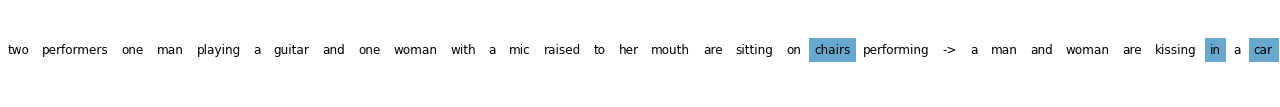


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['Two performers, one man playing a guitar, and one woman with a mic raised to her mouth are sitting on chairs performing.', 'A man and woman are kissing in a car.']
gold label: contradiction
pred label: contradiction
explanations: [(('chairs',), ('kissing', 'in', 'car')), (('chairs',), ('and', 'in', 'car')), (('performers', 'chairs'), ('in', 'car')), (('mic', 'chairs'), ('in', 'car')), (('chairs',), ('a', 'in', 'car')), (('on', 'chairs'), ('in', 'car')), (('one', 'chairs'), ('in', 'car')), (('mouth', 'chairs'), ('in', 'car')), (('raised', 'chairs'), ('in', 'car')), (('guitar', 'chairs'), ('in', 'car')), (('chairs',), ('in', 'a', 'car')), (('and', 'chairs'), ('in', 'car')), (('sitting', 'chairs'), ('in', 'car')), (('mic', 'chairs'), ('kissing', 'car')), (('with', 'chairs'), ('in', 'car')), (('chairs', 'performing'), ('in', 'car')), (('a', 'chairs'), ('in', 'car')), (('are', 'chairs'), ('in', 'car'

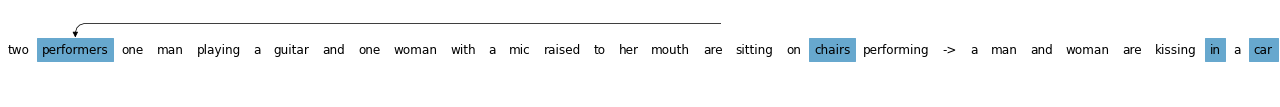

############################ 369 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['Two girls aboard an amusement park ride.', 'Two girls play jump rope in the street.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('street',)), (('aboard',), ()), ((), ('rope',)), (('ride',), ()), ((), ('Two',)), ((), ('girls',)), (('park',), ()), ((), ('the',)), ((), ())]
interactions_vote: [(['amusement', 'park'], ['street'])]
interactions_union: [(['aboard', 'an', 'amusement', 'park', 'ride'], ['play', 'jump', 'rope']), (['aboard', 'an', 'amusement', 'park', 'ride'], ['street'])]


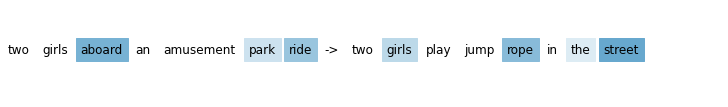


bert-base_arch-5_test_BT=[MASK].json
texts: ['Two girls aboard an amusement park ride.', 'Two girls play jump rope in the street.']
gold label: contradiction
pred label: contradiction
explanations: [(('girls',), ('rope', 'street')), (('amusement', 'park'), ('two', 'girls'))]
interactions_vote: [(['amusement', 'park'], ['street'])]
interactions_union: [(['aboard', 'an', 'amusement', 'park', 'ride'], ['play', 'jump', 'rope']), (['aboard', 'an', 'amusement', 'park', 'ride'], ['street'])]


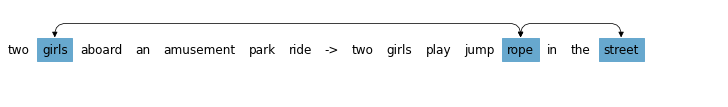


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['Two girls aboard an amusement park ride.', 'Two girls play jump rope in the street.']
gold label: contradiction
pred label: contradiction
explanations: [(('girls',), ('rope', 'street'))]
interactions_vote: [(['amusement', 'park'], ['street'])]
interactions_union: [(['aboard', 'an', 'amusement', 'park', 'ride'], ['play', 'jump', 'rope']), (['aboard', 'an', 'amusement', 'park', 'ride'], ['street'])]


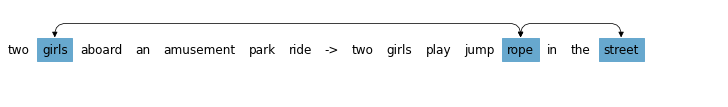


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Two girls aboard an amusement park ride.', 'Two girls play jump rope in the street.']
gold label: contradiction
pred label: contradiction
explanations: [(('aboard',), ('street',)), (('park',), ('street',)), (('ride',), ('street',)), (('an',), ('street',)), (('girls',), ('street',)), (('two',), ('street',)), (('amusement',), ('street',)), (('ride',), ('rope',)), (('ride',), ('play',)), (('aboard',), ('rope',)), (('aboard',), ('play',)), (('park',), ('rope',)), (('ride',), ('two',)), (('aboard',), ('two',)), (('an',), ('rope',)), (('ride',), ('in',)), (('girls',), ('rope',)), (('aboard',), ('in',)), (('ride',), ('jump',)), (('ride',), ('girls',))]
interactions_vote: [(['amusement', 'park'], ['street'])]
interactions_union: [(['aboard', 'an', 'amusement', 'park', 'ride'], ['play', 'jump', 'rope']), (['aboard', 'an', 'amusement', 'park', 'ride'], ['street'])]


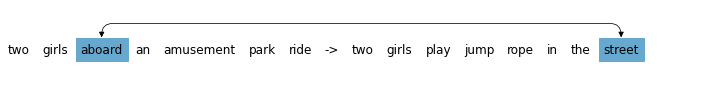


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Two girls aboard an amusement park ride.', 'Two girls play jump rope in the street.']
gold label: contradiction
pred label: contradiction
explanations: [(('park',), ('rope', 'street')), (('aboard', 'park'), ('street',)), (('aboard', 'ride'), ('street',)), (('aboard',), ('the', 'street')), (('park', 'ride'), ('street',)), (('park',), ('the', 'street')), (('aboard',), ('rope', 'street')), (('aboard',), ('two', 'street')), (('ride',), ('rope', 'street')), (('aboard',), ('girls', 'street'))]
interactions_vote: [(['amusement', 'park'], ['street'])]
interactions_union: [(['aboard', 'an', 'amusement', 'park', 'ride'], ['play', 'jump', 'rope']), (['aboard', 'an', 'amusement', 'park', 'ride'], ['street'])]


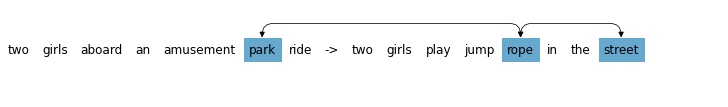


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['Two girls aboard an amusement park ride.', 'Two girls play jump rope in the street.']
gold label: contradiction
pred label: contradiction
explanations: [(('park',), ('rope', 'in', 'street')), (('amusement', 'park'), ('rope', 'street')), (('aboard', 'park'), ('rope', 'street')), (('aboard', 'ride'), ('rope', 'street')), (('aboard', 'park', 'ride'), ('street',)), (('aboard', 'park'), ('the', 'street')), (('aboard', 'ride'), ('the', 'street')), (('aboard',), ('rope', 'in', 'street')), (('park',), ('rope', 'the', 'street')), (('aboard',), ('rope', 'the', 'street')), (('aboard', 'ride'), ('in', 'street')), (('park', 'ride'), ('the', 'street')), (('ride',), ('rope', 'in', 'street')), (('aboard', 'ride'), ('two', 'street')), (('aboard', 'ride'), ('girls', 'street')), (('girls', 'park'), ('rope', 'street')), (('aboard',), ('two', 'rope', 'street')), (('aboard', 'park'), ('in', 'street')), (('aboard',), 

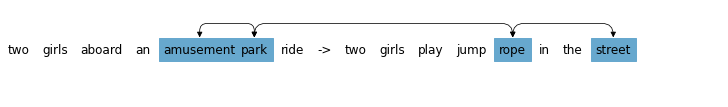

############################ 362 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['There is a group of children getting their picture taken with presents.', 'Children opening presents.']
gold label: entailment
pred label: contradiction
explanations: [((), ('opening',)), (('picture',), ()), (('taken',), ()), (('of',), ()), ((), ('presents',)), (('is',), ()), (('group',), ()), (('with',), ()), (('There',), ())]
interactions_vote: [(['children'], ['opening', 'presents']), (['with', 'presents'], ['opening', 'presents'])]
interactions_union: [(['group', 'of', 'children'], ['Children', 'opening', 'presents']), (['picture'], ['Children', 'opening', 'presents']), (['with', 'presents'], ['Children', 'opening', 'presents'])]


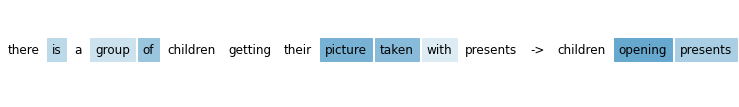


bert-base_arch-5_test_BT=[MASK].json
texts: ['There is a group of children getting their picture taken with presents.', 'Children opening presents.']
gold label: entailment
pred label: contradiction
explanations: []
interactions_vote: [(['children'], ['opening', 'presents']), (['with', 'presents'], ['opening', 'presents'])]
interactions_union: [(['group', 'of', 'children'], ['Children', 'opening', 'presents']), (['picture'], ['Children', 'opening', 'presents']), (['with', 'presents'], ['Children', 'opening', 'presents'])]


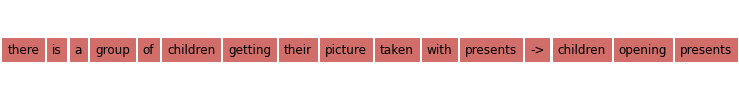


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['There is a group of children getting their picture taken with presents.', 'Children opening presents.']
gold label: entailment
pred label: contradiction
explanations: []
interactions_vote: [(['children'], ['opening', 'presents']), (['with', 'presents'], ['opening', 'presents'])]
interactions_union: [(['group', 'of', 'children'], ['Children', 'opening', 'presents']), (['picture'], ['Children', 'opening', 'presents']), (['with', 'presents'], ['Children', 'opening', 'presents'])]


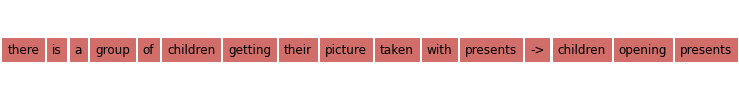


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['There is a group of children getting their picture taken with presents.', 'Children opening presents.']
gold label: entailment
pred label: contradiction
explanations: [(('picture',), ('opening',)), (('taken',), ('opening',)), (('with',), ('opening',)), (('group',), ('opening',)), (('a',), ('opening',)), (('is',), ('opening',)), (('there',), ('opening',)), (('of',), ('opening',)), (('getting',), ('opening',)), (('their',), ('opening',)), (('children',), ('opening',)), (('presents',), ('opening',)), (('picture',), ('children',)), (('group',), ('children',)), (('taken',), ('children',)), (('with',), ('children',)), (('a',), ('children',)), (('of',), ('children',)), (('taken',), ('presents',)), (('is',), ('children',))]
interactions_vote: [(['children'], ['opening', 'presents']), (['with', 'presents'], ['opening', 'presents'])]
interactions_union: [(['group', 'of', 'children'], ['Children', 'opening', 'present

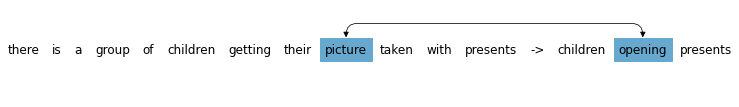


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['There is a group of children getting their picture taken with presents.', 'Children opening presents.']
gold label: entailment
pred label: contradiction
explanations: [(('picture',), ('children', 'opening')), (('getting', 'picture'), ('opening',)), (('picture', 'taken'), ('opening',)), (('is', 'picture'), ('opening',)), (('picture',), ('opening', 'presents')), (('a', 'picture'), ('opening',)), (('picture', 'with'), ('opening',)), (('group', 'picture'), ('opening',)), (('picture',), ('opening',)), (('there', 'picture'), ('opening',))]
interactions_vote: [(['children'], ['opening', 'presents']), (['with', 'presents'], ['opening', 'presents'])]
interactions_union: [(['group', 'of', 'children'], ['Children', 'opening', 'presents']), (['picture'], ['Children', 'opening', 'presents']), (['with', 'presents'], ['Children', 'opening', 'presents'])]


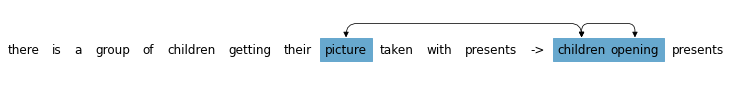


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['There is a group of children getting their picture taken with presents.', 'Children opening presents.']
gold label: entailment
pred label: contradiction
explanations: [(('is', 'picture'), ('children', 'opening')), (('picture', 'taken'), ('children', 'opening')), (('getting', 'picture'), ('opening', 'presents')), (('getting', 'picture'), ('children', 'opening')), (('a', 'picture'), ('children', 'opening')), (('picture', 'taken', 'with'), ('opening',)), (('their', 'picture'), ('children', 'opening')), (('picture',), ('children', 'opening', 'presents')), (('picture', 'with'), ('children', 'opening')), (('there', 'picture'), ('opening', 'presents')), (('group', 'picture'), ('children', 'opening')), (('there', 'picture'), ('children', 'opening')), (('a', 'picture'), ('opening', 'presents')), (('a', 'picture', 'taken'), ('opening',)), (('of', 'picture'), ('children', 'opening')), (('a', 'getting', 'pi

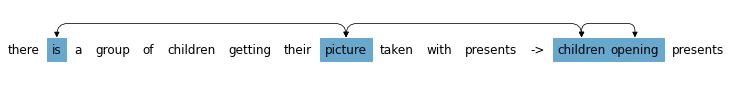

############################ 793 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['A man in a black suit with a cat on a leash is looking in a shop while the cat stands beside him staring the opposite direction of the man, as a woman in a green jacket, black pants and high heels has walked past both cat and man.', 'A man taking his cat with him while running some errands.']
gold label: neutral
pred label: neutral
explanations: [((), ('errands',)), ((), ('taking',)), ((), ('his',)), ((), ('some',)), (('cat',), ()), ((), ('him',)), ((), ('man',)), (('green',), ()), (('leash',), ())]
interactions_vote: []
interactions_union: []


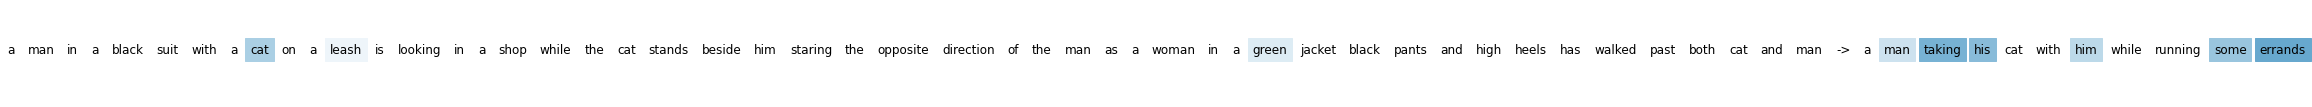


bert-base_arch-5_test_BT=[MASK].json
texts: ['A man in a black suit with a cat on a leash is looking in a shop while the cat stands beside him staring the opposite direction of the man, as a woman in a green jacket, black pants and high heels has walked past both cat and man.', 'A man taking his cat with him while running some errands.']
gold label: neutral
pred label: neutral
explanations: [((), ('a', 'his', 'cat', 'him', 'running', 'errands'))]
interactions_vote: []
interactions_union: []


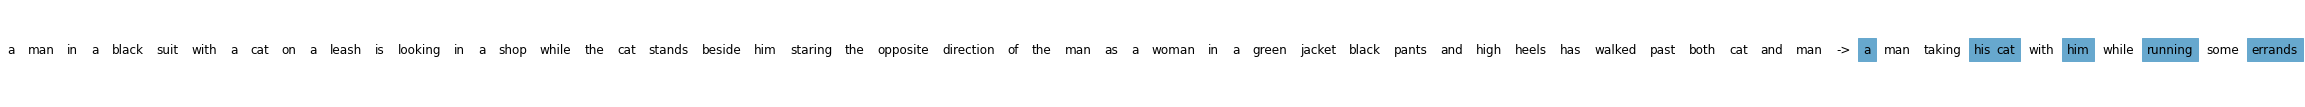


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A man in a black suit with a cat on a leash is looking in a shop while the cat stands beside him staring the opposite direction of the man, as a woman in a green jacket, black pants and high heels has walked past both cat and man.', 'A man taking his cat with him while running some errands.']
gold label: neutral
pred label: neutral
explanations: []
interactions_vote: []
interactions_union: []


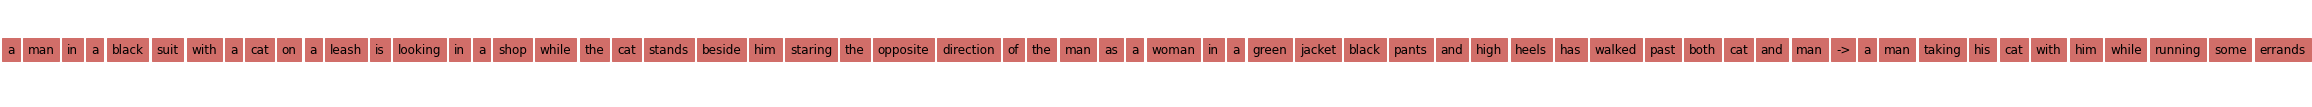


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A man in a black suit with a cat on a leash is looking in a shop while the cat stands beside him staring the opposite direction of the man, as a woman in a green jacket, black pants and high heels has walked past both cat and man.', 'A man taking his cat with him while running some errands.']
gold label: neutral
pred label: neutral
explanations: [(('cat',), ('errands',)), (('the',), ('errands',)), (('opposite',), ('errands',)), (('past',), ('errands',)), (('man',), ('errands',)), (('black',), ('errands',)), (('staring',), ('errands',)), (('in',), ('errands',)), (('leash',), ('errands',)), (('direction',), ('errands',)), (('jacket',), ('errands',)), (('a',), ('errands',)), (('pants',), ('errands',)), (('green',), ('errands',)), (('heels',), ('errands',))]
interactions_vote: []
interactions_union: []


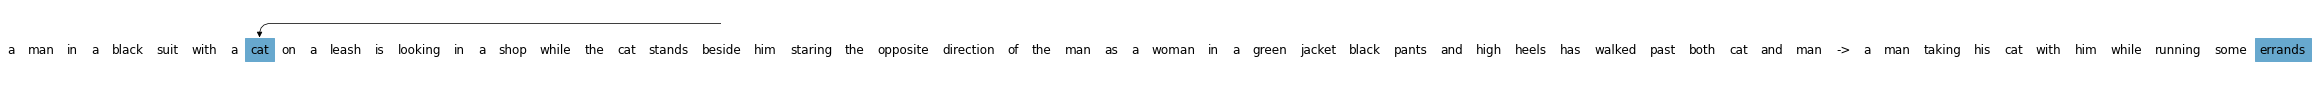


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A man in a black suit with a cat on a leash is looking in a shop while the cat stands beside him staring the opposite direction of the man, as a woman in a green jacket, black pants and high heels has walked past both cat and man.', 'A man taking his cat with him while running some errands.']
gold label: neutral
pred label: neutral
explanations: [(('cat',), ('running', 'errands')), (('cat',), ('some', 'errands')), (('cat',), ('errands',)), (('a',), ('running', 'errands'))]
interactions_vote: []
interactions_union: []


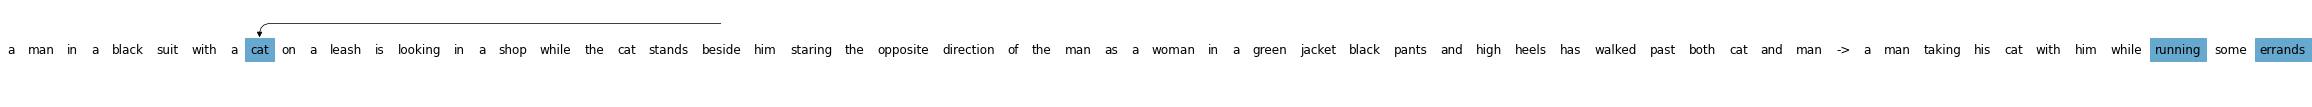


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A man in a black suit with a cat on a leash is looking in a shop while the cat stands beside him staring the opposite direction of the man, as a woman in a green jacket, black pants and high heels has walked past both cat and man.', 'A man taking his cat with him while running some errands.']
gold label: neutral
pred label: neutral
explanations: [(('cat',), ('running', 'some', 'errands')), (('cat',), ('cat', 'running', 'errands')), (('cat',), ('his', 'running', 'errands')), (('direction',), ('running', 'some', 'errands')), (('a', 'cat'), ('running', 'errands')), (('cat',), ('running', 'errands')), (('cat',), ('him', 'errands')), (('cat', 'man'), ('running', 'errands')), (('man',), ('running', 'some', 'errands')), (('man', 'cat'), ('running', 'errands')), (('cat', 'black'), ('running', 'errands'))]
interactions_vote: []
interactions_union: []


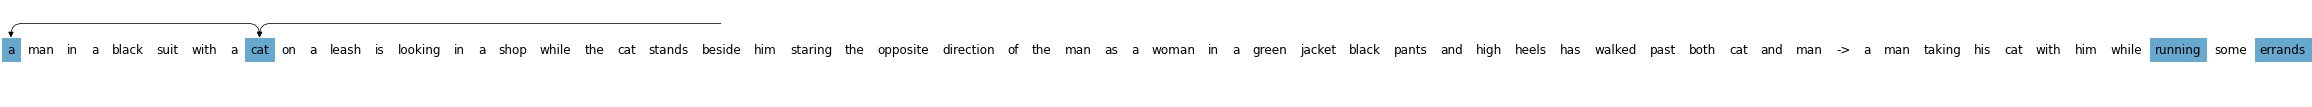

############################ 712 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['A man is holding a book standing in front of a chalkboard.', 'A man is holding a book about fossils, standing in front of a chalkboard.']
gold label: neutral
pred label: neutral
explanations: [((), ('about',)), ((), ('book',)), ((), ('fossils',)), (('book',), ()), ((), ('chalkboard',)), (('standing',), ()), ((), ('front',)), ((), ('is',)), ((), ('holding',)), (('of',), ()), (('front',), ()), ((), ('standing',)), ((), ('man',)), (('holding',), ()), (('a',), ())]
interactions_vote: []
interactions_union: []


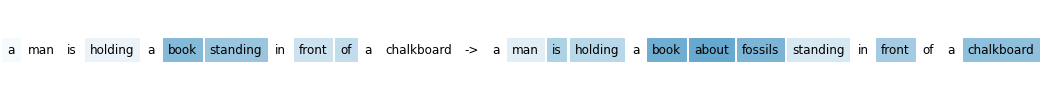


bert-base_arch-5_test_BT=[MASK].json
texts: ['A man is holding a book standing in front of a chalkboard.', 'A man is holding a book about fossils, standing in front of a chalkboard.']
gold label: neutral
pred label: neutral
explanations: [((), ('book', 'about', 'fossils'))]
interactions_vote: []
interactions_union: []


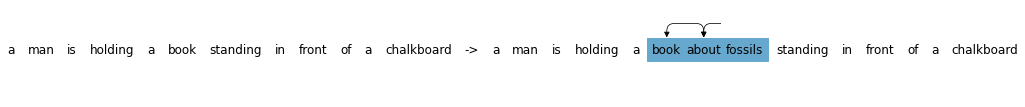


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A man is holding a book standing in front of a chalkboard.', 'A man is holding a book about fossils, standing in front of a chalkboard.']
gold label: neutral
pred label: neutral
explanations: []
interactions_vote: []
interactions_union: []


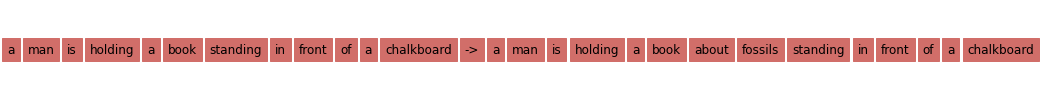


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A man is holding a book standing in front of a chalkboard.', 'A man is holding a book about fossils, standing in front of a chalkboard.']
gold label: neutral
pred label: neutral
explanations: [(('book',), ('about',)), (('book',), ('book',)), (('chalkboard',), ('about',)), (('book',), ('chalkboard',)), (('standing',), ('about',)), (('of',), ('about',)), (('front',), ('about',)), (('is',), ('about',)), (('in',), ('about',)), (('book',), ('fossils',)), (('man',), ('about',)), (('holding',), ('about',)), (('chalkboard',), ('chalkboard',)), (('a',), ('about',)), (('standing',), ('book',)), (('standing',), ('chalkboard',)), (('a',), ('chalkboard',))]
interactions_vote: []
interactions_union: []


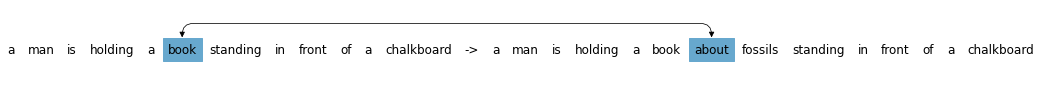


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A man is holding a book standing in front of a chalkboard.', 'A man is holding a book about fossils, standing in front of a chalkboard.']
gold label: neutral
pred label: neutral
explanations: [(('book',), ('about', 'fossils')), (('book',), ('book', 'about')), (('chalkboard',), ('about', 'fossils')), (('book',), ('book', 'fossils')), (('standing',), ('about', 'fossils')), (('a',), ('about', 'fossils')), (('of',), ('about', 'fossils')), (('in',), ('about', 'fossils')), (('is',), ('about', 'fossils')), (('front',), ('about', 'fossils'))]
interactions_vote: []
interactions_union: []


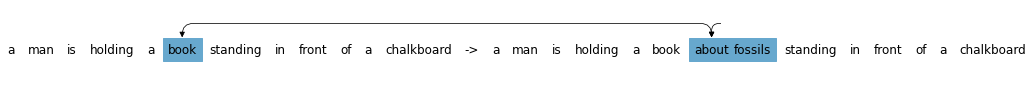


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A man is holding a book standing in front of a chalkboard.', 'A man is holding a book about fossils, standing in front of a chalkboard.']
gold label: neutral
pred label: neutral
explanations: [(('holding', 'book'), ('about', 'fossils')), (('book',), ('book', 'about', 'fossils')), (('book',), ('about', 'fossils', 'front')), (('book', 'standing'), ('about', 'fossils')), (('book', 'chalkboard'), ('about', 'fossils')), (('man', 'book'), ('about', 'fossils')), (('book',), ('about', 'fossils', 'chalkboard')), (('book', 'front'), ('about', 'fossils')), (('book',), ('about', 'fossils', 'a')), (('book', 'in'), ('about', 'fossils')), (('book',), ('holding', 'about', 'fossils')), (('book',), ('about', 'fossils', 'in')), (('book',), ('a', 'about', 'fossils')), (('book',), ('about', 'fossils', 'of')), (('book',), ('is', 'about', 'fossils')), (('a', 'book'), ('about', 'fossils')), (('book', 'a'), ('about', 'f

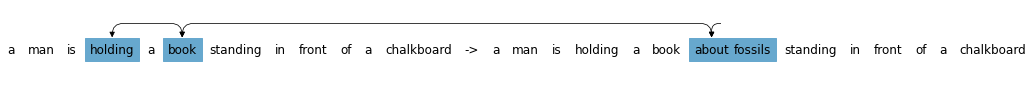

############################ 234 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['The little boy gets ready to kick the soccer ball.', 'the boy is ten years old']
gold label: neutral
pred label: neutral
explanations: [((), ('ten',)), ((), ('years',)), ((), ('is',)), ((), ('the',)), (('boy',), ()), ((), ('boy',)), (('little',), ()), ((), ('old',)), (('gets',), ()), (('The',), ()), ((), ()), (('kick',), ())]
interactions_vote: []
interactions_union: []


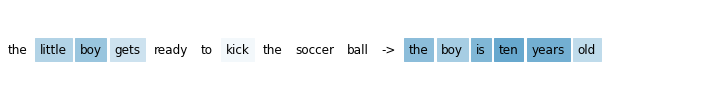


bert-base_arch-5_test_BT=[MASK].json
texts: ['The little boy gets ready to kick the soccer ball.', 'the boy is ten years old']
gold label: neutral
pred label: neutral
explanations: [((), ('the', 'is', 'ten', 'years', 'old')), (('little', 'boy'), ())]
interactions_vote: []
interactions_union: []


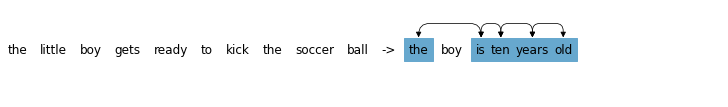


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['The little boy gets ready to kick the soccer ball.', 'the boy is ten years old']
gold label: neutral
pred label: neutral
explanations: [(('boy',), ('boy', 'ten')), (('little', 'boy'), ('the', 'old'))]
interactions_vote: []
interactions_union: []


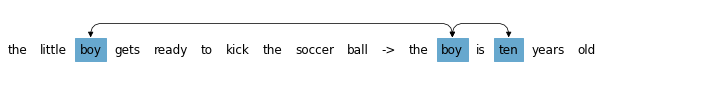


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['The little boy gets ready to kick the soccer ball.', 'the boy is ten years old']
gold label: neutral
pred label: neutral
explanations: [(('boy',), ('ten',)), (('little',), ('ten',)), (('boy',), ('years',)), (('little',), ('years',)), (('to',), ('ten',)), (('the',), ('ten',)), (('gets',), ('ten',)), (('kick',), ('ten',)), (('ball',), ('ten',)), (('boy',), ('boy',)), (('ready',), ('ten',)), (('soccer',), ('ten',)), (('to',), ('years',)), (('kick',), ('years',)), (('boy',), ('is',)), (('the',), ('years',)), (('boy',), ('old',)), (('ball',), ('years',))]
interactions_vote: []
interactions_union: []


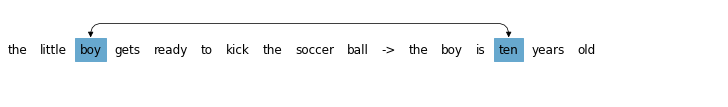


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['The little boy gets ready to kick the soccer ball.', 'the boy is ten years old']
gold label: neutral
pred label: neutral
explanations: [(('boy',), ('boy', 'ten')), (('boy',), ('is', 'ten')), (('little',), ('is', 'ten')), (('little',), ('boy', 'ten')), (('boy',), ('boy', 'years')), (('boy',), ('ten', 'old')), (('gets',), ('is', 'ten')), (('the',), ('is', 'ten')), (('to',), ('is', 'ten')), (('kick',), ('is', 'ten'))]
interactions_vote: []
interactions_union: []


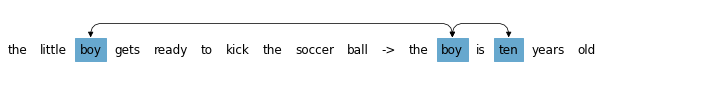


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['The little boy gets ready to kick the soccer ball.', 'the boy is ten years old']
gold label: neutral
pred label: neutral
explanations: [(('boy',), ('boy', 'is', 'ten')), (('boy',), ('boy', 'ten', 'old')), (('little', 'boy'), ('boy', 'ten')), (('boy', 'soccer'), ('boy', 'ten')), (('boy',), ('the', 'boy', 'ten')), (('little',), ('boy', 'is', 'ten')), (('boy',), ('the', 'is', 'ten')), (('boy', 'to'), ('boy', 'ten')), (('boy',), ('boy', 'ten', 'years')), (('boy', 'kick'), ('is', 'ten')), (('boy', 'ready'), ('boy', 'ten')), (('little',), ('the', 'is', 'ten')), (('boy', 'the'), ('boy', 'ten')), (('the', 'boy'), ('boy', 'ten')), (('boy', 'ball'), ('boy', 'ten')), (('boy', 'gets'), ('boy', 'ten')), (('boy', 'ball'), ('is', 'ten')), (('boy', 'soccer'), ('is', 'ten')), (('the', 'boy'), ('is', 'ten')), (('boy', 'gets'), ('is', 'ten'))]
interactions_vote: []
interactions_union: []


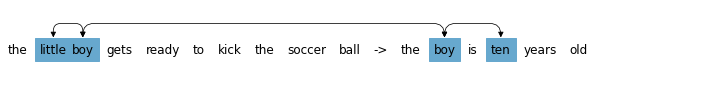

############################ 36 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['A person is on a four wheeler kicking up a lot of dirt in a dune.', 'The person is riding a big wheel.']
gold label: neutral
pred label: entailment
explanations: [((), ('wheel',)), ((), ('riding',)), ((), ('big',)), ((), ('person',)), (('on',), ()), (('up',), ()), (('a',), ()), (('is',), ()), (('wheeler',), ()), (('lot',), ())]
interactions_vote: []
interactions_union: []


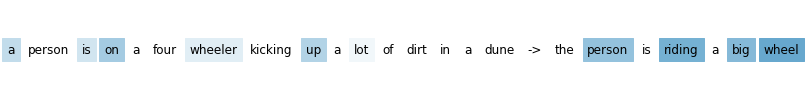


bert-base_arch-5_test_BT=[MASK].json
texts: ['A person is on a four wheeler kicking up a lot of dirt in a dune.', 'The person is riding a big wheel.']
gold label: neutral
pred label: entailment
explanations: [(('on', 'four', 'wheeler'), ('riding', 'big', 'wheel'))]
interactions_vote: []
interactions_union: []


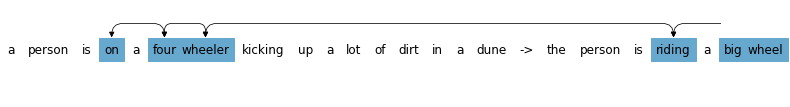


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A person is on a four wheeler kicking up a lot of dirt in a dune.', 'The person is riding a big wheel.']
gold label: neutral
pred label: entailment
explanations: [(('wheeler',), ('riding',)), (('a',), ('wheel',))]
interactions_vote: []
interactions_union: []


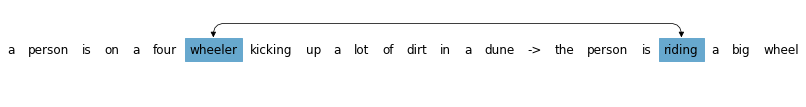


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A person is on a four wheeler kicking up a lot of dirt in a dune.', 'The person is riding a big wheel.']
gold label: neutral
pred label: entailment
explanations: [(('wheeler',), ('wheel',)), (('four',), ('wheel',)), (('wheeler',), ('riding',)), (('up',), ('wheel',)), (('on',), ('wheel',)), (('is',), ('wheel',)), (('wheeler',), ('a',)), (('lot',), ('wheel',)), (('of',), ('wheel',)), (('dirt',), ('wheel',)), (('in',), ('wheel',)), (('person',), ('wheel',)), (('on',), ('riding',)), (('a',), ('wheel',)), (('four',), ('riding',)), (('wheeler',), ('person',)), (('up',), ('riding',))]
interactions_vote: []
interactions_union: []


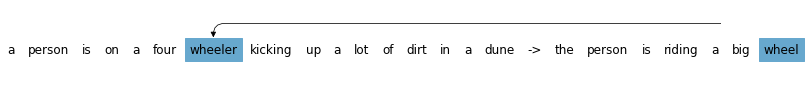


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A person is on a four wheeler kicking up a lot of dirt in a dune.', 'The person is riding a big wheel.']
gold label: neutral
pred label: entailment
explanations: [(('wheeler',), ('riding', 'wheel')), (('on', 'wheeler'), ('riding',)), (('on', 'wheeler'), ('wheel',)), (('four', 'wheeler'), ('riding',)), (('four', 'wheeler'), ('wheel',)), (('a', 'wheeler'), ('riding',)), (('person', 'wheeler'), ('riding',)), (('wheeler',), ('riding', 'a')), (('is', 'wheeler'), ('wheel',)), (('wheeler',), ('is', 'riding'))]
interactions_vote: []
interactions_union: []


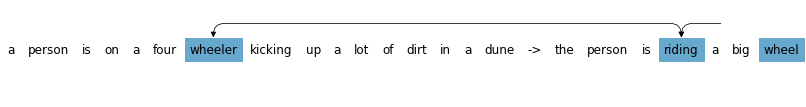


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A person is on a four wheeler kicking up a lot of dirt in a dune.', 'The person is riding a big wheel.']
gold label: neutral
pred label: entailment
explanations: [(('four', 'wheeler'), ('riding', 'wheel')), (('on', 'wheeler'), ('riding', 'wheel')), (('person', 'four', 'wheeler'), ('wheel',)), (('on', 'four'), ('riding', 'wheel')), (('a', 'four', 'wheeler'), ('wheel',)), (('on', 'a', 'four'), ('wheel',)), (('wheeler', 'up'), ('riding', 'wheel')), (('on', 'four', 'up'), ('wheel',)), (('a', 'wheeler'), ('riding', 'wheel')), (('person', 'wheeler'), ('riding', 'wheel')), (('on', 'four'), ('person', 'wheel')), (('four', 'wheeler'), ('a', 'wheel')), (('on', 'up'), ('riding', 'wheel')), (('a', 'four', 'up'), ('wheel',)), (('four', 'wheeler'), ('is', 'wheel')), (('on', 'four', 'wheeler'), ('wheel',)), (('wheeler',), ('is', 'riding', 'wheel')), (('a', 'on', 'four'), ('wheel',)), (('person', 'four'), ('per

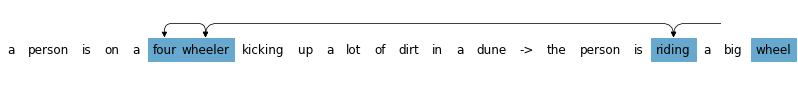

############################ 929 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ["A man and woman look through CD's at a street vendor.", 'A man and women shopping']
gold label: entailment
pred label: entailment
explanations: [(('woman',), ()), (('vendor',), ()), ((), ('and',)), (('man',), ()), (('and',), ()), ((), ('A',)), (('look',), ()), (('through',), ()), ((), ()), (('s',), ())]
interactions_vote: [(['look'], ['shopping']), (['street', 'vendor'], ['shopping'])]
interactions_union: [(['man'], ['man']), (['man'], ['women', 'shopping']), (['woman', 'look', 'through', 'CD', 's', 'at', 'a', 'street', 'vendor'], ['man']), (['woman', 'look', 'through', 'CD', 's', 'at', 'a', 'street', 'vendor'], ['women', 'shopping'])]


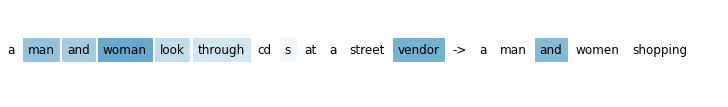


bert-base_arch-5_test_BT=[MASK].json
texts: ["A man and woman look through CD's at a street vendor.", 'A man and women shopping']
gold label: entailment
pred label: entailment
explanations: [(('man', 'and', 'woman'), ('man', 'and', 'women'))]
interactions_vote: [(['look'], ['shopping']), (['street', 'vendor'], ['shopping'])]
interactions_union: [(['man'], ['man']), (['man'], ['women', 'shopping']), (['woman', 'look', 'through', 'CD', 's', 'at', 'a', 'street', 'vendor'], ['man']), (['woman', 'look', 'through', 'CD', 's', 'at', 'a', 'street', 'vendor'], ['women', 'shopping'])]


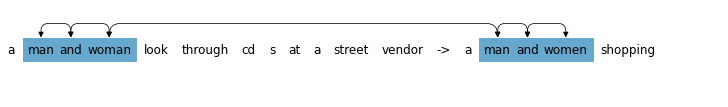


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ["A man and woman look through CD's at a street vendor.", 'A man and women shopping']
gold label: entailment
pred label: entailment
explanations: [(('man', 'woman'), ('man', 'women')), (('and',), ('and',))]
interactions_vote: [(['look'], ['shopping']), (['street', 'vendor'], ['shopping'])]
interactions_union: [(['man'], ['man']), (['man'], ['women', 'shopping']), (['woman', 'look', 'through', 'CD', 's', 'at', 'a', 'street', 'vendor'], ['man']), (['woman', 'look', 'through', 'CD', 's', 'at', 'a', 'street', 'vendor'], ['women', 'shopping'])]


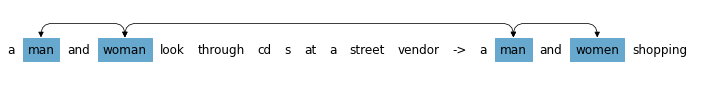


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ["A man and woman look through CD's at a street vendor.", 'A man and women shopping']
gold label: entailment
pred label: entailment
explanations: [(('woman',), ('and',)), (('woman',), ('women',)), (('and',), ('and',)), (('vendor',), ('and',)), (('man',), ('and',)), (('man',), ('man',)), (('woman',), ('a',)), (('man',), ('a',)), (('through',), ('and',)), (('vendor',), ('a',)), (('s',), ('and',)), (('and',), ('a',)), (('through',), ('a',)), (('a',), ('and',)), (('at',), ('and',)), (('cd',), ('and',)), (('street',), ('and',)), (('look',), ('and',)), (('street',), ('a',)), (('s',), ('a',))]
interactions_vote: [(['look'], ['shopping']), (['street', 'vendor'], ['shopping'])]
interactions_union: [(['man'], ['man']), (['man'], ['women', 'shopping']), (['woman', 'look', 'through', 'CD', 's', 'at', 'a', 'street', 'vendor'], ['man']), (['woman', 'look', 'through', 'CD', 's', 'at', 'a', 'street', 'vendor'], ['women', 's

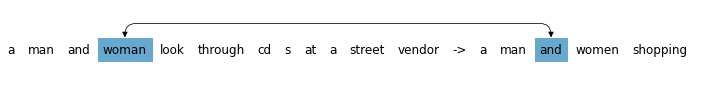


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ["A man and woman look through CD's at a street vendor.", 'A man and women shopping']
gold label: entailment
pred label: entailment
explanations: [(('man', 'woman'), ('and',)), (('woman', 'vendor'), ('and',)), (('and', 'woman'), ('and',)), (('woman',), ('and', 'women')), (('woman', 'vendor'), ('women',)), (('man', 'woman'), ('a',)), (('man', 'woman'), ('man',)), (('woman', 'through'), ('and',)), (('woman', 'through'), ('women',)), (('and', 'vendor'), ('and',))]
interactions_vote: [(['look'], ['shopping']), (['street', 'vendor'], ['shopping'])]
interactions_union: [(['man'], ['man']), (['man'], ['women', 'shopping']), (['woman', 'look', 'through', 'CD', 's', 'at', 'a', 'street', 'vendor'], ['man']), (['woman', 'look', 'through', 'CD', 's', 'at', 'a', 'street', 'vendor'], ['women', 'shopping'])]


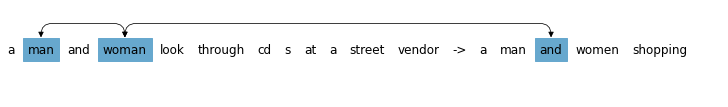


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ["A man and woman look through CD's at a street vendor.", 'A man and women shopping']
gold label: entailment
pred label: entailment
explanations: [(('man', 'woman', 'vendor'), ('and',)), (('woman', 'vendor'), ('and', 'women')), (('man', 'and', 'woman'), ('and',)), (('and', 'woman', 'vendor'), ('and',)), (('man', 'woman'), ('and', 'women')), (('and', 'woman'), ('and', 'women')), (('man', 'woman'), ('a', 'and')), (('man', 'woman', 'through'), ('and',)), (('man', 'woman'), ('man', 'women')), (('man', 'woman', 'vendor'), ('a',)), (('man', 'woman', 's'), ('and',)), (('man', 'woman', 'vendor'), ('man',)), (('a', 'man', 'woman'), ('and',)), (('man', 'woman', 'at'), ('and',)), (('man', 'woman'), ('man', 'and')), (('and', 'woman', 'through'), ('and',)), (('man', 'woman', 'look'), ('and',)), (('woman', 'through'), ('and', 'women')), (('man', 'woman', 'street'), ('and',)), (('woman', 'through', 'vendor'), ('

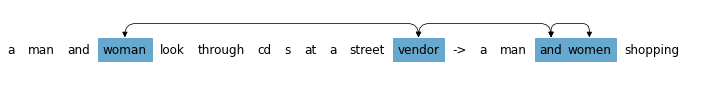

############################ 153 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['A boy in a green shirt is sitting in an almost empty stadium.', 'A boy is attending an event']
gold label: neutral
pred label: neutral
explanations: [((), ('event',)), (('stadium',), ()), (('almost',), ()), (('boy',), ()), ((), ('is',)), ((), ('boy',)), (('green',), ()), (('A',), ()), ((), ('A',)), (('an',), ()), ((), ('an',))]
interactions_vote: []
interactions_union: []


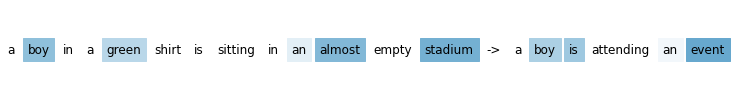


bert-base_arch-5_test_BT=[MASK].json
texts: ['A boy in a green shirt is sitting in an almost empty stadium.', 'A boy is attending an event']
gold label: neutral
pred label: neutral
explanations: [(('boy', 'empty', 'stadium'), ('boy', 'is', 'event'))]
interactions_vote: []
interactions_union: []


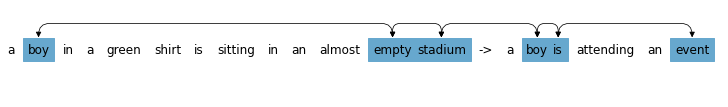


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A boy in a green shirt is sitting in an almost empty stadium.', 'A boy is attending an event']
gold label: neutral
pred label: neutral
explanations: [(('stadium',), ('event',)), (('boy',), ('event',)), (('empty',), ('attending', 'event'))]
interactions_vote: []
interactions_union: []


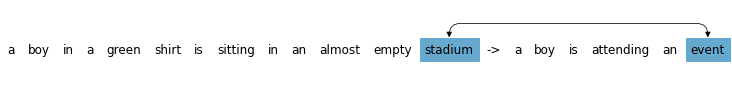


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A boy in a green shirt is sitting in an almost empty stadium.', 'A boy is attending an event']
gold label: neutral
pred label: neutral
explanations: [(('boy',), ('event',)), (('stadium',), ('event',)), (('green',), ('event',)), (('boy',), ('attending',)), (('an',), ('event',)), (('is',), ('event',)), (('almost',), ('event',)), (('a',), ('event',)), (('stadium',), ('attending',)), (('in',), ('event',)), (('shirt',), ('event',)), (('sitting',), ('event',)), (('boy',), ('boy',)), (('almost',), ('attending',)), (('green',), ('attending',)), (('an',), ('attending',)), (('a',), ('attending',)), (('in',), ('attending',))]
interactions_vote: []
interactions_union: []


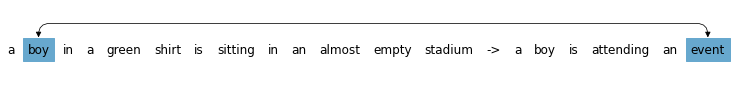


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A boy in a green shirt is sitting in an almost empty stadium.', 'A boy is attending an event']
gold label: neutral
pred label: neutral
explanations: [(('boy', 'stadium'), ('event',)), (('boy',), ('boy', 'event')), (('stadium',), ('attending', 'event')), (('boy', 'sitting'), ('event',)), (('an', 'stadium'), ('event',)), (('boy', 'green'), ('event',)), (('boy',), ('is', 'event')), (('boy', 'almost'), ('event',)), (('in', 'stadium'), ('event',)), (('almost', 'stadium'), ('event',))]
interactions_vote: []
interactions_union: []


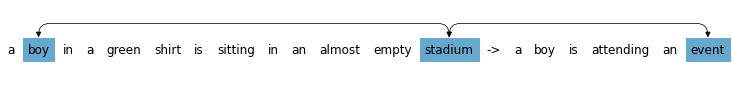


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A boy in a green shirt is sitting in an almost empty stadium.', 'A boy is attending an event']
gold label: neutral
pred label: neutral
explanations: [(('boy', 'sitting'), ('boy', 'event')), (('boy', 'green'), ('boy', 'event')), (('boy', 'stadium'), ('boy', 'event')), (('boy', 'almost', 'stadium'), ('event',)), (('boy', 'almost'), ('boy', 'event')), (('boy', 'sitting'), ('is', 'event')), (('boy',), ('boy', 'an', 'event')), (('boy', 'an', 'stadium'), ('event',)), (('boy', 'sitting', 'stadium'), ('event',)), (('boy', 'in', 'stadium'), ('event',)), (('boy',), ('is', 'an', 'event')), (('boy', 'green'), ('is', 'event')), (('boy', 'in'), ('boy', 'event')), (('boy', 'stadium'), ('attending', 'event')), (('boy', 'green'), ('an', 'event')), (('boy', 'stadium'), ('is', 'event')), (('boy', 'almost'), ('is', 'event')), (('boy', 'sitting', 'almost'), ('event',)), (('boy', 'almost'), ('attending', 'event')), (

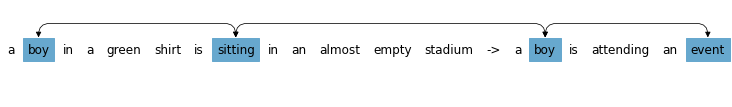

############################ 694 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['A person in a red and tan coat is snowboarding off a hill of snow.', 'A person rides a snowboard.']
gold label: entailment
pred label: entailment
explanations: [(('snowboarding',), ()), ((), ('snowboard',)), ((), ('person',)), (('off',), ()), ((), ('A',)), (('snow',), ()), (('a',), ())]
interactions_vote: [(['person'], ['person', 'rides']), (['person'], ['snowboard']), (['snowboarding'], ['person', 'rides']), (['snowboarding'], ['snowboard'])]
interactions_union: [(['person', 'in', 'a', 'red', 'and', 'tan', 'coat'], ['person', 'rides', 'a', 'snowboard']), (['snowboarding'], ['person', 'rides', 'a', 'snowboard'])]


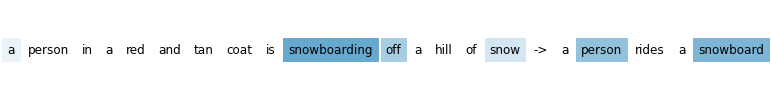


bert-base_arch-5_test_BT=[MASK].json
texts: ['A person in a red and tan coat is snowboarding off a hill of snow.', 'A person rides a snowboard.']
gold label: entailment
pred label: entailment
explanations: [(('snowboarding', 'snow'), ('snowboard',)), (('snowboarding',), ('rides', 'snowboard'))]
interactions_vote: [(['person'], ['person', 'rides']), (['person'], ['snowboard']), (['snowboarding'], ['person', 'rides']), (['snowboarding'], ['snowboard'])]
interactions_union: [(['person', 'in', 'a', 'red', 'and', 'tan', 'coat'], ['person', 'rides', 'a', 'snowboard']), (['snowboarding'], ['person', 'rides', 'a', 'snowboard'])]


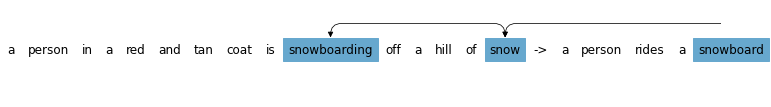


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A person in a red and tan coat is snowboarding off a hill of snow.', 'A person rides a snowboard.']
gold label: entailment
pred label: entailment
explanations: [(('snowboarding', 'snow'), ('snowboard',)), (('snowboarding',), ('rides', 'snowboard'))]
interactions_vote: [(['person'], ['person', 'rides']), (['person'], ['snowboard']), (['snowboarding'], ['person', 'rides']), (['snowboarding'], ['snowboard'])]
interactions_union: [(['person', 'in', 'a', 'red', 'and', 'tan', 'coat'], ['person', 'rides', 'a', 'snowboard']), (['snowboarding'], ['person', 'rides', 'a', 'snowboard'])]


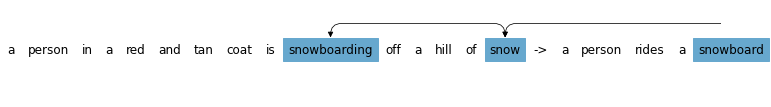


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A person in a red and tan coat is snowboarding off a hill of snow.', 'A person rides a snowboard.']
gold label: entailment
pred label: entailment
explanations: [(('snowboarding',), ('snowboard',)), (('snowboarding',), ('person',)), (('snowboarding',), ('a',)), (('snowboarding',), ('rides',)), (('snow',), ('snowboard',)), (('snow',), ('a',)), (('snow',), ('person',)), (('off',), ('person',)), (('off',), ('a',)), (('off',), ('snowboard',)), (('a',), ('person',)), (('a',), ('a',)), (('is',), ('a',))]
interactions_vote: [(['person'], ['person', 'rides']), (['person'], ['snowboard']), (['snowboarding'], ['person', 'rides']), (['snowboarding'], ['snowboard'])]
interactions_union: [(['person', 'in', 'a', 'red', 'and', 'tan', 'coat'], ['person', 'rides', 'a', 'snowboard']), (['snowboarding'], ['person', 'rides', 'a', 'snowboard'])]


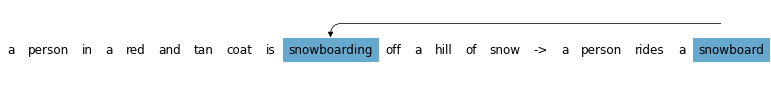


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A person in a red and tan coat is snowboarding off a hill of snow.', 'A person rides a snowboard.']
gold label: entailment
pred label: entailment
explanations: [(('snowboarding',), ('snowboard',)), (('snowboarding', 'snow'), ('snowboard',)), (('snowboarding',), ('a',)), (('snowboarding',), ('person',)), (('snowboarding',), ('person', 'snowboard')), (('snowboarding',), ('a', 'snowboard')), (('snowboarding', 'snow'), ('a',)), (('coat', 'snowboarding'), ('snowboard',))]
interactions_vote: [(['person'], ['person', 'rides']), (['person'], ['snowboard']), (['snowboarding'], ['person', 'rides']), (['snowboarding'], ['snowboard'])]
interactions_union: [(['person', 'in', 'a', 'red', 'and', 'tan', 'coat'], ['person', 'rides', 'a', 'snowboard']), (['snowboarding'], ['person', 'rides', 'a', 'snowboard'])]


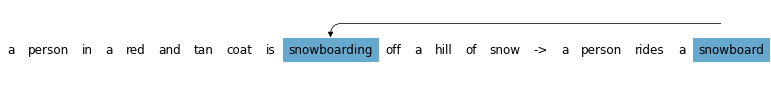


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A person in a red and tan coat is snowboarding off a hill of snow.', 'A person rides a snowboard.']
gold label: entailment
pred label: entailment
explanations: [(('snowboarding',), ('snowboard',)), (('snowboarding', 'off'), ('snowboard',)), (('snowboarding', 'off', 'snow'), ('snowboard',)), (('snowboarding', 'snow'), ('snowboard',)), (('snowboarding',), ('person', 'snowboard')), (('snowboarding',), ('a', 'snowboard')), (('and', 'snowboarding'), ('snowboard',)), (('a', 'snowboarding'), ('snowboard',)), (('snowboarding', 'a'), ('snowboard',)), (('snowboarding', 'snow'), ('person', 'snowboard')), (('person', 'snowboarding'), ('snowboard',)), (('and', 'snowboarding', 'snow'), ('snowboard',)), (('snowboarding', 'snow'), ('a', 'snowboard')), (('snowboarding', 'of'), ('snowboard',)), (('tan', 'snowboarding'), ('snowboard',)), (('is', 'snowboarding'), ('snowboard',)), (('red', 'snowboarding', 'snow'), (

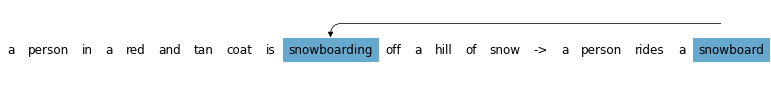

############################ 810 #################################

bert-base_lime-5000_test_BT=[MASK].json
texts: ['A lady wearing gloves, and a ponytail cooks something while people stand and watch.', 'The lady is asleep']
gold label: contradiction
pred label: contradiction
explanations: [((), ('asleep',)), ((), ('lady',)), ((), ('is',)), (('cooks',), ()), (('a',), ()), (('wearing',), ()), (('and',), ()), (('gloves',), ())]
interactions_vote: [(['cooks'], ['asleep'])]
interactions_union: [(['cooks'], ['asleep'])]


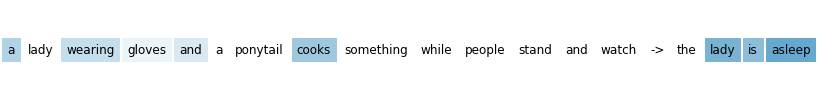


bert-base_arch-5_test_BT=[MASK].json
texts: ['A lady wearing gloves, and a ponytail cooks something while people stand and watch.', 'The lady is asleep']
gold label: contradiction
pred label: contradiction
explanations: [(('gloves', 'ponytail', 'cooks'), ('the', 'lady', 'asleep'))]
interactions_vote: [(['cooks'], ['asleep'])]
interactions_union: [(['cooks'], ['asleep'])]


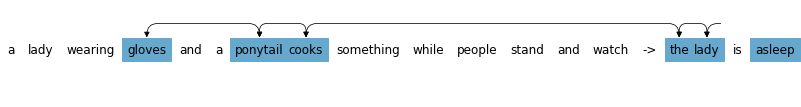


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A lady wearing gloves, and a ponytail cooks something while people stand and watch.', 'The lady is asleep']
gold label: contradiction
pred label: contradiction
explanations: [(('ponytail', 'cooks'), ('asleep',)), (('stand',), ('asleep',)), (('gloves',), ('asleep',))]
interactions_vote: [(['cooks'], ['asleep'])]
interactions_union: [(['cooks'], ['asleep'])]


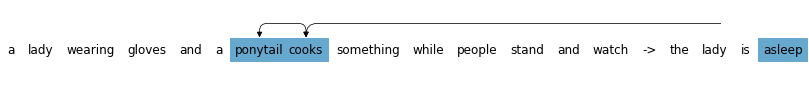


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A lady wearing gloves, and a ponytail cooks something while people stand and watch.', 'The lady is asleep']
gold label: contradiction
pred label: contradiction
explanations: [(('cooks',), ('asleep',)), (('stand',), ('asleep',)), (('people',), ('asleep',)), (('gloves',), ('asleep',)), (('watch',), ('asleep',)), (('ponytail',), ('asleep',)), (('while',), ('asleep',)), (('something',), ('asleep',)), (('and',), ('asleep',)), (('wearing',), ('asleep',)), (('lady',), ('asleep',)), (('a',), ('asleep',)), (('gloves',), ('is',)), (('cooks',), ('is',)), (('ponytail',), ('is',)), (('stand',), ('is',)), (('watch',), ('is',)), (('while',), ('is',))]
interactions_vote: [(['cooks'], ['asleep'])]
interactions_union: [(['cooks'], ['asleep'])]


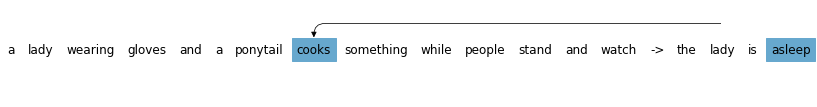


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A lady wearing gloves, and a ponytail cooks something while people stand and watch.', 'The lady is asleep']
gold label: contradiction
pred label: contradiction
explanations: [(('cooks',), ('lady', 'asleep')), (('cooks', 'people'), ('asleep',)), (('cooks', 'something'), ('asleep',)), (('ponytail', 'cooks'), ('asleep',)), (('gloves', 'cooks'), ('asleep',)), (('cooks', 'while'), ('asleep',)), (('cooks', 'watch'), ('asleep',)), (('and', 'cooks'), ('asleep',)), (('cooks',), ('the', 'asleep')), (('wearing', 'cooks'), ('asleep',))]
interactions_vote: [(['cooks'], ['asleep'])]
interactions_union: [(['cooks'], ['asleep'])]


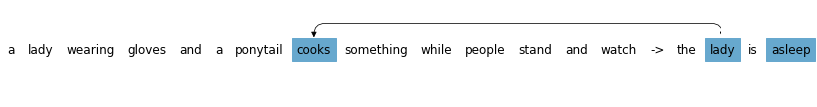


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A lady wearing gloves, and a ponytail cooks something while people stand and watch.', 'The lady is asleep']
gold label: contradiction
pred label: contradiction
explanations: [(('cooks',), ('the', 'lady', 'asleep')), (('cooks', 'people'), ('lady', 'asleep')), (('cooks', 'people'), ('the', 'asleep')), (('ponytail', 'cooks', 'people'), ('asleep',)), (('cooks', 'something'), ('lady', 'asleep')), (('ponytail', 'cooks'), ('the', 'asleep')), (('ponytail', 'cooks'), ('lady', 'asleep')), (('gloves', 'cooks'), ('lady', 'asleep')), (('gloves', 'cooks', 'people'), ('asleep',)), (('and', 'ponytail', 'cooks'), ('asleep',)), (('wearing', 'cooks'), ('lady', 'asleep')), (('cooks', 'something', 'people'), ('asleep',)), (('wearing', 'cooks', 'people'), ('asleep',)), (('cooks', 'while'), ('lady', 'asleep')), (('and', 'cooks', 'people'), ('asleep',)), (('gloves', 'and', 'cooks'), ('asleep',)), (('and', 'cooks'), ('l

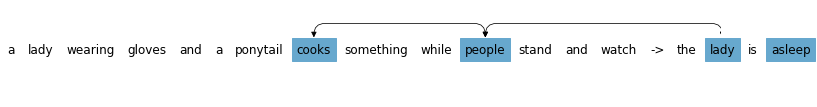

In [5]:
for idx in df[['Sentence1', 'Sentence2', 'gold_label']].sample(38).index.tolist():
    print(f'############################ {idx} #################################')
    exp_files = ['bert-base_lime-5000_test_BT=[MASK].json',
                'bert-base_arch-5_test_BT=[MASK].json',
                'bert-base_cross_arch-5_test_BT=[MASK]_X.json',
                'bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json',
                'bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json',
                'bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json',
                ]
    for exp_file in exp_files:
        print()
        print(exp_file)
        with open(f'../explanations/{exp_file}', 'r') as f:
            explanations = json.load(f)

        analyze_explanation(df, explanations, idx, topk=None if 'lime' in exp_file else 1, no_main='lime' not in exp_file)

In [59]:
df[['Sentence1', 'Sentence2', 'gold_label']].sample(38).index

Sentence1  \
508                                                                                                                  Soldiers are holding guns and peeking around a building.   
705                                                                                                                  A man cooking with fire in like 5 pots at the same time!   
900                                                                                                                                 kids are looking at something on a table.   
235                                                                                       A group of women observing an event while one in military attire takes a photograph   
779                                                                                                                                    A man wearing a hat and carrying a bag   
299                                                                        Young woman is putting her clothes in the dryer portion of a double stacked washer and dryer unit.   
743                                                                                            A cyclist in a red and white uniform is biking across a garage full of people.   
175                                                                                                                                               Workers standing on a lift.   
995                                                                                                       A man in a green shirt hovers above the ground in the laundry room.   
346                                                                                                                                        A boy rollerskating in the street.   
117                                                                            A young man is standing near his bike outside a shop called, 'Sara's Old Fashioned Ice Cream.'   
333                                                          A young Asian child stands at the top of some steps and does n't seem to notice the person taking their picture.   
67                                                                                                    There is a group of children getting their picture taken with presents.   
400                                        A crowd in which two men are wearing Santa Claus Hats are celebrating Christmas outside of a Bank of America and a Christmas tree.   
676                                                                                                                     A man wearing red sunglasses is carrying two cameras.   
986                                                                          Four young men stare up at a basketball hoop with no net, in an outdoor, urban basketball court.   
857                                                                                                                 A lady in a white tank and shorts fixing a wooden drawer.   
318                                                                                                       A large group of protesters are walking down the street with signs.   
114                                                                                                                          A dog and a cat are swimming in a swimming pool.   
471                                                                     A man in a jacket is standing in a gas station, next to a car and lights are shining in the distance.   
807                                                                                                                              A dog is pulling a red sled across the snow.   
216                                                         Two African American men laughing with aprons on, while a third man wearing a chef jacket is on a cellular phone.   
631                                                                                          

## Top Bottom

190 score 1.0
bert-base_arch-5_test_BT=[MASK].json
texts: ['A young woman with red-hair is adjusting a blue bracelet on an older woman with short hair.', 'Two women are making pancakes.']
gold label: contradiction
pred label: contradiction
explanations: [(('adjusting', 'bracelet'), ('two', 'women', 'making', 'pancakes'))]
interactions_vote: [(['adjusting'], ['making', 'pancakes']), (['bracelet'], ['making', 'pancakes'])]
interactions_union: [(['adjusting', 'a', 'blue', 'bracelet'], ['making', 'pancakes'])]


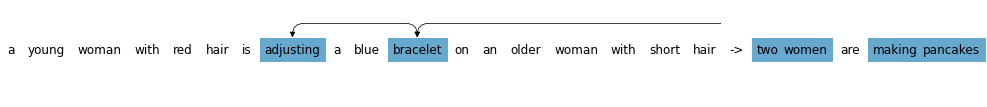





bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A young woman with red-hair is adjusting a blue bracelet on an older woman with short hair.', 'Two women are making pancakes.']
gold label: contradiction
pred label: contradiction
explanations: [(('bracelet',), ('pancakes',)), (('adjusting',), ('pancakes',)), (('woman',), ('pancakes',)), (('hair',), ('pancakes',)), ((), ('pancakes',))]
interactions_vote: [(['adjusting'], ['making', 'pancakes']), (['bracelet'], ['making', 'pancakes'])]
interactions_union: [(['adjusting', 'a', 'blue', 'bracelet'], ['making', 'pancakes'])]


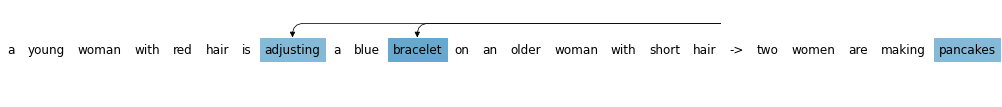





bert-base_lime-5000_test_BT=[MASK].json
texts: ['A young woman with red-hair is adjusting a blue bracelet on an older woman with short hair.', 'Two women are making pancakes.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('pancakes',)), ((), ('women',)), (('bracelet',), ()), (('young',), ()), (('a',), ()), (('on',), ()), ((), ('are',)), (('is',), ()), (('A',), ())]
interactions_vote: [(['adjusting'], ['making', 'pancakes']), (['bracelet'], ['making', 'pancakes'])]
interactions_union: [(['adjusting', 'a', 'blue', 'bracelet'], ['making', 'pancakes'])]


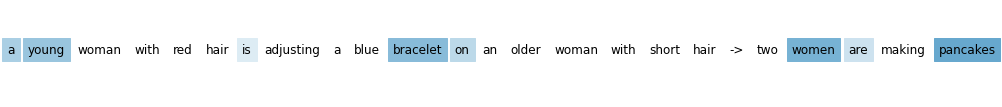





bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A young woman with red-hair is adjusting a blue bracelet on an older woman with short hair.', 'Two women are making pancakes.']
gold label: contradiction
pred label: contradiction
explanations: [(('bracelet',), ('pancakes',)), (('adjusting',), ('pancakes',)), (('short',), ('pancakes',)), (('young',), ('pancakes',)), (('an',), ('pancakes',)), (('hair',), ('pancakes',)), (('on',), ('pancakes',)), (('woman',), ('pancakes',)), (('a',), ('pancakes',)), (('with',), ('pancakes',)), (('red',), ('pancakes',)), (('older',), ('pancakes',)), (('is',), ('pancakes',)), (('blue',), ('pancakes',)), (('bracelet',), ('are',)), (('short',), ('are',))]
interactions_vote: [(['adjusting'], ['making', 'pancakes']), (['bracelet'], ['making', 'pancakes'])]
interactions_union: [(['adjusting', 'a', 'blue', 'bracelet'], ['making', 'pancakes'])]


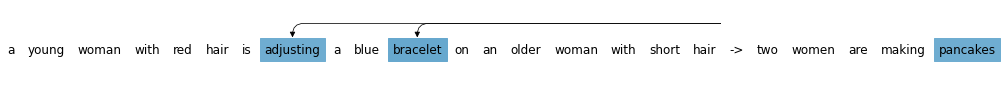





bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A young woman with red-hair is adjusting a blue bracelet on an older woman with short hair.', 'Two women are making pancakes.']
gold label: contradiction
pred label: contradiction
explanations: [(('bracelet',), ('making', 'pancakes')), (('adjusting',), ('making', 'pancakes')), (('hair',), ('making', 'pancakes')), (('bracelet',), ('women', 'pancakes')), (('adjusting', 'bracelet'), ('pancakes',)), (('bracelet', 'on'), ('pancakes',)), (('bracelet',), ('two', 'pancakes')), (('bracelet', 'short'), ('pancakes',)), (('a', 'bracelet'), ('pancakes',))]
interactions_vote: [(['adjusting'], ['making', 'pancakes']), (['bracelet'], ['making', 'pancakes'])]
interactions_union: [(['adjusting', 'a', 'blue', 'bracelet'], ['making', 'pancakes'])]


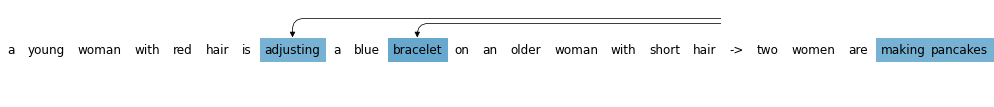





bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A young woman with red-hair is adjusting a blue bracelet on an older woman with short hair.', 'Two women are making pancakes.']
gold label: contradiction
pred label: contradiction
explanations: [(('adjusting', 'bracelet'), ('making', 'pancakes')), (('bracelet', 'short'), ('making', 'pancakes')), (('bracelet', 'an'), ('making', 'pancakes')), (('bracelet',), ('two', 'making', 'pancakes')), (('a', 'bracelet'), ('making', 'pancakes')), (('bracelet', 'hair'), ('making', 'pancakes')), (('bracelet', 'on'), ('making', 'pancakes')), (('adjusting', 'hair'), ('making', 'pancakes')), (('woman', 'bracelet'), ('making', 'pancakes')), (('red', 'bracelet'), ('making', 'pancakes')), (('bracelet', 'woman'), ('making', 'pancakes')), (('bracelet', 'with'), ('making', 'pancakes')), (('hair', 'bracelet'), ('making', 'pancakes')), (('bracelet',), ('women', 'making', 'pancakes')), (('with', 'bracelet'), ('making', '

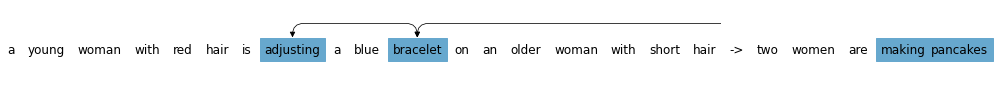





462 score 1.0
bert-base_arch-5_test_BT=[MASK].json
texts: ['Two girls are playing in the snow and throwing snowballs.', 'Two girls are somewhere cold.']
gold label: entailment
pred label: entailment
explanations: [(('snow', 'snowballs'), ('are', 'somewhere', 'cold'))]
interactions_vote: [(['playing'], ['Two', 'girls']), (['playing'], ['somewhere', 'cold']), (['snow'], ['Two', 'girls']), (['snow'], ['somewhere', 'cold']), (['snowballs'], ['Two', 'girls']), (['snowballs'], ['somewhere', 'cold'])]
interactions_union: [(['Two', 'girls'], ['Two', 'girls']), (['Two', 'girls'], ['somewhere', 'cold']), (['playing', 'in', 'the', 'snow'], ['Two', 'girls']), (['playing', 'in', 'the', 'snow'], ['somewhere', 'cold']), (['throwing', 'snowballs'], ['Two', 'girls']), (['throwing', 'snowballs'], ['somewhere', 'cold'])]


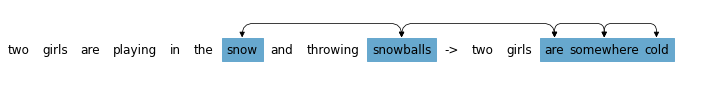





bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['Two girls are playing in the snow and throwing snowballs.', 'Two girls are somewhere cold.']
gold label: entailment
pred label: entailment
explanations: [(('snow', 'snowballs'), ('cold',)), (('girls',), ('girls',)), (('in', 'snow'), ('somewhere',))]
interactions_vote: [(['playing'], ['Two', 'girls']), (['playing'], ['somewhere', 'cold']), (['snow'], ['Two', 'girls']), (['snow'], ['somewhere', 'cold']), (['snowballs'], ['Two', 'girls']), (['snowballs'], ['somewhere', 'cold'])]
interactions_union: [(['Two', 'girls'], ['Two', 'girls']), (['Two', 'girls'], ['somewhere', 'cold']), (['playing', 'in', 'the', 'snow'], ['Two', 'girls']), (['playing', 'in', 'the', 'snow'], ['somewhere', 'cold']), (['throwing', 'snowballs'], ['Two', 'girls']), (['throwing', 'snowballs'], ['somewhere', 'cold'])]


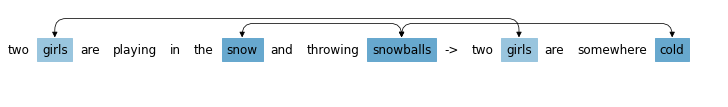





bert-base_lime-5000_test_BT=[MASK].json
texts: ['Two girls are playing in the snow and throwing snowballs.', 'Two girls are somewhere cold.']
gold label: entailment
pred label: entailment
explanations: [((), ('somewhere',)), (('snow',), ()), (('girls',), ()), ((), ('Two',)), (('snowballs',), ()), ((), ('are',)), ((), ()), (('the',), ()), (('in',), ()), (('and',), ())]
interactions_vote: [(['playing'], ['Two', 'girls']), (['playing'], ['somewhere', 'cold']), (['snow'], ['Two', 'girls']), (['snow'], ['somewhere', 'cold']), (['snowballs'], ['Two', 'girls']), (['snowballs'], ['somewhere', 'cold'])]
interactions_union: [(['Two', 'girls'], ['Two', 'girls']), (['Two', 'girls'], ['somewhere', 'cold']), (['playing', 'in', 'the', 'snow'], ['Two', 'girls']), (['playing', 'in', 'the', 'snow'], ['somewhere', 'cold']), (['throwing', 'snowballs'], ['Two', 'girls']), (['throwing', 'snowballs'], ['somewhere', 'cold'])]


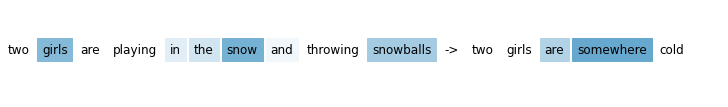





bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Two girls are playing in the snow and throwing snowballs.', 'Two girls are somewhere cold.']
gold label: entailment
pred label: entailment
explanations: [(('snow',), ('somewhere',)), (('snowballs',), ('somewhere',)), (('girls',), ('somewhere',)), (('the',), ('somewhere',)), (('in',), ('somewhere',)), (('are',), ('somewhere',)), (('throwing',), ('somewhere',)), (('and',), ('somewhere',)), (('two',), ('somewhere',)), (('playing',), ('somewhere',)), (('snowballs',), ('cold',)), (('girls',), ('girls',)), (('snow',), ('cold',)), (('girls',), ('two',)), (('snowballs',), ('are',)), (('snowballs',), ('two',)), (('snow',), ('two',)), (('snow',), ('are',)), (('two',), ('two',))]
interactions_vote: [(['playing'], ['Two', 'girls']), (['playing'], ['somewhere', 'cold']), (['snow'], ['Two', 'girls']), (['snow'], ['somewhere', 'cold']), (['snowballs'], ['Two', 'girls']), (['snowballs'], ['somewhere', 'cold'])]
interac

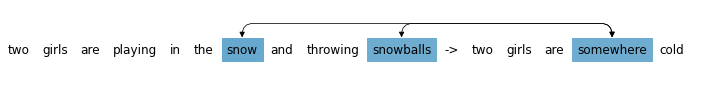





bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Two girls are playing in the snow and throwing snowballs.', 'Two girls are somewhere cold.']
gold label: entailment
pred label: entailment
explanations: [(('snow',), ('somewhere', 'cold')), (('snowballs',), ('somewhere', 'cold')), (('girls', 'snow'), ('somewhere',)), (('girls', 'snowballs'), ('somewhere',)), (('snowballs',), ('are', 'somewhere')), (('snow',), ('are', 'somewhere')), (('girls',), ('somewhere', 'cold')), (('girls',), ('are', 'somewhere')), (('girls',), ('two', 'somewhere')), (('the', 'snow'), ('somewhere',))]
interactions_vote: [(['playing'], ['Two', 'girls']), (['playing'], ['somewhere', 'cold']), (['snow'], ['Two', 'girls']), (['snow'], ['somewhere', 'cold']), (['snowballs'], ['Two', 'girls']), (['snowballs'], ['somewhere', 'cold'])]
interactions_union: [(['Two', 'girls'], ['Two', 'girls']), (['Two', 'girls'], ['somewhere', 'cold']), (['playing', 'in', 'the', 'snow'], ['Two', 'girls']), 

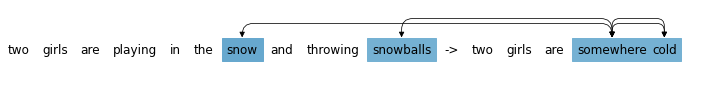





bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['Two girls are playing in the snow and throwing snowballs.', 'Two girls are somewhere cold.']
gold label: entailment
pred label: entailment
explanations: [(('girls', 'snow'), ('somewhere', 'cold')), (('snowballs',), ('are', 'somewhere', 'cold')), (('snow',), ('are', 'somewhere', 'cold')), (('girls', 'snowballs'), ('somewhere', 'cold')), (('girls', 'snow'), ('are', 'somewhere')), (('girls', 'snowballs'), ('are', 'somewhere')), (('snow', 'snowballs'), ('somewhere', 'cold')), (('in', 'snow'), ('somewhere', 'cold')), (('the', 'snow'), ('somewhere', 'cold')), (('snow',), ('two', 'somewhere', 'cold')), (('are', 'snow'), ('somewhere', 'cold')), (('the', 'snowballs'), ('somewhere', 'cold')), (('in', 'snowballs'), ('somewhere', 'cold')), (('are', 'snowballs'), ('somewhere', 'cold')), (('snowballs',), ('two', 'somewhere', 'cold')), (('and', 'snowballs'), ('somewhere', 'cold')), (('girls', 'are', 'snow')

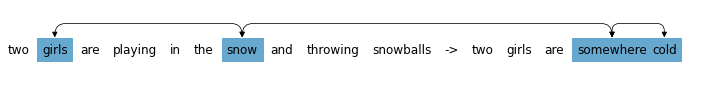





523 score 1.0
bert-base_arch-5_test_BT=[MASK].json
texts: ['3 people are shopping in a market.', 'The three people are watching television together.']
gold label: contradiction
pred label: contradiction
explanations: [(('people', 'shopping', 'market'), ('watching', 'television'))]
interactions_vote: [(['shopping'], ['watching', 'television']), (['market'], ['watching', 'television'])]
interactions_union: [(['people'], ['people']), (['people'], ['watching', 'television', 'together']), (['shopping'], ['people']), (['shopping'], ['watching', 'television', 'together']), (['market'], ['people']), (['market'], ['watching', 'television', 'together'])]


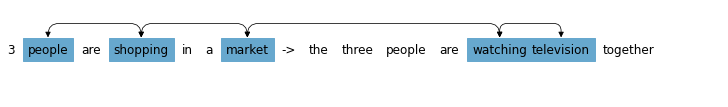





bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['3 people are shopping in a market.', 'The three people are watching television together.']
gold label: contradiction
pred label: contradiction
explanations: [(('3', 'market'), ('three', 'television')), (('shopping',), ('television',))]
interactions_vote: [(['shopping'], ['watching', 'television']), (['market'], ['watching', 'television'])]
interactions_union: [(['people'], ['people']), (['people'], ['watching', 'television', 'together']), (['shopping'], ['people']), (['shopping'], ['watching', 'television', 'together']), (['market'], ['people']), (['market'], ['watching', 'television', 'together'])]


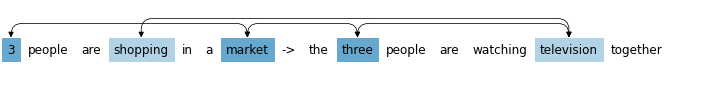





bert-base_lime-5000_test_BT=[MASK].json
texts: ['3 people are shopping in a market.', 'The three people are watching television together.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('television',)), ((), ('three',)), (('shopping',), ()), (('market',), ()), ((), ('watching',)), ((), ('The',)), ((), ()), (('people',), ()), (('in',), ()), ((), ('people',)), (('are',), ()), ((), ('are',)), (('a',), ())]
interactions_vote: [(['shopping'], ['watching', 'television']), (['market'], ['watching', 'television'])]
interactions_union: [(['people'], ['people']), (['people'], ['watching', 'television', 'together']), (['shopping'], ['people']), (['shopping'], ['watching', 'television', 'together']), (['market'], ['people']), (['market'], ['watching', 'television', 'together'])]


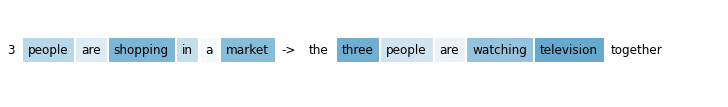





bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['3 people are shopping in a market.', 'The three people are watching television together.']
gold label: contradiction
pred label: contradiction
explanations: [(('market',), ('television',)), (('shopping',), ('television',)), (('are',), ('television',)), (('in',), ('television',)), (('a',), ('television',)), (('people',), ('television',)), (('3',), ('television',)), (('shopping',), ('watching',)), (('shopping',), ('three',)), (('market',), ('watching',)), (('shopping',), ('are',)), (('market',), ('three',)), (('shopping',), ('together',)), (('shopping',), ('the',)), (('shopping',), ('people',)), (('are',), ('watching',)), (('market',), ('together',)), (('in',), ('three',)), (('a',), ('three',)), (('market',), ('are',))]
interactions_vote: [(['shopping'], ['watching', 'television']), (['market'], ['watching', 'television'])]
interactions_union: [(['people'], ['people']), (['people'], ['watching', 'televisi

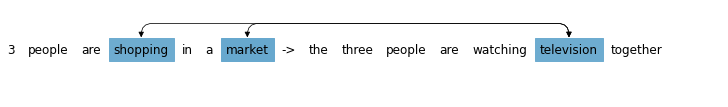





bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['3 people are shopping in a market.', 'The three people are watching television together.']
gold label: contradiction
pred label: contradiction
explanations: [(('market',), ('watching', 'television')), (('shopping',), ('watching', 'television')), (('market',), ('television', 'together')), (('shopping',), ('television', 'together')), (('shopping', 'market'), ('television',)), (('market',), ('people', 'television')), (('market',), ('the', 'television')), (('market',), ('three', 'television')), (('a', 'market'), ('television',)), (('shopping',), ('three', 'television'))]
interactions_vote: [(['shopping'], ['watching', 'television']), (['market'], ['watching', 'television'])]
interactions_union: [(['people'], ['people']), (['people'], ['watching', 'television', 'together']), (['shopping'], ['people']), (['shopping'], ['watching', 'television', 'together']), (['market'], ['people']), (['market'], ['watching',

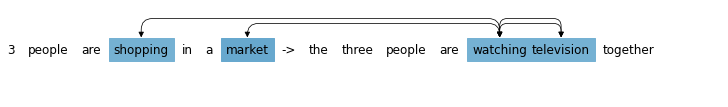





bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['3 people are shopping in a market.', 'The three people are watching television together.']
gold label: contradiction
pred label: contradiction
explanations: [(('shopping', 'market'), ('watching', 'television')), (('market',), ('watching', 'television', 'together')), (('a', 'market'), ('watching', 'television')), (('people', 'market'), ('watching', 'television')), (('market',), ('three', 'watching', 'television')), (('market',), ('people', 'watching', 'television')), (('are', 'market'), ('watching', 'television')), (('market',), ('the', 'watching', 'television')), (('in', 'market'), ('watching', 'television')), (('shopping', 'market'), ('television', 'together')), (('shopping',), ('watching', 'television', 'together')), (('market',), ('are', 'watching', 'television')), (('3', 'market'), ('watching', 'television')), (('shopping',), ('three', 'watching', 'television')), (('people', 'shopping'), 

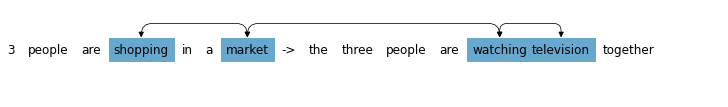





0 score 0.8333333333333333
bert-base_arch-5_test_BT=[MASK].json
texts: ['A man with a striped black and white shirt and a helmet cleans wooden floor while another one helps him on the background.', 'The man is referring a floor cleaner battle.']
gold label: contradiction
pred label: contradiction
explanations: []
interactions_vote: [(['cleans'], ['battle'])]
interactions_union: [(['cleans'], ['referring']), (['cleans'], ['floor', 'cleaner', 'battle']), (['helps'], ['referring']), (['helps'], ['floor', 'cleaner', 'battle'])]


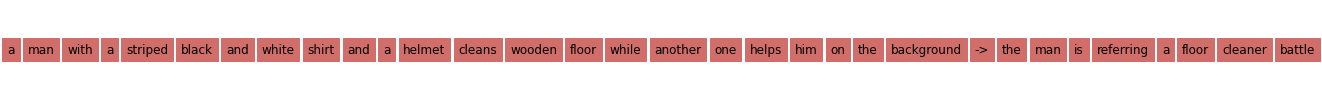





bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A man with a striped black and white shirt and a helmet cleans wooden floor while another one helps him on the background.', 'The man is referring a floor cleaner battle.']
gold label: contradiction
pred label: contradiction
explanations: [(('cleans',), ('battle',)), (('floor',), ('referring',))]
interactions_vote: [(['cleans'], ['battle'])]
interactions_union: [(['cleans'], ['referring']), (['cleans'], ['floor', 'cleaner', 'battle']), (['helps'], ['referring']), (['helps'], ['floor', 'cleaner', 'battle'])]


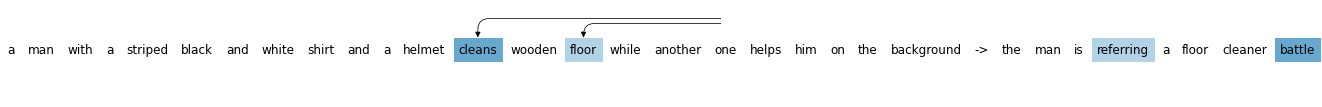





bert-base_lime-5000_test_BT=[MASK].json
texts: ['A man with a striped black and white shirt and a helmet cleans wooden floor while another one helps him on the background.', 'The man is referring a floor cleaner battle.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('battle',)), (('cleans',), ()), (('helps',), ()), (('helmet',), ()), (('striped',), ()), (('and',), ()), (('with',), ()), (('the',), ()), (('background',), ())]
interactions_vote: [(['cleans'], ['battle'])]
interactions_union: [(['cleans'], ['referring']), (['cleans'], ['floor', 'cleaner', 'battle']), (['helps'], ['referring']), (['helps'], ['floor', 'cleaner', 'battle'])]


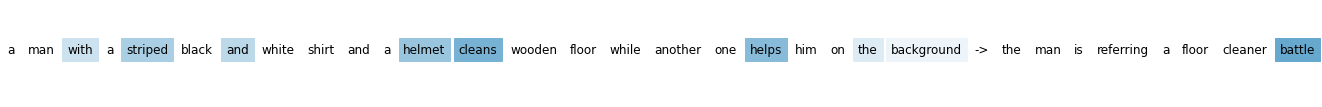





bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A man with a striped black and white shirt and a helmet cleans wooden floor while another one helps him on the background.', 'The man is referring a floor cleaner battle.']
gold label: contradiction
pred label: contradiction
explanations: [(('cleans',), ('battle',)), (('helps',), ('battle',)), (('while',), ('battle',)), (('black',), ('battle',)), (('on',), ('battle',)), (('shirt',), ('battle',)), (('striped',), ('battle',)), (('white',), ('battle',)), (('man',), ('battle',)), (('and',), ('battle',)), (('the',), ('battle',)), (('one',), ('battle',)), (('background',), ('battle',)), (('a',), ('battle',)), (('him',), ('battle',)), (('with',), ('battle',))]
interactions_vote: [(['cleans'], ['battle'])]
interactions_union: [(['cleans'], ['referring']), (['cleans'], ['floor', 'cleaner', 'battle']), (['helps'], ['referring']), (['helps'], ['floor', 'cleaner', 'battle'])]


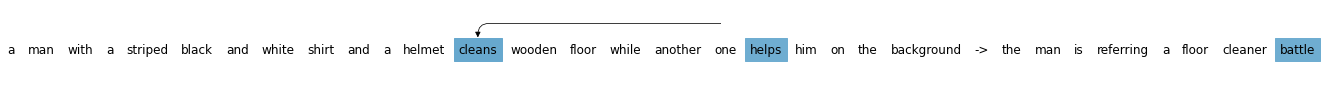





bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A man with a striped black and white shirt and a helmet cleans wooden floor while another one helps him on the background.', 'The man is referring a floor cleaner battle.']
gold label: contradiction
pred label: contradiction
explanations: [(('cleans', 'helps'), ('battle',)), (('cleans',), ('battle',)), (('a', 'cleans'), ('battle',)), (('and', 'cleans'), ('battle',)), (('striped', 'cleans'), ('battle',)), (('cleans',), ('man', 'battle')), (('cleans', 'while'), ('battle',)), (('cleans',), ('floor', 'battle')), (('cleans', 'background'), ('battle',))]
interactions_vote: [(['cleans'], ['battle'])]
interactions_union: [(['cleans'], ['referring']), (['cleans'], ['floor', 'cleaner', 'battle']), (['helps'], ['referring']), (['helps'], ['floor', 'cleaner', 'battle'])]


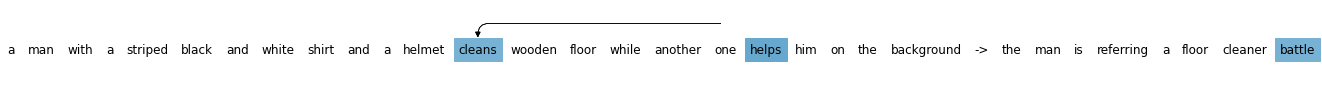





bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A man with a striped black and white shirt and a helmet cleans wooden floor while another one helps him on the background.', 'The man is referring a floor cleaner battle.']
gold label: contradiction
pred label: contradiction
explanations: [(('cleans', 'helps', 'the'), ('battle',)), (('cleans', 'helps'), ('floor', 'battle')), (('striped', 'cleans', 'helps'), ('battle',)), (('cleans', 'while', 'helps'), ('battle',)), (('cleans', 'helps'), ('man', 'battle')), (('cleans', 'helps'), ('battle',)), (('man', 'cleans', 'helps'), ('battle',)), (('black', 'cleans', 'helps'), ('battle',)), (('shirt', 'cleans', 'helps'), ('battle',)), (('white', 'cleans', 'helps'), ('battle',)), (('cleans', 'another', 'helps'), ('battle',)), (('and', 'cleans', 'helps'), ('battle',)), (('cleans', 'helps', 'on'), ('battle',)), (('with', 'cleans', 'helps'), ('battle',)), (('cleans', 'helps', 'background'), ('battle',)), (('c

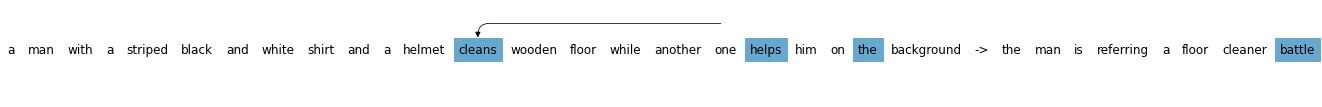





341 score 0.8333333333333333
bert-base_arch-5_test_BT=[MASK].json
texts: ['A guy in glasses is biting into a pink marshmallow chick while somebody else is puckering their lips out wanting a bite.', 'A man is eating a marshmallow.']
gold label: entailment
pred label: entailment
explanations: [(('marshmallow',), ('marshmallow',)), ((), ('a', 'is', 'a')), (('guy', 'chick'), ('man',))]
interactions_vote: [(['guy'], ['man']), (['guy'], ['eating']), (['guy'], ['marshmallow']), (['biting'], ['man']), (['biting'], ['eating']), (['biting'], ['marshmallow']), (['marshmallow'], ['man']), (['marshmallow'], ['eating']), (['marshmallow'], ['marshmallow'])]
interactions_union: [(['guy'], ['man']), (['guy'], ['eating']), (['guy'], ['marshmallow']), (['biting'], ['man']), (['biting'], ['eating']), (['biting'], ['marshmallow']), (['marshmallow'], ['man']), (['marshmallow'], ['eating']), (['marshmallow'], ['marshmallow'])]


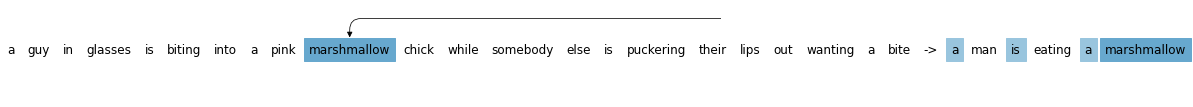





bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A guy in glasses is biting into a pink marshmallow chick while somebody else is puckering their lips out wanting a bite.', 'A man is eating a marshmallow.']
gold label: entailment
pred label: entailment
explanations: [(('marshmallow',), ('marshmallow',)), (('guy',), ('man',)), (('marshmallow',), ('eating',))]
interactions_vote: [(['guy'], ['man']), (['guy'], ['eating']), (['guy'], ['marshmallow']), (['biting'], ['man']), (['biting'], ['eating']), (['biting'], ['marshmallow']), (['marshmallow'], ['man']), (['marshmallow'], ['eating']), (['marshmallow'], ['marshmallow'])]
interactions_union: [(['guy'], ['man']), (['guy'], ['eating']), (['guy'], ['marshmallow']), (['biting'], ['man']), (['biting'], ['eating']), (['biting'], ['marshmallow']), (['marshmallow'], ['man']), (['marshmallow'], ['eating']), (['marshmallow'], ['marshmallow'])]


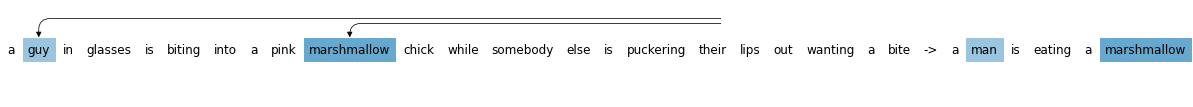





bert-base_lime-5000_test_BT=[MASK].json
texts: ['A guy in glasses is biting into a pink marshmallow chick while somebody else is puckering their lips out wanting a bite.', 'A man is eating a marshmallow.']
gold label: entailment
pred label: entailment
explanations: [(('marshmallow',), ()), (('guy',), ()), ((), ('marshmallow',)), (('bite',), ()), ((), ('A',)), (('while',), ()), ((), ('a',)), (('biting',), ()), (('into',), ()), (('is',), ())]
interactions_vote: [(['guy'], ['man']), (['guy'], ['eating']), (['guy'], ['marshmallow']), (['biting'], ['man']), (['biting'], ['eating']), (['biting'], ['marshmallow']), (['marshmallow'], ['man']), (['marshmallow'], ['eating']), (['marshmallow'], ['marshmallow'])]
interactions_union: [(['guy'], ['man']), (['guy'], ['eating']), (['guy'], ['marshmallow']), (['biting'], ['man']), (['biting'], ['eating']), (['biting'], ['marshmallow']), (['marshmallow'], ['man']), (['marshmallow'], ['eating']), (['marshmallow'], ['marshmallow'])]


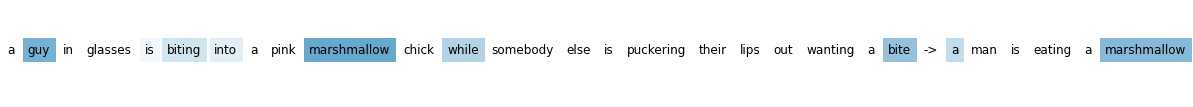





bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A guy in glasses is biting into a pink marshmallow chick while somebody else is puckering their lips out wanting a bite.', 'A man is eating a marshmallow.']
gold label: entailment
pred label: entailment
explanations: [(('marshmallow',), ('marshmallow',)), (('marshmallow',), ('a',)), (('marshmallow',), ('is',)), (('guy',), ('marshmallow',)), (('guy',), ('man',)), (('guy',), ('a',)), (('guy',), ('is',)), (('bite',), ('marshmallow',)), (('biting',), ('marshmallow',))]
interactions_vote: [(['guy'], ['man']), (['guy'], ['eating']), (['guy'], ['marshmallow']), (['biting'], ['man']), (['biting'], ['eating']), (['biting'], ['marshmallow']), (['marshmallow'], ['man']), (['marshmallow'], ['eating']), (['marshmallow'], ['marshmallow'])]
interactions_union: [(['guy'], ['man']), (['guy'], ['eating']), (['guy'], ['marshmallow']), (['biting'], ['man']), (['biting'], ['eating']), (['biting'], ['marshmallow']), (['marsh

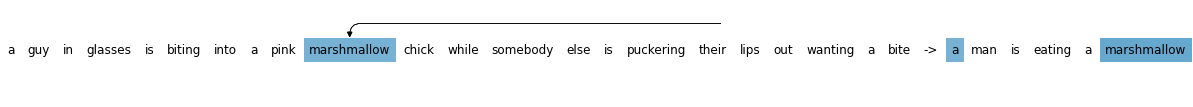





bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A guy in glasses is biting into a pink marshmallow chick while somebody else is puckering their lips out wanting a bite.', 'A man is eating a marshmallow.']
gold label: entailment
pred label: entailment
explanations: [(('guy', 'marshmallow'), ('marshmallow',)), (('marshmallow',), ('marshmallow',)), (('guy', 'marshmallow'), ('man',)), (('marshmallow',), ('a',)), (('guy', 'marshmallow'), ('a',))]
interactions_vote: [(['guy'], ['man']), (['guy'], ['eating']), (['guy'], ['marshmallow']), (['biting'], ['man']), (['biting'], ['eating']), (['biting'], ['marshmallow']), (['marshmallow'], ['man']), (['marshmallow'], ['eating']), (['marshmallow'], ['marshmallow'])]
interactions_union: [(['guy'], ['man']), (['guy'], ['eating']), (['guy'], ['marshmallow']), (['biting'], ['man']), (['biting'], ['eating']), (['biting'], ['marshmallow']), (['marshmallow'], ['man']), (['marshmallow'], ['eating']), (['marshmallow'], ['m

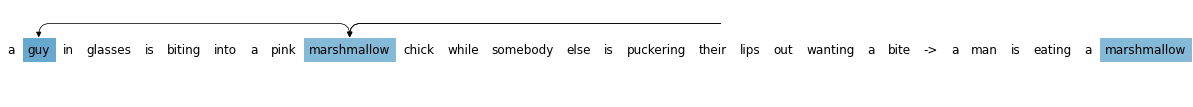





bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A guy in glasses is biting into a pink marshmallow chick while somebody else is puckering their lips out wanting a bite.', 'A man is eating a marshmallow.']
gold label: entailment
pred label: entailment
explanations: [(('guy', 'marshmallow'), ('marshmallow',)), (('guy', 'marshmallow'), ('a',)), (('guy', 'biting', 'marshmallow'), ('marshmallow',)), (('guy', 'marshmallow', 'bite'), ('marshmallow',)), (('guy', 'marshmallow', 'bite'), ('a',)), (('marshmallow', 'bite'), ('marshmallow',)), (('marshmallow',), ('marshmallow',)), (('guy', 'marshmallow'), ('man',)), (('guy', 'biting', 'marshmallow'), ('man',)), (('guy', 'biting', 'marshmallow'), ('a',)), (('biting', 'marshmallow'), ('marshmallow',)), (('guy', 'pink', 'marshmallow'), ('marshmallow',)), (('guy', 'marshmallow', 'their'), ('marshmallow',))]
interactions_vote: [(['guy'], ['man']), (['guy'], ['eating']), (['guy'], ['marshmallow']), (['biting

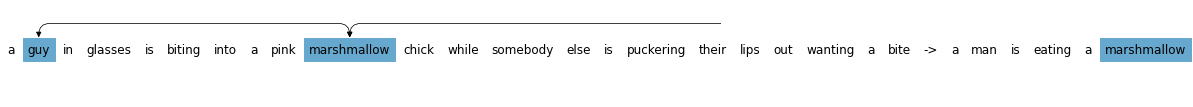





779 score 0.0
bert-base_arch-5_test_BT=[MASK].json
texts: ['A man wearing a hat and carrying a bag', 'A man is walking empty handed.']
gold label: contradiction
pred label: contradiction
explanations: [(('wearing', 'carrying'), ('empty', 'handed'))]
interactions_vote: [(['carrying', 'a', 'bag'], ['empty', 'handed'])]
interactions_union: [(['carrying', 'a', 'bag'], ['walking', 'empty', 'handed'])]


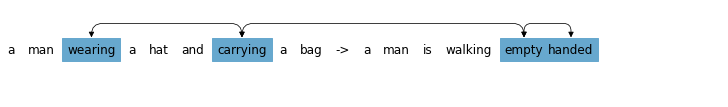





bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A man wearing a hat and carrying a bag', 'A man is walking empty handed.']
gold label: contradiction
pred label: contradiction
explanations: [(('carrying', 'bag'), ('empty', 'handed')), (('wearing',), ('handed',))]
interactions_vote: [(['carrying', 'a', 'bag'], ['empty', 'handed'])]
interactions_union: [(['carrying', 'a', 'bag'], ['walking', 'empty', 'handed'])]


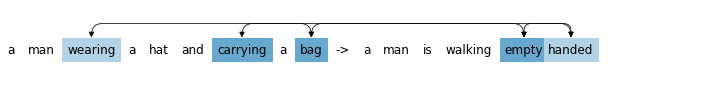





bert-base_lime-5000_test_BT=[MASK].json
texts: ['A man wearing a hat and carrying a bag', 'A man is walking empty handed.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('empty',)), ((), ('handed',)), ((), ('man',)), (('a',), ()), ((), ('walking',)), (('and',), ())]
interactions_vote: [(['carrying', 'a', 'bag'], ['empty', 'handed'])]
interactions_union: [(['carrying', 'a', 'bag'], ['walking', 'empty', 'handed'])]


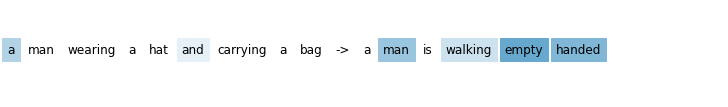





bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A man wearing a hat and carrying a bag', 'A man is walking empty handed.']
gold label: contradiction
pred label: contradiction
explanations: [(('and',), ('empty',)), (('carrying',), ('empty',)), (('hat',), ('empty',)), (('wearing',), ('empty',)), (('a',), ('empty',)), (('man',), ('empty',)), (('bag',), ('empty',)), (('wearing',), ('man',)), (('hat',), ('is',)), (('and',), ('is',)), (('wearing',), ('handed',)), (('a',), ('man',)), (('wearing',), ('is',)), (('and',), ('man',)), (('a',), ('a',)), (('a',), ('is',)), (('hat',), ('a',))]
interactions_vote: [(['carrying', 'a', 'bag'], ['empty', 'handed'])]
interactions_union: [(['carrying', 'a', 'bag'], ['walking', 'empty', 'handed'])]


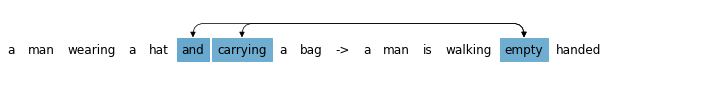





bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A man wearing a hat and carrying a bag', 'A man is walking empty handed.']
gold label: contradiction
pred label: contradiction
explanations: [(('hat',), ('empty', 'handed')), (('wearing',), ('empty', 'handed')), (('and',), ('empty', 'handed')), (('carrying',), ('empty', 'handed')), (('bag',), ('empty', 'handed')), (('man',), ('empty', 'handed')), (('a',), ('empty', 'handed')), (('and',), ('walking', 'empty'))]
interactions_vote: [(['carrying', 'a', 'bag'], ['empty', 'handed'])]
interactions_union: [(['carrying', 'a', 'bag'], ['walking', 'empty', 'handed'])]


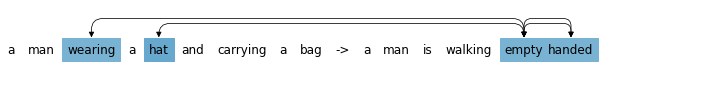





bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A man wearing a hat and carrying a bag', 'A man is walking empty handed.']
gold label: contradiction
pred label: contradiction
explanations: [(('wearing', 'hat'), ('empty', 'handed')), (('hat', 'and'), ('empty', 'handed')), (('and', 'a'), ('empty', 'handed')), (('wearing', 'a'), ('empty', 'handed')), (('wearing',), ('a', 'empty', 'handed')), (('a', 'and'), ('empty', 'handed')), (('and',), ('a', 'empty', 'handed')), (('hat',), ('is', 'empty', 'handed')), (('hat',), ('a', 'empty', 'handed')), (('wearing',), ('is', 'empty', 'handed')), (('wearing', 'and'), ('empty', 'handed')), (('hat', 'a'), ('empty', 'handed')), (('wearing', 'bag'), ('empty', 'handed')), (('man', 'hat'), ('empty', 'handed')), (('a', 'hat'), ('empty', 'handed')), (('hat', 'carrying'), ('empty', 'handed')), (('hat',), ('man', 'empty', 'handed')), (('wearing',), ('man', 'empty', 'handed'))]
interactions_vote: [(['carrying', 'a', 

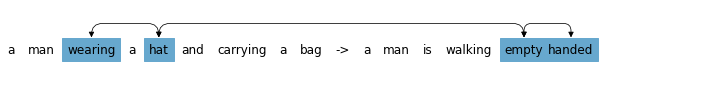





299 score 0.0
bert-base_arch-5_test_BT=[MASK].json
texts: ['Young woman is putting her clothes in the dryer portion of a double stacked washer and dryer unit.', 'Nobody is drying clothes.']
gold label: contradiction
pred label: contradiction
explanations: [(('clothes', 'dryer', 'dryer'), ('nobody', 'drying', 'clothes'))]
interactions_vote: [(['woman'], ['Nobody'])]
interactions_union: [(['Young', 'woman'], ['Nobody'])]


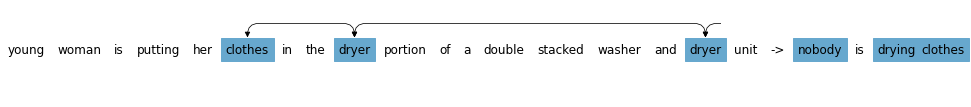





bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['Young woman is putting her clothes in the dryer portion of a double stacked washer and dryer unit.', 'Nobody is drying clothes.']
gold label: contradiction
pred label: contradiction
explanations: [(('dryer',), ('nobody', 'drying'))]
interactions_vote: [(['woman'], ['Nobody'])]
interactions_union: [(['Young', 'woman'], ['Nobody'])]


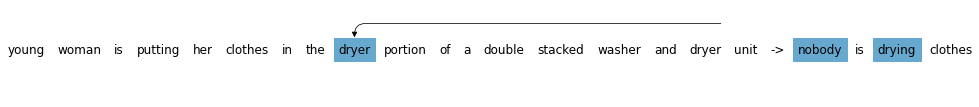





bert-base_lime-5000_test_BT=[MASK].json
texts: ['Young woman is putting her clothes in the dryer portion of a double stacked washer and dryer unit.', 'Nobody is drying clothes.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('Nobody',)), (('unit',), ()), (('washer',), ()), (('a',), ())]
interactions_vote: [(['woman'], ['Nobody'])]
interactions_union: [(['Young', 'woman'], ['Nobody'])]


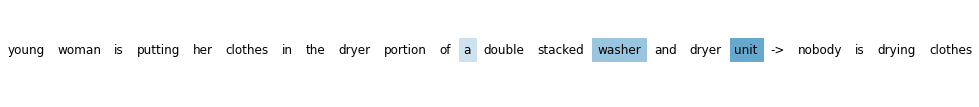





bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Young woman is putting her clothes in the dryer portion of a double stacked washer and dryer unit.', 'Nobody is drying clothes.']
gold label: contradiction
pred label: contradiction
explanations: [(('clothes',), ('nobody',)), (('putting',), ('nobody',)), (('portion',), ('nobody',)), (('young',), ('nobody',)), (('unit',), ('nobody',)), (('dryer',), ('nobody',)), (('woman',), ('nobody',)), (('washer',), ('nobody',)), (('and',), ('nobody',)), (('is',), ('nobody',)), (('a',), ('nobody',)), (('stacked',), ('nobody',)), (('double',), ('nobody',)), (('her',), ('nobody',)), (('of',), ('nobody',)), (('the',), ('nobody',)), (('in',), ('nobody',))]
interactions_vote: [(['woman'], ['Nobody'])]
interactions_union: [(['Young', 'woman'], ['Nobody'])]


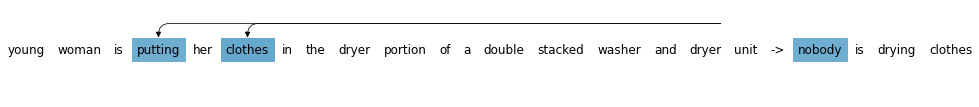





bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Young woman is putting her clothes in the dryer portion of a double stacked washer and dryer unit.', 'Nobody is drying clothes.']
gold label: contradiction
pred label: contradiction
explanations: [(('putting',), ('nobody', 'drying')), (('putting', 'clothes'), ('nobody',)), (('clothes',), ('nobody', 'is')), (('washer',), ('nobody', 'drying')), (('clothes', 'washer'), ('nobody',)), (('clothes', 'dryer'), ('nobody',)), (('clothes', 'a'), ('nobody',)), (('dryer',), ('nobody', 'drying'))]
interactions_vote: [(['woman'], ['Nobody'])]
interactions_union: [(['Young', 'woman'], ['Nobody'])]


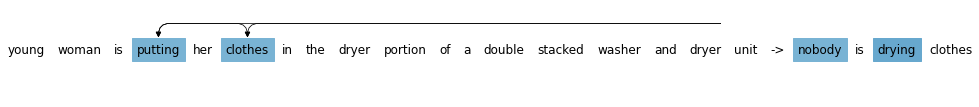





bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['Young woman is putting her clothes in the dryer portion of a double stacked washer and dryer unit.', 'Nobody is drying clothes.']
gold label: contradiction
pred label: contradiction
explanations: [(('putting', 'a'), ('nobody', 'drying')), (('putting', 'clothes'), ('nobody', 'drying')), (('putting', 'portion'), ('nobody', 'drying')), (('putting', 'washer'), ('nobody', 'drying')), (('woman', 'putting'), ('nobody', 'drying')), (('putting', 'dryer'), ('nobody', 'drying')), (('putting', 'the'), ('nobody', 'drying')), (('putting', 'and'), ('nobody', 'drying')), (('putting', 'unit'), ('nobody', 'drying')), (('putting', 'of'), ('nobody', 'drying')), (('putting', 'double'), ('nobody', 'drying')), (('young', 'putting'), ('nobody', 'drying')), (('putting', 'stacked'), ('nobody', 'drying')), (('is', 'putting'), ('nobody', 'drying')), (('putting',), ('nobody', 'is', 'drying')), (('putting', 'in'), ('nobod

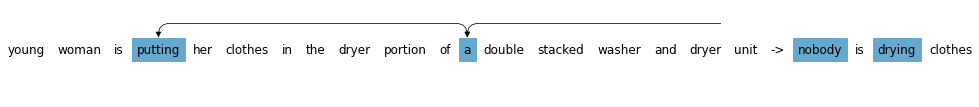





800 score 0.0
bert-base_arch-5_test_BT=[MASK].json
texts: ['People gathered around a table with food and wine on it.', 'A man is riding a bicycle down the large hill.']
gold label: contradiction
pred label: contradiction
explanations: [(('food', 'wine'), ('riding', 'bicycle')), ((), ('down', 'the', 'large'))]
interactions_vote: [(['People'], ['man'])]
interactions_union: [(['People', 'gathered', 'around', 'a', 'table'], ['man', 'is', 'riding', 'a', 'bicycle', 'down', 'the', 'large', 'hill'])]


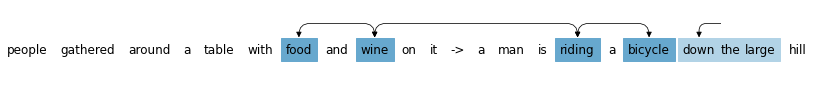





bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['People gathered around a table with food and wine on it.', 'A man is riding a bicycle down the large hill.']
gold label: contradiction
pred label: contradiction
explanations: [(('food', 'wine'), ('bicycle',)), (('food',), ('riding',)), (('table',), ('bicycle',))]
interactions_vote: [(['People'], ['man'])]
interactions_union: [(['People', 'gathered', 'around', 'a', 'table'], ['man', 'is', 'riding', 'a', 'bicycle', 'down', 'the', 'large', 'hill'])]


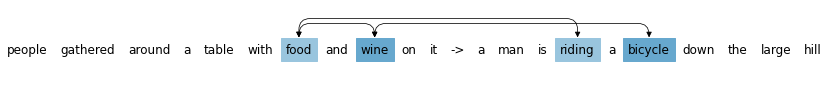





bert-base_lime-5000_test_BT=[MASK].json
texts: ['People gathered around a table with food and wine on it.', 'A man is riding a bicycle down the large hill.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('bicycle',)), ((), ('riding',)), ((), ('hill',)), ((), ('down',)), ((), ('man',)), ((), ('the',)), (('with',), ()), (('food',), ()), ((), ('large',)), (('table',), ()), (('People',), ()), (('gathered',), ()), (('wine',), ()), ((), ('a',)), (('and',), ())]
interactions_vote: [(['People'], ['man'])]
interactions_union: [(['People', 'gathered', 'around', 'a', 'table'], ['man', 'is', 'riding', 'a', 'bicycle', 'down', 'the', 'large', 'hill'])]


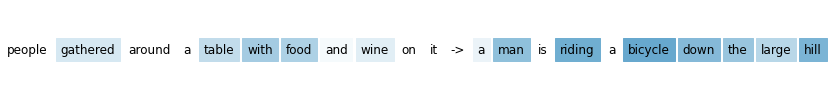





bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['People gathered around a table with food and wine on it.', 'A man is riding a bicycle down the large hill.']
gold label: contradiction
pred label: contradiction
explanations: [(('food',), ('bicycle',)), (('wine',), ('bicycle',)), (('table',), ('bicycle',)), (('gathered',), ('bicycle',)), (('table',), ('riding',)), (('table',), ('hill',)), (('food',), ('riding',)), (('wine',), ('riding',)), (('people',), ('bicycle',)), (('gathered',), ('riding',)), (('wine',), ('hill',)), (('people',), ('riding',)), (('with',), ('bicycle',)), (('food',), ('hill',)), (('with',), ('riding',)), (('a',), ('bicycle',)), (('around',), ('bicycle',)), (('it',), ('bicycle',)), (('gathered',), ('hill',)), (('people',), ('hill',))]
interactions_vote: [(['People'], ['man'])]
interactions_union: [(['People', 'gathered', 'around', 'a', 'table'], ['man', 'is', 'riding', 'a', 'bicycle', 'down', 'the', 'large', 'hill'])]


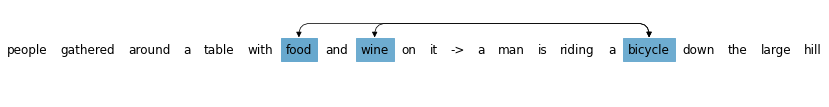





bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['People gathered around a table with food and wine on it.', 'A man is riding a bicycle down the large hill.']
gold label: contradiction
pred label: contradiction
explanations: [(('table',), ('bicycle', 'down')), (('food',), ('bicycle', 'down')), (('wine',), ('bicycle', 'down')), (('table',), ('riding', 'bicycle')), (('table',), ('riding', 'hill')), (('food',), ('riding', 'bicycle')), (('wine',), ('riding', 'bicycle')), (('wine',), ('riding', 'hill')), (('table',), ('bicycle', 'the')), (('food',), ('bicycle', 'the'))]
interactions_vote: [(['People'], ['man'])]
interactions_union: [(['People', 'gathered', 'around', 'a', 'table'], ['man', 'is', 'riding', 'a', 'bicycle', 'down', 'the', 'large', 'hill'])]


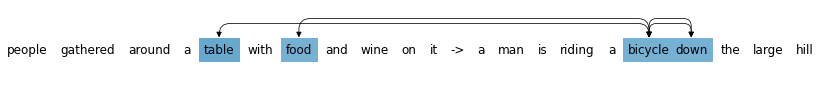





bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['People gathered around a table with food and wine on it.', 'A man is riding a bicycle down the large hill.']
gold label: contradiction
pred label: contradiction
explanations: [(('table',), ('bicycle', 'down', 'hill')), (('table',), ('bicycle', 'down', 'the')), (('wine',), ('bicycle', 'down', 'hill')), (('table',), ('riding', 'bicycle', 'down')), (('table', 'wine'), ('bicycle', 'down')), (('table', 'food'), ('bicycle', 'down')), (('food',), ('bicycle', 'down', 'hill')), (('table',), ('riding', 'bicycle', 'hill')), (('wine',), ('riding', 'bicycle', 'down')), (('table',), ('a', 'bicycle', 'down')), (('table',), ('riding', 'down', 'hill')), (('table',), ('bicycle', 'down', 'large')), (('table',), ('man', 'bicycle', 'down')), (('a', 'table'), ('bicycle', 'down')), (('table', 'wine'), ('riding', 'bicycle')), (('food',), ('bicycle', 'down', 'the')), (('table', 'wine'), ('riding', 'hill')), (('gather

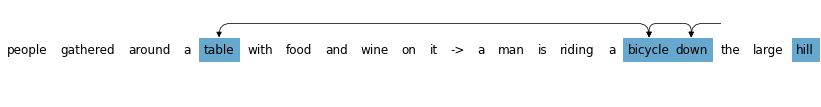





283 score 0.0
bert-base_arch-5_test_BT=[MASK].json
texts: ['a lone snowboarder jumping in midair with a snow covered mine in the background', 'A person snowboarding in mid air']
gold label: entailment
pred label: entailment
explanations: [(('snowboarder', 'snow'), ('snowboarding',))]
interactions_vote: [(['a'], ['person', 'snowboarding']), (['snowboarder', 'jumping', 'in', 'midair'], ['person', 'snowboarding'])]
interactions_union: [(['a', 'lone', 'snowboarder', 'jumping', 'in', 'midair', 'with'], ['A', 'person', 'snowboarding']), (['a', 'lone', 'snowboarder', 'jumping', 'in', 'midair', 'with'], ['mid', 'air'])]


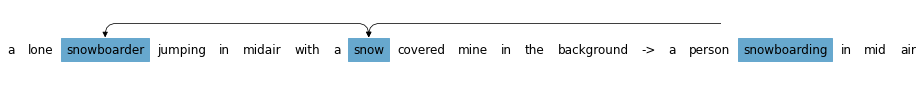





bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['a lone snowboarder jumping in midair with a snow covered mine in the background', 'A person snowboarding in mid air']
gold label: entailment
pred label: entailment
explanations: [(('snowboarder',), ('snowboarding',)), (('snow',), ('snowboarding',)), (('midair',), ('mid',))]
interactions_vote: [(['a'], ['person', 'snowboarding']), (['snowboarder', 'jumping', 'in', 'midair'], ['person', 'snowboarding'])]
interactions_union: [(['a', 'lone', 'snowboarder', 'jumping', 'in', 'midair', 'with'], ['A', 'person', 'snowboarding']), (['a', 'lone', 'snowboarder', 'jumping', 'in', 'midair', 'with'], ['mid', 'air'])]


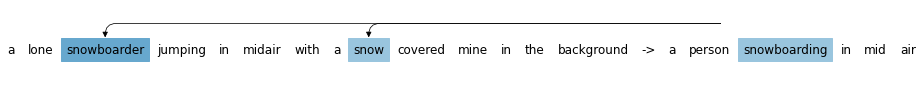





bert-base_lime-5000_test_BT=[MASK].json
texts: ['a lone snowboarder jumping in midair with a snow covered mine in the background', 'A person snowboarding in mid air']
gold label: entailment
pred label: entailment
explanations: [(('snowboarder',), ()), (('midair',), ()), (('jumping',), ()), ((), ('air',)), ((), ('person',)), (('snow',), ()), ((), ('A',)), (('mine',), ()), (('the',), ()), (('in',), ()), (('with',), ())]
interactions_vote: [(['a'], ['person', 'snowboarding']), (['snowboarder', 'jumping', 'in', 'midair'], ['person', 'snowboarding'])]
interactions_union: [(['a', 'lone', 'snowboarder', 'jumping', 'in', 'midair', 'with'], ['A', 'person', 'snowboarding']), (['a', 'lone', 'snowboarder', 'jumping', 'in', 'midair', 'with'], ['mid', 'air'])]


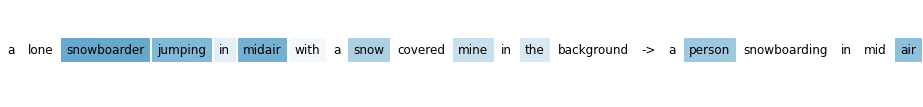





bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['a lone snowboarder jumping in midair with a snow covered mine in the background', 'A person snowboarding in mid air']
gold label: entailment
pred label: entailment
explanations: [(('jumping',), ('air',)), (('snowboarder',), ('air',)), (('midair',), ('air',)), (('snowboarder',), ('snowboarding',)), (('snowboarder',), ('a',)), (('snowboarder',), ('in',)), (('snow',), ('air',)), (('snowboarder',), ('person',)), (('midair',), ('a',)), (('midair',), ('mid',)), (('snow',), ('snowboarding',)), (('midair',), ('person',)), (('snowboarder',), ('mid',)), (('jumping',), ('a',)), (('snow',), ('a',)), (('midair',), ('in',))]
interactions_vote: [(['a'], ['person', 'snowboarding']), (['snowboarder', 'jumping', 'in', 'midair'], ['person', 'snowboarding'])]
interactions_union: [(['a', 'lone', 'snowboarder', 'jumping', 'in', 'midair', 'with'], ['A', 'person', 'snowboarding']), (['a', 'lone', 'snowboarder', 'jumping', 'in'

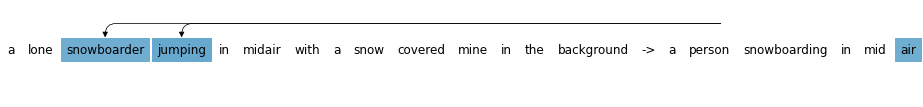





bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['a lone snowboarder jumping in midair with a snow covered mine in the background', 'A person snowboarding in mid air']
gold label: entailment
pred label: entailment
explanations: [(('snowboarder', 'midair'), ('air',)), (('snowboarder', 'jumping'), ('air',)), (('snowboarder',), ('air',)), (('snowboarder', 'jumping'), ('a',)), (('midair', 'snow'), ('air',)), (('snowboarder', 'midair'), ('snowboarding',)), (('snowboarder', 'midair'), ('mid',)), (('jumping', 'snow'), ('air',))]
interactions_vote: [(['a'], ['person', 'snowboarding']), (['snowboarder', 'jumping', 'in', 'midair'], ['person', 'snowboarding'])]
interactions_union: [(['a', 'lone', 'snowboarder', 'jumping', 'in', 'midair', 'with'], ['A', 'person', 'snowboarding']), (['a', 'lone', 'snowboarder', 'jumping', 'in', 'midair', 'with'], ['mid', 'air'])]


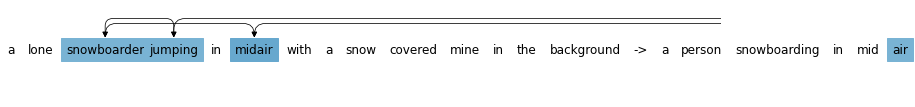





bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['a lone snowboarder jumping in midair with a snow covered mine in the background', 'A person snowboarding in mid air']
gold label: entailment
pred label: entailment
explanations: [(('snowboarder', 'jumping'), ('air',)), (('snowboarder', 'jumping', 'snow'), ('air',)), (('snowboarder', 'midair'), ('air',)), (('snowboarder', 'midair', 'snow'), ('air',)), (('snowboarder', 'midair', 'snow'), ('a',)), (('snowboarder', 'midair'), ('a',)), (('snowboarder', 'midair'), ('a', 'air')), (('snowboarder', 'jumping'), ('mid', 'air')), (('snowboarder', 'midair', 'mine'), ('air',)), (('snowboarder', 'midair', 'snow'), ('mid',)), (('snowboarder', 'in', 'midair'), ('air',)), (('snowboarder', 'jumping', 'with'), ('air',)), (('snowboarder', 'midair'), ('mid',)), (('snowboarder', 'midair'), ('snowboarding',)), (('snowboarder', 'jumping', 'midair'), ('air',)), (('snowboarder', 'jumping'), ('in', 'air')), (('snowboard

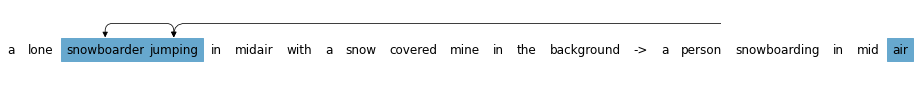





997 score 0.0
bert-base_arch-5_test_BT=[MASK].json
texts: ['A lady in a dark coat is sitting with many people around her.', 'There are people surrounding each other.']
gold label: entailment
pred label: entailment
explanations: [((), ('there', 'are', 'people', 'surrounding', 'other'))]
interactions_vote: [(['many'], ['surrounding', 'each', 'other']), (['around'], ['surrounding', 'each', 'other'])]
interactions_union: [(['many', 'people', 'around', 'her'], ['people', 'surrounding', 'each', 'other'])]


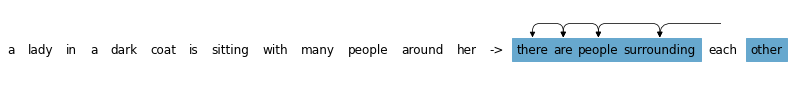





bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A lady in a dark coat is sitting with many people around her.', 'There are people surrounding each other.']
gold label: entailment
pred label: entailment
explanations: [(('a',), ('there',)), (('in',), ('surrounding',)), (('people',), ('people',))]
interactions_vote: [(['many'], ['surrounding', 'each', 'other']), (['around'], ['surrounding', 'each', 'other'])]
interactions_union: [(['many', 'people', 'around', 'her'], ['people', 'surrounding', 'each', 'other'])]


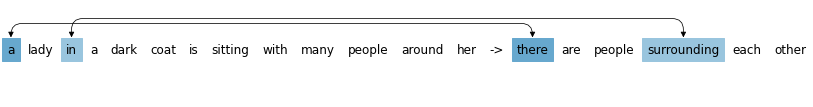





bert-base_lime-5000_test_BT=[MASK].json
texts: ['A lady in a dark coat is sitting with many people around her.', 'There are people surrounding each other.']
gold label: entailment
pred label: entailment
explanations: [((), ('surrounding',)), ((), ('There',)), ((), ('are',)), ((), ('people',)), (('people',), ()), (('many',), ()), (('a',), ()), (('around',), ()), (('sitting',), ()), (('with',), ()), (('her',), ()), (('is',), ())]
interactions_vote: [(['many'], ['surrounding', 'each', 'other']), (['around'], ['surrounding', 'each', 'other'])]
interactions_union: [(['many', 'people', 'around', 'her'], ['people', 'surrounding', 'each', 'other'])]


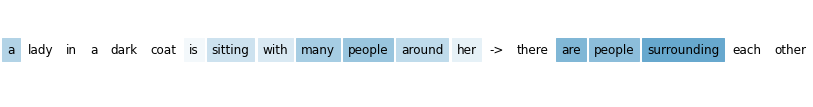





bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A lady in a dark coat is sitting with many people around her.', 'There are people surrounding each other.']
gold label: entailment
pred label: entailment
explanations: [(('people',), ('surrounding',)), (('people',), ('people',)), (('many',), ('surrounding',)), (('with',), ('surrounding',)), (('around',), ('surrounding',)), (('many',), ('people',)), (('people',), ('there',)), (('is',), ('surrounding',)), (('sitting',), ('surrounding',)), (('her',), ('surrounding',)), (('in',), ('surrounding',)), (('with',), ('people',)), (('coat',), ('surrounding',)), (('a',), ('surrounding',)), (('dark',), ('surrounding',)), (('many',), ('there',)), (('lady',), ('surrounding',)), (('with',), ('there',)), (('in',), ('people',))]
interactions_vote: [(['many'], ['surrounding', 'each', 'other']), (['around'], ['surrounding', 'each', 'other'])]
interactions_union: [(['many', 'people', 'around', 'her'], ['people', 'surroundin

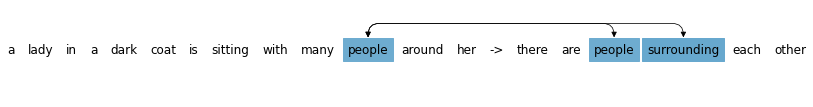





bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A lady in a dark coat is sitting with many people around her.', 'There are people surrounding each other.']
gold label: entailment
pred label: entailment
explanations: [(('people',), ('people', 'surrounding')), (('people',), ('surrounding', 'each')), (('people',), ('there', 'surrounding')), (('many',), ('people', 'surrounding')), (('people',), ('are', 'surrounding')), (('many', 'around'), ('surrounding',)), (('many',), ('surrounding', 'each')), (('with',), ('surrounding', 'each')), (('with', 'people'), ('surrounding',)), (('people',), ('surrounding', 'other'))]
interactions_vote: [(['many'], ['surrounding', 'each', 'other']), (['around'], ['surrounding', 'each', 'other'])]
interactions_union: [(['many', 'people', 'around', 'her'], ['people', 'surrounding', 'each', 'other'])]


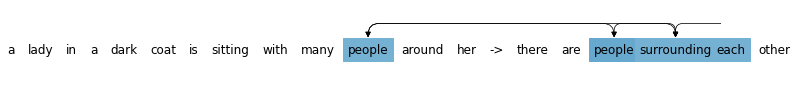





bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A lady in a dark coat is sitting with many people around her.', 'There are people surrounding each other.']
gold label: entailment
pred label: entailment
explanations: [(('many', 'around'), ('people', 'surrounding')), (('with', 'people'), ('people', 'surrounding')), (('people',), ('there', 'people', 'surrounding')), (('people',), ('are', 'people', 'surrounding')), (('people',), ('people', 'surrounding', 'each')), (('with', 'many'), ('people', 'surrounding')), (('people', 'around'), ('people', 'surrounding')), (('many', 'people'), ('people', 'surrounding')), (('people',), ('there', 'people', 'each')), (('people', 'her'), ('people', 'surrounding')), (('in', 'people'), ('people', 'surrounding')), (('is', 'people'), ('people', 'surrounding')), (('sitting', 'people'), ('people', 'surrounding')), (('people',), ('there', 'surrounding', 'each')), (('a', 'people'), ('people', 'surrounding')), (('coat'

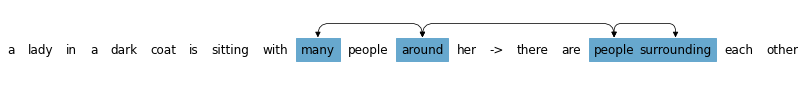

In [75]:
exp_files = ['bert-base_arch-5_test_BT=[MASK].json',
            #  'bert-base_cross_arch-5_test_BT=[MASK].json',
             'bert-base_cross_arch-5_test_BT=[MASK]_X.json',
             'bert-base_lime-5000_test_BT=[MASK].json',
             'bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json',
             'bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json',
             'bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json',
             ]


eval_df = pd.read_csv('../eval_results/new/bert-base_mask_explain-3-p0.5-n5000-inv0_interaction_f1_test_vote_10_BT=attention+[MASK]_skip-neutral_only-correct_all.csv', index_col=0)
indices = eval_df['interaction_f1_top2'].sort_values(ascending=False).index.tolist()
top, bottom = indices[:5], indices[-5:]



for test_indices in [top, bottom]:
    for idx in test_indices:
        print(idx, 'score', eval_df['interaction_f1_top2'][idx])
        for exp_file in exp_files:
            with open(f'../explanations/{exp_file}', 'r') as f:
                explanations = json.load(f)
            print(exp_file)
            if 'lime' in exp_file:
                topk = None
            elif 'mask_explain-4' in exp_file:
                topk = 1
            else:
                topk = 2
            analyze_explanation(df, explanations, idx, topk=topk, no_main='lime' not in exp_file)
            print('\n\n\n')


265 score 1.0
bert-base_arch-5_test_BT=[MASK].json
texts: ['A young male sitting in front of a computer monitor', 'Someone is at the movies with their friends.']
gold label: contradiction
pred label: contradiction
explanations: [(('sitting', 'computer'), ('movies', 'their', 'friends'))]
interactions_vote: [(['sitting'], ['at']), (['sitting'], ['movies']), (['front', 'of'], ['at']), (['front', 'of'], ['movies']), (['computer'], ['at']), (['computer'], ['movies'])]
interactions_union: [(['sitting', 'in', 'front', 'of', 'a', 'computer', 'monitor'], ['at', 'the', 'movies'])]


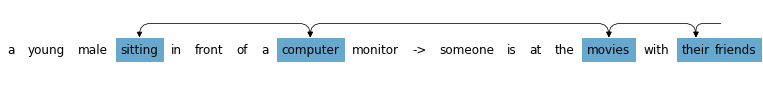





bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A young male sitting in front of a computer monitor', 'Someone is at the movies with their friends.']
gold label: contradiction
pred label: contradiction
explanations: [(('computer',), ('movies',)), (('sitting',), ('movies',)), (('computer',), ('the',))]
interactions_vote: [(['sitting'], ['at']), (['sitting'], ['movies']), (['front', 'of'], ['at']), (['front', 'of'], ['movies']), (['computer'], ['at']), (['computer'], ['movies'])]
interactions_union: [(['sitting', 'in', 'front', 'of', 'a', 'computer', 'monitor'], ['at', 'the', 'movies'])]


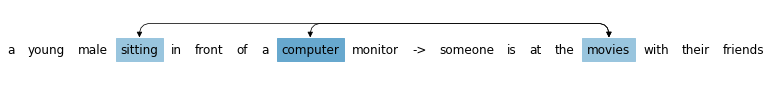





bert-base_lime-5000_test_BT=[MASK].json
texts: ['A young male sitting in front of a computer monitor', 'Someone is at the movies with their friends.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('movies',)), (('computer',), ()), ((), ('the',)), ((), ('friends',)), ((), ('at',)), (('monitor',), ()), ((), ('their',)), ((), ('with',)), (('of',), ()), (('A',), ()), (('front',), ()), (('in',), ()), ((), ()), (('a',), ()), (('male',), ())]
interactions_vote: [(['sitting'], ['at']), (['sitting'], ['movies']), (['front', 'of'], ['at']), (['front', 'of'], ['movies']), (['computer'], ['at']), (['computer'], ['movies'])]
interactions_union: [(['sitting', 'in', 'front', 'of', 'a', 'computer', 'monitor'], ['at', 'the', 'movies'])]


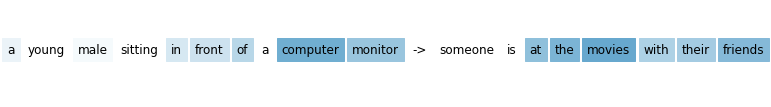





bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A young male sitting in front of a computer monitor', 'Someone is at the movies with their friends.']
gold label: contradiction
pred label: contradiction
explanations: [(('computer',), ('movies',)), (('monitor',), ('movies',)), (('front',), ('movies',)), (('sitting',), ('movies',)), (('young',), ('movies',)), (('of',), ('movies',)), (('a',), ('movies',)), (('in',), ('movies',)), (('male',), ('movies',)), (('computer',), ('the',)), (('monitor',), ('the',)), (('monitor',), ('at',)), (('computer',), ('friends',)), (('monitor',), ('friends',)), (('computer',), ('at',)), (('monitor',), ('with',)), (('computer',), ('their',)), (('computer',), ('with',)), (('monitor',), ('their',))]
interactions_vote: [(['sitting'], ['at']), (['sitting'], ['movies']), (['front', 'of'], ['at']), (['front', 'of'], ['movies']), (['computer'], ['at']), (['computer'], ['movies'])]
interactions_union: [(['sitting', 'in', 'front', 'o

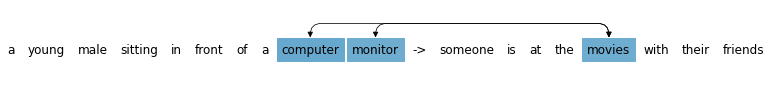





bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A young male sitting in front of a computer monitor', 'Someone is at the movies with their friends.']
gold label: contradiction
pred label: contradiction
explanations: [(('computer',), ('at', 'movies')), (('computer',), ('movies', 'with')), (('monitor',), ('at', 'movies')), (('young', 'computer'), ('movies',)), (('computer',), ('the', 'movies')), (('a', 'computer'), ('movies',)), (('monitor',), ('movies', 'with')), (('in', 'computer'), ('movies',)), (('computer',), ('movies', 'friends')), (('of', 'computer'), ('movies',))]
interactions_vote: [(['sitting'], ['at']), (['sitting'], ['movies']), (['front', 'of'], ['at']), (['front', 'of'], ['movies']), (['computer'], ['at']), (['computer'], ['movies'])]
interactions_union: [(['sitting', 'in', 'front', 'of', 'a', 'computer', 'monitor'], ['at', 'the', 'movies'])]


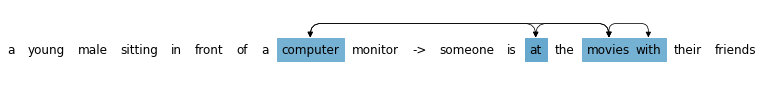





bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A young male sitting in front of a computer monitor', 'Someone is at the movies with their friends.']
gold label: contradiction
pred label: contradiction
explanations: [(('computer',), ('at', 'movies', 'with')), (('computer',), ('at', 'the', 'movies')), (('in', 'computer'), ('at', 'movies')), (('front', 'computer'), ('at', 'movies')), (('computer',), ('at', 'movies', 'friends')), (('computer', 'monitor'), ('at', 'movies')), (('young', 'computer'), ('at', 'movies')), (('computer',), ('is', 'at', 'movies')), (('a', 'computer'), ('at', 'movies')), (('sitting', 'computer'), ('at', 'movies')), (('of', 'computer'), ('at', 'movies')), (('computer',), ('at', 'movies', 'their')), (('male', 'computer'), ('at', 'movies')), (('computer',), ('someone', 'at', 'movies')), (('computer',), ('movies', 'with', 'friends')), (('in', 'computer'), ('movies', 'with')), (('young', 'computer'), ('movies', 'with')), ((

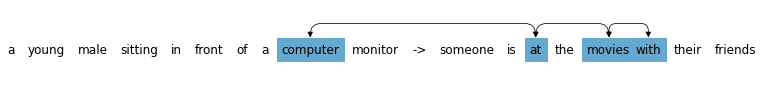





922 score 1.0
bert-base_arch-5_test_BT=[MASK].json
texts: ['Two men are boxing in fighting arena.', 'Two women are fighting.']
gold label: contradiction
pred label: contradiction
explanations: [(('men', 'boxing', 'fighting', 'arena'), ('women', 'fighting'))]
interactions_vote: [(['men'], ['women'])]
interactions_union: [(['men'], ['women'])]


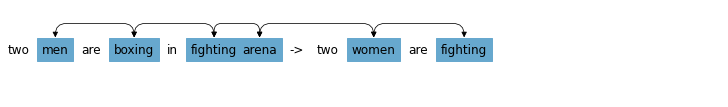





bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['Two men are boxing in fighting arena.', 'Two women are fighting.']
gold label: contradiction
pred label: contradiction
explanations: [(('men',), ('women',))]
interactions_vote: [(['men'], ['women'])]
interactions_union: [(['men'], ['women'])]


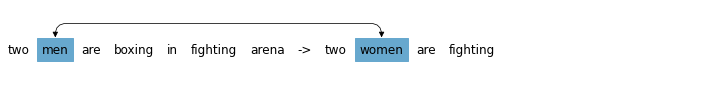





bert-base_lime-5000_test_BT=[MASK].json
texts: ['Two men are boxing in fighting arena.', 'Two women are fighting.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('women',)), (('men',), ()), (('boxing',), ())]
interactions_vote: [(['men'], ['women'])]
interactions_union: [(['men'], ['women'])]


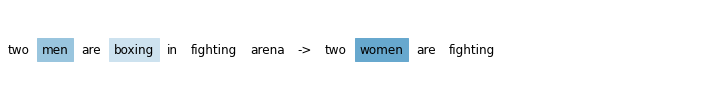





bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Two men are boxing in fighting arena.', 'Two women are fighting.']
gold label: contradiction
pred label: contradiction
explanations: [(('men',), ('women',)), (('fighting',), ('women',)), (('in',), ('women',)), (('men',), ('are',)), (('two',), ('women',)), (('are',), ('women',)), (('boxing',), ('women',)), (('men',), ('two',)), (('arena',), ('women',)), (('in',), ('are',)), (('boxing',), ('are',)), (('two',), ('are',)), (('men',), ('fighting',)), (('fighting',), ('are',)), (('arena',), ('are',)), (('in',), ('two',)), (('fighting',), ('two',)), (('are',), ('are',)), (('boxing',), ('two',)), (('are',), ('two',))]
interactions_vote: [(['men'], ['women'])]
interactions_union: [(['men'], ['women'])]


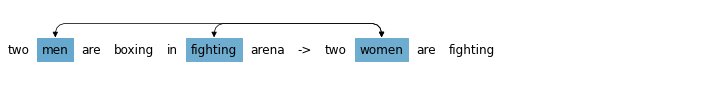





bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Two men are boxing in fighting arena.', 'Two women are fighting.']
gold label: contradiction
pred label: contradiction
explanations: [(('men',), ('women', 'fighting')), (('men',), ('two', 'women')), (('two', 'men'), ('women',)), (('men', 'are'), ('women',)), (('men', 'in'), ('women',)), (('men', 'fighting'), ('women',)), (('men',), ('women',)), (('men', 'arena'), ('women',)), (('men', 'boxing'), ('women',)), (('men',), ('women', 'are'))]
interactions_vote: [(['men'], ['women'])]
interactions_union: [(['men'], ['women'])]


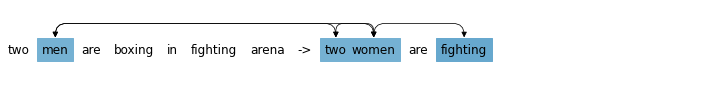





bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['Two men are boxing in fighting arena.', 'Two women are fighting.']
gold label: contradiction
pred label: contradiction
explanations: [(('men',), ('two', 'women', 'fighting')), (('two', 'men'), ('women', 'fighting')), (('men', 'in'), ('two', 'women')), (('men', 'in'), ('women', 'fighting')), (('two', 'men'), ('two', 'women')), (('men', 'are'), ('two', 'women')), (('two', 'men', 'are'), ('women',)), (('men', 'arena'), ('women', 'fighting')), (('men', 'fighting'), ('women', 'fighting')), (('men', 'arena'), ('two', 'women')), (('men', 'in', 'arena'), ('women',)), (('men', 'are'), ('women', 'fighting')), (('two', 'men', 'in'), ('women',)), (('men', 'are', 'in'), ('women',)), (('men', 'fighting'), ('two', 'women')), (('men', 'in', 'fighting'), ('women',)), (('two', 'men', 'fighting'), ('women',)), (('two', 'men', 'arena'), ('women',)), (('men', 'are', 'fighting'), ('women',)), (('men', 'are', 'aren

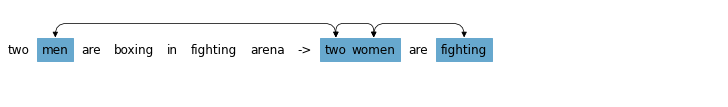





770 score 1.0
bert-base_arch-5_test_BT=[MASK].json
texts: ['The child is hanging upside down with his legs over a pole.', 'There is an adult upside down.']
gold label: contradiction
pred label: contradiction
explanations: [(('child',), ('there', 'adult'))]
interactions_vote: [(['child'], ['adult'])]
interactions_union: [(['The', 'child', 'is', 'hanging', 'upside', 'down'], ['an', 'adult'])]


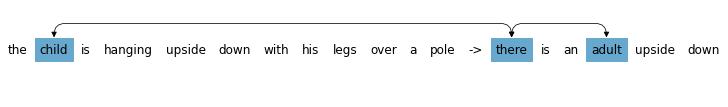





bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['The child is hanging upside down with his legs over a pole.', 'There is an adult upside down.']
gold label: contradiction
pred label: contradiction
explanations: [(('child',), ('adult',))]
interactions_vote: [(['child'], ['adult'])]
interactions_union: [(['The', 'child', 'is', 'hanging', 'upside', 'down'], ['an', 'adult'])]


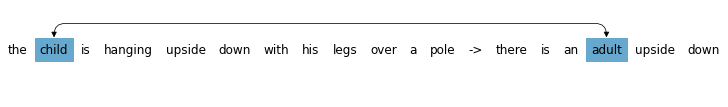





bert-base_lime-5000_test_BT=[MASK].json
texts: ['The child is hanging upside down with his legs over a pole.', 'There is an adult upside down.']
gold label: contradiction
pred label: contradiction
explanations: [(('child',), ()), ((), ('adult',)), (('pole',), ()), ((), ('upside',)), ((), ()), (('with',), ()), ((), ('down',)), (('a',), ())]
interactions_vote: [(['child'], ['adult'])]
interactions_union: [(['The', 'child', 'is', 'hanging', 'upside', 'down'], ['an', 'adult'])]


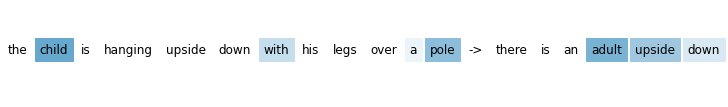





bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['The child is hanging upside down with his legs over a pole.', 'There is an adult upside down.']
gold label: contradiction
pred label: contradiction
explanations: [(('child',), ('adult',)), (('child',), ('is',)), (('pole',), ('adult',)), (('over',), ('adult',)), (('the',), ('adult',)), (('legs',), ('adult',)), (('a',), ('adult',)), (('his',), ('adult',)), (('child',), ('down',)), (('with',), ('adult',)), (('child',), ('upside',)), (('down',), ('adult',)), (('is',), ('adult',)), (('hanging',), ('adult',)), (('child',), ('an',)), (('upside',), ('adult',)), (('child',), ('there',)), (('pole',), ('is',)), (('with',), ('is',)), (('a',), ('is',))]
interactions_vote: [(['child'], ['adult'])]
interactions_union: [(['The', 'child', 'is', 'hanging', 'upside', 'down'], ['an', 'adult'])]


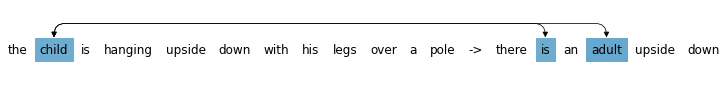





bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['The child is hanging upside down with his legs over a pole.', 'There is an adult upside down.']
gold label: contradiction
pred label: contradiction
explanations: [(('child', 'pole'), ('adult',)), (('child', 'legs'), ('adult',)), (('child', 'his'), ('adult',)), (('child',), ('adult', 'down')), (('child', 'a'), ('adult',)), (('child',), ('an', 'adult')), (('child',), ('adult',)), (('child', 'over'), ('adult',)), (('child',), ('adult', 'upside')), (('child', 'down'), ('adult',))]
interactions_vote: [(['child'], ['adult'])]
interactions_union: [(['The', 'child', 'is', 'hanging', 'upside', 'down'], ['an', 'adult'])]


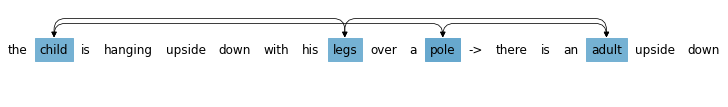





bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['The child is hanging upside down with his legs over a pole.', 'There is an adult upside down.']
gold label: contradiction
pred label: contradiction
explanations: [(('child', 'legs', 'a'), ('adult',)), (('child', 'a', 'pole'), ('adult',)), (('child', 'legs', 'pole'), ('adult',)), (('child', 'down', 'pole'), ('adult',)), (('child', 'legs'), ('an', 'adult')), (('child', 'down', 'legs'), ('adult',)), (('child', 'pole'), ('adult', 'down')), (('child', 'his', 'a'), ('adult',)), (('child', 'his', 'pole'), ('adult',)), (('child', 'pole'), ('an', 'adult')), (('child', 'with', 'legs'), ('adult',)), (('child', 'his', 'legs'), ('adult',)), (('child', 'down', 'his'), ('adult',)), (('child', 'a'), ('adult', 'down')), (('child', 'legs'), ('adult', 'down')), (('child', 'over', 'pole'), ('adult',)), (('child', 'pole'), ('adult', 'upside')), (('child', 'legs', 'over'), ('adult',)), (('child', 'with', 'his'), (

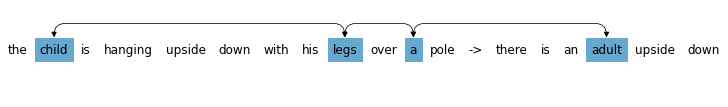





813 score 1.0
bert-base_arch-5_test_BT=[MASK].json
texts: ["A black women holding a sign that says, 'free hugs' in the city.", 'a woman is holding a sign']
gold label: entailment
pred label: entailment
explanations: [(('women', 'sign', 'hugs'), ('woman', 'holding', 'sign'))]
interactions_vote: [(['women', 'holding'], ['woman']), (['women', 'holding'], ['holding']), (['women', 'holding'], ['sign']), (['sign'], ['woman']), (['sign'], ['holding']), (['sign'], ['sign'])]
interactions_union: [(['black', 'women', 'holding', 'a', 'sign'], ['woman', 'is', 'holding', 'a', 'sign'])]


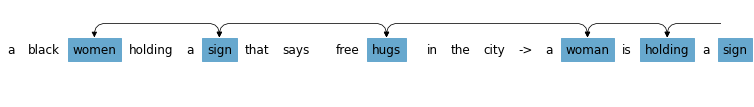





bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ["A black women holding a sign that says, 'free hugs' in the city.", 'a woman is holding a sign']
gold label: entailment
pred label: entailment
explanations: [(('sign',), ('sign',))]
interactions_vote: [(['women', 'holding'], ['woman']), (['women', 'holding'], ['holding']), (['women', 'holding'], ['sign']), (['sign'], ['woman']), (['sign'], ['holding']), (['sign'], ['sign'])]
interactions_union: [(['black', 'women', 'holding', 'a', 'sign'], ['woman', 'is', 'holding', 'a', 'sign'])]


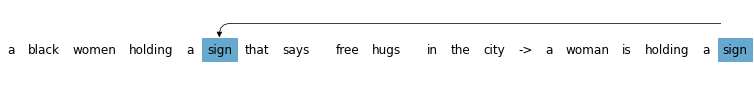





bert-base_lime-5000_test_BT=[MASK].json
texts: ["A black women holding a sign that says, 'free hugs' in the city.", 'a woman is holding a sign']
gold label: entailment
pred label: entailment
explanations: [(('women',), ()), ((), ('holding',)), ((), ('sign',)), (('hugs',), ()), (('holding',), ()), ((), ('a',)), (('says',), ()), (('a',), ()), (('that',), ()), ((), ())]
interactions_vote: [(['women', 'holding'], ['woman']), (['women', 'holding'], ['holding']), (['women', 'holding'], ['sign']), (['sign'], ['woman']), (['sign'], ['holding']), (['sign'], ['sign'])]
interactions_union: [(['black', 'women', 'holding', 'a', 'sign'], ['woman', 'is', 'holding', 'a', 'sign'])]


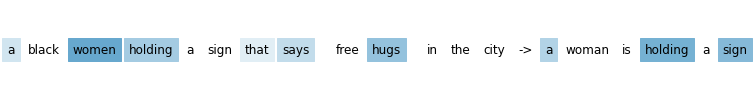





bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ["A black women holding a sign that says, 'free hugs' in the city.", 'a woman is holding a sign']
gold label: entailment
pred label: entailment
explanations: [(('women',), ('holding',)), (('women',), ('sign',)), (('holding',), ('holding',)), (('sign',), ('sign',)), (('women',), ('a',)), (('women',), ('woman',)), (('hugs',), ('holding',)), (('sign',), ('holding',)), (('holding',), ('sign',)), (('says',), ('sign',)), (('a',), ('sign',)), (('that',), ('sign',)), (('free',), ('holding',)), (('that',), ('holding',)), (('free',), ('sign',)), (('black',), ('sign',)), (('a',), ('holding',)), (('in',), ('sign',))]
interactions_vote: [(['women', 'holding'], ['woman']), (['women', 'holding'], ['holding']), (['women', 'holding'], ['sign']), (['sign'], ['woman']), (['sign'], ['holding']), (['sign'], ['sign'])]
interactions_union: [(['black', 'women', 'holding', 'a', 'sign'], ['woman', 'is', 'holding', 'a', 'sign'])]


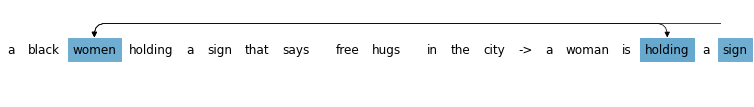





bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ["A black women holding a sign that says, 'free hugs' in the city.", 'a woman is holding a sign']
gold label: entailment
pred label: entailment
explanations: [(('women', 'holding'), ('holding',)), (('women', 'sign'), ('sign',)), (('women', 'sign'), ('holding',)), (('women', 'holding'), ('sign',)), (('women', 'hugs'), ('holding',)), (('women', 'says'), ('sign',)), (('women', 'a'), ('holding',)), (('women',), ('is', 'holding')), (('women', 'a'), ('sign',)), (('women',), ('a', 'sign'))]
interactions_vote: [(['women', 'holding'], ['woman']), (['women', 'holding'], ['holding']), (['women', 'holding'], ['sign']), (['sign'], ['woman']), (['sign'], ['holding']), (['sign'], ['sign'])]
interactions_union: [(['black', 'women', 'holding', 'a', 'sign'], ['woman', 'is', 'holding', 'a', 'sign'])]


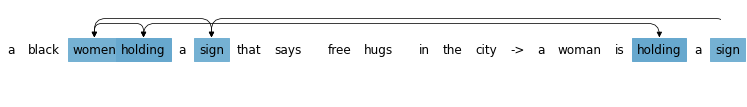





bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ["A black women holding a sign that says, 'free hugs' in the city.", 'a woman is holding a sign']
gold label: entailment
pred label: entailment
explanations: [(('women', 'holding', 'sign'), ('holding',)), (('women', 'holding', 'that'), ('holding',)), (('women', 'holding', 'says'), ('holding',)), (('women', 'holding', 'a'), ('holding',)), (('black', 'women', 'holding'), ('holding',)), (('women', 'holding', 'free'), ('holding',)), (('women', 'holding'), ('is', 'holding')), (('women', 'holding'), ('woman', 'holding')), (('women', 'holding'), ('holding', 'a')), (('women', 'holding', 'city'), ('holding',)), (('women', 'holding', 'in'), ('holding',)), (('women', 'holding'), ('a', 'holding')), (('a', 'women', 'holding'), ('holding',)), (('women', 'holding', 'the'), ('holding',)), (('women', 'holding', 'hugs'), ('holding',)), (('women', 'sign'), ('a', 'sign')), (('women', 'holding', 'sign'), ('sign',))

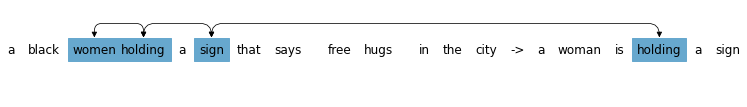





749 score 1.0
bert-base_arch-5_test_BT=[MASK].json
texts: ['Customers are ordering food at a cafe.', 'There are no customers at the cafe.']
gold label: contradiction
pred label: contradiction
explanations: [(('customers',), ('there', 'are', 'no', 'the'))]
interactions_vote: [(['Customers'], ['no'])]
interactions_union: [(['Customers', 'are'], ['no', 'customers']), (['Customers', 'are'], ['cafe'])]


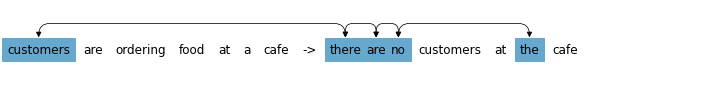





bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['Customers are ordering food at a cafe.', 'There are no customers at the cafe.']
gold label: contradiction
pred label: contradiction
explanations: [(('customers',), ('no',))]
interactions_vote: [(['Customers'], ['no'])]
interactions_union: [(['Customers', 'are'], ['no', 'customers']), (['Customers', 'are'], ['cafe'])]


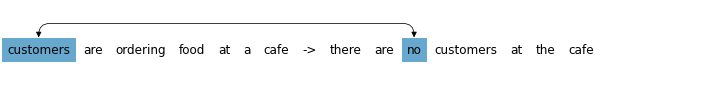





bert-base_lime-5000_test_BT=[MASK].json
texts: ['Customers are ordering food at a cafe.', 'There are no customers at the cafe.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('no',)), (('are',), ()), ((), ())]
interactions_vote: [(['Customers'], ['no'])]
interactions_union: [(['Customers', 'are'], ['no', 'customers']), (['Customers', 'are'], ['cafe'])]


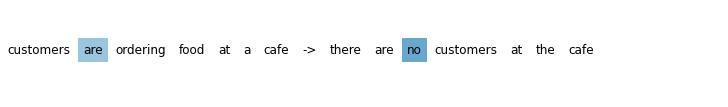





bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Customers are ordering food at a cafe.', 'There are no customers at the cafe.']
gold label: contradiction
pred label: contradiction
explanations: [(('customers',), ('no',)), (('ordering',), ('no',)), (('food',), ('no',)), (('are',), ('no',)), (('at',), ('no',)), (('a',), ('no',)), (('cafe',), ('no',)), (('ordering',), ('are',)), (('ordering',), ('the',)), (('food',), ('the',)), (('ordering',), ('cafe',)), (('food',), ('are',)), (('at',), ('the',)), (('are',), ('the',)), (('at',), ('are',)), (('customers',), ('the',)), (('are',), ('are',)), (('a',), ('are',)), (('ordering',), ('there',)), (('food',), ('there',))]
interactions_vote: [(['Customers'], ['no'])]
interactions_union: [(['Customers', 'are'], ['no', 'customers']), (['Customers', 'are'], ['cafe'])]


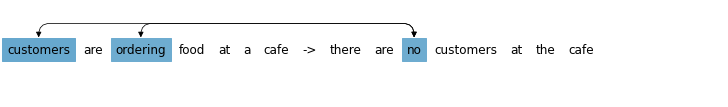





bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Customers are ordering food at a cafe.', 'There are no customers at the cafe.']
gold label: contradiction
pred label: contradiction
explanations: [(('customers',), ('no', 'customers')), (('customers',), ('there', 'no')), (('food',), ('there', 'no')), (('ordering',), ('there', 'no')), (('ordering',), ('no', 'customers')), (('customers',), ('no', 'at')), (('food',), ('no', 'customers')), (('customers',), ('are', 'no')), (('are',), ('there', 'no')), (('ordering',), ('are', 'no'))]
interactions_vote: [(['Customers'], ['no'])]
interactions_union: [(['Customers', 'are'], ['no', 'customers']), (['Customers', 'are'], ['cafe'])]


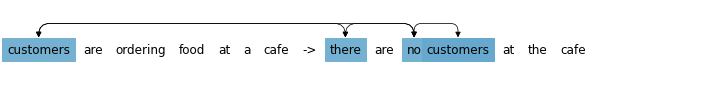





bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['Customers are ordering food at a cafe.', 'There are no customers at the cafe.']
gold label: contradiction
pred label: contradiction
explanations: [(('customers', 'at'), ('no', 'customers')), (('customers',), ('there', 'no', 'customers')), (('customers',), ('no', 'customers', 'at')), (('customers', 'food'), ('no', 'customers')), (('customers',), ('are', 'no', 'customers')), (('customers',), ('no', 'customers', 'cafe')), (('customers', 'are'), ('no', 'customers')), (('customers', 'a'), ('no', 'customers')), (('customers',), ('no', 'customers', 'the')), (('customers', 'ordering'), ('no', 'customers')), (('customers', 'cafe'), ('no', 'customers')), (('customers',), ('there', 'no', 'at')), (('customers',), ('there', 'no', 'cafe')), (('customers',), ('there', 'are', 'no')), (('customers', 'food'), ('there', 'no')), (('customers', 'cafe'), ('there', 'no')), (('customers', 'at'), ('there', 'no')), ((

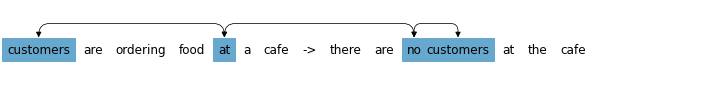





751 score 0.0
bert-base_arch-5_test_BT=[MASK].json
texts: ['A man in a white and gray shirt looks on as a shirtless man with a mustache cleans fish on a pale green table.', 'The man in an orange shirt watches another man wash dishes.']
gold label: contradiction
pred label: contradiction
explanations: []
interactions_vote: [(['white', 'and', 'gray'], ['orange', 'shirt'])]
interactions_union: [(['white', 'and', 'gray', 'shirt'], ['orange', 'shirt']), (['white', 'and', 'gray', 'shirt'], ['wash', 'dishes']), (['cleans', 'fish'], ['orange', 'shirt']), (['cleans', 'fish'], ['wash', 'dishes'])]


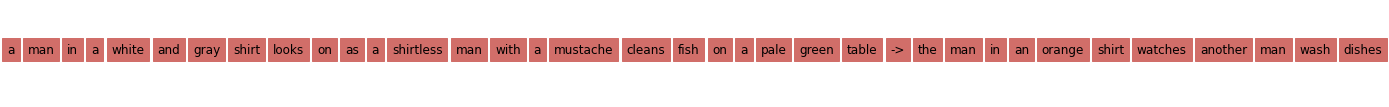





bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A man in a white and gray shirt looks on as a shirtless man with a mustache cleans fish on a pale green table.', 'The man in an orange shirt watches another man wash dishes.']
gold label: contradiction
pred label: contradiction
explanations: []
interactions_vote: [(['white', 'and', 'gray'], ['orange', 'shirt'])]
interactions_union: [(['white', 'and', 'gray', 'shirt'], ['orange', 'shirt']), (['white', 'and', 'gray', 'shirt'], ['wash', 'dishes']), (['cleans', 'fish'], ['orange', 'shirt']), (['cleans', 'fish'], ['wash', 'dishes'])]


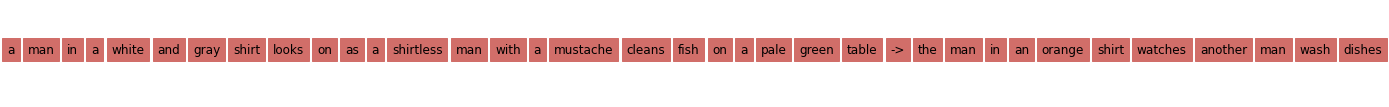





bert-base_lime-5000_test_BT=[MASK].json
texts: ['A man in a white and gray shirt looks on as a shirtless man with a mustache cleans fish on a pale green table.', 'The man in an orange shirt watches another man wash dishes.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('orange',)), ((), ('wash',)), (('white',), ()), ((), ('dishes',)), (('shirtless',), ()), (('gray',), ()), ((), ('shirt',)), ((), ('in',)), (('a',), ()), (('fish',), ()), (('man',), ())]
interactions_vote: [(['white', 'and', 'gray'], ['orange', 'shirt'])]
interactions_union: [(['white', 'and', 'gray', 'shirt'], ['orange', 'shirt']), (['white', 'and', 'gray', 'shirt'], ['wash', 'dishes']), (['cleans', 'fish'], ['orange', 'shirt']), (['cleans', 'fish'], ['wash', 'dishes'])]


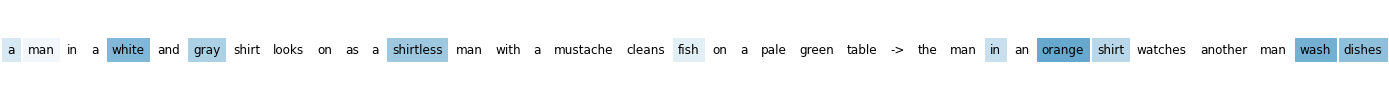





bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A man in a white and gray shirt looks on as a shirtless man with a mustache cleans fish on a pale green table.', 'The man in an orange shirt watches another man wash dishes.']
gold label: contradiction
pred label: contradiction
explanations: [(('white',), ('orange',)), (('gray',), ('orange',)), (('shirtless',), ('orange',)), (('in',), ('orange',)), (('green',), ('orange',)), (('shirt',), ('orange',)), (('on',), ('orange',)), (('man',), ('orange',)), (('pale',), ('orange',)), (('with',), ('orange',)), (('a',), ('orange',)), (('mustache',), ('orange',)), (('fish',), ('orange',)), (('cleans',), ('orange',))]
interactions_vote: [(['white', 'and', 'gray'], ['orange', 'shirt'])]
interactions_union: [(['white', 'and', 'gray', 'shirt'], ['orange', 'shirt']), (['white', 'and', 'gray', 'shirt'], ['wash', 'dishes']), (['cleans', 'fish'], ['orange', 'shirt']), (['cleans', 'fish'], ['wash', 'dishes'])]


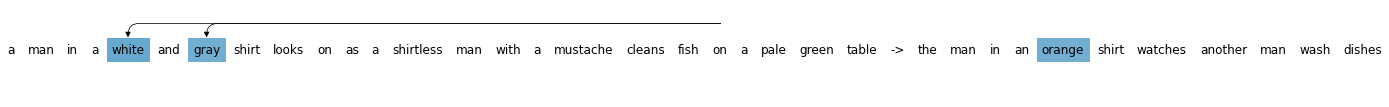





bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A man in a white and gray shirt looks on as a shirtless man with a mustache cleans fish on a pale green table.', 'The man in an orange shirt watches another man wash dishes.']
gold label: contradiction
pred label: contradiction
explanations: [(('gray', 'shirt'), ('orange',)), (('in', 'white'), ('orange',)), (('white', 'shirt'), ('orange',)), (('white', 'shirtless'), ('orange',)), (('gray', 'shirtless'), ('orange',)), (('white',), ('orange', 'watches')), (('in', 'gray'), ('orange',)), (('a', 'white'), ('orange',)), (('white',), ('in', 'orange'))]
interactions_vote: [(['white', 'and', 'gray'], ['orange', 'shirt'])]
interactions_union: [(['white', 'and', 'gray', 'shirt'], ['orange', 'shirt']), (['white', 'and', 'gray', 'shirt'], ['wash', 'dishes']), (['cleans', 'fish'], ['orange', 'shirt']), (['cleans', 'fish'], ['wash', 'dishes'])]


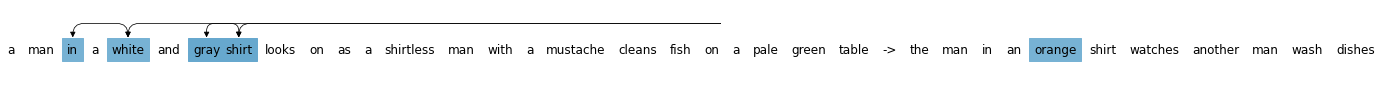





bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A man in a white and gray shirt looks on as a shirtless man with a mustache cleans fish on a pale green table.', 'The man in an orange shirt watches another man wash dishes.']
gold label: contradiction
pred label: contradiction
explanations: [(('gray', 'shirt'), ('orange', 'shirt')), (('white', 'shirt'), ('orange', 'shirt')), (('white',), ('orange', 'wash', 'dishes')), (('gray', 'shirtless'), ('orange', 'dishes')), (('in', 'white'), ('in', 'orange')), (('gray', 'shirt'), ('in', 'orange')), (('in', 'gray'), ('in', 'orange')), (('gray', 'shirtless'), ('in', 'orange')), (('gray', 'shirtless'), ('orange',)), (('white', 'shirt', 'green'), ('orange',)), (('white', 'shirtless'), ('orange', 'dishes')), (('gray', 'shirt'), ('orange', 'dishes')), (('white', 'shirtless'), ('in', 'orange')), (('gray',), ('orange', 'wash', 'dishes')), (('gray', 'shirt'), ('orange', 'watches')), (('white', 'gray', 'shirt')

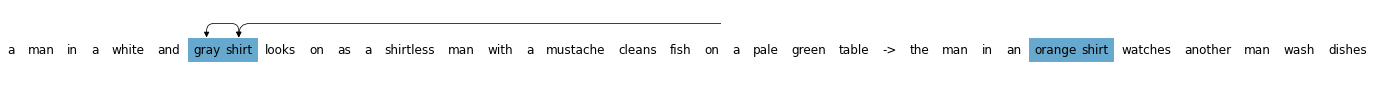





306 score 0.0
bert-base_arch-5_test_BT=[MASK].json
texts: ['Blue, red, yellow, and white are the dominant colors of a picture of two police vehicles outside of what looks like a smoke roll playing vehicle, a motorcycle in between the two cars with 6 people in the picture.', 'There are two police vehicles in the photo.']
gold label: entailment
pred label: entailment
explanations: [((), ('there', 'two', 'in', 'photo')), (('cars',), ('vehicles',)), (('police',), ('police',))]
interactions_vote: [(['vehicles'], ['photo'])]
interactions_union: [(['police', 'vehicles'], ['There', 'are']), (['police', 'vehicles'], ['police']), (['police', 'vehicles'], ['photo']), (['picture'], ['There', 'are']), (['picture'], ['police']), (['picture'], ['photo'])]


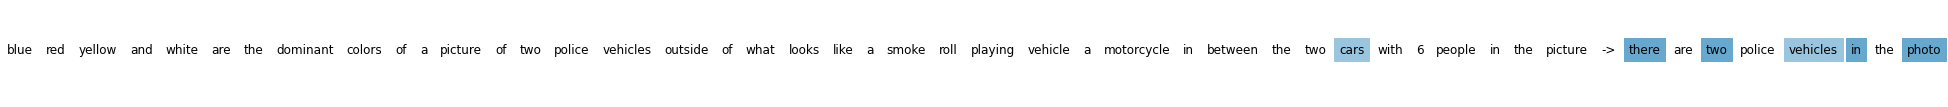





bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['Blue, red, yellow, and white are the dominant colors of a picture of two police vehicles outside of what looks like a smoke roll playing vehicle, a motorcycle in between the two cars with 6 people in the picture.', 'There are two police vehicles in the photo.']
gold label: entailment
pred label: entailment
explanations: [(('cars',), ('vehicles',)), (('motorcycle',), ('vehicles',)), (('police',), ('police',))]
interactions_vote: [(['vehicles'], ['photo'])]
interactions_union: [(['police', 'vehicles'], ['There', 'are']), (['police', 'vehicles'], ['police']), (['police', 'vehicles'], ['photo']), (['picture'], ['There', 'are']), (['picture'], ['police']), (['picture'], ['photo'])]


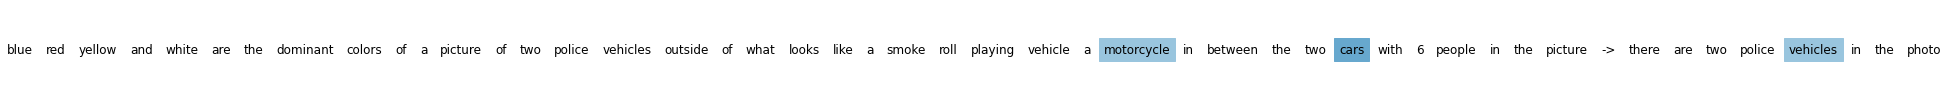





bert-base_lime-5000_test_BT=[MASK].json
texts: ['Blue, red, yellow, and white are the dominant colors of a picture of two police vehicles outside of what looks like a smoke roll playing vehicle, a motorcycle in between the two cars with 6 people in the picture.', 'There are two police vehicles in the photo.']
gold label: entailment
pred label: entailment
explanations: [(('police',), ()), ((), ('vehicles',)), ((), ('There',)), ((), ('two',)), ((), ('photo',)), ((), ('are',)), (('roll',), ()), (('motorcycle',), ()), ((), ('in',)), (('are',), ()), (('6',), ()), (('like',), ()), (('a',), ())]
interactions_vote: [(['vehicles'], ['photo'])]
interactions_union: [(['police', 'vehicles'], ['There', 'are']), (['police', 'vehicles'], ['police']), (['police', 'vehicles'], ['photo']), (['picture'], ['There', 'are']), (['picture'], ['police']), (['picture'], ['photo'])]


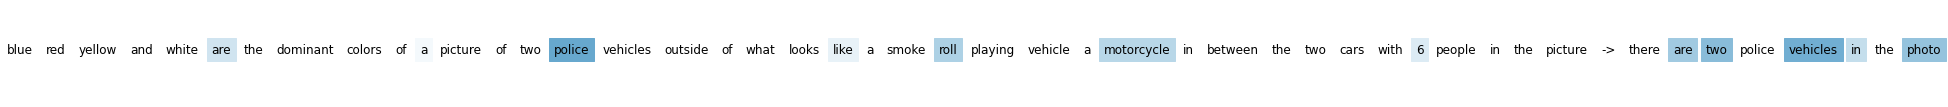





bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Blue, red, yellow, and white are the dominant colors of a picture of two police vehicles outside of what looks like a smoke roll playing vehicle, a motorcycle in between the two cars with 6 people in the picture.', 'There are two police vehicles in the photo.']
gold label: entailment
pred label: entailment
explanations: [(('police',), ('vehicles',)), (('police',), ('there',)), (('police',), ('photo',)), (('police',), ('in',)), (('police',), ('are',)), (('police',), ('the',)), (('police',), ('police',)), (('police',), ('two',)), (('motorcycle',), ('vehicles',)), (('cars',), ('vehicles',)), (('of',), ('vehicles',)), (('people',), ('vehicles',)), (('two',), ('vehicles',)), (('red',), ('vehicles',)), (('vehicles',), ('vehicles',)), (('in',), ('vehicles',)), (('the',), ('vehicles',)), (('like',), ('vehicles',))]
interactions_vote: [(['vehicles'], ['photo'])]
interactions_union: [(['police', 'vehicles'], ['Th

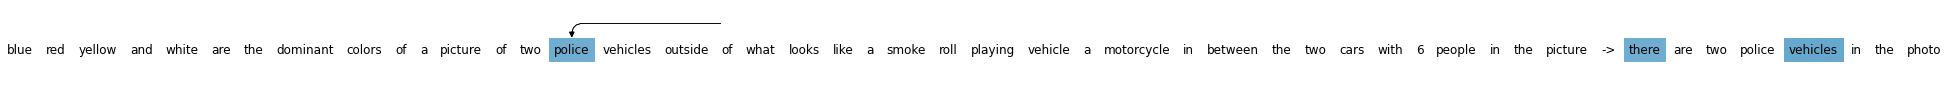





bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Blue, red, yellow, and white are the dominant colors of a picture of two police vehicles outside of what looks like a smoke roll playing vehicle, a motorcycle in between the two cars with 6 people in the picture.', 'There are two police vehicles in the photo.']
gold label: entailment
pred label: entailment
explanations: [(('police',), ('vehicles', 'photo')), (('police',), ('there', 'vehicles')), (('police', 'cars'), ('vehicles',)), (('two', 'police'), ('vehicles',)), (('two', 'police'), ('there',)), (('dominant', 'police'), ('vehicles',)), (('police', 'a'), ('vehicles',)), (('police', 'two'), ('vehicles',)), (('police', 'of'), ('vehicles',)), (('police', 'motorcycle'), ('vehicles',))]
interactions_vote: [(['vehicles'], ['photo'])]
interactions_union: [(['police', 'vehicles'], ['There', 'are']), (['police', 'vehicles'], ['police']), (['police', 'vehicles'], ['photo']), (['picture'], ['There', 'are']), ([

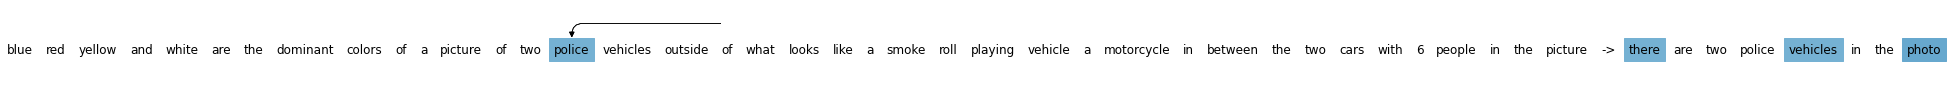





bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['Blue, red, yellow, and white are the dominant colors of a picture of two police vehicles outside of what looks like a smoke roll playing vehicle, a motorcycle in between the two cars with 6 people in the picture.', 'There are two police vehicles in the photo.']
gold label: entailment
pred label: entailment
explanations: [(('police',), ('there', 'vehicles', 'photo')), (('police',), ('vehicles', 'in', 'photo')), (('police', 'cars'), ('there', 'vehicles')), (('police', 'two'), ('there', 'vehicles')), (('two', 'police'), ('there', 'vehicles')), (('police', 'cars'), ('vehicles', 'photo')), (('police', 'motorcycle'), ('there', 'vehicles')), (('police', 'vehicles'), ('there', 'vehicles')), (('police', 'motorcycle'), ('vehicles', 'photo')), (('police',), ('there', 'are', 'vehicles')), (('police', 'in'), ('there', 'vehicles')), (('two', 'police'), ('vehicles', 'photo')), (('police', 'vehicle'), ('ther

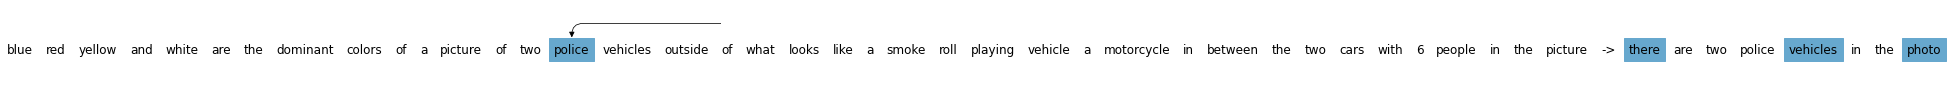





767 score 0.0
bert-base_arch-5_test_BT=[MASK].json
texts: ['Young girl in an bathing suit falling off the end of a slide into a pool.', 'A child is moving swiftly toward a body of water.']
gold label: entailment
pred label: entailment
explanations: [(('pool',), ('water',)), ((), ('moving', 'toward')), ((), ('is', 'a'))]
interactions_vote: [(['Young', 'girl'], ['child']), (['Young', 'girl'], ['body']), (['Young', 'girl'], ['water']), (['pool'], ['child']), (['pool'], ['body']), (['pool'], ['water'])]
interactions_union: [(['Young', 'girl'], ['child']), (['Young', 'girl'], ['body', 'of', 'water']), (['pool'], ['child']), (['pool'], ['body', 'of', 'water'])]


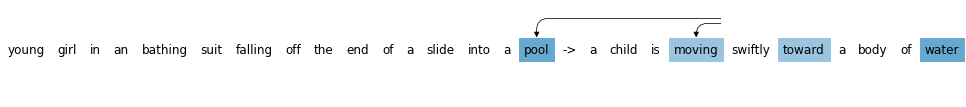





bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['Young girl in an bathing suit falling off the end of a slide into a pool.', 'A child is moving swiftly toward a body of water.']
gold label: entailment
pred label: entailment
explanations: [(('falling',), ('moving',)), (('bathing',), ('water',)), (('pool',), ('water',)), (('bathing',), ('of',))]
interactions_vote: [(['Young', 'girl'], ['child']), (['Young', 'girl'], ['body']), (['Young', 'girl'], ['water']), (['pool'], ['child']), (['pool'], ['body']), (['pool'], ['water'])]
interactions_union: [(['Young', 'girl'], ['child']), (['Young', 'girl'], ['body', 'of', 'water']), (['pool'], ['child']), (['pool'], ['body', 'of', 'water'])]


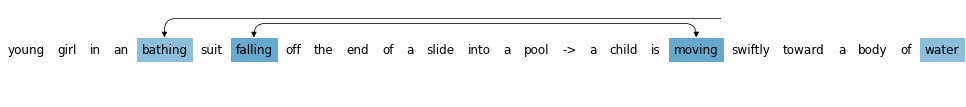





bert-base_lime-5000_test_BT=[MASK].json
texts: ['Young girl in an bathing suit falling off the end of a slide into a pool.', 'A child is moving swiftly toward a body of water.']
gold label: entailment
pred label: entailment
explanations: [((), ('moving',)), ((), ('water',)), ((), ('body',)), (('falling',), ()), (('girl',), ()), (('off',), ()), (('into',), ()), ((), ('a',)), ((), ('toward',)), ((), ('of',)), ((), ('child',)), (('slide',), ()), (('suit',), ()), (('in',), ()), (('Young',), ()), (('an',), ()), ((), ('A',))]
interactions_vote: [(['Young', 'girl'], ['child']), (['Young', 'girl'], ['body']), (['Young', 'girl'], ['water']), (['pool'], ['child']), (['pool'], ['body']), (['pool'], ['water'])]
interactions_union: [(['Young', 'girl'], ['child']), (['Young', 'girl'], ['body', 'of', 'water']), (['pool'], ['child']), (['pool'], ['body', 'of', 'water'])]


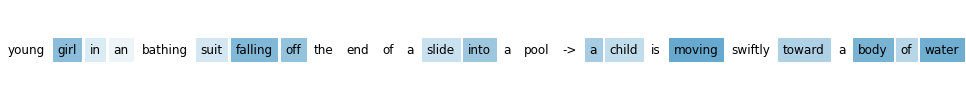





bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Young girl in an bathing suit falling off the end of a slide into a pool.', 'A child is moving swiftly toward a body of water.']
gold label: entailment
pred label: entailment
explanations: [(('falling',), ('moving',)), (('slide',), ('moving',)), (('into',), ('moving',)), (('girl',), ('moving',)), (('falling',), ('water',)), (('end',), ('moving',)), (('off',), ('moving',)), (('young',), ('moving',)), (('the',), ('moving',)), (('suit',), ('moving',)), (('an',), ('moving',)), (('in',), ('moving',)), (('of',), ('moving',)), (('bathing',), ('moving',)), (('pool',), ('moving',)), (('a',), ('moving',)), (('into',), ('water',)), (('girl',), ('water',)), (('falling',), ('of',))]
interactions_vote: [(['Young', 'girl'], ['child']), (['Young', 'girl'], ['body']), (['Young', 'girl'], ['water']), (['pool'], ['child']), (['pool'], ['body']), (['pool'], ['water'])]
interactions_union: [(['Young', 'girl'], ['child']), (

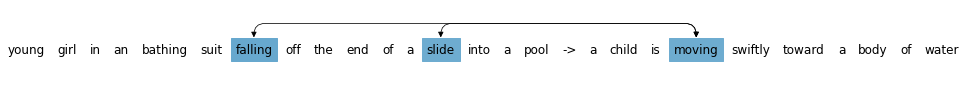





bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Young girl in an bathing suit falling off the end of a slide into a pool.', 'A child is moving swiftly toward a body of water.']
gold label: entailment
pred label: entailment
explanations: [(('falling',), ('moving', 'water')), (('slide',), ('moving', 'water')), (('girl', 'falling'), ('moving',)), (('falling',), ('moving', 'of')), (('slide', 'into'), ('moving',)), (('falling', 'into'), ('moving',)), (('falling',), ('moving', 'toward')), (('into',), ('moving', 'water')), (('falling',), ('moving', 'body')), (('falling',), ('a', 'moving'))]
interactions_vote: [(['Young', 'girl'], ['child']), (['Young', 'girl'], ['body']), (['Young', 'girl'], ['water']), (['pool'], ['child']), (['pool'], ['body']), (['pool'], ['water'])]
interactions_union: [(['Young', 'girl'], ['child']), (['Young', 'girl'], ['body', 'of', 'water']), (['pool'], ['child']), (['pool'], ['body', 'of', 'water'])]


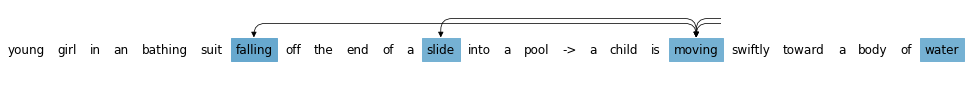





bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['Young girl in an bathing suit falling off the end of a slide into a pool.', 'A child is moving swiftly toward a body of water.']
gold label: entailment
pred label: entailment
explanations: [(('falling',), ('a', 'moving', 'water')), (('falling',), ('moving', 'body', 'water')), (('slide',), ('moving', 'body', 'water')), (('falling',), ('moving', 'body', 'of')), (('falling',), ('moving', 'toward', 'water')), (('girl', 'falling'), ('moving', 'water')), (('slide', 'into'), ('moving', 'water')), (('slide',), ('a', 'moving', 'water')), (('girl', 'falling'), ('a', 'moving')), (('girl', 'falling'), ('child', 'moving')), (('slide', 'into'), ('moving', 'body')), (('falling',), ('a', 'moving', 'of')), (('slide', 'into'), ('moving', 'of')), (('girl', 'falling'), ('moving', 'toward')), (('falling', 'slide'), ('moving', 'body')), (('into',), ('moving', 'body', 'water')), (('girl', 'falling'), ('moving', 'bo

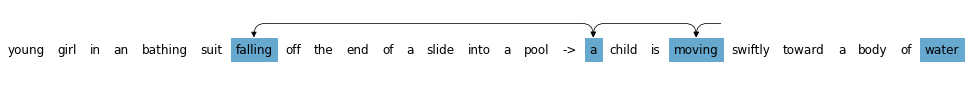





299 score 0.0
bert-base_arch-5_test_BT=[MASK].json
texts: ['Young woman is putting her clothes in the dryer portion of a double stacked washer and dryer unit.', 'Nobody is drying clothes.']
gold label: contradiction
pred label: contradiction
explanations: [(('clothes', 'dryer', 'dryer'), ('nobody', 'drying', 'clothes'))]
interactions_vote: [(['woman'], ['Nobody'])]
interactions_union: [(['Young', 'woman'], ['Nobody'])]


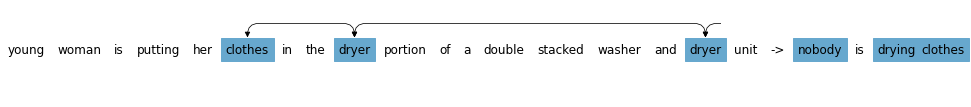





bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['Young woman is putting her clothes in the dryer portion of a double stacked washer and dryer unit.', 'Nobody is drying clothes.']
gold label: contradiction
pred label: contradiction
explanations: [(('dryer',), ('nobody', 'drying'))]
interactions_vote: [(['woman'], ['Nobody'])]
interactions_union: [(['Young', 'woman'], ['Nobody'])]


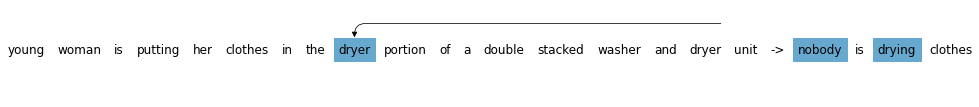





bert-base_lime-5000_test_BT=[MASK].json
texts: ['Young woman is putting her clothes in the dryer portion of a double stacked washer and dryer unit.', 'Nobody is drying clothes.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('Nobody',)), (('unit',), ()), (('washer',), ()), (('a',), ())]
interactions_vote: [(['woman'], ['Nobody'])]
interactions_union: [(['Young', 'woman'], ['Nobody'])]


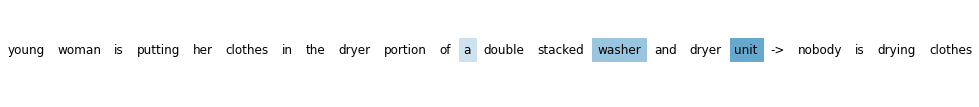





bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Young woman is putting her clothes in the dryer portion of a double stacked washer and dryer unit.', 'Nobody is drying clothes.']
gold label: contradiction
pred label: contradiction
explanations: [(('clothes',), ('nobody',)), (('putting',), ('nobody',)), (('portion',), ('nobody',)), (('young',), ('nobody',)), (('unit',), ('nobody',)), (('dryer',), ('nobody',)), (('woman',), ('nobody',)), (('washer',), ('nobody',)), (('and',), ('nobody',)), (('is',), ('nobody',)), (('a',), ('nobody',)), (('stacked',), ('nobody',)), (('double',), ('nobody',)), (('her',), ('nobody',)), (('of',), ('nobody',)), (('the',), ('nobody',)), (('in',), ('nobody',))]
interactions_vote: [(['woman'], ['Nobody'])]
interactions_union: [(['Young', 'woman'], ['Nobody'])]


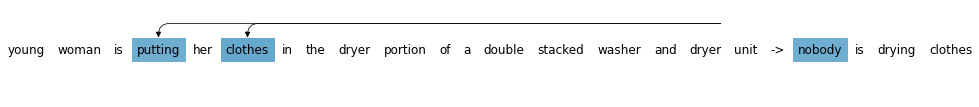





bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Young woman is putting her clothes in the dryer portion of a double stacked washer and dryer unit.', 'Nobody is drying clothes.']
gold label: contradiction
pred label: contradiction
explanations: [(('putting',), ('nobody', 'drying')), (('putting', 'clothes'), ('nobody',)), (('clothes',), ('nobody', 'is')), (('washer',), ('nobody', 'drying')), (('clothes', 'washer'), ('nobody',)), (('clothes', 'dryer'), ('nobody',)), (('clothes', 'a'), ('nobody',)), (('dryer',), ('nobody', 'drying'))]
interactions_vote: [(['woman'], ['Nobody'])]
interactions_union: [(['Young', 'woman'], ['Nobody'])]


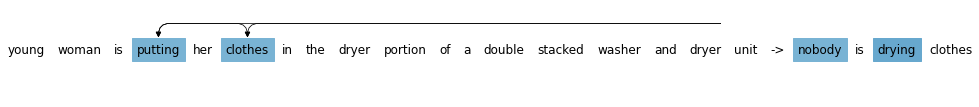





bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['Young woman is putting her clothes in the dryer portion of a double stacked washer and dryer unit.', 'Nobody is drying clothes.']
gold label: contradiction
pred label: contradiction
explanations: [(('putting', 'a'), ('nobody', 'drying')), (('putting', 'clothes'), ('nobody', 'drying')), (('putting', 'portion'), ('nobody', 'drying')), (('putting', 'washer'), ('nobody', 'drying')), (('woman', 'putting'), ('nobody', 'drying')), (('putting', 'dryer'), ('nobody', 'drying')), (('putting', 'the'), ('nobody', 'drying')), (('putting', 'and'), ('nobody', 'drying')), (('putting', 'unit'), ('nobody', 'drying')), (('putting', 'of'), ('nobody', 'drying')), (('putting', 'double'), ('nobody', 'drying')), (('young', 'putting'), ('nobody', 'drying')), (('putting', 'stacked'), ('nobody', 'drying')), (('is', 'putting'), ('nobody', 'drying')), (('putting',), ('nobody', 'is', 'drying')), (('putting', 'in'), ('nobod

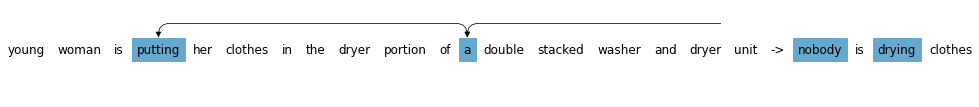





997 score 0.0
bert-base_arch-5_test_BT=[MASK].json
texts: ['A lady in a dark coat is sitting with many people around her.', 'There are people surrounding each other.']
gold label: entailment
pred label: entailment
explanations: [((), ('there', 'are', 'people', 'surrounding', 'other'))]
interactions_vote: [(['many'], ['surrounding', 'each', 'other']), (['around'], ['surrounding', 'each', 'other'])]
interactions_union: [(['many', 'people', 'around', 'her'], ['people', 'surrounding', 'each', 'other'])]


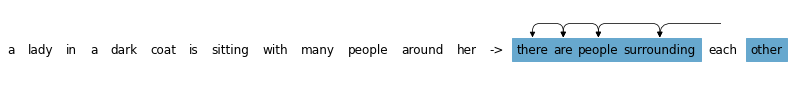





bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A lady in a dark coat is sitting with many people around her.', 'There are people surrounding each other.']
gold label: entailment
pred label: entailment
explanations: [(('a',), ('there',)), (('in',), ('surrounding',)), (('people',), ('people',))]
interactions_vote: [(['many'], ['surrounding', 'each', 'other']), (['around'], ['surrounding', 'each', 'other'])]
interactions_union: [(['many', 'people', 'around', 'her'], ['people', 'surrounding', 'each', 'other'])]


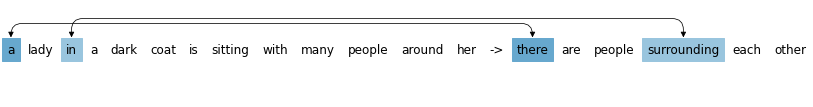





bert-base_lime-5000_test_BT=[MASK].json
texts: ['A lady in a dark coat is sitting with many people around her.', 'There are people surrounding each other.']
gold label: entailment
pred label: entailment
explanations: [((), ('surrounding',)), ((), ('There',)), ((), ('are',)), ((), ('people',)), (('people',), ()), (('many',), ()), (('a',), ()), (('around',), ()), (('sitting',), ()), (('with',), ()), (('her',), ()), (('is',), ())]
interactions_vote: [(['many'], ['surrounding', 'each', 'other']), (['around'], ['surrounding', 'each', 'other'])]
interactions_union: [(['many', 'people', 'around', 'her'], ['people', 'surrounding', 'each', 'other'])]


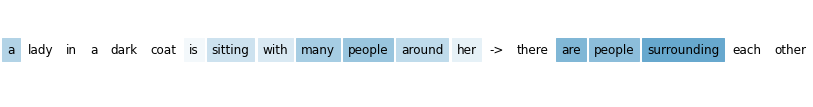





bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A lady in a dark coat is sitting with many people around her.', 'There are people surrounding each other.']
gold label: entailment
pred label: entailment
explanations: [(('people',), ('surrounding',)), (('people',), ('people',)), (('many',), ('surrounding',)), (('with',), ('surrounding',)), (('around',), ('surrounding',)), (('many',), ('people',)), (('people',), ('there',)), (('is',), ('surrounding',)), (('sitting',), ('surrounding',)), (('her',), ('surrounding',)), (('in',), ('surrounding',)), (('with',), ('people',)), (('coat',), ('surrounding',)), (('a',), ('surrounding',)), (('dark',), ('surrounding',)), (('many',), ('there',)), (('lady',), ('surrounding',)), (('with',), ('there',)), (('in',), ('people',))]
interactions_vote: [(['many'], ['surrounding', 'each', 'other']), (['around'], ['surrounding', 'each', 'other'])]
interactions_union: [(['many', 'people', 'around', 'her'], ['people', 'surroundin

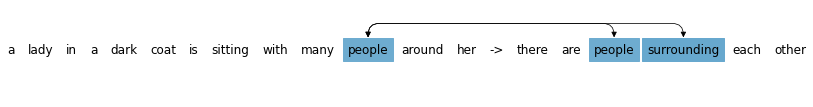





bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A lady in a dark coat is sitting with many people around her.', 'There are people surrounding each other.']
gold label: entailment
pred label: entailment
explanations: [(('people',), ('people', 'surrounding')), (('people',), ('surrounding', 'each')), (('people',), ('there', 'surrounding')), (('many',), ('people', 'surrounding')), (('people',), ('are', 'surrounding')), (('many', 'around'), ('surrounding',)), (('many',), ('surrounding', 'each')), (('with',), ('surrounding', 'each')), (('with', 'people'), ('surrounding',)), (('people',), ('surrounding', 'other'))]
interactions_vote: [(['many'], ['surrounding', 'each', 'other']), (['around'], ['surrounding', 'each', 'other'])]
interactions_union: [(['many', 'people', 'around', 'her'], ['people', 'surrounding', 'each', 'other'])]


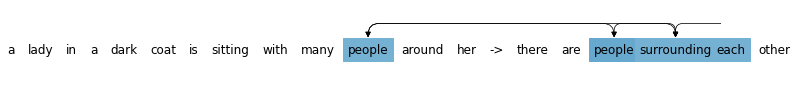





bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A lady in a dark coat is sitting with many people around her.', 'There are people surrounding each other.']
gold label: entailment
pred label: entailment
explanations: [(('many', 'around'), ('people', 'surrounding')), (('with', 'people'), ('people', 'surrounding')), (('people',), ('there', 'people', 'surrounding')), (('people',), ('are', 'people', 'surrounding')), (('people',), ('people', 'surrounding', 'each')), (('with', 'many'), ('people', 'surrounding')), (('people', 'around'), ('people', 'surrounding')), (('many', 'people'), ('people', 'surrounding')), (('people',), ('there', 'people', 'each')), (('people', 'her'), ('people', 'surrounding')), (('in', 'people'), ('people', 'surrounding')), (('is', 'people'), ('people', 'surrounding')), (('sitting', 'people'), ('people', 'surrounding')), (('people',), ('there', 'surrounding', 'each')), (('a', 'people'), ('people', 'surrounding')), (('coat'

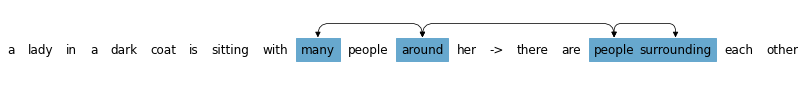

In [78]:
exp_files = ['bert-base_arch-5_test_BT=[MASK].json',
            #  'bert-base_cross_arch-5_test_BT=[MASK].json',
             'bert-base_cross_arch-5_test_BT=[MASK]_X.json',
             'bert-base_lime-5000_test_BT=[MASK].json',
             'bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json',
             'bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json',
             'bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json',
             ]


eval_df = pd.read_csv('../eval_results/new/bert-base_cross_arch-5_interaction_f1_test_vote_10_BT=[MASK]_X_skip-neutral_only-correct_all.csv', index_col=0)
indices = eval_df['interaction_f1_top2'].sort_values(ascending=False).index.tolist()
top, bottom = indices[:5], indices[-5:]



for test_indices in [top, bottom]:
    for idx in test_indices:
        print(idx, 'score', eval_df['interaction_f1_top2'][idx])
        for exp_file in exp_files:
            with open(f'../explanations/{exp_file}', 'r') as f:
                explanations = json.load(f)
            print(exp_file)
            if 'lime' in exp_file:
                topk = None
            elif 'mask_explain-4' in exp_file:
                topk = 1
            else:
                topk = 2
            analyze_explanation(df, explanations, idx, topk=topk, no_main='lime' not in exp_file)
            print('\n\n\n')